In [22]:
import sherpa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout
import time
import math

In [23]:
# Carregando Dataset
def dataset():
    import pandas_datareader.data as web
    import datetime as dt

    end = dt.datetime(2020, 11, 1)
    start = dt.datetime(2015, 1, 1)

    df = web.DataReader("AAPL", 'yahoo', start, end)

    df = df.reset_index()
    df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
    df = df.rename(columns={'Close': 'Close 0'})

    def window (df, w):
        for i in range(1,w):
            df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
        return df

    new_df = window(df,5)
    new_df = new_df.rename(columns={'Close 0': 'Target'})
    new_df.dropna(inplace=True)

    limit = int(len(new_df)*0.75)

    X = new_df.loc[:,['Close 1','Close 2','Close 3','Close 4']]
    y = new_df.loc[:,'Target'].tolist()

    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    y = np.array(y)

    X_train, X_test = X[:limit], X[limit:]
    y_train, y_test = y[:limit], y[limit:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = dataset()

### PBT

In [74]:
model_hp = {
    sherpa.Discrete('batch_size',[10, 20, 60, 100]),
    sherpa.Discrete('epochs',[10, 50, 100]),
    sherpa.Choice('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']),
    sherpa.Choice('activation',['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']),
    #sherpa.Discrete('dropout_rate',[0, 0.1, 0.2, 0.3]),
    sherpa.Discrete('node_first',[30, 50, 75]),
    sherpa.Discrete('node_last',[5, 7, 10]),
    sherpa.Discrete('hidden',[2,3,4])
}

In [103]:
def find_nodes(n_layers, n_first, n_last):
    layers = []
    increment = (n_last - n_first) / (n_layers - 1)
    nodes = n_first
    for i in range (1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + increment

    return layers

def create_model(optimizer='adam', activation = 'relu', dropout = 0.0, hidden = 1, n_first = 50, n_last = 5):
    model = Sequential()
    model.add(Flatten())
    nodes = find_nodes(hidden, n_first, n_last)

    for i in range(0, hidden-1):
        if i == 0:
            model.add(Dense(n_first, input_dim=X_train.shape[1], activation = activation))
        else:
            model.add(Dense(nodes[i], activation = activation))
            #model.add(Dropout(dropout))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer=optimizer, 
                  metrics=[keras.metrics.MeanSquaredError()])
    return model

In [106]:
parameters = [sherpa.Choice('optimizer',['SGD', 'Adagrad', 'Adam']),
              sherpa.Choice('activation',['relu', 'tanh', 'sigmoid','linear']),
              sherpa.Discrete('neurons',[30, 50, 75]),
              sherpa.Discrete('n_layers',[2,3,4]),
              sherpa.Discrete('epochs',[10, 100]),
              sherpa.Discrete('batch_size',[10, 100]),
              sherpa.Continuous('dropout_rate',[0, 0.1, 0.2, 0.3])]

algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=50,
                                                      num_generations=10,
                                                      perturbation_factors=(0.8, 1.2))
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     disable_dashboard = True,
                     lower_is_better=True)

In [107]:
i = 0
ini = time.time()
for trial in study:
    generation = trial.parameters['generation']
    load_from = trial.parameters['load_from']
    optimizer = trial.parameters['optimizer']
    activation = trial.parameters['activation']
    n_layers = trial.parameters['n_layers']
    neurons = trial.parameters['neurons']
    epochs = trial.parameters['epochs']
    drop = trial.parameters['dropout_rate']
    batch = trial.parameters['batch_size']
    

    print("-"*100)
    print("Generation {}".format(generation))


    print("Creating new model with\nOptimizer: ",optimizer,"\nActivation: ", activation)
    print("N_Layers: ",n_layers,"\nNeurons: ", neurons,"\nEpochs: ", epochs)

    # Create model
    
    model = Sequential()
    
    model.add(Flatten())
    
    for n in range(n_layers):
        if n == 0:
            model.add(Dense(neurons, activation = activation, input_dim=X_train.shape[1]))
        else:
            model.add(Dense(neurons, activation = activation))
            model.add(Dropout(drop))
    
    model.add(Dense(1))
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[keras.metrics.MeanSquaredError()])


    # Train model for one epoch
    model.fit(X_train, y_train, epochs=epochs, batch_size = batch)
    loss, accuracy = model.evaluate(X_test, y_test)

    print("Validation accuracy: ", accuracy)
    study.add_observation(trial=trial, iteration=generation,
                          objective=accuracy)
    
    try:
        study.finalize(trial=trial)
    except :
        print("---ERRO---")
        i = i+1
        
print(i, " erros")
tempo = time.time() - ini
print("Tempo(s): ", tempo)
    

----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  98
Epoch 1/98
16/16 [==============================] - 0s 2ms/step - loss: 1481.5687 - mean_squared_error: 1481.5688
Epoch 2/98
16/16 [==============================] - 0s 3ms/step - loss: 531.3170 - mean_squared_error: 531.3170
Epoch 3/98
16/16 [==============================] - 0s 2ms/step - loss: 244.7576 - mean_squared_error: 244.7576
Epoch 4/98
16/16 [==============================] - 0s 2ms/step - loss: 127.9711 - mean_squared_error: 127.9711
Epoch 5/98
16/16 [==============================] - 0s 2ms/step - loss: 72.7230 - mean_squared_error: 72.7230
Epoch 6/98
16/16 [==============================] - 0s 2ms/step - loss: 54.3041 - mean_squared_error: 54.3041
Epoch 7/98
16/16 [==============================] - 0s 3ms/step - loss: 41.6014 - mean_squared_error: 41.6014
E

16/16 [==============================] - 0s 2ms/step - loss: 29.0424 - mean_squared_error: 29.0424
Epoch 73/98
16/16 [==============================] - 0s 2ms/step - loss: 25.1710 - mean_squared_error: 25.1710
Epoch 74/98
16/16 [==============================] - 0s 2ms/step - loss: 24.6050 - mean_squared_error: 24.6050
Epoch 75/98
16/16 [==============================] - 0s 2ms/step - loss: 27.6747 - mean_squared_error: 27.6747
Epoch 76/98
16/16 [==============================] - 0s 2ms/step - loss: 27.8213 - mean_squared_error: 27.8213
Epoch 77/98
16/16 [==============================] - 0s 2ms/step - loss: 28.3915 - mean_squared_error: 28.3915
Epoch 78/98
16/16 [==============================] - 0s 2ms/step - loss: 25.3344 - mean_squared_error: 25.3344
Epoch 79/98
16/16 [==============================] - 0s 3ms/step - loss: 25.5660 - mean_squared_error: 25.5660
Epoch 80/98
16/16 [==============================] - 0s 3ms/step - loss: 28.7885 - mean_squared_error: 28.7885
Epoch 81/98
1

16/16 [==============================] - 0s 4ms/step - loss: 3.5607 - mean_squared_error: 3.5607
Epoch 46/77
16/16 [==============================] - 0s 2ms/step - loss: 4.1559 - mean_squared_error: 4.1559
Epoch 47/77
16/16 [==============================] - 0s 2ms/step - loss: 3.7660 - mean_squared_error: 3.7660
Epoch 48/77
16/16 [==============================] - 0s 3ms/step - loss: 3.9544 - mean_squared_error: 3.9544
Epoch 49/77
16/16 [==============================] - 0s 2ms/step - loss: 3.5553 - mean_squared_error: 3.5553
Epoch 50/77
16/16 [==============================] - 0s 3ms/step - loss: 4.2569 - mean_squared_error: 4.2569
Epoch 51/77
16/16 [==============================] - 0s 3ms/step - loss: 4.6451 - mean_squared_error: 4.6451
Epoch 52/77
16/16 [==============================] - 0s 2ms/step - loss: 4.3262 - mean_squared_error: 4.3262
Epoch 53/77
16/16 [==============================] - 0s 3ms/step - loss: 4.0612 - mean_squared_error: 4.0612
Epoch 54/77
16/16 [============

53/53 [==============================] - 0s 2ms/step - loss: 35.8029 - mean_squared_error: 35.8029
Epoch 15/40
53/53 [==============================] - 0s 2ms/step - loss: 31.0980 - mean_squared_error: 31.0980
Epoch 16/40
53/53 [==============================] - 0s 2ms/step - loss: 23.0433 - mean_squared_error: 23.0433
Epoch 17/40
53/53 [==============================] - 0s 2ms/step - loss: 22.6891 - mean_squared_error: 22.6891
Epoch 18/40
53/53 [==============================] - 0s 2ms/step - loss: 22.2644 - mean_squared_error: 22.2644
Epoch 19/40
53/53 [==============================] - 0s 2ms/step - loss: 19.0157 - mean_squared_error: 19.0157
Epoch 20/40
53/53 [==============================] - 0s 2ms/step - loss: 18.6038 - mean_squared_error: 18.6038
Epoch 21/40
53/53 [==============================] - 0s 2ms/step - loss: 19.1226 - mean_squared_error: 19.1226
Epoch 22/40
53/53 [==============================] - 0s 2ms/step - loss: 15.9878 - mean_squared_error: 15.9878
Epoch 23/40
5

16/16 [==============================] - 0s 3ms/step - loss: 44265181448029339648.0000 - mean_squared_error: 44265181448029339648.0000
Epoch 2/98
16/16 [==============================] - 0s 2ms/step - loss: 115719243726585856.0000 - mean_squared_error: 115719243726585856.0000
Epoch 3/98
16/16 [==============================] - 0s 2ms/step - loss: 60623356008857600.0000 - mean_squared_error: 60623356008857600.0000
Epoch 4/98
16/16 [==============================] - 0s 2ms/step - loss: 31759550134616064.0000 - mean_squared_error: 31759550134616064.0000
Epoch 5/98
16/16 [==============================] - 0s 3ms/step - loss: 16638294209069056.0000 - mean_squared_error: 16638295282810880.0000
Epoch 6/98
16/16 [==============================] - 0s 2ms/step - loss: 8716523384340480.0000 - mean_squared_error: 8716523384340480.0000
Epoch 7/98
16/16 [==============================] - 0s 2ms/step - loss: 4566438757007360.0000 - mean_squared_error: 4566438757007360.0000
Epoch 8/98
16/16 [=========

16/16 [==============================] - 0s 1ms/step - loss: 79.8049 - mean_squared_error: 79.8049
Epoch 67/98
16/16 [==============================] - 0s 2ms/step - loss: 79.7359 - mean_squared_error: 79.7359
Epoch 68/98
16/16 [==============================] - 0s 2ms/step - loss: 79.7132 - mean_squared_error: 79.7132
Epoch 69/98
16/16 [==============================] - 0s 1ms/step - loss: 79.7048 - mean_squared_error: 79.7048
Epoch 70/98
16/16 [==============================] - 0s 2ms/step - loss: 79.6955 - mean_squared_error: 79.6955
Epoch 71/98
16/16 [==============================] - 0s 2ms/step - loss: 79.6782 - mean_squared_error: 79.6782
Epoch 72/98
16/16 [==============================] - 0s 2ms/step - loss: 79.6785 - mean_squared_error: 79.6785
Epoch 73/98
16/16 [==============================] - 0s 2ms/step - loss: 79.6777 - mean_squared_error: 79.6777
Epoch 74/98
16/16 [==============================] - 0s 2ms/step - loss: 79.6774 - mean_squared_error: 79.6774
Epoch 75/98
1

37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 42/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 43/74
37/37 [==============================] - ETA: 0s - loss: nan - mean_squared_error: n - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 44/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 45/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 46/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 47/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 48/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 49/74
37/37 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 50/74
37/37 [====================

16/16 [==============================] - 0s 3ms/step - loss: 340.5779 - mean_squared_error: 340.5779
Epoch 39/69
16/16 [==============================] - 0s 3ms/step - loss: 330.3724 - mean_squared_error: 330.3724
Epoch 40/69
16/16 [==============================] - 0s 3ms/step - loss: 317.9374 - mean_squared_error: 317.9374
Epoch 41/69
16/16 [==============================] - 0s 3ms/step - loss: 307.1477 - mean_squared_error: 307.1477
Epoch 42/69
16/16 [==============================] - 0s 2ms/step - loss: 296.4693 - mean_squared_error: 296.4693
Epoch 43/69
16/16 [==============================] - 0s 2ms/step - loss: 287.3423 - mean_squared_error: 287.3423
Epoch 44/69
16/16 [==============================] - 0s 2ms/step - loss: 275.8775 - mean_squared_error: 275.8775
Epoch 45/69
16/16 [==============================] - 0s 2ms/step - loss: 268.1938 - mean_squared_error: 268.1938
Epoch 46/69
16/16 [==============================] - 0s 3ms/step - loss: 259.5870 - mean_squared_error: 259.

55/55 [==============================] - 0s 2ms/step - loss: 3.8499 - mean_squared_error: 3.8499
Epoch 40/43
55/55 [==============================] - 0s 2ms/step - loss: 5.0947 - mean_squared_error: 5.0947
Epoch 41/43
55/55 [==============================] - 0s 2ms/step - loss: 3.2307 - mean_squared_error: 3.2307
Epoch 42/43
55/55 [==============================] - 0s 2ms/step - loss: 4.1273 - mean_squared_error: 4.1273
Epoch 43/43
12/12 [==============================] - 0s 3ms/step - loss: 6.1998 - mean_squared_error: 6.1998
Validation accuracy:  6.1997575759887695
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  43 
Epochs:  52
Epoch 1/52
 1/29 [>.............................] - ETA: 0s - loss: 1380.7444 - mean_squared_error: 1380.7444

29/29 [==============================] - 0s 3ms/step - loss: 1397.7151 - mean_squared_error: 1397.7151
Epoch 2/52
29/29 [==============================] - 0s 2ms/step - loss: 1370.5844 - mean_squared_error: 1370.5844
Epoch 3/52
29/29 [==============================] - 0s 2ms/step - loss: 1352.8921 - mean_squared_error: 1352.8921
Epoch 4/52
29/29 [==============================] - 0s 2ms/step - loss: 1338.1359 - mean_squared_error: 1338.1359
Epoch 5/52
29/29 [==============================] - 0s 2ms/step - loss: 1325.4871 - mean_squared_error: 1325.4871
Epoch 6/52
29/29 [==============================] - 0s 2ms/step - loss: 1314.3739 - mean_squared_error: 1314.3739
Epoch 7/52
29/29 [==============================] - 0s 2ms/step - loss: 1305.9515 - mean_squared_error: 1305.9515
Epoch 8/52
29/29 [==============================] - 0s 2ms/step - loss: 1297.0737 - mean_squared_error: 1297.0736
Epoch 9/52
29/29 [==============================] - 0s 2ms/step - loss: 1289.3441 - mean_squared_er

Epoch 18/63
16/16 [==============================] - 0s 3ms/step - loss: 82.4601 - mean_squared_error: 82.4601
Epoch 19/63
16/16 [==============================] - 0s 3ms/step - loss: 83.6395 - mean_squared_error: 83.6395
Epoch 20/63
16/16 [==============================] - 0s 2ms/step - loss: 84.3372 - mean_squared_error: 84.3372
Epoch 21/63
16/16 [==============================] - 0s 2ms/step - loss: 83.6348 - mean_squared_error: 83.6348
Epoch 22/63
16/16 [==============================] - 0s 3ms/step - loss: 83.5446 - mean_squared_error: 83.5446
Epoch 23/63
16/16 [==============================] - 0s 2ms/step - loss: 83.7008 - mean_squared_error: 83.7008
Epoch 24/63
16/16 [==============================] - 0s 3ms/step - loss: 84.4640 - mean_squared_error: 84.4640
Epoch 25/63
16/16 [==============================] - 0s 3ms/step - loss: 82.9150 - mean_squared_error: 82.9150
Epoch 26/63
16/16 [==============================] - 0s 3ms/step - loss: 83.1676 - mean_squared_error: 83.1676
E

12/12 [==============================] - 0s 3ms/step - loss: 2135.9775 - mean_squared_error: 2135.9775
Validation accuracy:  2135.9775390625
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  29
Epoch 1/29
15/15 [==============================] - 0s 2ms/step - loss: 604.2299 - mean_squared_error: 604.2299
Epoch 2/29
15/15 [==============================] - 0s 2ms/step - loss: 138.0440 - mean_squared_error: 138.0440
Epoch 3/29
15/15 [==============================] - 0s 2ms/step - loss: 60.3272 - mean_squared_error: 60.3272
Epoch 4/29
15/15 [==============================] - 0s 2ms/step - loss: 52.3155 - mean_squared_error: 52.3155
Epoch 5/29
15/15 [==============================] - 0s 3ms/step - loss: 43.7182 - mean_squared_error: 43.7182
Epoch 6/29
15/15 [==============================] - 0s 3ms/step - loss: 40.4820 - mean_sq

19/19 [==============================] - 0s 1ms/step - loss: 1111.6375 - mean_squared_error: 1111.6376
Epoch 38/57
19/19 [==============================] - 0s 2ms/step - loss: 1107.7040 - mean_squared_error: 1107.7040
Epoch 39/57
19/19 [==============================] - 0s 2ms/step - loss: 1105.2349 - mean_squared_error: 1105.2349
Epoch 40/57
19/19 [==============================] - 0s 2ms/step - loss: 1101.8209 - mean_squared_error: 1101.8209
Epoch 41/57
19/19 [==============================] - 0s 1ms/step - loss: 1099.4325 - mean_squared_error: 1099.4325
Epoch 42/57
19/19 [==============================] - 0s 1ms/step - loss: 1096.9498 - mean_squared_error: 1096.9498
Epoch 43/57
19/19 [==============================] - 0s 2ms/step - loss: 1093.3645 - mean_squared_error: 1093.3645
Epoch 44/57
19/19 [==============================] - 0s 1ms/step - loss: 1091.2836 - mean_squared_error: 1091.2836
Epoch 45/57
19/19 [==============================] - 0s 2ms/step - loss: 1089.8400 - mean_sq

24/24 [==============================] - 0s 2ms/step - loss: 40997201009200410574475755520.0000 - mean_squared_error: 40997201009200410574475755520.0000
Epoch 4/68
24/24 [==============================] - 0s 3ms/step - loss: 15545541696675895035207614464.0000 - mean_squared_error: 15545541696675895035207614464.0000
Epoch 5/68
24/24 [==============================] - 0s 2ms/step - loss: 5894640245323291995781726208.0000 - mean_squared_error: 5894640245323291995781726208.0000
Epoch 6/68
24/24 [==============================] - 0s 2ms/step - loss: 2235161874325058075322482688.0000 - mean_squared_error: 2235161874325058075322482688.0000
Epoch 7/68
24/24 [==============================] - 0s 2ms/step - loss: 847540969128878577347985408.0000 - mean_squared_error: 847540969128878577347985408.0000
Epoch 8/68
24/24 [==============================] - 0s 2ms/step - loss: 321375080074983444733493248.0000 - mean_squared_error: 321375080074983444733493248.0000
Epoch 9/68
24/24 [=====================

24/24 [==============================] - 0s 1ms/step - loss: 40561.1172 - mean_squared_error: 40561.1172
Epoch 61/68
24/24 [==============================] - 0s 3ms/step - loss: 15428.7500 - mean_squared_error: 15428.7500
Epoch 62/68
24/24 [==============================] - 0s 2ms/step - loss: 5896.4482 - mean_squared_error: 5896.4482
Epoch 63/68
24/24 [==============================] - 0s 2ms/step - loss: 2283.7102 - mean_squared_error: 2283.7102
Epoch 64/68
24/24 [==============================] - 0s 2ms/step - loss: 915.4164 - mean_squared_error: 915.4164
Epoch 65/68
24/24 [==============================] - 0s 2ms/step - loss: 396.0950 - mean_squared_error: 396.0951
Epoch 66/68
24/24 [==============================] - 0s 2ms/step - loss: 199.6737 - mean_squared_error: 199.6737
Epoch 67/68
24/24 [==============================] - 0s 2ms/step - loss: 125.1038 - mean_squared_error: 125.1038
Epoch 68/68
 1/12 [=>............................] - ETA: 0s - loss: 76.0945 - mean_squared_erro

12/12 [==============================] - 0s 2ms/step - loss: 1845.0294 - mean_squared_error: 1845.0294
Validation accuracy:  1845.0294189453125
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  31 
Epochs:  85
Epoch 1/85
41/41 [==============================] - 0s 2ms/step - loss: 38656299955860275200.0000 - mean_squared_error: 38656299955860275200.0000
Epoch 2/85
41/41 [==============================] - 0s 2ms/step - loss: 62346015851675648.0000 - mean_squared_error: 62346015851675648.0000
Epoch 3/85
41/41 [==============================] - 0s 2ms/step - loss: 11894527526699008.0000 - mean_squared_error: 11894527526699008.0000
Epoch 4/85
41/41 [==============================] - 0s 2ms/step - loss: 2269265566629888.0000 - mean_squared_error: 2269265566629888.0000
Epoch 5/85
41/41 [==============================] - 0s 2ms/step - loss: 4329361

41/41 [==============================] - 0s 2ms/step - loss: 79.7134 - mean_squared_error: 79.7134
Epoch 68/85
41/41 [==============================] - 0s 3ms/step - loss: 79.7144 - mean_squared_error: 79.7144
Epoch 69/85
41/41 [==============================] - 0s 2ms/step - loss: 79.6945 - mean_squared_error: 79.6945
Epoch 70/85
41/41 [==============================] - 0s 2ms/step - loss: 79.6984 - mean_squared_error: 79.6984
Epoch 71/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7480 - mean_squared_error: 79.7480
Epoch 72/85
41/41 [==============================] - 0s 2ms/step - loss: 79.6922 - mean_squared_error: 79.6922
Epoch 73/85
41/41 [==============================] - 0s 2ms/step - loss: 79.6900 - mean_squared_error: 79.6900
Epoch 74/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7291 - mean_squared_error: 79.7291
Epoch 75/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7146 - mean_squared_error: 79.7146
Epoch 76/85
4

12/12 [==============================] - 0s 3ms/step - loss: 5768.6289 - mean_squared_error: 5768.6289
Validation accuracy:  5768.62890625
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  48 
Epochs:  83
Epoch 1/83
16/16 [==============================] - 0s 3ms/step - loss: 1155.9810 - mean_squared_error: 1155.9810
Epoch 2/83
16/16 [==============================] - 0s 2ms/step - loss: 939.6061 - mean_squared_error: 939.6061
Epoch 3/83
16/16 [==============================] - 0s 3ms/step - loss: 815.1524 - mean_squared_error: 815.1524
Epoch 4/83
16/16 [==============================] - 0s 2ms/step - loss: 748.1640 - mean_squared_error: 748.1640
Epoch 5/83
16/16 [==============================] - 0s 3ms/step - loss: 699.4338 - mean_squared_error: 699.4338
Epoch 6/83
16/16 [==============================] - 0s 3ms/step - loss: 656.0107 - me

16/16 [==============================] - 0s 2ms/step - loss: 80.6188 - mean_squared_error: 80.6188
Epoch 71/83
16/16 [==============================] - 0s 2ms/step - loss: 81.9874 - mean_squared_error: 81.9874
Epoch 72/83
16/16 [==============================] - 0s 2ms/step - loss: 82.4143 - mean_squared_error: 82.4143
Epoch 73/83
16/16 [==============================] - 0s 2ms/step - loss: 81.3396 - mean_squared_error: 81.3396
Epoch 74/83
16/16 [==============================] - 0s 2ms/step - loss: 80.8508 - mean_squared_error: 80.8508
Epoch 75/83
16/16 [==============================] - 0s 2ms/step - loss: 80.7913 - mean_squared_error: 80.7913
Epoch 76/83
16/16 [==============================] - 0s 2ms/step - loss: 80.9820 - mean_squared_error: 80.9820
Epoch 77/83
16/16 [==============================] - 0s 2ms/step - loss: 80.7567 - mean_squared_error: 80.7567
Epoch 78/83
16/16 [==============================] - 0s 3ms/step - loss: 80.1744 - mean_squared_error: 80.1744
Epoch 79/83
1

20/20 [==============================] - 0s 2ms/step - loss: 237.1308 - mean_squared_error: 237.1308
Epoch 57/72
20/20 [==============================] - 0s 2ms/step - loss: 228.9898 - mean_squared_error: 228.9898
Epoch 58/72
20/20 [==============================] - 0s 2ms/step - loss: 220.4140 - mean_squared_error: 220.4140
Epoch 59/72
20/20 [==============================] - 0s 2ms/step - loss: 213.1704 - mean_squared_error: 213.1704
Epoch 60/72
20/20 [==============================] - 0s 2ms/step - loss: 205.8639 - mean_squared_error: 205.8639
Epoch 61/72
20/20 [==============================] - 0s 2ms/step - loss: 199.4008 - mean_squared_error: 199.4008
Epoch 62/72
20/20 [==============================] - 0s 2ms/step - loss: 193.4072 - mean_squared_error: 193.4072
Epoch 63/72
20/20 [==============================] - 0s 2ms/step - loss: 187.7169 - mean_squared_error: 187.7169
Epoch 64/72
20/20 [==============================] - 0s 2ms/step - loss: 182.9823 - mean_squared_error: 182.

Epoch 53/71
14/14 [==============================] - 0s 3ms/step - loss: 139.1951 - mean_squared_error: 139.1951
Epoch 54/71
14/14 [==============================] - 0s 2ms/step - loss: 135.4068 - mean_squared_error: 135.4067
Epoch 55/71
14/14 [==============================] - 0s 3ms/step - loss: 130.7377 - mean_squared_error: 130.7377
Epoch 56/71
14/14 [==============================] - 0s 3ms/step - loss: 128.1721 - mean_squared_error: 128.1721
Epoch 57/71
14/14 [==============================] - 0s 3ms/step - loss: 125.5161 - mean_squared_error: 125.5161
Epoch 58/71
14/14 [==============================] - 0s 3ms/step - loss: 122.1613 - mean_squared_error: 122.1613
Epoch 59/71
14/14 [==============================] - 0s 3ms/step - loss: 119.2097 - mean_squared_error: 119.2097
Epoch 60/71
14/14 [==============================] - 0s 2ms/step - loss: 116.0937 - mean_squared_error: 116.0937
Epoch 61/71
14/14 [==============================] - 0s 3ms/step - loss: 113.4160 - mean_squared

36/36 [==============================] - 0s 2ms/step - loss: 81.6136 - mean_squared_error: 81.6136
Epoch 17/20
36/36 [==============================] - 0s 2ms/step - loss: 81.4235 - mean_squared_error: 81.4235
Epoch 18/20
36/36 [==============================] - ETA: 0s - loss: 80.6568 - mean_squared_error: 80.65 - 0s 2ms/step - loss: 81.6409 - mean_squared_error: 81.6409
Epoch 19/20
36/36 [==============================] - 0s 2ms/step - loss: 81.5121 - mean_squared_error: 81.5121
Epoch 20/20
12/12 [==============================] - 0s 2ms/step - loss: 1839.6445 - mean_squared_error: 1839.6445
Validation accuracy:  1839.64453125
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  43 
Epochs:  80
Epoch 1/80
24/24 [==============================] - 0s 3ms/step - loss: 1346.7440 - mean_squared_error: 1346.7440
Epoch 2/80
24/24 [===========

Epoch 63/80
24/24 [==============================] - ETA: 0s - loss: 1205.9769 - mean_squared_error: 1205.97 - 0s 2ms/step - loss: 1057.7153 - mean_squared_error: 1057.7153
Epoch 64/80
24/24 [==============================] - 0s 2ms/step - loss: 1055.6930 - mean_squared_error: 1055.6930
Epoch 65/80
24/24 [==============================] - 0s 2ms/step - loss: 1054.6300 - mean_squared_error: 1054.6300
Epoch 66/80
24/24 [==============================] - 0s 2ms/step - loss: 1052.5629 - mean_squared_error: 1052.5629
Epoch 67/80
24/24 [==============================] - 0s 2ms/step - loss: 1051.1251 - mean_squared_error: 1051.1251
Epoch 68/80
24/24 [==============================] - 0s 2ms/step - loss: 1049.3387 - mean_squared_error: 1049.3387
Epoch 69/80
24/24 [==============================] - 0s 2ms/step - loss: 1047.5286 - mean_squared_error: 1047.5286
Epoch 70/80
24/24 [==============================] - 0s 2ms/step - loss: 1046.2058 - mean_squared_error: 1046.2058
Epoch 71/80
24/24 [===

92/92 [==============================] - 0s 1ms/step - loss: 544.9493 - mean_squared_error: 544.9492
Epoch 52/76
92/92 [==============================] - 0s 1ms/step - loss: 541.7558 - mean_squared_error: 541.7558
Epoch 53/76
92/92 [==============================] - 0s 2ms/step - loss: 539.2483 - mean_squared_error: 539.2483
Epoch 54/76
92/92 [==============================] - 0s 1ms/step - loss: 537.2891 - mean_squared_error: 537.2891
Epoch 55/76
92/92 [==============================] - 0s 1ms/step - loss: 533.8400 - mean_squared_error: 533.8400
Epoch 56/76
92/92 [==============================] - 0s 1ms/step - loss: 532.3140 - mean_squared_error: 532.3140
Epoch 57/76
92/92 [==============================] - 0s 2ms/step - loss: 528.6911 - mean_squared_error: 528.6911
Epoch 58/76
92/92 [==============================] - 0s 1ms/step - loss: 526.6096 - mean_squared_error: 526.6096
Epoch 59/76
92/92 [==============================] - 0s 2ms/step - loss: 525.0244 - mean_squared_error: 525.

21/21 [==============================] - 0s 1ms/step - loss: 1155.2239 - mean_squared_error: 1155.2239
Epoch 29/29
12/12 [==============================] - 0s 2ms/step - loss: 5740.3032 - mean_squared_error: 5740.3032
Validation accuracy:  5740.30322265625
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  37
Epoch 1/37
12/12 [==============================] - 0s 1ms/step - loss: 243.3036 - mean_squared_error: 243.3036
Epoch 2/37
12/12 [==============================] - 0s 2ms/step - loss: 31.3848 - mean_squared_error: 31.3848
Epoch 3/37
12/12 [==============================] - 0s 2ms/step - loss: 28.3163 - mean_squared_error: 28.3163
Epoch 4/37
12/12 [==============================] - 0s 2ms/step - loss: 19.9248 - mean_squared_error: 19.9248
Epoch 5/37
12/12 [==============================] - 0s 2ms/step - loss: 22.2727 - mean_

21/21 [==============================] - 0s 2ms/step - loss: 1387.3954 - mean_squared_error: 1387.3954
Epoch 2/92
21/21 [==============================] - 0s 1ms/step - loss: 1318.3876 - mean_squared_error: 1318.3876
Epoch 3/92
21/21 [==============================] - 0s 1ms/step - loss: 1269.4491 - mean_squared_error: 1269.4491
Epoch 4/92
21/21 [==============================] - 0s 2ms/step - loss: 1222.2915 - mean_squared_error: 1222.2914
Epoch 5/92
21/21 [==============================] - 0s 1ms/step - loss: 1184.2660 - mean_squared_error: 1184.2660
Epoch 6/92
21/21 [==============================] - 0s 1ms/step - loss: 1150.5464 - mean_squared_error: 1150.5464
Epoch 7/92
21/21 [==============================] - 0s 2ms/step - loss: 1121.2366 - mean_squared_error: 1121.2366
Epoch 8/92
21/21 [==============================] - 0s 1ms/step - loss: 1097.8470 - mean_squared_error: 1097.8472
Epoch 9/92
21/21 [==============================] - 0s 1ms/step - loss: 1078.7484 - mean_squared_er

21/21 [==============================] - 0s 1ms/step - loss: 799.5673 - mean_squared_error: 799.5673
Epoch 74/92
21/21 [==============================] - 0s 2ms/step - loss: 797.4758 - mean_squared_error: 797.4758
Epoch 75/92
21/21 [==============================] - 0s 2ms/step - loss: 797.1547 - mean_squared_error: 797.1547
Epoch 76/92
21/21 [==============================] - 0s 2ms/step - loss: 795.3731 - mean_squared_error: 795.3731
Epoch 77/92
21/21 [==============================] - 0s 3ms/step - loss: 792.9743 - mean_squared_error: 792.9743
Epoch 78/92
21/21 [==============================] - 0s 2ms/step - loss: 791.8386 - mean_squared_error: 791.8386
Epoch 79/92
21/21 [==============================] - 0s 2ms/step - loss: 790.3091 - mean_squared_error: 790.3091
Epoch 80/92
21/21 [==============================] - 0s 2ms/step - loss: 789.1662 - mean_squared_error: 789.1662
Epoch 81/92
21/21 [==============================] - 0s 2ms/step - loss: 788.2559 - mean_squared_error: 788.

12/12 [==============================] - 0s 3ms/step - loss: 4862.0210 - mean_squared_error: 4862.0210
Validation accuracy:  4862.02099609375
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  42 
Epochs:  49
Epoch 1/49
18/18 [==============================] - 0s 2ms/step - loss: 1387.6345 - mean_squared_error: 1387.6345
Epoch 2/49
18/18 [==============================] - 0s 2ms/step - loss: 1364.1274 - mean_squared_error: 1364.1274
Epoch 3/49
18/18 [==============================] - 0s 2ms/step - loss: 1348.7932 - mean_squared_error: 1348.7932
Epoch 4/49
18/18 [==============================] - 0s 2ms/step - loss: 1336.8068 - mean_squared_error: 1336.8068
Epoch 5/49
18/18 [==============================] - 0s 2ms/step - loss: 1326.6338 - mean_squared_error: 1326.6338
Epoch 6/49
18/18 [==============================] - 0s 2ms/step - lo

28/28 [==============================] - 0s 2ms/step - loss: 17635160064.0000 - mean_squared_error: 17635160064.0000
Epoch 15/28
28/28 [==============================] - 0s 2ms/step - loss: 5689052672.0000 - mean_squared_error: 5689052672.0000
Epoch 16/28
28/28 [==============================] - 0s 2ms/step - loss: 1835272320.0000 - mean_squared_error: 1835272320.0000
Epoch 17/28
28/28 [==============================] - 0s 2ms/step - loss: 592051776.0000 - mean_squared_error: 592051776.0000
Epoch 18/28
28/28 [==============================] - 0s 2ms/step - loss: 190993664.0000 - mean_squared_error: 190993664.0000
Epoch 19/28
28/28 [==============================] - 0s 2ms/step - loss: 61613688.0000 - mean_squared_error: 61613688.0000
Epoch 20/28
28/28 [==============================] - 0s 2ms/step - loss: 19876000.0000 - mean_squared_error: 19876000.0000
Epoch 21/28
28/28 [==============================] - 0s 2ms/step - loss: 6412014.5000 - mean_squared_error: 6412014.5000
Epoch 22/28


15/15 [==============================] - 0s 2ms/step - loss: 872.8387 - mean_squared_error: 872.8387
Epoch 55/78
15/15 [==============================] - 0s 2ms/step - loss: 870.7095 - mean_squared_error: 870.7095
Epoch 56/78
15/15 [==============================] - 0s 2ms/step - loss: 869.4008 - mean_squared_error: 869.4008
Epoch 57/78
15/15 [==============================] - 0s 2ms/step - loss: 866.7048 - mean_squared_error: 866.7048
Epoch 58/78
15/15 [==============================] - 0s 3ms/step - loss: 865.6911 - mean_squared_error: 865.6911
Epoch 59/78
15/15 [==============================] - 0s 3ms/step - loss: 865.9531 - mean_squared_error: 865.9531
Epoch 60/78
15/15 [==============================] - 0s 3ms/step - loss: 862.9075 - mean_squared_error: 862.9075
Epoch 61/78
15/15 [==============================] - 0s 3ms/step - loss: 860.6893 - mean_squared_error: 860.6893
Epoch 62/78
15/15 [==============================] - 0s 2ms/step - loss: 859.2506 - mean_squared_error: 859.

30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 50/87
30/30 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 51/87
30/30 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 52/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 53/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 54/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 55/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 56/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 57/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 58/87
30/30 [==============================] - 0s 1ms/step - loss: nan - mean_s

15/15 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 39/97
15/15 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 40/97
15/15 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 41/97
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 42/97
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 43/97
15/15 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Epoch 44/97
15/15 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Epoch 45/97
15/15 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Epoch 46/97
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 47/97
15/15 [==============================] - 0s 3ms/step - loss: nan - mean_s

110/110 [==============================] - 0s 2ms/step - loss: 1.6653 - mean_squared_error: 1.6653
Epoch 17/51
110/110 [==============================] - 0s 2ms/step - loss: 1.7958 - mean_squared_error: 1.7958
Epoch 18/51
110/110 [==============================] - 0s 2ms/step - loss: 1.1240 - mean_squared_error: 1.1240
Epoch 19/51
110/110 [==============================] - 0s 2ms/step - loss: 1.0574 - mean_squared_error: 1.0574
Epoch 20/51
110/110 [==============================] - 0s 2ms/step - loss: 1.2473 - mean_squared_error: 1.2473
Epoch 21/51
110/110 [==============================] - 0s 2ms/step - loss: 1.1927 - mean_squared_error: 1.1927
Epoch 22/51
110/110 [==============================] - 0s 2ms/step - loss: 1.1868 - mean_squared_error: 1.1868
Epoch 23/51
110/110 [==============================] - 0s 2ms/step - loss: 1.2708 - mean_squared_error: 1.2708
Epoch 24/51
110/110 [==============================] - 0s 2ms/step - loss: 1.3059 - mean_squared_error: 1.3059
Epoch 25/51
1

22/22 [==============================] - 0s 1ms/step - loss: 66.6204 - mean_squared_error: 66.6204
Epoch 35/54
22/22 [==============================] - 0s 2ms/step - loss: 68.1220 - mean_squared_error: 68.1220
Epoch 36/54
22/22 [==============================] - 0s 2ms/step - loss: 71.1144 - mean_squared_error: 71.1144
Epoch 37/54
22/22 [==============================] - 0s 2ms/step - loss: 69.2539 - mean_squared_error: 69.2539
Epoch 38/54
22/22 [==============================] - 0s 2ms/step - loss: 71.3140 - mean_squared_error: 71.3140
Epoch 39/54
22/22 [==============================] - 0s 2ms/step - loss: 72.6661 - mean_squared_error: 72.6661
Epoch 40/54
22/22 [==============================] - 0s 2ms/step - loss: 65.7992 - mean_squared_error: 65.7992
Epoch 41/54
22/22 [==============================] - 0s 2ms/step - loss: 72.0175 - mean_squared_error: 72.0175
Epoch 42/54
22/22 [==============================] - ETA: 0s - loss: 89.4049 - mean_squared_error: 89.40 - 0s 2ms/step - los

15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 55/60
15/15 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 56/60
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 57/60
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 58/60
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 59/60
15/15 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 60/60
12/12 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  42 
Epochs:  61
Epoch 1/61
30/30 [=======================

46/46 [==============================] - 0s 2ms/step - loss: 43.8244 - mean_squared_error: 43.8244
Epoch 5/47
46/46 [==============================] - 0s 2ms/step - loss: 35.0069 - mean_squared_error: 35.0069
Epoch 6/47
46/46 [==============================] - 0s 2ms/step - loss: 29.7247 - mean_squared_error: 29.7247
Epoch 7/47
46/46 [==============================] - 0s 2ms/step - loss: 29.6102 - mean_squared_error: 29.6102
Epoch 8/47
46/46 [==============================] - 0s 2ms/step - loss: 27.4292 - mean_squared_error: 27.4292
Epoch 9/47
46/46 [==============================] - 0s 2ms/step - loss: 30.7192 - mean_squared_error: 30.7192
Epoch 10/47
46/46 [==============================] - 0s 2ms/step - loss: 28.0331 - mean_squared_error: 28.0331
Epoch 11/47
46/46 [==============================] - 0s 3ms/step - loss: 30.1674 - mean_squared_error: 30.1674
Epoch 12/47
46/46 [==============================] - 0s 2ms/step - loss: 28.3736 - mean_squared_error: 28.3736
Epoch 13/47
46/46 

16/16 [==============================] - 0s 2ms/step - loss: 17.3495 - mean_squared_error: 17.3495
Epoch 28/81
16/16 [==============================] - 0s 3ms/step - loss: 16.2109 - mean_squared_error: 16.2109
Epoch 29/81
16/16 [==============================] - 0s 2ms/step - loss: 18.0674 - mean_squared_error: 18.0674
Epoch 30/81
16/16 [==============================] - 0s 2ms/step - loss: 14.7262 - mean_squared_error: 14.7262
Epoch 31/81
16/16 [==============================] - 0s 4ms/step - loss: 17.5201 - mean_squared_error: 17.5201
Epoch 32/81
16/16 [==============================] - 0s 2ms/step - loss: 16.3187 - mean_squared_error: 16.3187
Epoch 33/81
16/16 [==============================] - 0s 2ms/step - loss: 15.9822 - mean_squared_error: 15.9822
Epoch 34/81
16/16 [==============================] - 0s 3ms/step - loss: 17.5068 - mean_squared_error: 17.5068
Epoch 35/81
16/16 [==============================] - 0s 2ms/step - loss: 17.7700 - mean_squared_error: 17.7700
Epoch 36/81
1

43/43 [==============================] - 0s 2ms/step - loss: 18.0889 - mean_squared_error: 18.0889
Epoch 17/87
43/43 [==============================] - 0s 2ms/step - loss: 19.3224 - mean_squared_error: 19.3224
Epoch 18/87
43/43 [==============================] - 0s 2ms/step - loss: 17.8847 - mean_squared_error: 17.8847
Epoch 19/87
43/43 [==============================] - 0s 2ms/step - loss: 22.3847 - mean_squared_error: 22.3847
Epoch 20/87
43/43 [==============================] - 0s 2ms/step - loss: 18.8663 - mean_squared_error: 18.8664
Epoch 21/87
43/43 [==============================] - 0s 2ms/step - loss: 16.9338 - mean_squared_error: 16.9338
Epoch 22/87
43/43 [==============================] - 0s 2ms/step - loss: 22.5464 - mean_squared_error: 22.5464
Epoch 23/87
43/43 [==============================] - 0s 2ms/step - loss: 18.9018 - mean_squared_error: 18.9018: 0s - loss: 19.7226 - mean_squared_error: 19.72
Epoch 24/87
43/43 [==============================] - 0s 2ms/step - loss: 21.

Epoch 1/21
36/36 [==============================] - 0s 2ms/step - loss: 639.9632 - mean_squared_error: 639.9632
Epoch 2/21
36/36 [==============================] - 0s 2ms/step - loss: 13.4537 - mean_squared_error: 13.4537
Epoch 3/21
36/36 [==============================] - 0s 2ms/step - loss: 8.9933 - mean_squared_error: 8.9933
Epoch 4/21
36/36 [==============================] - 0s 2ms/step - loss: 10.3793 - mean_squared_error: 10.3793
Epoch 5/21
36/36 [==============================] - 0s 2ms/step - loss: 9.2137 - mean_squared_error: 9.2137
Epoch 6/21
36/36 [==============================] - 0s 2ms/step - loss: 8.8783 - mean_squared_error: 8.8783
Epoch 7/21
36/36 [==============================] - 0s 3ms/step - loss: 8.5647 - mean_squared_error: 8.5647
Epoch 8/21
36/36 [==============================] - 0s 2ms/step - loss: 8.7647 - mean_squared_error: 8.7647
Epoch 9/21
36/36 [==============================] - 0s 2ms/step - loss: 9.0404 - mean_squared_error: 9.0404
Epoch 10/21
36/36 [=

12/12 [==============================] - 0s 3ms/step - loss: 10.5634 - mean_squared_error: 10.5634
Validation accuracy:  10.563389778137207
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  35 
Epochs:  54
Epoch 1/54
16/16 [==============================] - 0s 3ms/step - loss: 1360.6515 - mean_squared_error: 1360.6515
Epoch 2/54
16/16 [==============================] - 0s 3ms/step - loss: 1340.3741 - mean_squared_error: 1340.3741
Epoch 3/54
16/16 [==============================] - 0s 3ms/step - loss: 1327.1831 - mean_squared_error: 1327.1831
Epoch 4/54
16/16 [==============================] - 0s 3ms/step - loss: 1317.4580 - mean_squared_error: 1317.4580
Epoch 5/54
16/16 [==============================] - 0s 2ms/step - loss: 1309.3700 - mean_squared_error: 1309.3700
Epoch 6/54
16/16 [==============================] - 0s 3ms/step - loss

20/20 [==============================] - 0s 1ms/step - loss: 1249.4974 - mean_squared_error: 1249.4974
Epoch 12/19
20/20 [==============================] - 0s 2ms/step - loss: 1243.0706 - mean_squared_error: 1243.0706
Epoch 13/19
20/20 [==============================] - 0s 1ms/step - loss: 1237.5828 - mean_squared_error: 1237.5828
Epoch 14/19
20/20 [==============================] - 0s 2ms/step - loss: 1232.0454 - mean_squared_error: 1232.0454
Epoch 15/19
20/20 [==============================] - 0s 2ms/step - loss: 1227.4231 - mean_squared_error: 1227.4231
Epoch 16/19
20/20 [==============================] - 0s 1ms/step - loss: 1222.9459 - mean_squared_error: 1222.9459
Epoch 17/19
20/20 [==============================] - 0s 1ms/step - loss: 1219.0770 - mean_squared_error: 1219.0770
Epoch 18/19
20/20 [==============================] - 0s 1ms/step - loss: 1214.9594 - mean_squared_error: 1214.9594
Epoch 19/19
12/12 [==============================] - 0s 1ms/step - loss: 5867.2437 - mean_sq

21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 20/62
21/21 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 21/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 22/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 23/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 24/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 25/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 26/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 27/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 28/62
21/21 [==============================] - 0s 2ms/step - loss: nan - mean_s

12/12 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  13
Epoch 1/13
16/16 [==============================] - 0s 3ms/step - loss: 1790.3574 - mean_squared_error: 1790.3575
Epoch 2/13
16/16 [==============================] - 0s 2ms/step - loss: 1454.9382 - mean_squared_error: 1454.9382
Epoch 3/13
16/16 [==============================] - 0s 2ms/step - loss: 1260.3234 - mean_squared_error: 1260.3235
Epoch 4/13
16/16 [==============================] - 0s 2ms/step - loss: 1113.6113 - mean_squared_error: 1113.6113
Epoch 5/13
16/16 [==============================] - 0s 2ms/step - loss: 990.9329 - mean_squared_error: 990.9329
Epoch 6/13
16/16 [==============================] - 0s 2ms/step - loss: 885.4730 - mean

19/19 [==============================] - 0s 1ms/step - loss: 80.9375 - mean_squared_error: 80.9375
Epoch 55/78
19/19 [==============================] - 0s 2ms/step - loss: 81.0297 - mean_squared_error: 81.0297
Epoch 56/78
19/19 [==============================] - 0s 2ms/step - loss: 80.8941 - mean_squared_error: 80.8941
Epoch 57/78
19/19 [==============================] - 0s 2ms/step - loss: 80.5919 - mean_squared_error: 80.5919
Epoch 58/78
19/19 [==============================] - 0s 2ms/step - loss: 80.4234 - mean_squared_error: 80.4234
Epoch 59/78
19/19 [==============================] - 0s 3ms/step - loss: 80.2281 - mean_squared_error: 80.2281
Epoch 60/78
19/19 [==============================] - 0s 3ms/step - loss: 80.7878 - mean_squared_error: 80.7878
Epoch 61/78
19/19 [==============================] - 0s 2ms/step - loss: 80.2567 - mean_squared_error: 80.2567
Epoch 62/78
19/19 [==============================] - 0s 3ms/step - loss: 80.1415 - mean_squared_error: 80.1415
Epoch 63/78
1

17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 49/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 50/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 51/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 52/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 53/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 54/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 55/64
17/17 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Epoch 56/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 57/64
17/17 [==============================] - 0s 2ms/step - loss: nan - mean_s

19/19 [==============================] - 0s 2ms/step - loss: 1086.7346 - mean_squared_error: 1086.7346
Epoch 55/72
19/19 [==============================] - 0s 1ms/step - loss: 1084.3887 - mean_squared_error: 1084.3887
Epoch 56/72
19/19 [==============================] - 0s 2ms/step - loss: 1082.6169 - mean_squared_error: 1082.6169
Epoch 57/72
19/19 [==============================] - 0s 2ms/step - loss: 1080.2588 - mean_squared_error: 1080.2588
Epoch 58/72
19/19 [==============================] - 0s 2ms/step - loss: 1078.8116 - mean_squared_error: 1078.8116
Epoch 59/72
19/19 [==============================] - 0s 2ms/step - loss: 1076.8281 - mean_squared_error: 1076.8281
Epoch 60/72
19/19 [==============================] - 0s 2ms/step - loss: 1074.4561 - mean_squared_error: 1074.4561
Epoch 61/72
19/19 [==============================] - 0s 2ms/step - loss: 1072.9669 - mean_squared_error: 1072.9669
Epoch 62/72
19/19 [==============================] - 0s 2ms/step - loss: 1071.6174 - mean_sq

13/13 [==============================] - 0s 2ms/step - loss: 320.6440 - mean_squared_error: 320.6440
Epoch 52/53
13/13 [==============================] - 0s 2ms/step - loss: 309.5262 - mean_squared_error: 309.5262
Epoch 53/53
 1/12 [=>............................] - ETA: 0s - loss: 693.8739 - mean_squared_error: 693.8739

12/12 [==============================] - 0s 3ms/step - loss: 3459.7881 - mean_squared_error: 3459.7881
Validation accuracy:  3459.7880859375
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with
Optimizer:  Adagrad 
Activation:  tanh
N_Layers:  2 
Neurons:  45 
Epochs:  86
Epoch 1/86
19/19 [==============================] - 0s 2ms/step - loss: 1323.0282 - mean_squared_error: 1323.0282
Epoch 2/86
19/19 [==============================] - 0s 2ms/step - loss: 1226.5054 - mean_squared_error: 1226.5054
Epoch 3/86
19/19 [==============================] - 0s 2ms/step - loss: 1163.0547 - mean_squared_error: 1163.0547
Epoch 4/86
19/19 [==============================] - 0s 2ms/step - loss: 1119.9042 - mean_squared_error: 1119.9042
Epoch 5/86
19/19 [==============================] - 0s 2ms/step - loss: 1086.3439 - mean_squared_error: 1086.3439
Epoch 6/86
19/19 [==============================] - 0s 2ms/step - loss: 

19/19 [==============================] - 0s 1ms/step - loss: 730.5766 - mean_squared_error: 730.5766
Epoch 71/86
19/19 [==============================] - 0s 1ms/step - loss: 730.2183 - mean_squared_error: 730.2183
Epoch 72/86
19/19 [==============================] - 0s 2ms/step - loss: 728.2393 - mean_squared_error: 728.2393
Epoch 73/86
19/19 [==============================] - 0s 2ms/step - loss: 725.0248 - mean_squared_error: 725.0248
Epoch 74/86
19/19 [==============================] - 0s 2ms/step - loss: 725.4691 - mean_squared_error: 725.4691
Epoch 75/86
19/19 [==============================] - 0s 2ms/step - loss: 722.8957 - mean_squared_error: 722.8957
Epoch 76/86
19/19 [==============================] - 0s 2ms/step - loss: 722.4283 - mean_squared_error: 722.4283
Epoch 77/86
19/19 [==============================] - 0s 2ms/step - loss: 721.2496 - mean_squared_error: 721.2496
Epoch 78/86
19/19 [==============================] - 0s 2ms/step - loss: 719.1401 - mean_squared_error: 719.

16/16 [==============================] - 0s 1ms/step - loss: 7.7384 - mean_squared_error: 7.7384
Epoch 55/81
16/16 [==============================] - 0s 2ms/step - loss: 9.6020 - mean_squared_error: 9.6020
Epoch 56/81
16/16 [==============================] - 0s 2ms/step - loss: 8.5328 - mean_squared_error: 8.5328
Epoch 57/81
16/16 [==============================] - 0s 2ms/step - loss: 9.0990 - mean_squared_error: 9.0990
Epoch 58/81
16/16 [==============================] - 0s 2ms/step - loss: 7.9675 - mean_squared_error: 7.9675
Epoch 59/81
16/16 [==============================] - 0s 2ms/step - loss: 10.2761 - mean_squared_error: 10.2761
Epoch 60/81
16/16 [==============================] - 0s 1ms/step - loss: 7.3653 - mean_squared_error: 7.3653
Epoch 61/81
16/16 [==============================] - 0s 2ms/step - loss: 8.5492 - mean_squared_error: 8.5492
Epoch 62/81
16/16 [==============================] - 0s 2ms/step - loss: 8.4535 - mean_squared_error: 8.4535
Epoch 63/81
16/16 [==========

12/12 [==============================] - 0s 2ms/step - loss: 5.8986 - mean_squared_error: 5.8986
Epoch 20/41
12/12 [==============================] - 0s 2ms/step - loss: 5.4408 - mean_squared_error: 5.4408
Epoch 21/41
12/12 [==============================] - 0s 2ms/step - loss: 5.3074 - mean_squared_error: 5.3074
Epoch 22/41
12/12 [==============================] - 0s 2ms/step - loss: 6.0792 - mean_squared_error: 6.0792
Epoch 23/41
12/12 [==============================] - 0s 3ms/step - loss: 5.3833 - mean_squared_error: 5.3833
Epoch 24/41
12/12 [==============================] - 0s 3ms/step - loss: 4.7940 - mean_squared_error: 4.7940
Epoch 25/41
12/12 [==============================] - 0s 3ms/step - loss: 5.4517 - mean_squared_error: 5.4517
Epoch 26/41
12/12 [==============================] - 0s 3ms/step - loss: 5.3264 - mean_squared_error: 5.3264
Epoch 27/41
12/12 [==============================] - 0s 3ms/step - loss: 6.1947 - mean_squared_error: 6.1947
Epoch 28/41
12/12 [============

43/43 [==============================] - 0s 2ms/step - loss: 13.4627 - mean_squared_error: 13.4627
Epoch 49/87
43/43 [==============================] - 0s 2ms/step - loss: 15.8460 - mean_squared_error: 15.8460
Epoch 50/87
43/43 [==============================] - 0s 2ms/step - loss: 14.3878 - mean_squared_error: 14.3878
Epoch 51/87
43/43 [==============================] - 0s 2ms/step - loss: 13.4444 - mean_squared_error: 13.4444
Epoch 52/87
43/43 [==============================] - 0s 2ms/step - loss: 12.5158 - mean_squared_error: 12.5158
Epoch 53/87
43/43 [==============================] - 0s 2ms/step - loss: 14.5578 - mean_squared_error: 14.5578
Epoch 54/87
43/43 [==============================] - 0s 2ms/step - loss: 13.2504 - mean_squared_error: 13.2504
Epoch 55/87
43/43 [==============================] - 0s 2ms/step - loss: 14.8621 - mean_squared_error: 14.8621
Epoch 56/87
43/43 [==============================] - 0s 2ms/step - loss: 12.5775 - mean_squared_error: 12.5775
Epoch 57/87
4

14/14 [==============================] - 0s 1ms/step - loss: 4.3924 - mean_squared_error: 4.3924
Epoch 32/43
14/14 [==============================] - 0s 2ms/step - loss: 4.6033 - mean_squared_error: 4.6033
Epoch 33/43
14/14 [==============================] - 0s 1ms/step - loss: 4.4340 - mean_squared_error: 4.4340
Epoch 34/43
14/14 [==============================] - 0s 3ms/step - loss: 4.8364 - mean_squared_error: 4.8364
Epoch 35/43
14/14 [==============================] - 0s 2ms/step - loss: 4.9084 - mean_squared_error: 4.9084
Epoch 36/43
14/14 [==============================] - 0s 2ms/step - loss: 5.2506 - mean_squared_error: 5.2506
Epoch 37/43
14/14 [==============================] - 0s 3ms/step - loss: 4.5105 - mean_squared_error: 4.5105
Epoch 38/43
14/14 [==============================] - 0s 3ms/step - loss: 5.1362 - mean_squared_error: 5.1362
Epoch 39/43
14/14 [==============================] - 0s 3ms/step - loss: 4.1517 - mean_squared_error: 4.1517
Epoch 40/43
14/14 [============

16/16 [==============================] - 0s 1ms/step - loss: 48.8407 - mean_squared_error: 48.8407
Epoch 59/98
16/16 [==============================] - 0s 2ms/step - loss: 50.4047 - mean_squared_error: 50.4047
Epoch 60/98
16/16 [==============================] - 0s 2ms/step - loss: 53.8725 - mean_squared_error: 53.8725
Epoch 61/98
16/16 [==============================] - 0s 2ms/step - loss: 47.8582 - mean_squared_error: 47.8582
Epoch 62/98
16/16 [==============================] - 0s 2ms/step - loss: 56.5984 - mean_squared_error: 56.5984
Epoch 63/98
16/16 [==============================] - 0s 2ms/step - loss: 50.5531 - mean_squared_error: 50.5531
Epoch 64/98
16/16 [==============================] - 0s 2ms/step - loss: 53.1145 - mean_squared_error: 53.1145
Epoch 65/98
16/16 [==============================] - 0s 2ms/step - loss: 54.1673 - mean_squared_error: 54.1673
Epoch 66/98
16/16 [==============================] - 0s 2ms/step - loss: 49.9456 - mean_squared_error: 49.9456
Epoch 67/98
1

55/55 [==============================] - 0s 2ms/step - loss: 4.5701 - mean_squared_error: 4.5701
Epoch 32/43
55/55 [==============================] - 0s 2ms/step - loss: 6.4063 - mean_squared_error: 6.4063
Epoch 33/43
55/55 [==============================] - 0s 2ms/step - loss: 6.3274 - mean_squared_error: 6.3274
Epoch 34/43
55/55 [==============================] - 0s 2ms/step - loss: 5.5122 - mean_squared_error: 5.5122
Epoch 35/43
55/55 [==============================] - 0s 2ms/step - loss: 5.8611 - mean_squared_error: 5.8611
Epoch 36/43
55/55 [==============================] - 0s 2ms/step - loss: 6.0374 - mean_squared_error: 6.0374
Epoch 37/43
55/55 [==============================] - 0s 2ms/step - loss: 4.8455 - mean_squared_error: 4.8455
Epoch 38/43
55/55 [==============================] - 0s 2ms/step - loss: 4.7837 - mean_squared_error: 4.7837
Epoch 39/43
55/55 [==============================] - 0s 2ms/step - loss: 4.1081 - mean_squared_error: 4.1081
Epoch 40/43
55/55 [============

12/12 [==============================] - 0s 3ms/step - loss: 7.2802 - mean_squared_error: 7.2802
Validation accuracy:  7.2801618576049805
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  47 
Epochs:  77
Epoch 1/77
16/16 [==============================] - 0s 2ms/step - loss: 1162.8409 - mean_squared_error: 1162.8409
Epoch 2/77
16/16 [==============================] - 0s 2ms/step - loss: 262.8528 - mean_squared_error: 262.8528
Epoch 3/77
16/16 [==============================] - 0s 2ms/step - loss: 13.6322 - mean_squared_error: 13.6322
Epoch 4/77
16/16 [==============================] - 0s 2ms/step - loss: 12.1962 - mean_squared_error: 12.1962
Epoch 5/77
16/16 [==============================] - 0s 3ms/step - loss: 4.6259 - mean_squared_error: 4.6259
Epoch 6/77
16/16 [==============================] - 0s 3ms/step - loss: 4.4004 - mean_squared_

16/16 [==============================] - 0s 2ms/step - loss: 3.1916 - mean_squared_error: 3.1916
Epoch 73/77
16/16 [==============================] - 0s 2ms/step - loss: 3.7801 - mean_squared_error: 3.7801
Epoch 74/77
16/16 [==============================] - 0s 3ms/step - loss: 3.2911 - mean_squared_error: 3.2911
Epoch 75/77
16/16 [==============================] - 0s 3ms/step - loss: 3.0983 - mean_squared_error: 3.0983
Epoch 76/77
16/16 [==============================] - 0s 2ms/step - loss: 3.0796 - mean_squared_error: 3.0796
Epoch 77/77
 1/12 [=>............................] - ETA: 0s - loss: 1.3014 - mean_squared_error: 1.3014

12/12 [==============================] - 0s 2ms/step - loss: 7.6768 - mean_squared_error: 7.6768
Validation accuracy:  7.67680025100708
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  47
Epoch 1/47
46/46 [==============================] - 0s 2ms/step - loss: 31.4919 - mean_squared_error: 31.4919
Epoch 2/47
46/46 [==============================] - ETA: 0s - loss: 24.2457 - mean_squared_error: 24.24 - 0s 2ms/step - loss: 23.0437 - mean_squared_error: 23.0437
Epoch 3/47
46/46 [==============================] - 0s 2ms/step - loss: 23.0656 - mean_squared_error: 23.0656
Epoch 4/47
46/46 [==============================] - 0s 2ms/step - loss: 19.6551 - mean_squared_error: 19.6551
Epoch 5/47
46/46 [==============================] - 0s 2ms/step - loss: 18.8595 - mean_squared_error: 18.8595
Epoch 6/47
46/46 [=======================

22/22 [==============================] - 0s 2ms/step - loss: 29.6545 - mean_squared_error: 29.6545
Epoch 22/54
22/22 [==============================] - 0s 2ms/step - loss: 28.9455 - mean_squared_error: 28.9455
Epoch 23/54
22/22 [==============================] - ETA: 0s - loss: 32.1917 - mean_squared_error: 32.19 - 0s 2ms/step - loss: 29.9596 - mean_squared_error: 29.9596
Epoch 24/54
22/22 [==============================] - 0s 2ms/step - loss: 29.1126 - mean_squared_error: 29.1126
Epoch 25/54
22/22 [==============================] - 0s 2ms/step - loss: 29.9437 - mean_squared_error: 29.9437
Epoch 26/54
22/22 [==============================] - ETA: 0s - loss: 27.6171 - mean_squared_error: 27.61 - 0s 2ms/step - loss: 28.7368 - mean_squared_error: 28.7368
Epoch 27/54
22/22 [==============================] - 0s 2ms/step - loss: 26.2438 - mean_squared_error: 26.2438
Epoch 28/54
22/22 [==============================] - 0s 3ms/step - loss: 32.4578 - mean_squared_error: 32.4578
Epoch 29/54
22/2

12/12 [==============================] - 0s 2ms/step - loss: 7.9312 - mean_squared_error: 7.9312
Epoch 36/37
12/12 [==============================] - 0s 2ms/step - loss: 7.7611 - mean_squared_error: 7.7611
Epoch 37/37
12/12 [==============================] - 0s 2ms/step - loss: 6.1226 - mean_squared_error: 6.1226
Validation accuracy:  6.122575759887695
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  46 
Epochs:  40
Epoch 1/40
53/53 [==============================] - 0s 2ms/step - loss: 952.6760 - mean_squared_error: 952.6761
Epoch 2/40
53/53 [==============================] - 0s 1ms/step - loss: 416.9624 - mean_squared_error: 416.9624
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 210.7002 - mean_squared_error: 210.7002
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 113.1606 - mean_squa

110/110 [==============================] - 0s 2ms/step - loss: 65.2749 - mean_squared_error: 65.2749
Epoch 2/51
110/110 [==============================] - 0s 2ms/step - loss: 2.7530 - mean_squared_error: 2.7530
Epoch 3/51
110/110 [==============================] - 0s 2ms/step - loss: 2.1351 - mean_squared_error: 2.1351
Epoch 4/51
110/110 [==============================] - 0s 2ms/step - loss: 2.7348 - mean_squared_error: 2.7348
Epoch 5/51
110/110 [==============================] - 0s 2ms/step - loss: 2.2926 - mean_squared_error: 2.2926
Epoch 6/51
110/110 [==============================] - 0s 2ms/step - loss: 2.4920 - mean_squared_error: 2.4920
Epoch 7/51
110/110 [==============================] - 0s 2ms/step - loss: 2.1824 - mean_squared_error: 2.1824
Epoch 8/51
110/110 [==============================] - 0s 2ms/step - loss: 2.1629 - mean_squared_error: 2.1629
Epoch 9/51
110/110 [==============================] - 0s 2ms/step - loss: 1.5039 - mean_squared_error: 1.5039
Epoch 10/51
110/110

12/12 [==============================] - 0s 2ms/step - loss: 5.3278 - mean_squared_error: 5.3278
Validation accuracy:  5.327849388122559
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  44 
Epochs:  28
Epoch 1/28
28/28 [==============================] - 0s 2ms/step - loss: 500008032332152832.0000 - mean_squared_error: 500008032332152832.0000
Epoch 2/28
28/28 [==============================] - 0s 2ms/step - loss: 1209300118667264.0000 - mean_squared_error: 1209300118667264.0000
Epoch 3/28
28/28 [==============================] - 0s 2ms/step - loss: 390116510007296.0000 - mean_squared_error: 390116510007296.0000
Epoch 4/28
28/28 [==============================] - 0s 2ms/step - loss: 125850359955456.0000 - mean_squared_error: 125850359955456.0000
Epoch 5/28
28/28 [==============================] - 0s 3ms/step - loss: 40598929145856.0000 - mean

12/12 [==============================] - 0s 3ms/step - loss: 1997.7538 - mean_squared_error: 1997.7538
Validation accuracy:  1997.7537841796875
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  36 
Epochs:  68
Epoch 1/68
24/24 [==============================] - 0s 2ms/step - loss: 331688160922697728.0000 - mean_squared_error: 331688160922697728.0000
Epoch 2/68
24/24 [==============================] - 0s 2ms/step - loss: 849503728959488.0000 - mean_squared_error: 849503728959488.0000
Epoch 3/68
24/24 [==============================] - 0s 2ms/step - loss: 322119426637824.0000 - mean_squared_error: 322119426637824.0000
Epoch 4/68
24/24 [==============================] - 0s 2ms/step - loss: 122142947540992.0000 - mean_squared_error: 122142947540992.0000
Epoch 5/68
24/24 [==============================] - 0s 2ms/step - loss: 46314821779456.0000 -

24/24 [==============================] - 0s 1ms/step - loss: 79.6911 - mean_squared_error: 79.6911
Epoch 66/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6956 - mean_squared_error: 79.6956
Epoch 67/68
24/24 [==============================] - 0s 1ms/step - loss: 79.6898 - mean_squared_error: 79.6898
Epoch 68/68
12/12 [==============================] - 0s 2ms/step - loss: 2085.4775 - mean_squared_error: 2085.4775
Validation accuracy:  2085.4775390625
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  49 
Epochs:  78
Epoch 1/78
19/19 [==============================] - 0s 2ms/step - loss: 1247.8022 - mean_squared_error: 1247.8022
Epoch 2/78
19/19 [==============================] - 0s 3ms/step - loss: 991.9413 - mean_squared_error: 991.9413
Epoch 3/78
19/19 [==============================] - 0s 3ms/step - loss: 852.6351 - mea

19/19 [==============================] - 0s 2ms/step - loss: 79.9786 - mean_squared_error: 79.9786
Epoch 68/78
19/19 [==============================] - 0s 2ms/step - loss: 80.2232 - mean_squared_error: 80.2232
Epoch 69/78
19/19 [==============================] - 0s 2ms/step - loss: 80.0362 - mean_squared_error: 80.0362
Epoch 70/78
19/19 [==============================] - 0s 2ms/step - loss: 79.8040 - mean_squared_error: 79.8040
Epoch 71/78
19/19 [==============================] - 0s 2ms/step - loss: 80.1982 - mean_squared_error: 80.1982
Epoch 72/78
19/19 [==============================] - 0s 3ms/step - loss: 80.1903 - mean_squared_error: 80.1903
Epoch 73/78
19/19 [==============================] - 0s 2ms/step - loss: 80.0566 - mean_squared_error: 80.0566
Epoch 74/78
19/19 [==============================] - 0s 3ms/step - loss: 79.4987 - mean_squared_error: 79.4987
Epoch 75/78
19/19 [==============================] - 0s 3ms/step - loss: 80.1926 - mean_squared_error: 80.1926
Epoch 76/78
1

12/12 [==============================] - 0s 3ms/step - loss: 2109.0657 - mean_squared_error: 2109.0657
Validation accuracy:  2109.065673828125
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  48 
Epochs:  83
Epoch 1/83
16/16 [==============================] - 0s 3ms/step - loss: 1393.1744 - mean_squared_error: 1393.1744
Epoch 2/83
16/16 [==============================] - 0s 2ms/step - loss: 1067.6128 - mean_squared_error: 1067.6128
Epoch 3/83
16/16 [==============================] - 0s 3ms/step - loss: 878.1548 - mean_squared_error: 878.1548
Epoch 4/83
16/16 [==============================] - 0s 3ms/step - loss: 779.1324 - mean_squared_error: 779.1324
Epoch 5/83
16/16 [==============================] - 0s 3ms/step - loss: 720.5126 - mean_squared_error: 720.5126
Epoch 6/83
16/16 [==============================] - 0s 2ms/step - loss: 675.344

16/16 [==============================] - 0s 3ms/step - loss: 82.9102 - mean_squared_error: 82.9102
Epoch 71/83
16/16 [==============================] - 0s 2ms/step - loss: 82.4096 - mean_squared_error: 82.4096
Epoch 72/83
16/16 [==============================] - 0s 2ms/step - loss: 81.9299 - mean_squared_error: 81.9299
Epoch 73/83
16/16 [==============================] - 0s 2ms/step - loss: 82.0644 - mean_squared_error: 82.0644
Epoch 74/83
16/16 [==============================] - 0s 2ms/step - loss: 81.8825 - mean_squared_error: 81.8825
Epoch 75/83
16/16 [==============================] - 0s 2ms/step - loss: 81.5549 - mean_squared_error: 81.5549
Epoch 76/83
16/16 [==============================] - 0s 3ms/step - loss: 80.6413 - mean_squared_error: 80.6413
Epoch 77/83
16/16 [==============================] - 0s 2ms/step - loss: 80.5151 - mean_squared_error: 80.5151
Epoch 78/83
16/16 [==============================] - 0s 2ms/step - loss: 80.8439 - mean_squared_error: 80.8439
Epoch 79/83
1

16/16 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 45/98
16/16 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 46/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 47/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 48/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 49/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 50/98
16/16 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Epoch 51/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 52/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 53/98
16/16 [==============================] - 0s 2ms/step - loss: nan - mean_s

41/41 [==============================] - 0s 2ms/step - loss: 7624.4800 - mean_squared_error: 7624.4800
Epoch 18/85
41/41 [==============================] - 0s 2ms/step - loss: 1520.2053 - mean_squared_error: 1520.2053
Epoch 19/85
41/41 [==============================] - 0s 2ms/step - loss: 353.9407 - mean_squared_error: 353.9407
Epoch 20/85
41/41 [==============================] - 0s 2ms/step - loss: 131.6701 - mean_squared_error: 131.6701
Epoch 21/85
41/41 [==============================] - 0s 2ms/step - loss: 89.6442 - mean_squared_error: 89.6442
Epoch 22/85
41/41 [==============================] - 0s 2ms/step - loss: 81.6639 - mean_squared_error: 81.6639
Epoch 23/85
41/41 [==============================] - 0s 2ms/step - loss: 80.0258 - mean_squared_error: 80.0258
Epoch 24/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7656 - mean_squared_error: 79.7656
Epoch 25/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7300 - mean_squared_error: 79.7300
E

12/12 [==============================] - 0s 3ms/step - loss: 2084.5312 - mean_squared_error: 2084.5312
Validation accuracy:  2084.53125
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  SGD 
Activation:  tanh
N_Layers:  2 
Neurons:  38 
Epochs:  63
Epoch 1/63
16/16 [==============================] - 0s 2ms/step - loss: 180.5184 - mean_squared_error: 180.5184
Epoch 2/63
16/16 [==============================] - 0s 2ms/step - loss: 84.1116 - mean_squared_error: 84.1116
Epoch 3/63
16/16 [==============================] - 0s 2ms/step - loss: 83.5461 - mean_squared_error: 83.5461
Epoch 4/63
16/16 [==============================] - 0s 2ms/step - loss: 82.3747 - mean_squared_error: 82.3747
Epoch 5/63
16/16 [==============================] - 0s 2ms/step - loss: 82.8675 - mean_squared_error: 82.8675
Epoch 6/63
16/16 [==============================] - 0s 2ms/step - loss: 83.3277 - mean_squared_erro

14/14 [==============================] - 0s 1ms/step - loss: 1009.0997 - mean_squared_error: 1009.0997
Epoch 5/71
14/14 [==============================] - 0s 2ms/step - loss: 944.6110 - mean_squared_error: 944.6110
Epoch 6/71
14/14 [==============================] - 0s 3ms/step - loss: 899.5383 - mean_squared_error: 899.5383
Epoch 7/71
14/14 [==============================] - 0s 2ms/step - loss: 862.3584 - mean_squared_error: 862.3585
Epoch 8/71
14/14 [==============================] - 0s 3ms/step - loss: 827.2234 - mean_squared_error: 827.2234
Epoch 9/71
14/14 [==============================] - 0s 3ms/step - loss: 794.3754 - mean_squared_error: 794.3754
Epoch 10/71
14/14 [==============================] - 0s 2ms/step - loss: 763.5792 - mean_squared_error: 763.5792
Epoch 11/71
14/14 [==============================] - 0s 3ms/step - loss: 733.9930 - mean_squared_error: 733.9930
Epoch 12/71
14/14 [==============================] - 0s 3ms/step - loss: 705.7265 - mean_squared_error: 705.726

16/16 [==============================] - 0s 2ms/step - loss: 1190.2532 - mean_squared_error: 1190.2534
Epoch 3/69
16/16 [==============================] - 0s 2ms/step - loss: 1104.2123 - mean_squared_error: 1104.2123
Epoch 4/69
16/16 [==============================] - 0s 2ms/step - loss: 1017.2106 - mean_squared_error: 1017.2106
Epoch 5/69
16/16 [==============================] - 0s 3ms/step - loss: 949.7293 - mean_squared_error: 949.7293
Epoch 6/69
16/16 [==============================] - 0s 2ms/step - loss: 901.4527 - mean_squared_error: 901.4527
Epoch 7/69
16/16 [==============================] - 0s 2ms/step - loss: 863.3228 - mean_squared_error: 863.3228
Epoch 8/69
16/16 [==============================] - 0s 2ms/step - loss: 829.0313 - mean_squared_error: 829.0313
Epoch 9/69
16/16 [==============================] - 0s 2ms/step - loss: 796.7756 - mean_squared_error: 796.7756
Epoch 10/69
16/16 [==============================] - 0s 3ms/step - loss: 767.7144 - mean_squared_error: 767.7

20/20 [==============================] - 0s 2ms/step - loss: 1272.1465 - mean_squared_error: 1272.1465
Epoch 3/72
20/20 [==============================] - 0s 2ms/step - loss: 1189.8762 - mean_squared_error: 1189.8763
Epoch 4/72
20/20 [==============================] - 0s 2ms/step - loss: 1120.0604 - mean_squared_error: 1120.0604
Epoch 5/72
20/20 [==============================] - 0s 2ms/step - loss: 1065.4116 - mean_squared_error: 1065.4116
Epoch 6/72
20/20 [==============================] - 0s 2ms/step - loss: 1019.3307 - mean_squared_error: 1019.3307
Epoch 7/72
20/20 [==============================] - 0s 2ms/step - loss: 980.2784 - mean_squared_error: 980.2784
Epoch 8/72
20/20 [==============================] - 0s 2ms/step - loss: 946.5275 - mean_squared_error: 946.5275
Epoch 9/72
20/20 [==============================] - 0s 2ms/step - loss: 915.0209 - mean_squared_error: 915.0209
Epoch 10/72
20/20 [==============================] - 0s 2ms/step - loss: 885.6772 - mean_squared_error: 8

13/13 [==============================] - 0s 3ms/step - loss: 1367.0122 - mean_squared_error: 1367.0122
Epoch 2/53
13/13 [==============================] - 0s 2ms/step - loss: 1307.0668 - mean_squared_error: 1307.0668
Epoch 3/53
13/13 [==============================] - 0s 2ms/step - loss: 1251.3483 - mean_squared_error: 1251.3484
Epoch 4/53
13/13 [==============================] - 0s 3ms/step - loss: 1200.3873 - mean_squared_error: 1200.3873
Epoch 5/53
13/13 [==============================] - 0s 3ms/step - loss: 1137.3438 - mean_squared_error: 1137.3438
Epoch 6/53
13/13 [==============================] - 0s 3ms/step - loss: 1068.3506 - mean_squared_error: 1068.3506
Epoch 7/53
13/13 [==============================] - 0s 3ms/step - loss: 1017.0359 - mean_squared_error: 1017.0359
Epoch 8/53
13/13 [==============================] - 0s 3ms/step - loss: 982.4689 - mean_squared_error: 982.4689
Epoch 9/53
13/13 [==============================] - 0s 3ms/step - loss: 950.8275 - mean_squared_error

Epoch 17/76
92/92 [==============================] - 0s 2ms/step - loss: 672.3123 - mean_squared_error: 672.3123
Epoch 18/76
92/92 [==============================] - 0s 2ms/step - loss: 666.1221 - mean_squared_error: 666.1221
Epoch 19/76
92/92 [==============================] - 0s 2ms/step - loss: 660.3983 - mean_squared_error: 660.3983
Epoch 20/76
92/92 [==============================] - 0s 2ms/step - loss: 654.8287 - mean_squared_error: 654.8287
Epoch 21/76
92/92 [==============================] - 0s 2ms/step - loss: 648.9697 - mean_squared_error: 648.9698
Epoch 22/76
92/92 [==============================] - 0s 2ms/step - loss: 643.3370 - mean_squared_error: 643.3370
Epoch 23/76
92/92 [==============================] - 0s 2ms/step - loss: 638.2060 - mean_squared_error: 638.2060
Epoch 24/76
92/92 [==============================] - 0s 2ms/step - loss: 633.3380 - mean_squared_error: 633.3380
Epoch 25/76
92/92 [==============================] - 0s 2ms/step - loss: 629.2275 - mean_squared

19/19 [==============================] - 0s 1ms/step - loss: 1039.6874 - mean_squared_error: 1039.6874
Epoch 10/86
19/19 [==============================] - 0s 1ms/step - loss: 1025.3623 - mean_squared_error: 1025.3624
Epoch 11/86
19/19 [==============================] - 0s 2ms/step - loss: 1011.5215 - mean_squared_error: 1011.5215
Epoch 12/86
19/19 [==============================] - 0s 2ms/step - loss: 999.1801 - mean_squared_error: 999.1801
Epoch 13/86
19/19 [==============================] - 0s 2ms/step - loss: 988.7407 - mean_squared_error: 988.7407
Epoch 14/86
19/19 [==============================] - 0s 2ms/step - loss: 978.3224 - mean_squared_error: 978.3224
Epoch 15/86
19/19 [==============================] - 0s 2ms/step - loss: 969.4865 - mean_squared_error: 969.4865
Epoch 16/86
19/19 [==============================] - 0s 2ms/step - loss: 960.9193 - mean_squared_error: 960.9193
Epoch 17/86
19/19 [==============================] - 0s 2ms/step - loss: 953.6271 - mean_squared_error

19/19 [==============================] - 0s 2ms/step - loss: 772.3817 - mean_squared_error: 772.3817
Epoch 82/86
19/19 [==============================] - 0s 2ms/step - loss: 771.5038 - mean_squared_error: 771.5038
Epoch 83/86
19/19 [==============================] - 0s 2ms/step - loss: 772.1539 - mean_squared_error: 772.1539
Epoch 84/86
19/19 [==============================] - 0s 2ms/step - loss: 768.2696 - mean_squared_error: 768.2696
Epoch 85/86
19/19 [==============================] - 0s 3ms/step - loss: 767.1830 - mean_squared_error: 767.1830
Epoch 86/86
12/12 [==============================] - 0s 2ms/step - loss: 4842.6079 - mean_squared_error: 4842.6079
Validation accuracy:  4842.60791015625
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  tanh
N_Layers:  2 
Neurons:  49 
Epochs:  32
Epoch 1/32
18/18 [==============================] - 0s 3ms/step - loss: 1440

21/21 [==============================] - 0s 2ms/step - loss: 993.0677 - mean_squared_error: 993.0677
Epoch 29/92
21/21 [==============================] - 0s 1ms/step - loss: 988.7179 - mean_squared_error: 988.7179
Epoch 30/92
21/21 [==============================] - 0s 2ms/step - loss: 985.8470 - mean_squared_error: 985.8470
Epoch 31/92
21/21 [==============================] - 0s 2ms/step - loss: 982.0447 - mean_squared_error: 982.0447
Epoch 32/92
21/21 [==============================] - 0s 2ms/step - loss: 978.3035 - mean_squared_error: 978.3035
Epoch 33/92
21/21 [==============================] - 0s 2ms/step - loss: 976.4467 - mean_squared_error: 976.4467
Epoch 34/92
21/21 [==============================] - 0s 2ms/step - loss: 972.3052 - mean_squared_error: 972.3052
Epoch 35/92
21/21 [==============================] - 0s 2ms/step - loss: 969.5225 - mean_squared_error: 969.5225
Epoch 36/92
21/21 [==============================] - 0s 2ms/step - loss: 966.7120 - mean_squared_error: 966.

15/15 [==============================] - 0s 2ms/step - loss: 1113.7200 - mean_squared_error: 1113.7200
Epoch 5/78
15/15 [==============================] - 0s 2ms/step - loss: 1088.7992 - mean_squared_error: 1088.7992
Epoch 6/78
15/15 [==============================] - 0s 2ms/step - loss: 1067.0133 - mean_squared_error: 1067.0133
Epoch 7/78
15/15 [==============================] - 0s 3ms/step - loss: 1050.9108 - mean_squared_error: 1050.9108
Epoch 8/78
15/15 [==============================] - 0s 2ms/step - loss: 1036.3737 - mean_squared_error: 1036.3737
Epoch 9/78
15/15 [==============================] - 0s 3ms/step - loss: 1023.1266 - mean_squared_error: 1023.1266
Epoch 10/78
15/15 [==============================] - 0s 3ms/step - loss: 1011.3251 - mean_squared_error: 1011.3251
Epoch 11/78
15/15 [==============================] - 0s 3ms/step - loss: 1000.6938 - mean_squared_error: 1000.6938
Epoch 12/78
15/15 [==============================] - 0s 3ms/step - loss: 991.1538 - mean_squared_

Epoch 76/78
15/15 [==============================] - 0s 2ms/step - loss: 792.8069 - mean_squared_error: 792.8069
Epoch 77/78
15/15 [==============================] - 0s 2ms/step - loss: 792.9404 - mean_squared_error: 792.9404
Epoch 78/78
12/12 [==============================] - 0s 2ms/step - loss: 4901.2378 - mean_squared_error: 4901.2378
Validation accuracy:  4901.23779296875
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  43 
Epochs:  80
Epoch 1/80
24/24 [==============================] - 0s 2ms/step - loss: 1241.8953 - mean_squared_error: 1241.8953
Epoch 2/80
24/24 [==============================] - 0s 2ms/step - loss: 1218.3079 - mean_squared_error: 1218.3079
Epoch 3/80
24/24 [==============================] - 0s 2ms/step - loss: 1202.4387 - mean_squared_error: 1202.4387
Epoch 4/80
24/24 [==============================] - 0s 2ms

24/24 [==============================] - 0s 2ms/step - loss: 947.3681 - mean_squared_error: 947.3681
Epoch 67/80
24/24 [==============================] - 0s 2ms/step - loss: 944.9426 - mean_squared_error: 944.9426
Epoch 68/80
24/24 [==============================] - 0s 2ms/step - loss: 943.3483 - mean_squared_error: 943.3483
Epoch 69/80
24/24 [==============================] - 0s 2ms/step - loss: 940.9978 - mean_squared_error: 940.9978
Epoch 70/80
24/24 [==============================] - ETA: 0s - loss: 901.3808 - mean_squared_error: 901.38 - 0s 2ms/step - loss: 938.9945 - mean_squared_error: 938.9945
Epoch 71/80
24/24 [==============================] - 0s 2ms/step - loss: 937.0257 - mean_squared_error: 937.0257
Epoch 72/80
24/24 [==============================] - 0s 2ms/step - loss: 934.8442 - mean_squared_error: 934.8442
Epoch 73/80
24/24 [==============================] - 0s 2ms/step - loss: 933.1490 - mean_squared_error: 933.1490
Epoch 74/80
24/24 [==============================] -

19/19 [==============================] - 0s 2ms/step - loss: 1011.7196 - mean_squared_error: 1011.7196
Epoch 55/72
19/19 [==============================] - 0s 2ms/step - loss: 1009.9606 - mean_squared_error: 1009.9606
Epoch 56/72
19/19 [==============================] - 0s 2ms/step - loss: 1007.1117 - mean_squared_error: 1007.1117
Epoch 57/72
19/19 [==============================] - 0s 2ms/step - loss: 1005.6671 - mean_squared_error: 1005.6672
Epoch 58/72
19/19 [==============================] - 0s 2ms/step - loss: 1004.2161 - mean_squared_error: 1004.2161
Epoch 59/72
19/19 [==============================] - 0s 2ms/step - loss: 1001.6655 - mean_squared_error: 1001.6655
Epoch 60/72
19/19 [==============================] - 0s 2ms/step - loss: 1000.1589 - mean_squared_error: 1000.1589
Epoch 61/72
19/19 [==============================] - 0s 2ms/step - loss: 997.8127 - mean_squared_error: 997.8127
Epoch 62/72
19/19 [==============================] - 0s 2ms/step - loss: 996.0959 - mean_squar

12/12 [==============================] - 0s 1ms/step - loss: 5353.5771 - mean_squared_error: 5353.5771
Validation accuracy:  5353.5771484375
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  sigmoid
N_Layers:  2 
Neurons:  36 
Epochs:  57
Epoch 1/57
19/19 [==============================] - 0s 3ms/step - loss: 1352.3184 - mean_squared_error: 1352.3184
Epoch 2/57
19/19 [==============================] - 0s 2ms/step - loss: 1331.5643 - mean_squared_error: 1331.5643
Epoch 3/57
19/19 [==============================] - 0s 2ms/step - loss: 1317.8553 - mean_squared_error: 1317.8553
Epoch 4/57
19/19 [==============================] - 0s 1ms/step - loss: 1305.7673 - mean_squared_error: 1305.7673
Epoch 5/57
19/19 [==============================] - 0s 2ms/step - loss: 1295.3171 - mean_squared_error: 1295.3171
Epoch 6/57
19/19 [==============================] - 0s 2ms/step - los

29/29 [==============================] - 0s 2ms/step - loss: 1207.1193 - mean_squared_error: 1207.1193
Epoch 10/52
29/29 [==============================] - 0s 3ms/step - loss: 1199.2283 - mean_squared_error: 1199.2283
Epoch 11/52
29/29 [==============================] - 0s 2ms/step - loss: 1190.8604 - mean_squared_error: 1190.8604
Epoch 12/52
29/29 [==============================] - 0s 2ms/step - loss: 1183.9928 - mean_squared_error: 1183.9928
Epoch 13/52
29/29 [==============================] - 0s 2ms/step - loss: 1178.0116 - mean_squared_error: 1178.0116
Epoch 14/52
29/29 [==============================] - 0s 2ms/step - loss: 1171.1403 - mean_squared_error: 1171.1403
Epoch 15/52
29/29 [==============================] - 0s 2ms/step - loss: 1165.9126 - mean_squared_error: 1165.9126
Epoch 16/52
29/29 [==============================] - 0s 2ms/step - loss: 1160.1379 - mean_squared_error: 1160.1379
Epoch 17/52
29/29 [==============================] - 0s 2ms/step - loss: 1155.7563 - mean_sq

16/16 [==============================] - 0s 1ms/step - loss: 1104.7777 - mean_squared_error: 1104.7777
Epoch 26/54
16/16 [==============================] - 0s 1ms/step - loss: 1101.2043 - mean_squared_error: 1101.2043
Epoch 27/54
16/16 [==============================] - 0s 2ms/step - loss: 1098.9606 - mean_squared_error: 1098.9606
Epoch 28/54
16/16 [==============================] - 0s 2ms/step - loss: 1095.0743 - mean_squared_error: 1095.0743
Epoch 29/54
16/16 [==============================] - 0s 2ms/step - loss: 1093.0912 - mean_squared_error: 1093.0912
Epoch 30/54
16/16 [==============================] - 0s 2ms/step - loss: 1089.5896 - mean_squared_error: 1089.5896
Epoch 31/54
16/16 [==============================] - 0s 3ms/step - loss: 1087.5397 - mean_squared_error: 1087.5397
Epoch 32/54
16/16 [==============================] - 0s 3ms/step - loss: 1085.2562 - mean_squared_error: 1085.2562
Epoch 33/54
16/16 [==============================] - 0s 3ms/step - loss: 1084.0746 - mean_sq

20/20 [==============================] - 0s 2ms/step - loss: 195.4450 - mean_squared_error: 195.4450
Epoch 8/100
20/20 [==============================] - 0s 1ms/step - loss: 148.1060 - mean_squared_error: 148.1060
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 120.0759 - mean_squared_error: 120.0759
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 98.3819 - mean_squared_error: 98.3819
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 79.7687 - mean_squared_error: 79.7687
Epoch 12/100
20/20 [==============================] - 0s 2ms/step - loss: 60.5963 - mean_squared_error: 60.5963
Epoch 13/100
20/20 [==============================] - 0s 2ms/step - loss: 54.2271 - mean_squared_error: 54.2271
Epoch 14/100
20/20 [==============================] - 0s 2ms/step - loss: 49.1624 - mean_squared_error: 49.1624
Epoch 15/100
20/20 [==============================] - 0s 2ms/step - loss: 42.0816 - mean_squared_error: 42.0816
E

20/20 [==============================] - 0s 984us/step - loss: 17.5436 - mean_squared_error: 17.5436
Epoch 81/100
20/20 [==============================] - 0s 2ms/step - loss: 18.6035 - mean_squared_error: 18.6035
Epoch 82/100
20/20 [==============================] - 0s 2ms/step - loss: 19.3709 - mean_squared_error: 19.3709
Epoch 83/100
20/20 [==============================] - 0s 2ms/step - loss: 18.2490 - mean_squared_error: 18.2490
Epoch 84/100
20/20 [==============================] - 0s 2ms/step - loss: 18.4682 - mean_squared_error: 18.4682
Epoch 85/100
20/20 [==============================] - 0s 2ms/step - loss: 18.0349 - mean_squared_error: 18.0349
Epoch 86/100
20/20 [==============================] - 0s 2ms/step - loss: 18.1571 - mean_squared_error: 18.1571
Epoch 87/100
20/20 [==============================] - 0s 2ms/step - loss: 18.6920 - mean_squared_error: 18.6920
Epoch 88/100
20/20 [==============================] - 0s 2ms/step - loss: 15.4510 - mean_squared_error: 15.4510
Epo

12/12 [==============================] - 0s 3ms/step - loss: 7.2857 - mean_squared_error: 7.2857
Validation accuracy:  7.285708904266357
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  52 
Epochs:  34
Epoch 1/34
17/17 [==============================] - 0s 3ms/step - loss: 1163.1748 - mean_squared_error: 1163.1748
Epoch 2/34
17/17 [==============================] - 0s 3ms/step - loss: 918.6530 - mean_squared_error: 918.6530
Epoch 3/34
17/17 [==============================] - 0s 2ms/step - loss: 781.3053 - mean_squared_error: 781.3053
Epoch 4/34
17/17 [==============================] - 0s 2ms/step - loss: 708.7720 - mean_squared_error: 708.7720
Epoch 5/34
17/17 [==============================] - 0s 3ms/step - loss: 657.2266 - mean_squared_error: 657.2266
Epoch 6/34
17/17 [==============================] - 0s 3ms/step - loss: 611.3971 - mean

36/36 [==============================] - 0s 2ms/step - loss: 4.3901 - mean_squared_error: 4.3901
Epoch 35/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1566 - mean_squared_error: 5.1566
Epoch 36/100
36/36 [==============================] - 0s 2ms/step - loss: 4.3123 - mean_squared_error: 4.3123
Epoch 37/100
36/36 [==============================] - 0s 2ms/step - loss: 4.3241 - mean_squared_error: 4.3241
Epoch 38/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8262 - mean_squared_error: 4.8262
Epoch 39/100
36/36 [==============================] - 0s 1ms/step - loss: 5.4502 - mean_squared_error: 5.4502
Epoch 40/100
36/36 [==============================] - 0s 1ms/step - loss: 3.6552 - mean_squared_error: 3.6552
Epoch 41/100
36/36 [==============================] - ETA: 0s - loss: 4.1437 - mean_squared_error: 4.14 - 0s 2ms/step - loss: 4.3294 - mean_squared_error: 4.3294
Epoch 42/100
36/36 [==============================] - 0s 1ms/step - loss: 5.0819 

55/55 [==============================] - 0s 2ms/step - loss: 144.4938 - mean_squared_error: 144.4938
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 81.7381 - mean_squared_error: 81.7381
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 52.1498 - mean_squared_error: 52.1498
Epoch 7/69
55/55 [==============================] - 0s 2ms/step - loss: 31.1347 - mean_squared_error: 31.1347
Epoch 8/69
55/55 [==============================] - 0s 2ms/step - loss: 20.0574 - mean_squared_error: 20.0574
Epoch 9/69
55/55 [==============================] - 0s 2ms/step - loss: 16.9504 - mean_squared_error: 16.9504
Epoch 10/69
55/55 [==============================] - 0s 2ms/step - loss: 11.0008 - mean_squared_error: 11.00080s - loss: 13.3580 - mean_squared_error: 13.
Epoch 11/69
55/55 [==============================] - 0s 2ms/step - loss: 10.6260 - mean_squared_error: 10.6260
Epoch 12/69
55/55 [==============================] - 0s 2ms/step - loss: 8.8366 - m

12/12 [==============================] - 0s 2ms/step - loss: 9.0912 - mean_squared_error: 9.0912
Validation accuracy:  9.091192245483398
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  tanh
N_Layers:  2 
Neurons:  39 
Epochs:  32
Epoch 1/32
11/11 [==============================] - 0s 3ms/step - loss: 1379.6132 - mean_squared_error: 1379.6132
Epoch 2/32
11/11 [==============================] - 0s 3ms/step - loss: 1323.7777 - mean_squared_error: 1323.7777
Epoch 3/32
11/11 [==============================] - 0s 2ms/step - loss: 1287.7435 - mean_squared_error: 1287.7435
Epoch 4/32
11/11 [==============================] - 0s 1ms/step - loss: 1259.2368 - mean_squared_error: 1259.2368
Epoch 5/32
11/11 [==============================] - 0s 3ms/step - loss: 1234.2881 - mean_squared_error: 1234.2881
Epoch 6/32
11/11 [==============================] - 0s 2ms/step - loss: 1211

Epoch 15/26
34/34 [==============================] - 0s 1ms/step - loss: 84.6714 - mean_squared_error: 84.6714
Epoch 16/26
34/34 [==============================] - 0s 2ms/step - loss: 85.4296 - mean_squared_error: 85.4296
Epoch 17/26
34/34 [==============================] - 0s 2ms/step - loss: 85.7524 - mean_squared_error: 85.7524
Epoch 18/26
34/34 [==============================] - 0s 2ms/step - loss: 85.1991 - mean_squared_error: 85.1991
Epoch 19/26
34/34 [==============================] - 0s 2ms/step - loss: 85.1828 - mean_squared_error: 85.1828
Epoch 20/26
34/34 [==============================] - 0s 2ms/step - loss: 82.2785 - mean_squared_error: 82.2785
Epoch 21/26
34/34 [==============================] - 0s 2ms/step - loss: 84.2355 - mean_squared_error: 84.2355
Epoch 22/26
34/34 [==============================] - 0s 2ms/step - loss: 83.9987 - mean_squared_error: 83.9987
Epoch 23/26
34/34 [==============================] - 0s 2ms/step - loss: 82.6866 - mean_squared_error: 82.6866
E

12/12 [==============================] - 0s 3ms/step - loss: 6.0004 - mean_squared_error: 6.0004
Validation accuracy:  6.000370025634766
----------------------------------------------------------------------------------------------------
Generation 2
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  35 
Epochs:  51
Epoch 1/51
17/17 [==============================] - 0s 2ms/step - loss: 461.9857 - mean_squared_error: 461.9857
Epoch 2/51
17/17 [==============================] - 0s 2ms/step - loss: 240.0990 - mean_squared_error: 240.0990
Epoch 3/51
17/17 [==============================] - 0s 2ms/step - loss: 144.9518 - mean_squared_error: 144.9518
Epoch 4/51
17/17 [==============================] - 0s 2ms/step - loss: 94.7992 - mean_squared_error: 94.7992
Epoch 5/51
17/17 [==============================] - 0s 2ms/step - loss: 59.1567 - mean_squared_error: 59.1567
Epoch 6/51
17/17 [==============================] - 0s 3ms/step - loss: 39.6791 - mean_squ

17/17 [==============================] - 0s 2ms/step - loss: 314.1364 - mean_squared_error: 314.1364
Epoch 18/51
17/17 [==============================] - 0s 2ms/step - loss: 294.4125 - mean_squared_error: 294.4125
Epoch 19/51
17/17 [==============================] - 0s 2ms/step - loss: 275.4768 - mean_squared_error: 275.4768
Epoch 20/51
17/17 [==============================] - 0s 2ms/step - loss: 257.6801 - mean_squared_error: 257.6801
Epoch 21/51
17/17 [==============================] - 0s 2ms/step - loss: 240.7001 - mean_squared_error: 240.7001
Epoch 22/51
17/17 [==============================] - 0s 3ms/step - loss: 227.0785 - mean_squared_error: 227.0785
Epoch 23/51
17/17 [==============================] - 0s 2ms/step - loss: 213.3026 - mean_squared_error: 213.3026
Epoch 24/51
17/17 [==============================] - 0s 2ms/step - loss: 200.7265 - mean_squared_error: 200.7265
Epoch 25/51
17/17 [==============================] - 0s 2ms/step - loss: 189.3606 - mean_squared_error: 189.

17/17 [==============================] - 0s 1ms/step - loss: 5.4224 - mean_squared_error: 5.4224
Epoch 37/51
17/17 [==============================] - 0s 2ms/step - loss: 6.4119 - mean_squared_error: 6.4119
Epoch 38/51
17/17 [==============================] - 0s 2ms/step - loss: 5.2941 - mean_squared_error: 5.2941
Epoch 39/51
17/17 [==============================] - 0s 2ms/step - loss: 6.1435 - mean_squared_error: 6.1435
Epoch 40/51
17/17 [==============================] - 0s 2ms/step - loss: 5.1984 - mean_squared_error: 5.1984
Epoch 41/51
17/17 [==============================] - 0s 2ms/step - loss: 5.9483 - mean_squared_error: 5.9483
Epoch 42/51
17/17 [==============================] - 0s 2ms/step - loss: 5.4502 - mean_squared_error: 5.4502
Epoch 43/51
17/17 [==============================] - 0s 2ms/step - loss: 4.9797 - mean_squared_error: 4.9797
Epoch 44/51
17/17 [==============================] - 0s 2ms/step - loss: 6.2049 - mean_squared_error: 6.2049
Epoch 45/51
17/17 [============

Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 811.0079 - mean_squared_error: 811.0079
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 33.9169 - mean_squared_error: 33.9169
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 10.7245 - mean_squared_error: 10.7245
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 10.7159 - mean_squared_error: 10.7159
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 9.4137 - mean_squared_error: 9.4137
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 10.6554 - mean_squared_error: 10.6554
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 8.7523 - mean_squared_error: 8.7523
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 8.7606 - mean_squared_error: 8.7606
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 9.4635 - mean_squared_error: 9.4635
Epoch 1

36/36 [==============================] - 0s 2ms/step - loss: 4.8882 - mean_squared_error: 4.8882
Epoch 76/100
36/36 [==============================] - 0s 2ms/step - loss: 4.7331 - mean_squared_error: 4.7331
Epoch 77/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8493 - mean_squared_error: 4.8493
Epoch 78/100
36/36 [==============================] - 0s 3ms/step - loss: 5.0201 - mean_squared_error: 5.0201
Epoch 79/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1993 - mean_squared_error: 5.1993
Epoch 80/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1855 - mean_squared_error: 5.1855
Epoch 81/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1597 - mean_squared_error: 5.1597
Epoch 82/100
36/36 [==============================] - 0s 3ms/step - loss: 5.2594 - mean_squared_error: 5.2594
Epoch 83/100
36/36 [==============================] - 0s 2ms/step - loss: 5.5890 - mean_squared_error: 5.5890
Epoch 84/100
36/36 [===

Epoch 1/17
34/34 [==============================] - 0s 2ms/step - loss: 1615.3335 - mean_squared_error: 1615.3335
Epoch 2/17
34/34 [==============================] - 0s 1ms/step - loss: 392.4916 - mean_squared_error: 392.4916
Epoch 3/17
34/34 [==============================] - 0s 2ms/step - loss: 140.2371 - mean_squared_error: 140.2371
Epoch 4/17
34/34 [==============================] - 0s 2ms/step - loss: 71.6007 - mean_squared_error: 71.6007
Epoch 5/17
34/34 [==============================] - 0s 2ms/step - loss: 56.2472 - mean_squared_error: 56.2472
Epoch 6/17
34/34 [==============================] - 0s 2ms/step - loss: 46.7302 - mean_squared_error: 46.7302
Epoch 7/17
34/34 [==============================] - 0s 2ms/step - loss: 45.4596 - mean_squared_error: 45.4596
Epoch 8/17
34/34 [==============================] - 0s 2ms/step - loss: 43.8539 - mean_squared_error: 43.8539
Epoch 9/17
34/34 [==============================] - 0s 2ms/step - loss: 38.5601 - mean_squared_error: 38.5601
Ep

12/12 [==============================] - 0s 3ms/step - loss: 5.0409 - mean_squared_error: 5.0409
Epoch 15/41
12/12 [==============================] - 0s 2ms/step - loss: 4.9765 - mean_squared_error: 4.9765
Epoch 16/41
12/12 [==============================] - 0s 2ms/step - loss: 5.0167 - mean_squared_error: 5.0167
Epoch 17/41
12/12 [==============================] - 0s 2ms/step - loss: 4.4831 - mean_squared_error: 4.4831
Epoch 18/41
12/12 [==============================] - 0s 2ms/step - loss: 4.1050 - mean_squared_error: 4.1050
Epoch 19/41
12/12 [==============================] - 0s 1ms/step - loss: 4.4695 - mean_squared_error: 4.4695
Epoch 20/41
12/12 [==============================] - 0s 2ms/step - loss: 4.3793 - mean_squared_error: 4.3793
Epoch 21/41
12/12 [==============================] - 0s 3ms/step - loss: 4.5273 - mean_squared_error: 4.5273
Epoch 22/41
12/12 [==============================] - 0s 3ms/step - loss: 4.6221 - mean_squared_error: 4.6221
Epoch 23/41
12/12 [============

Epoch 1/21
36/36 [==============================] - 0s 2ms/step - loss: 97.7476 - mean_squared_error: 97.7476
Epoch 2/21
36/36 [==============================] - 0s 2ms/step - loss: 11.1562 - mean_squared_error: 11.1562
Epoch 3/21
36/36 [==============================] - 0s 2ms/step - loss: 9.1729 - mean_squared_error: 9.1729
Epoch 4/21
36/36 [==============================] - 0s 2ms/step - loss: 9.7725 - mean_squared_error: 9.7725
Epoch 5/21
36/36 [==============================] - 0s 2ms/step - loss: 8.1814 - mean_squared_error: 8.1814
Epoch 6/21
36/36 [==============================] - 0s 2ms/step - loss: 7.5545 - mean_squared_error: 7.5545
Epoch 7/21
36/36 [==============================] - 0s 2ms/step - loss: 6.6159 - mean_squared_error: 6.6159
Epoch 8/21
36/36 [==============================] - 0s 2ms/step - loss: 6.5506 - mean_squared_error: 6.5506
Epoch 9/21
36/36 [==============================] - 0s 3ms/step - loss: 7.6320 - mean_squared_error: 7.6320
Epoch 10/21
36/36 [=====

22/22 [==============================] - 0s 2ms/step - loss: 34.2621 - mean_squared_error: 34.2621
Epoch 51/54
22/22 [==============================] - 0s 2ms/step - loss: 42.0009 - mean_squared_error: 42.0009
Epoch 52/54
22/22 [==============================] - 0s 1ms/step - loss: 39.4675 - mean_squared_error: 39.4675
Epoch 53/54
22/22 [==============================] - 0s 2ms/step - loss: 37.6219 - mean_squared_error: 37.6219
Epoch 54/54
12/12 [==============================] - 0s 4ms/step - loss: 5.3196 - mean_squared_error: 5.3196
Validation accuracy:  5.319573879241943
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  29
Epoch 1/29
15/15 [==============================] - 0s 3ms/step - loss: 52.0276 - mean_squared_error: 52.0276
Epoch 2/29
15/15 [==============================] - 0s 3ms/step - loss: 42.3056 - mean_square

20/20 [==============================] - 0s 1ms/step - loss: 22.6728 - mean_squared_error: 22.6728
Epoch 35/100
20/20 [==============================] - 0s 2ms/step - loss: 20.7157 - mean_squared_error: 20.7157
Epoch 36/100
20/20 [==============================] - 0s 1ms/step - loss: 20.9313 - mean_squared_error: 20.9313
Epoch 37/100
20/20 [==============================] - 0s 2ms/step - loss: 17.5448 - mean_squared_error: 17.5448
Epoch 38/100
20/20 [==============================] - 0s 2ms/step - loss: 19.0693 - mean_squared_error: 19.0693
Epoch 39/100
20/20 [==============================] - 0s 2ms/step - loss: 20.4375 - mean_squared_error: 20.4375
Epoch 40/100
20/20 [==============================] - 0s 1ms/step - loss: 21.1639 - mean_squared_error: 21.1639
Epoch 41/100
20/20 [==============================] - 0s 2ms/step - loss: 19.3400 - mean_squared_error: 19.3400
Epoch 42/100
20/20 [==============================] - 0s 1ms/step - loss: 19.5140 - mean_squared_error: 19.5140
Epoch

16/16 [==============================] - 0s 2ms/step - loss: 34.5298 - mean_squared_error: 34.5298
Epoch 5/81
16/16 [==============================] - 0s 974us/step - loss: 31.5393 - mean_squared_error: 31.5393
Epoch 6/81
16/16 [==============================] - 0s 1ms/step - loss: 37.2620 - mean_squared_error: 37.2620
Epoch 7/81
16/16 [==============================] - 0s 1ms/step - loss: 31.6726 - mean_squared_error: 31.6726
Epoch 8/81
16/16 [==============================] - 0s 1ms/step - loss: 29.8941 - mean_squared_error: 29.8941
Epoch 9/81
16/16 [==============================] - 0s 3ms/step - loss: 29.3916 - mean_squared_error: 29.3916
Epoch 10/81
16/16 [==============================] - 0s 2ms/step - loss: 25.3326 - mean_squared_error: 25.3326
Epoch 11/81
16/16 [==============================] - 0s 2ms/step - loss: 26.7103 - mean_squared_error: 26.7103
Epoch 12/81
16/16 [==============================] - 0s 2ms/step - loss: 30.6409 - mean_squared_error: 30.6409
Epoch 13/81
16/1

16/16 [==============================] - 0s 1ms/step - loss: 13.3089 - mean_squared_error: 13.3089
Epoch 78/81
16/16 [==============================] - 0s 2ms/step - loss: 12.3653 - mean_squared_error: 12.3653
Epoch 79/81
16/16 [==============================] - 0s 2ms/step - loss: 13.2577 - mean_squared_error: 13.2577
Epoch 80/81
16/16 [==============================] - 0s 2ms/step - loss: 12.6569 - mean_squared_error: 12.6569
Epoch 81/81
12/12 [==============================] - 0s 2ms/step - loss: 5.4186 - mean_squared_error: 5.4186
Validation accuracy:  5.418619632720947
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  47 
Epochs:  77
Epoch 1/77
16/16 [==============================] - 0s 3ms/step - loss: 1150.4031 - mean_squared_error: 1150.4031
Epoch 2/77
16/16 [==============================] - 0s 3ms/step - loss: 121.0517 - mean_squ

16/16 [==============================] - 0s 2ms/step - loss: 3.7636 - mean_squared_error: 3.7636
Epoch 68/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0485 - mean_squared_error: 4.0485
Epoch 69/77
16/16 [==============================] - 0s 2ms/step - loss: 4.3137 - mean_squared_error: 4.3137
Epoch 70/77
16/16 [==============================] - 0s 2ms/step - loss: 3.5447 - mean_squared_error: 3.5447
Epoch 71/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2552 - mean_squared_error: 4.2552
Epoch 72/77
16/16 [==============================] - 0s 3ms/step - loss: 4.0443 - mean_squared_error: 4.0443
Epoch 73/77
16/16 [==============================] - 0s 3ms/step - loss: 4.3071 - mean_squared_error: 4.3071
Epoch 74/77
16/16 [==============================] - 0s 2ms/step - loss: 4.4159 - mean_squared_error: 4.4159
Epoch 75/77
16/16 [==============================] - 0s 2ms/step - loss: 3.6884 - mean_squared_error: 3.6884
Epoch 76/77
16/16 [============

12/12 [==============================] - 0s 2ms/step - loss: 7.0300 - mean_squared_error: 7.0300
Validation accuracy:  7.030026435852051
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  87
Epoch 1/87
43/43 [==============================] - 0s 2ms/step - loss: 61.2649 - mean_squared_error: 61.2649
Epoch 2/87
43/43 [==============================] - 0s 2ms/step - loss: 42.8872 - mean_squared_error: 42.8872
Epoch 3/87
43/43 [==============================] - 0s 2ms/step - loss: 40.3792 - mean_squared_error: 40.3792
Epoch 4/87
43/43 [==============================] - 0s 2ms/step - loss: 45.7131 - mean_squared_error: 45.7131
Epoch 5/87
43/43 [==============================] - 0s 2ms/step - loss: 38.9951 - mean_squared_error: 38.9951
Epoch 6/87
43/43 [==============================] - 0s 2ms/step - loss: 38.3741 - mean_squared

43/43 [==============================] - 0s 1ms/step - loss: 14.2848 - mean_squared_error: 14.2848
Epoch 72/87
43/43 [==============================] - 0s 2ms/step - loss: 13.2296 - mean_squared_error: 13.2296
Epoch 73/87
43/43 [==============================] - 0s 2ms/step - loss: 17.0660 - mean_squared_error: 17.0660
Epoch 74/87
43/43 [==============================] - 0s 2ms/step - loss: 14.4147 - mean_squared_error: 14.4147
Epoch 75/87
43/43 [==============================] - 0s 2ms/step - loss: 16.0308 - mean_squared_error: 16.0308
Epoch 76/87
43/43 [==============================] - 0s 2ms/step - loss: 12.8357 - mean_squared_error: 12.8357
Epoch 77/87
43/43 [==============================] - 0s 2ms/step - loss: 13.4061 - mean_squared_error: 13.4061
Epoch 78/87
43/43 [==============================] - 0s 2ms/step - loss: 13.4676 - mean_squared_error: 13.4676
Epoch 79/87
43/43 [==============================] - 0s 2ms/step - loss: 13.0051 - mean_squared_error: 13.0051
Epoch 80/87
4

55/55 [==============================] - 0s 1ms/step - loss: 8.4003 - mean_squared_error: 8.4003
Epoch 55/69
55/55 [==============================] - 0s 2ms/step - loss: 9.0338 - mean_squared_error: 9.0338
Epoch 56/69
55/55 [==============================] - 0s 2ms/step - loss: 8.3916 - mean_squared_error: 8.3916
Epoch 57/69
55/55 [==============================] - 0s 2ms/step - loss: 8.6519 - mean_squared_error: 8.6519
Epoch 58/69
55/55 [==============================] - 0s 1ms/step - loss: 9.1320 - mean_squared_error: 9.1320
Epoch 59/69
55/55 [==============================] - 0s 1ms/step - loss: 9.1205 - mean_squared_error: 9.1205
Epoch 60/69
55/55 [==============================] - 0s 1ms/step - loss: 8.2129 - mean_squared_error: 8.2129
Epoch 61/69
55/55 [==============================] - 0s 1ms/step - loss: 7.6581 - mean_squared_error: 7.6581
Epoch 62/69
55/55 [==============================] - 0s 1ms/step - loss: 7.6683 - mean_squared_error: 7.6683
Epoch 63/69
55/55 [============

46/46 [==============================] - 0s 2ms/step - loss: 37.2186 - mean_squared_error: 37.2186
Epoch 11/47
46/46 [==============================] - 0s 2ms/step - loss: 35.3408 - mean_squared_error: 35.3408
Epoch 12/47
46/46 [==============================] - 0s 2ms/step - loss: 33.9991 - mean_squared_error: 33.9991
Epoch 13/47
46/46 [==============================] - 0s 2ms/step - loss: 35.3893 - mean_squared_error: 35.3893
Epoch 14/47
46/46 [==============================] - 0s 2ms/step - loss: 32.1540 - mean_squared_error: 32.1540
Epoch 15/47
46/46 [==============================] - 0s 2ms/step - loss: 30.7354 - mean_squared_error: 30.7354
Epoch 16/47
46/46 [==============================] - 0s 2ms/step - loss: 31.2643 - mean_squared_error: 31.2643
Epoch 17/47
46/46 [==============================] - 0s 2ms/step - loss: 29.5901 - mean_squared_error: 29.5901
Epoch 18/47
46/46 [==============================] - 0s 2ms/step - loss: 29.0920 - mean_squared_error: 29.0920
Epoch 19/47
4

16/16 [==============================] - 0s 2ms/step - loss: 47.9978 - mean_squared_error: 47.9978
Epoch 34/98
16/16 [==============================] - 0s 1ms/step - loss: 52.3534 - mean_squared_error: 52.3534
Epoch 35/98
16/16 [==============================] - 0s 1ms/step - loss: 41.7838 - mean_squared_error: 41.7838
Epoch 36/98
16/16 [==============================] - 0s 2ms/step - loss: 48.1539 - mean_squared_error: 48.1539
Epoch 37/98
16/16 [==============================] - 0s 2ms/step - loss: 54.2453 - mean_squared_error: 54.2453
Epoch 38/98
16/16 [==============================] - 0s 2ms/step - loss: 51.4296 - mean_squared_error: 51.4296
Epoch 39/98
16/16 [==============================] - 0s 1ms/step - loss: 50.9266 - mean_squared_error: 50.9266
Epoch 40/98
16/16 [==============================] - 0s 2ms/step - loss: 47.2927 - mean_squared_error: 47.2927
Epoch 41/98
16/16 [==============================] - 0s 2ms/step - loss: 47.5804 - mean_squared_error: 47.5804
Epoch 42/98
1

12/12 [==============================] - 0s 4ms/step - loss: 7.4316 - mean_squared_error: 7.4316
Validation accuracy:  7.431642055511475
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  13
Epoch 1/13
16/16 [==============================] - 0s 2ms/step - loss: 3468.9370 - mean_squared_error: 3468.9370
Epoch 2/13
16/16 [==============================] - 0s 2ms/step - loss: 2816.5374 - mean_squared_error: 2816.5374
Epoch 3/13
16/16 [==============================] - 0s 2ms/step - loss: 2389.1675 - mean_squared_error: 2389.1675
Epoch 4/13
16/16 [==============================] - 0s 2ms/step - loss: 2104.5220 - mean_squared_error: 2104.5220
Epoch 5/13
16/16 [==============================] - 0s 2ms/step - loss: 1860.8531 - mean_squared_error: 1860.8531
Epoch 6/13
16/16 [==============================] - 0s 2ms/step - loss: 1680

12/12 [==============================] - 0s 4ms/step - loss: 3916.9053 - mean_squared_error: 3916.9053
Validation accuracy:  3916.9052734375
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  44 
Epochs:  28
Epoch 1/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan      
Epoch 2/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 3/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 4/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 5/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 6/28
28/28 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 7/28
28/28 [==========

36/36 [==============================] - 0s 2ms/step - loss: 81.9007 - mean_squared_error: 81.9007
Epoch 14/20
36/36 [==============================] - 0s 2ms/step - loss: 81.3608 - mean_squared_error: 81.3608
Epoch 15/20
36/36 [==============================] - 0s 2ms/step - loss: 81.6051 - mean_squared_error: 81.6051
Epoch 16/20
36/36 [==============================] - 0s 2ms/step - loss: 80.1259 - mean_squared_error: 80.1259
Epoch 17/20
36/36 [==============================] - 0s 2ms/step - loss: 82.0248 - mean_squared_error: 82.0248
Epoch 18/20
36/36 [==============================] - 0s 2ms/step - loss: 82.0239 - mean_squared_error: 82.0239
Epoch 19/20
36/36 [==============================] - 0s 2ms/step - loss: 81.9473 - mean_squared_error: 81.9473
Epoch 20/20
12/12 [==============================] - 0s 1ms/step - loss: 1924.8188 - mean_squared_error: 1924.8188
Validation accuracy:  1924.81884765625
---------------------------------------------------------------------------------

12/12 [==============================] - 0s 2ms/step - loss: 2066.6074 - mean_squared_error: 2066.6074
Validation accuracy:  2066.607421875
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  31 
Epochs:  85
Epoch 1/85
41/41 [==============================] - 0s 2ms/step - loss: 12910826310598656.0000 - mean_squared_error: 12910826310598656.0000
Epoch 2/85
41/41 [==============================] - 0s 2ms/step - loss: 22455997431808.0000 - mean_squared_error: 22455997431808.0000
Epoch 3/85
41/41 [==============================] - 0s 2ms/step - loss: 4284208906240.0000 - mean_squared_error: 4284208906240.0000
Epoch 4/85
41/41 [==============================] - 0s 2ms/step - loss: 817351950336.0000 - mean_squared_error: 817351950336.0000
Epoch 5/85
41/41 [==============================] - 0s 2ms/step - loss: 155936342016.0000 - mean_squared_error:

41/41 [==============================] - 0s 2ms/step - loss: 79.7221 - mean_squared_error: 79.7221
Epoch 68/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7022 - mean_squared_error: 79.7022
Epoch 69/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7055 - mean_squared_error: 79.7055
Epoch 70/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7074 - mean_squared_error: 79.7074
Epoch 71/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7217 - mean_squared_error: 79.7217
Epoch 72/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7222 - mean_squared_error: 79.7222
Epoch 73/85
41/41 [==============================] - 0s 2ms/step - loss: 79.6936 - mean_squared_error: 79.6936
Epoch 74/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7462 - mean_squared_error: 79.7462
Epoch 75/85
41/41 [==============================] - 0s 2ms/step - loss: 79.7161 - mean_squared_error: 79.7161
Epoch 76/85
4

24/24 [==============================] - 0s 1ms/step - loss: 79.6994 - mean_squared_error: 79.6994
Epoch 47/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6850 - mean_squared_error: 79.6850
Epoch 48/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6844 - mean_squared_error: 79.6844
Epoch 49/68
24/24 [==============================] - 0s 2ms/step - loss: 79.7023 - mean_squared_error: 79.7023
Epoch 50/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6876 - mean_squared_error: 79.6876
Epoch 51/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6986 - mean_squared_error: 79.6986
Epoch 52/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6995 - mean_squared_error: 79.6995
Epoch 53/68
24/24 [==============================] - 0s 2ms/step - loss: 79.6904 - mean_squared_error: 79.6904
Epoch 54/68
24/24 [==============================] - 0s 2ms/step - loss: 79.7030 - mean_squared_error: 79.7030
Epoch 55/68
2

19/19 [==============================] - 0s 2ms/step - loss: 83.6204 - mean_squared_error: 83.6204
Epoch 49/78
19/19 [==============================] - 0s 2ms/step - loss: 83.4379 - mean_squared_error: 83.4379
Epoch 50/78
19/19 [==============================] - 0s 2ms/step - loss: 82.8841 - mean_squared_error: 82.8841
Epoch 51/78
19/19 [==============================] - 0s 3ms/step - loss: 82.0211 - mean_squared_error: 82.0211
Epoch 52/78
19/19 [==============================] - 0s 2ms/step - loss: 81.8776 - mean_squared_error: 81.8776
Epoch 53/78
19/19 [==============================] - 0s 2ms/step - loss: 81.6884 - mean_squared_error: 81.6884
Epoch 54/78
19/19 [==============================] - 0s 3ms/step - loss: 81.6909 - mean_squared_error: 81.6909
Epoch 55/78
19/19 [==============================] - 0s 3ms/step - loss: 81.0722 - mean_squared_error: 81.0722
Epoch 56/78
19/19 [==============================] - 0s 4ms/step - loss: 80.9722 - mean_squared_error: 80.9722
Epoch 57/78
1

12/12 [==============================] - 0s 2ms/step - loss: 2031.4121 - mean_squared_error: 2031.4121
Validation accuracy:  2031.412109375
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  48 
Epochs:  83
Epoch 1/83
16/16 [==============================] - 0s 3ms/step - loss: 1222.3167 - mean_squared_error: 1222.3167
Epoch 2/83
16/16 [==============================] - 0s 2ms/step - loss: 944.2255 - mean_squared_error: 944.2255
Epoch 3/83
16/16 [==============================] - 0s 2ms/step - loss: 801.9590 - mean_squared_error: 801.9590
Epoch 4/83
16/16 [==============================] - 0s 2ms/step - loss: 728.0062 - mean_squared_error: 728.0062
Epoch 5/83
16/16 [==============================] - 0s 3ms/step - loss: 676.8942 - mean_squared_error: 676.8942
Epoch 6/83
16/16 [==============================] - 0s 3ms/step - loss: 634.2591 - m

16/16 [==============================] - 0s 2ms/step - loss: 82.8525 - mean_squared_error: 82.8525
Epoch 71/83
16/16 [==============================] - 0s 2ms/step - loss: 80.7504 - mean_squared_error: 80.7504
Epoch 72/83
16/16 [==============================] - 0s 2ms/step - loss: 81.5190 - mean_squared_error: 81.5190
Epoch 73/83
16/16 [==============================] - 0s 2ms/step - loss: 81.9759 - mean_squared_error: 81.9759
Epoch 74/83
16/16 [==============================] - 0s 3ms/step - loss: 81.8148 - mean_squared_error: 81.8148
Epoch 75/83
16/16 [==============================] - 0s 3ms/step - loss: 80.2027 - mean_squared_error: 80.2027
Epoch 76/83
16/16 [==============================] - 0s 3ms/step - loss: 79.1855 - mean_squared_error: 79.1855
Epoch 77/83
16/16 [==============================] - 0s 2ms/step - loss: 76.5108 - mean_squared_error: 76.5108
Epoch 78/83
16/16 [==============================] - 0s 3ms/step - loss: 71.8383 - mean_squared_error: 71.8383
Epoch 79/83
1

12/12 [==============================] - 0s 2ms/step - loss: 2028.5206 - mean_squared_error: 2028.5206
Validation accuracy:  2028.5206298828125
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  SGD 
Activation:  tanh
N_Layers:  2 
Neurons:  38 
Epochs:  17
Epoch 1/17
50/50 [==============================] - 0s 2ms/step - loss: 133.3148 - mean_squared_error: 133.3148
Epoch 2/17
50/50 [==============================] - 0s 2ms/step - loss: 84.3531 - mean_squared_error: 84.3531
Epoch 3/17
50/50 [==============================] - 0s 2ms/step - loss: 86.3427 - mean_squared_error: 86.3427
Epoch 4/17
50/50 [==============================] - 0s 2ms/step - loss: 84.9541 - mean_squared_error: 84.9541
Epoch 5/17
50/50 [==============================] - 0s 2ms/step - loss: 83.9516 - mean_squared_error: 83.9516
Epoch 6/17
50/50 [==============================] - 0s 2ms/step - loss: 85.3701 - mean_squa

12/12 [==============================] - 0s 2ms/step - loss: 2258.6069 - mean_squared_error: 2258.6069
Validation accuracy:  2258.60693359375
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  52 
Epochs:  51
Epoch 1/51
17/17 [==============================] - 0s 2ms/step - loss: 1281.6591 - mean_squared_error: 1281.6591
Epoch 2/51
17/17 [==============================] - 0s 2ms/step - loss: 1000.6458 - mean_squared_error: 1000.6458
Epoch 3/51
17/17 [==============================] - 0s 2ms/step - loss: 846.0950 - mean_squared_error: 846.0950
Epoch 4/51
17/17 [==============================] - 0s 2ms/step - loss: 762.4185 - mean_squared_error: 762.4185
Epoch 5/51
17/17 [==============================] - 0s 2ms/step - loss: 706.1935 - mean_squared_error: 706.1935
Epoch 6/51
17/17 [==============================] - 0s 2ms/step - loss: 658.1528

20/20 [==============================] - 0s 2ms/step - loss: 752.5499 - mean_squared_error: 752.5499
Epoch 17/72
20/20 [==============================] - 0s 2ms/step - loss: 728.5159 - mean_squared_error: 728.5159
Epoch 18/72
20/20 [==============================] - 0s 2ms/step - loss: 705.5748 - mean_squared_error: 705.5748
Epoch 19/72
20/20 [==============================] - 0s 2ms/step - loss: 683.8874 - mean_squared_error: 683.8874
Epoch 20/72
20/20 [==============================] - 0s 2ms/step - loss: 662.0710 - mean_squared_error: 662.0710
Epoch 21/72
20/20 [==============================] - 0s 2ms/step - loss: 639.8817 - mean_squared_error: 639.8817
Epoch 22/72
20/20 [==============================] - 0s 2ms/step - loss: 620.2868 - mean_squared_error: 620.2868
Epoch 23/72
20/20 [==============================] - 0s 2ms/step - loss: 601.3745 - mean_squared_error: 601.3745
Epoch 24/72
20/20 [==============================] - 0s 3ms/step - loss: 582.2871 - mean_squared_error: 582.

Epoch 13/71
14/14 [==============================] - 0s 2ms/step - loss: 585.4734 - mean_squared_error: 585.4734
Epoch 14/71
14/14 [==============================] - 0s 3ms/step - loss: 561.6927 - mean_squared_error: 561.6927
Epoch 15/71
14/14 [==============================] - 0s 3ms/step - loss: 540.1307 - mean_squared_error: 540.1307
Epoch 16/71
14/14 [==============================] - 0s 5ms/step - loss: 517.7468 - mean_squared_error: 517.7468
Epoch 17/71
14/14 [==============================] - 0s 2ms/step - loss: 498.0243 - mean_squared_error: 498.0243
Epoch 18/71
14/14 [==============================] - 0s 2ms/step - loss: 477.9035 - mean_squared_error: 477.9035
Epoch 19/71
14/14 [==============================] - 0s 1ms/step - loss: 457.0986 - mean_squared_error: 457.0986
Epoch 20/71
14/14 [==============================] - 0s 3ms/step - loss: 440.4814 - mean_squared_error: 440.4814
Epoch 21/71
14/14 [==============================] - 0s 3ms/step - loss: 422.3752 - mean_squared

16/16 [==============================] - 0s 2ms/step - loss: 818.6166 - mean_squared_error: 818.6166
Epoch 12/69
16/16 [==============================] - 0s 1ms/step - loss: 787.3403 - mean_squared_error: 787.3404
Epoch 13/69
16/16 [==============================] - 0s 2ms/step - loss: 757.8306 - mean_squared_error: 757.8306
Epoch 14/69
16/16 [==============================] - 0s 3ms/step - loss: 727.0651 - mean_squared_error: 727.0651
Epoch 15/69
16/16 [==============================] - 0s 2ms/step - loss: 699.8988 - mean_squared_error: 699.8989
Epoch 16/69
16/16 [==============================] - 0s 2ms/step - loss: 672.8954 - mean_squared_error: 672.8954
Epoch 17/69
16/16 [==============================] - 0s 1ms/step - loss: 648.3522 - mean_squared_error: 648.3522
Epoch 18/69
16/16 [==============================] - ETA: 0s - loss: 595.0268 - mean_squared_error: 595.02 - 0s 3ms/step - loss: 623.7072 - mean_squared_error: 623.7072
Epoch 19/69
16/16 [==============================] -

Epoch 11/34
17/17 [==============================] - 0s 3ms/step - loss: 491.7688 - mean_squared_error: 491.7688
Epoch 12/34
17/17 [==============================] - 0s 3ms/step - loss: 460.1562 - mean_squared_error: 460.1562
Epoch 13/34
17/17 [==============================] - 0s 3ms/step - loss: 431.1197 - mean_squared_error: 431.1197
Epoch 14/34
17/17 [==============================] - 0s 2ms/step - loss: 403.7712 - mean_squared_error: 403.7712
Epoch 15/34
17/17 [==============================] - 0s 2ms/step - loss: 376.9657 - mean_squared_error: 376.9657
Epoch 16/34
17/17 [==============================] - 0s 3ms/step - loss: 353.4877 - mean_squared_error: 353.4877
Epoch 17/34
17/17 [==============================] - 0s 3ms/step - loss: 331.0300 - mean_squared_error: 331.0300
Epoch 18/34
17/17 [==============================] - 0s 3ms/step - loss: 310.0815 - mean_squared_error: 310.0815
Epoch 19/34
17/17 [==============================] - 0s 3ms/step - loss: 290.7900 - mean_squared

13/13 [==============================] - 0s 2ms/step - loss: 542.1509 - mean_squared_error: 542.1509
Epoch 30/53
13/13 [==============================] - 0s 3ms/step - loss: 530.2845 - mean_squared_error: 530.2845
Epoch 31/53
13/13 [==============================] - 0s 3ms/step - loss: 517.0136 - mean_squared_error: 517.0136
Epoch 32/53
13/13 [==============================] - 0s 2ms/step - loss: 506.0707 - mean_squared_error: 506.0707
Epoch 33/53
13/13 [==============================] - 0s 2ms/step - loss: 491.6410 - mean_squared_error: 491.6410
Epoch 34/53
13/13 [==============================] - 0s 2ms/step - loss: 479.5992 - mean_squared_error: 479.5992
Epoch 35/53
13/13 [==============================] - 0s 2ms/step - loss: 468.7470 - mean_squared_error: 468.7470
Epoch 36/53
13/13 [==============================] - 0s 2ms/step - loss: 458.6026 - mean_squared_error: 458.6026
Epoch 37/53
13/13 [==============================] - 0s 2ms/step - loss: 447.6949 - mean_squared_error: 447.

92/92 [==============================] - 0s 1ms/step - loss: 558.4644 - mean_squared_error: 558.4644
Epoch 46/76
92/92 [==============================] - 0s 2ms/step - loss: 556.8708 - mean_squared_error: 556.8708
Epoch 47/76
92/92 [==============================] - 0s 2ms/step - loss: 552.8251 - mean_squared_error: 552.8251
Epoch 48/76
92/92 [==============================] - 0s 2ms/step - loss: 550.1259 - mean_squared_error: 550.1259
Epoch 49/76
92/92 [==============================] - 0s 2ms/step - loss: 547.2184 - mean_squared_error: 547.2184
Epoch 50/76
92/92 [==============================] - 0s 2ms/step - loss: 544.7725 - mean_squared_error: 544.7725
Epoch 51/76
92/92 [==============================] - 0s 2ms/step - loss: 541.9039 - mean_squared_error: 541.9039
Epoch 52/76
92/92 [==============================] - 0s 2ms/step - loss: 539.2482 - mean_squared_error: 539.2482
Epoch 53/76
92/92 [==============================] - 0s 2ms/step - loss: 538.0942 - mean_squared_error: 538.

19/19 [==============================] - 0s 3ms/step - loss: 1339.3026 - mean_squared_error: 1339.3026
Epoch 2/86
19/19 [==============================] - 0s 2ms/step - loss: 1245.7457 - mean_squared_error: 1245.7457
Epoch 3/86
19/19 [==============================] - 0s 2ms/step - loss: 1185.3540 - mean_squared_error: 1185.3541
Epoch 4/86
19/19 [==============================] - 0s 2ms/step - loss: 1130.2019 - mean_squared_error: 1130.2019
Epoch 5/86
19/19 [==============================] - 0s 2ms/step - loss: 1089.0742 - mean_squared_error: 1089.0742
Epoch 6/86
19/19 [==============================] - 0s 2ms/step - loss: 1059.5886 - mean_squared_error: 1059.5886
Epoch 7/86
19/19 [==============================] - 0s 2ms/step - loss: 1035.8076 - mean_squared_error: 1035.8076
Epoch 8/86
19/19 [==============================] - 0s 2ms/step - loss: 1015.4309 - mean_squared_error: 1015.4309
Epoch 9/86
19/19 [==============================] - 0s 2ms/step - loss: 996.5297 - mean_squared_err

19/19 [==============================] - 0s 2ms/step - loss: 729.6811 - mean_squared_error: 729.6811
Epoch 74/86
19/19 [==============================] - 0s 2ms/step - loss: 728.5613 - mean_squared_error: 728.5613
Epoch 75/86
19/19 [==============================] - 0s 2ms/step - loss: 725.7233 - mean_squared_error: 725.7233
Epoch 76/86
19/19 [==============================] - 0s 2ms/step - loss: 725.9286 - mean_squared_error: 725.9286
Epoch 77/86
19/19 [==============================] - 0s 1ms/step - loss: 723.1432 - mean_squared_error: 723.1432
Epoch 78/86
19/19 [==============================] - 0s 1ms/step - loss: 722.7674 - mean_squared_error: 722.7674
Epoch 79/86
19/19 [==============================] - 0s 2ms/step - loss: 719.6744 - mean_squared_error: 719.6744
Epoch 80/86
19/19 [==============================] - 0s 2ms/step - loss: 719.9861 - mean_squared_error: 719.9861
Epoch 81/86
19/19 [==============================] - 0s 2ms/step - loss: 718.0458 - mean_squared_error: 718.

12/12 [==============================] - 0s 3ms/step - loss: 4701.0928 - mean_squared_error: 4701.0928
Validation accuracy:  4701.0927734375
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  Adagrad 
Activation:  tanh
N_Layers:  2 
Neurons:  38 
Epochs:  78
Epoch 1/78
15/15 [==============================] - 0s 2ms/step - loss: 1394.3041 - mean_squared_error: 1394.3041
Epoch 2/78
15/15 [==============================] - 0s 3ms/step - loss: 1324.0288 - mean_squared_error: 1324.0288
Epoch 3/78
15/15 [==============================] - 0s 2ms/step - loss: 1279.3778 - mean_squared_error: 1279.3778
Epoch 4/78
15/15 [==============================] - 0s 2ms/step - loss: 1243.9084 - mean_squared_error: 1243.9084
Epoch 5/78
15/15 [==============================] - 0s 3ms/step - loss: 1212.7244 - mean_squared_error: 1212.7244
Epoch 6/78
15/15 [==============================] - 0s 2ms/step - loss: 

15/15 [==============================] - 0s 1ms/step - loss: 787.3198 - mean_squared_error: 787.3198
Epoch 70/78
15/15 [==============================] - 0s 1ms/step - loss: 784.2701 - mean_squared_error: 784.2701
Epoch 71/78
15/15 [==============================] - 0s 2ms/step - loss: 783.3468 - mean_squared_error: 783.3468
Epoch 72/78
15/15 [==============================] - 0s 2ms/step - loss: 782.4291 - mean_squared_error: 782.4291
Epoch 73/78
15/15 [==============================] - 0s 2ms/step - loss: 779.8521 - mean_squared_error: 779.8521
Epoch 74/78
15/15 [==============================] - 0s 2ms/step - loss: 779.2557 - mean_squared_error: 779.2557
Epoch 75/78
15/15 [==============================] - 0s 2ms/step - loss: 777.2298 - mean_squared_error: 777.2299
Epoch 76/78
15/15 [==============================] - 0s 2ms/step - loss: 775.3489 - mean_squared_error: 775.3489
Epoch 77/78
15/15 [==============================] - 0s 2ms/step - loss: 773.7416 - mean_squared_error: 773.

11/11 [==============================] - 0s 3ms/step - loss: 1372.9628 - mean_squared_error: 1372.9628
Epoch 2/29
11/11 [==============================] - 0s 2ms/step - loss: 1311.3490 - mean_squared_error: 1311.3490
Epoch 3/29
11/11 [==============================] - 0s 2ms/step - loss: 1277.0133 - mean_squared_error: 1277.0133
Epoch 4/29
11/11 [==============================] - 0s 2ms/step - loss: 1252.0474 - mean_squared_error: 1252.0474
Epoch 5/29
11/11 [==============================] - 0s 2ms/step - loss: 1232.8651 - mean_squared_error: 1232.8651
Epoch 6/29
11/11 [==============================] - 0s 2ms/step - loss: 1215.4552 - mean_squared_error: 1215.4552
Epoch 7/29
11/11 [==============================] - 0s 2ms/step - loss: 1199.5234 - mean_squared_error: 1199.5234
Epoch 8/29
11/11 [==============================] - 0s 3ms/step - loss: 1186.5522 - mean_squared_error: 1186.5522
Epoch 9/29
11/11 [==============================] - 0s 3ms/step - loss: 1173.7368 - mean_squared_er

15/15 [==============================] - 0s 2ms/step - loss: 392.2744 - mean_squared_error: 392.2744
Epoch 41/49
15/15 [==============================] - 0s 2ms/step - loss: 378.4985 - mean_squared_error: 378.4985
Epoch 42/49
15/15 [==============================] - 0s 2ms/step - loss: 365.1717 - mean_squared_error: 365.1717
Epoch 43/49
15/15 [==============================] - 0s 3ms/step - loss: 353.1915 - mean_squared_error: 353.1915
Epoch 44/49
15/15 [==============================] - 0s 2ms/step - loss: 340.2634 - mean_squared_error: 340.2634
Epoch 45/49
15/15 [==============================] - 0s 2ms/step - loss: 330.2556 - mean_squared_error: 330.2556
Epoch 46/49
15/15 [==============================] - 0s 2ms/step - loss: 319.2856 - mean_squared_error: 319.2856
Epoch 47/49
15/15 [==============================] - 0s 3ms/step - loss: 308.3012 - mean_squared_error: 308.3012
Epoch 48/49
15/15 [==============================] - 0s 2ms/step - loss: 298.7490 - mean_squared_error: 298.

46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 21/80
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 22/80
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 23/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 24/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 25/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 26/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 27/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 28/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 29/80
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_s

46/46 [==============================] - 0s 2ms/step - loss: 1180.3265 - mean_squared_error: 1180.3265
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 893.9335 - mean_squared_error: 893.9335
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 769.2136 - mean_squared_error: 769.2136
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 676.4601 - mean_squared_error: 676.4601
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 597.3019 - mean_squared_error: 597.3019
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 527.2819 - mean_squared_error: 527.2819
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 467.4009 - mean_squared_error: 467.4009
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 414.4424 - mean_squared_error: 414.4424
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 366.1996 - mean_squared_error: 36

46/46 [==============================] - 0s 2ms/step - loss: 5.8461 - mean_squared_error: 5.8461
Epoch 74/100
46/46 [==============================] - 0s 2ms/step - loss: 5.3647 - mean_squared_error: 5.3647
Epoch 75/100
46/46 [==============================] - 0s 3ms/step - loss: 5.9692 - mean_squared_error: 5.9692
Epoch 76/100
46/46 [==============================] - 0s 2ms/step - loss: 5.6431 - mean_squared_error: 5.6431
Epoch 77/100
46/46 [==============================] - 0s 2ms/step - loss: 5.5029 - mean_squared_error: 5.5029
Epoch 78/100
46/46 [==============================] - 0s 2ms/step - loss: 4.8765 - mean_squared_error: 4.8765
Epoch 79/100
46/46 [==============================] - 0s 2ms/step - loss: 4.3852 - mean_squared_error: 4.3852
Epoch 80/100
46/46 [==============================] - 0s 2ms/step - loss: 4.5540 - mean_squared_error: 4.5540
Epoch 81/100
46/46 [==============================] - 0s 2ms/step - loss: 4.6229 - mean_squared_error: 4.6229
Epoch 82/100
46/46 [===

15/15 [==============================] - 0s 2ms/step - loss: 729.3650 - mean_squared_error: 729.3650
Epoch 44/49
15/15 [==============================] - 0s 2ms/step - loss: 726.9207 - mean_squared_error: 726.9207
Epoch 45/49
15/15 [==============================] - 0s 2ms/step - loss: 724.6116 - mean_squared_error: 724.6116
Epoch 46/49
15/15 [==============================] - 0s 2ms/step - loss: 721.8481 - mean_squared_error: 721.8481
Epoch 47/49
15/15 [==============================] - 0s 2ms/step - loss: 719.4217 - mean_squared_error: 719.4217
Epoch 48/49
15/15 [==============================] - 0s 3ms/step - loss: 717.3494 - mean_squared_error: 717.3494
Epoch 49/49
12/12 [==============================] - 0s 2ms/step - loss: 4710.5010 - mean_squared_error: 4710.5010
Validation accuracy:  4710.5009765625
----------------------------------------------------------------------------------------------------
Generation 3
Creating new model with
Optimizer:  SGD 
Activation:  linear
N_Laye

27/27 [==============================] - 0s 2ms/step - loss: 83.6412 - mean_squared_error: 83.6412
Epoch 5/43
27/27 [==============================] - 0s 2ms/step - loss: 84.5770 - mean_squared_error: 84.5770
Epoch 6/43
27/27 [==============================] - 0s 2ms/step - loss: 82.2325 - mean_squared_error: 82.2325
Epoch 7/43
27/27 [==============================] - 0s 2ms/step - loss: 81.6087 - mean_squared_error: 81.6087
Epoch 8/43
27/27 [==============================] - 0s 2ms/step - loss: 84.2832 - mean_squared_error: 84.2832
Epoch 9/43
27/27 [==============================] - 0s 2ms/step - loss: 84.4390 - mean_squared_error: 84.4390
Epoch 10/43
27/27 [==============================] - 0s 2ms/step - loss: 81.5282 - mean_squared_error: 81.5282
Epoch 11/43
27/27 [==============================] - 0s 2ms/step - loss: 83.5722 - mean_squared_error: 83.5722
Epoch 12/43
27/27 [==============================] - 0s 2ms/step - loss: 83.6223 - mean_squared_error: 83.6223
Epoch 13/43
27/27 

46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan    
Epoch 2/34
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 3/34
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 4/34
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 5/34
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 6/34
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 7/34
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 8/34
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 9/34
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 10/34
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squar

15/15 [==============================] - 0s 3ms/step - loss: 25.2245 - mean_squared_error: 25.2245
Epoch 40/44
15/15 [==============================] - 0s 2ms/step - loss: 25.4563 - mean_squared_error: 25.4563
Epoch 41/44
15/15 [==============================] - 0s 2ms/step - loss: 24.8199 - mean_squared_error: 24.8199
Epoch 42/44
15/15 [==============================] - 0s 2ms/step - loss: 23.0379 - mean_squared_error: 23.0379
Epoch 43/44
15/15 [==============================] - 0s 2ms/step - loss: 21.9691 - mean_squared_error: 21.9691
Epoch 44/44
12/12 [==============================] - 0s 2ms/step - loss: 10.3865 - mean_squared_error: 10.3865
Validation accuracy:  10.386497497558594
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  43 
Epochs:  51
Epoch 1/51
110/110 [==============================] - 0s 2ms/step - loss: 186.0145 - mean

12/12 [==============================] - 0s 3ms/step - loss: 14.6651 - mean_squared_error: 14.6651
Validation accuracy:  14.665133476257324
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  49 
Epochs:  41
Epoch 1/41
12/12 [==============================] - 0s 4ms/step - loss: 1060.0211 - mean_squared_error: 1060.0211
Epoch 2/41
12/12 [==============================] - 0s 2ms/step - loss: 164.2938 - mean_squared_error: 164.2938
Epoch 3/41
12/12 [==============================] - 0s 2ms/step - loss: 14.5984 - mean_squared_error: 14.5984
Epoch 4/41
12/12 [==============================] - 0s 1ms/step - loss: 21.1413 - mean_squared_error: 21.1413
Epoch 5/41
12/12 [==============================] - 0s 2ms/step - loss: 6.3870 - mean_squared_error: 6.3870
Epoch 6/41
12/12 [==============================] - 0s 2ms/step - loss: 5.9709 - mean_square

36/36 [==============================] - 0s 2ms/step - loss: 8.0921 - mean_squared_error: 8.0921
Epoch 29/100
36/36 [==============================] - 0s 2ms/step - loss: 10.0124 - mean_squared_error: 10.0124
Epoch 30/100
36/36 [==============================] - 0s 2ms/step - loss: 8.1740 - mean_squared_error: 8.1740
Epoch 31/100
36/36 [==============================] - 0s 3ms/step - loss: 7.6067 - mean_squared_error: 7.6067
Epoch 32/100
36/36 [==============================] - 0s 2ms/step - loss: 8.4308 - mean_squared_error: 8.4308
Epoch 33/100
36/36 [==============================] - 0s 3ms/step - loss: 7.7496 - mean_squared_error: 7.7496
Epoch 34/100
36/36 [==============================] - 0s 2ms/step - loss: 6.6244 - mean_squared_error: 6.6244
Epoch 35/100
36/36 [==============================] - 0s 2ms/step - loss: 6.3999 - mean_squared_error: 6.3999
Epoch 36/100
36/36 [==============================] - 0s 3ms/step - loss: 7.9111 - mean_squared_error: 7.9111
Epoch 37/100
36/36 [=

22/22 [==============================] - 0s 1ms/step - loss: 960.3527 - mean_squared_error: 960.3527
Epoch 2/54
22/22 [==============================] - 0s 2ms/step - loss: 174.8506 - mean_squared_error: 174.8506
Epoch 3/54
22/22 [==============================] - 0s 2ms/step - loss: 102.3986 - mean_squared_error: 102.3986
Epoch 4/54
22/22 [==============================] - 0s 1ms/step - loss: 79.7616 - mean_squared_error: 79.7616
Epoch 5/54
22/22 [==============================] - 0s 1ms/step - loss: 88.4285 - mean_squared_error: 88.4285
Epoch 6/54
22/22 [==============================] - 0s 2ms/step - loss: 88.6477 - mean_squared_error: 88.6477
Epoch 7/54
22/22 [==============================] - 0s 1ms/step - loss: 69.9350 - mean_squared_error: 69.9350
Epoch 8/54
22/22 [==============================] - 0s 1ms/step - loss: 86.0310 - mean_squared_error: 86.0310
Epoch 9/54
22/22 [==============================] - 0s 1ms/step - loss: 89.3134 - mean_squared_error: 89.3134
Epoch 10/54
22/

16/16 [==============================] - 0s 1ms/step - loss: 36.7313 - mean_squared_error: 36.7313
Epoch 18/81
16/16 [==============================] - 0s 1ms/step - loss: 33.3264 - mean_squared_error: 33.3264
Epoch 19/81
16/16 [==============================] - 0s 1ms/step - loss: 31.2382 - mean_squared_error: 31.2382
Epoch 20/81
16/16 [==============================] - 0s 1ms/step - loss: 38.6889 - mean_squared_error: 38.6889
Epoch 21/81
16/16 [==============================] - 0s 1ms/step - loss: 33.7611 - mean_squared_error: 33.7611
Epoch 22/81
16/16 [==============================] - 0s 2ms/step - loss: 35.1924 - mean_squared_error: 35.1924
Epoch 23/81
16/16 [==============================] - 0s 3ms/step - loss: 36.1325 - mean_squared_error: 36.1325
Epoch 24/81
16/16 [==============================] - 0s 3ms/step - loss: 35.3008 - mean_squared_error: 35.3008
Epoch 25/81
16/16 [==============================] - 0s 2ms/step - loss: 33.9630 - mean_squared_error: 33.9630
Epoch 26/81
1

15/15 [==============================] - 0s 1ms/step - loss: 26.9008 - mean_squared_error: 26.9008
Epoch 7/29
15/15 [==============================] - 0s 1ms/step - loss: 23.9197 - mean_squared_error: 23.9197
Epoch 8/29
15/15 [==============================] - 0s 2ms/step - loss: 20.6949 - mean_squared_error: 20.6949
Epoch 9/29
15/15 [==============================] - 0s 2ms/step - loss: 19.2361 - mean_squared_error: 19.2361
Epoch 10/29
15/15 [==============================] - 0s 3ms/step - loss: 18.6075 - mean_squared_error: 18.6075
Epoch 11/29
15/15 [==============================] - 0s 3ms/step - loss: 18.5024 - mean_squared_error: 18.5024
Epoch 12/29
15/15 [==============================] - 0s 3ms/step - loss: 14.1489 - mean_squared_error: 14.1489
Epoch 13/29
15/15 [==============================] - 0s 3ms/step - loss: 14.0596 - mean_squared_error: 14.0596
Epoch 14/29
15/15 [==============================] - 0s 3ms/step - loss: 13.1354 - mean_squared_error: 13.1354
Epoch 15/29
15/1

36/36 [==============================] - 0s 2ms/step - loss: 201.4544 - mean_squared_error: 201.4544
Epoch 3/21
36/36 [==============================] - 0s 1ms/step - loss: 15.2340 - mean_squared_error: 15.2340
Epoch 4/21
36/36 [==============================] - 0s 3ms/step - loss: 16.5677 - mean_squared_error: 16.5677
Epoch 5/21
36/36 [==============================] - 0s 2ms/step - loss: 15.8668 - mean_squared_error: 15.8668
Epoch 6/21
36/36 [==============================] - 0s 2ms/step - loss: 16.3606 - mean_squared_error: 16.3606
Epoch 7/21
36/36 [==============================] - 0s 2ms/step - loss: 15.8640 - mean_squared_error: 15.8640
Epoch 8/21
36/36 [==============================] - 0s 3ms/step - loss: 13.0291 - mean_squared_error: 13.0291
Epoch 9/21
36/36 [==============================] - 0s 2ms/step - loss: 15.0256 - mean_squared_error: 15.0256
Epoch 10/21
36/36 [==============================] - 0s 2ms/step - loss: 13.6397 - mean_squared_error: 13.6397
Epoch 11/21
36/36 

43/43 [==============================] - 0s 2ms/step - loss: 21.8417 - mean_squared_error: 21.8417
Epoch 9/87
43/43 [==============================] - ETA: 0s - loss: 14.2262 - mean_squared_error: 14.22 - 0s 1ms/step - loss: 14.9312 - mean_squared_error: 14.9312
Epoch 10/87
43/43 [==============================] - 0s 2ms/step - loss: 16.6423 - mean_squared_error: 16.6423
Epoch 11/87
43/43 [==============================] - 0s 2ms/step - loss: 14.5112 - mean_squared_error: 14.5112
Epoch 12/87
43/43 [==============================] - 0s 2ms/step - loss: 17.4685 - mean_squared_error: 17.4685
Epoch 13/87
43/43 [==============================] - 0s 2ms/step - loss: 14.0625 - mean_squared_error: 14.0625
Epoch 14/87
43/43 [==============================] - 0s 2ms/step - loss: 15.2728 - mean_squared_error: 15.2728
Epoch 15/87
43/43 [==============================] - 0s 2ms/step - loss: 14.6239 - mean_squared_error: 14.6239
Epoch 16/87
43/43 [==============================] - 0s 2ms/step - loss

43/43 [==============================] - 0s 2ms/step - loss: 13.6472 - mean_squared_error: 13.6472
Epoch 82/87
43/43 [==============================] - 0s 2ms/step - loss: 12.4062 - mean_squared_error: 12.4062
Epoch 83/87
43/43 [==============================] - 0s 2ms/step - loss: 15.0421 - mean_squared_error: 15.0421
Epoch 84/87
43/43 [==============================] - 0s 2ms/step - loss: 13.9475 - mean_squared_error: 13.9475
Epoch 85/87
43/43 [==============================] - 0s 2ms/step - loss: 13.6564 - mean_squared_error: 13.6564
Epoch 86/87
43/43 [==============================] - 0s 2ms/step - loss: 13.8981 - mean_squared_error: 13.8981
Epoch 87/87
 1/12 [=>............................] - ETA: 0s - loss: 1.1082 - mean_squared_error: 1.1082

12/12 [==============================] - 0s 4ms/step - loss: 7.0916 - mean_squared_error: 7.0916
Validation accuracy:  7.0915656089782715
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  37
Epoch 1/37
12/12 [==============================] - 0s 2ms/step - loss: 1645.7642 - mean_squared_error: 1645.7642
Epoch 2/37
12/12 [==============================] - 0s 2ms/step - loss: 904.5018 - mean_squared_error: 904.5018
Epoch 3/37
12/12 [==============================] - 0s 2ms/step - loss: 568.1005 - mean_squared_error: 568.1005
Epoch 4/37
12/12 [==============================] - 0s 2ms/step - loss: 331.5565 - mean_squared_error: 331.5565
Epoch 5/37
12/12 [==============================] - 0s 1ms/step - loss: 156.7558 - mean_squared_error: 156.7558
Epoch 6/37
12/12 [==============================] - 0s 2ms/step - loss: 65.0463 - mean

17/17 [==============================] - 0s 2ms/step - loss: 7.5429 - mean_squared_error: 7.5429
Epoch 32/51
17/17 [==============================] - 0s 2ms/step - loss: 7.3101 - mean_squared_error: 7.3101
Epoch 33/51
17/17 [==============================] - 0s 1ms/step - loss: 8.8864 - mean_squared_error: 8.8864
Epoch 34/51
17/17 [==============================] - 0s 2ms/step - loss: 7.5235 - mean_squared_error: 7.5235
Epoch 35/51
17/17 [==============================] - 0s 3ms/step - loss: 8.0339 - mean_squared_error: 8.0339
Epoch 36/51
17/17 [==============================] - 0s 3ms/step - loss: 8.7208 - mean_squared_error: 8.7208
Epoch 37/51
17/17 [==============================] - 0s 2ms/step - loss: 7.8249 - mean_squared_error: 7.8249
Epoch 38/51
17/17 [==============================] - 0s 2ms/step - loss: 7.5321 - mean_squared_error: 7.5321
Epoch 39/51
17/17 [==============================] - 0s 2ms/step - loss: 6.3843 - mean_squared_error: 6.3843
Epoch 40/51
17/17 [============

14/14 [==============================] - 0s 4ms/step - loss: 256.8997 - mean_squared_error: 256.8997
Epoch 2/43
14/14 [==============================] - 0s 2ms/step - loss: 15.1626 - mean_squared_error: 15.1626
Epoch 3/43
14/14 [==============================] - 0s 1ms/step - loss: 12.8308 - mean_squared_error: 12.8308
Epoch 4/43
14/14 [==============================] - 0s 2ms/step - loss: 6.2454 - mean_squared_error: 6.2454
Epoch 5/43
14/14 [==============================] - 0s 2ms/step - loss: 5.2770 - mean_squared_error: 5.2770
Epoch 6/43
14/14 [==============================] - 0s 3ms/step - loss: 5.6353 - mean_squared_error: 5.6353
Epoch 7/43
14/14 [==============================] - 0s 2ms/step - loss: 4.3486 - mean_squared_error: 4.3486
Epoch 8/43
14/14 [==============================] - 0s 3ms/step - loss: 5.3832 - mean_squared_error: 5.3832
Epoch 9/43
14/14 [==============================] - ETA: 0s - loss: 4.5999 - mean_squared_error: 4.59 - 0s 2ms/step - loss: 4.6824 - mean_s

16/16 [==============================] - 0s 2ms/step - loss: 46.3622 - mean_squared_error: 46.3622
Epoch 29/98
16/16 [==============================] - 0s 2ms/step - loss: 50.3016 - mean_squared_error: 50.3016
Epoch 30/98
16/16 [==============================] - 0s 1ms/step - loss: 49.1237 - mean_squared_error: 49.1237
Epoch 31/98
16/16 [==============================] - 0s 1ms/step - loss: 46.5404 - mean_squared_error: 46.5404
Epoch 32/98
16/16 [==============================] - 0s 2ms/step - loss: 49.5836 - mean_squared_error: 49.5836
Epoch 33/98
16/16 [==============================] - 0s 2ms/step - loss: 47.0262 - mean_squared_error: 47.0262
Epoch 34/98
16/16 [==============================] - 0s 2ms/step - loss: 43.2137 - mean_squared_error: 43.2137
Epoch 35/98
16/16 [==============================] - 0s 2ms/step - loss: 48.3478 - mean_squared_error: 48.3478
Epoch 36/98
16/16 [==============================] - 0s 2ms/step - loss: 45.1170 - mean_squared_error: 45.1170
Epoch 37/98
1

Epoch 1/100
20/20 [==============================] - 0s 2ms/step - loss: 1212.7288 - mean_squared_error: 1212.7288
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 775.3734 - mean_squared_error: 775.3734
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 545.0283 - mean_squared_error: 545.0283
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 400.7258 - mean_squared_error: 400.7258
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 292.8949 - mean_squared_error: 292.8949
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 228.8999 - mean_squared_error: 228.8999
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 183.1438 - mean_squared_error: 183.1438
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 143.6196 - mean_squared_error: 143.6196
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 109.7308 - mean_squar

20/20 [==============================] - 0s 2ms/step - loss: 37.8801 - mean_squared_error: 37.8801
Epoch 74/100
20/20 [==============================] - 0s 1ms/step - loss: 36.4540 - mean_squared_error: 36.4540
Epoch 75/100
20/20 [==============================] - 0s 1ms/step - loss: 38.1205 - mean_squared_error: 38.1205
Epoch 76/100
20/20 [==============================] - 0s 1ms/step - loss: 39.7524 - mean_squared_error: 39.7524
Epoch 77/100
20/20 [==============================] - 0s 2ms/step - loss: 35.5625 - mean_squared_error: 35.5625
Epoch 78/100
20/20 [==============================] - 0s 2ms/step - loss: 38.0465 - mean_squared_error: 38.0465
Epoch 79/100
20/20 [==============================] - 0s 2ms/step - loss: 36.4753 - mean_squared_error: 36.4753
Epoch 80/100
20/20 [==============================] - 0s 2ms/step - loss: 37.5555 - mean_squared_error: 37.5555
Epoch 81/100
20/20 [==============================] - 0s 2ms/step - loss: 36.4008 - mean_squared_error: 36.4008
Epoch

16/16 [==============================] - 0s 2ms/step - loss: 3.7685 - mean_squared_error: 3.7685
Epoch 44/77
16/16 [==============================] - 0s 2ms/step - loss: 3.7185 - mean_squared_error: 3.7185
Epoch 45/77
16/16 [==============================] - 0s 2ms/step - loss: 3.7823 - mean_squared_error: 3.7823
Epoch 46/77
16/16 [==============================] - 0s 2ms/step - loss: 3.8482 - mean_squared_error: 3.8482
Epoch 47/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2911 - mean_squared_error: 4.2911
Epoch 48/77
16/16 [==============================] - 0s 2ms/step - loss: 4.1212 - mean_squared_error: 4.1212
Epoch 49/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2464 - mean_squared_error: 4.2464
Epoch 50/77
16/16 [==============================] - 0s 2ms/step - loss: 3.7036 - mean_squared_error: 3.7036
Epoch 51/77
16/16 [==============================] - ETA: 0s - loss: 3.4505 - mean_squared_error: 3.45 - 0s 2ms/step - loss: 4.2253 - mean_s

46/46 [==============================] - 0s 1ms/step - loss: 29.0244 - mean_squared_error: 29.0244
Epoch 37/47
46/46 [==============================] - 0s 1ms/step - loss: 24.6576 - mean_squared_error: 24.6576
Epoch 38/47
46/46 [==============================] - 0s 2ms/step - loss: 25.9942 - mean_squared_error: 25.9942
Epoch 39/47
46/46 [==============================] - 0s 3ms/step - loss: 25.6481 - mean_squared_error: 25.6481
Epoch 40/47
46/46 [==============================] - 0s 1ms/step - loss: 25.5209 - mean_squared_error: 25.5209
Epoch 41/47
46/46 [==============================] - 0s 2ms/step - loss: 23.3674 - mean_squared_error: 23.3674
Epoch 42/47
46/46 [==============================] - 0s 2ms/step - loss: 25.1016 - mean_squared_error: 25.1016
Epoch 43/47
46/46 [==============================] - 0s 2ms/step - loss: 24.7107 - mean_squared_error: 24.7107
Epoch 44/47
46/46 [==============================] - 0s 2ms/step - loss: 23.6434 - mean_squared_error: 23.6434
Epoch 45/47
4

55/55 [==============================] - 0s 2ms/step - loss: 163.2115 - mean_squared_error: 163.2115
Epoch 17/69
55/55 [==============================] - 0s 2ms/step - loss: 137.9240 - mean_squared_error: 137.9240
Epoch 18/69
55/55 [==============================] - 0s 2ms/step - loss: 114.5612 - mean_squared_error: 114.5612
Epoch 19/69
55/55 [==============================] - 0s 2ms/step - loss: 103.7181 - mean_squared_error: 103.7181
Epoch 20/69
55/55 [==============================] - 0s 2ms/step - loss: 90.1758 - mean_squared_error: 90.1758
Epoch 21/69
55/55 [==============================] - 0s 2ms/step - loss: 76.7730 - mean_squared_error: 76.7731
Epoch 22/69
55/55 [==============================] - 0s 2ms/step - loss: 66.9817 - mean_squared_error: 66.9817
Epoch 23/69
55/55 [==============================] - 0s 2ms/step - loss: 55.7494 - mean_squared_error: 55.7494
Epoch 24/69
55/55 [==============================] - 0s 2ms/step - loss: 48.5514 - mean_squared_error: 48.5514
Epoch

 1/12 [=>............................] - ETA: 0s - loss: 1.1319 - mean_squared_error: 1.1319

12/12 [==============================] - 0s 3ms/step - loss: 6.8399 - mean_squared_error: 6.8399
Validation accuracy:  6.83990478515625
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  44
Epoch 1/44
15/15 [==============================] - 0s 2ms/step - loss: 3296.6880 - mean_squared_error: 3296.6880
Epoch 2/44
15/15 [==============================] - 0s 2ms/step - loss: 1694.4431 - mean_squared_error: 1694.4431
Epoch 3/44
15/15 [==============================] - 0s 1ms/step - loss: 1057.8357 - mean_squared_error: 1057.8357
Epoch 4/44
15/15 [==============================] - 0s 2ms/step - loss: 662.9332 - mean_squared_error: 662.9332
Epoch 5/44
15/15 [==============================] - 0s 2ms/step - loss: 438.5902 - mean_squared_error: 438.5902
Epoch 6/44
15/15 [==============================] - 0s 2ms/step - loss: 310.566

12/12 [==============================] - 0s 2ms/step - loss: 9.3238 - mean_squared_error: 9.3238
Validation accuracy:  9.323761940002441
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  36 
Epochs:  100
Epoch 1/100
46/46 [==============================] - 0s 2ms/step - loss: 1040.9888 - mean_squared_error: 1040.9888
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 779.1216 - mean_squared_error: 779.1216
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 670.8715 - mean_squared_error: 670.8715
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 586.1797 - mean_squared_error: 586.1797
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 514.7606 - mean_squared_error: 514.7606
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 453.4703

46/46 [==============================] - 0s 1ms/step - loss: 6.2516 - mean_squared_error: 6.2516
Epoch 71/100
46/46 [==============================] - 0s 1ms/step - loss: 6.0701 - mean_squared_error: 6.0701
Epoch 72/100
46/46 [==============================] - 0s 2ms/step - loss: 6.1794 - mean_squared_error: 6.1794
Epoch 73/100
46/46 [==============================] - 0s 2ms/step - loss: 5.4469 - mean_squared_error: 5.4469
Epoch 74/100
46/46 [==============================] - 0s 2ms/step - loss: 5.3203 - mean_squared_error: 5.3203
Epoch 75/100
46/46 [==============================] - 0s 2ms/step - loss: 5.6249 - mean_squared_error: 5.6249
Epoch 76/100
46/46 [==============================] - 0s 1ms/step - loss: 5.5118 - mean_squared_error: 5.5118
Epoch 77/100
46/46 [==============================] - 0s 1ms/step - loss: 4.5848 - mean_squared_error: 4.5848
Epoch 78/100
46/46 [==============================] - 0s 1ms/step - loss: 4.4880 - mean_squared_error: 4.4880
Epoch 79/100
46/46 [===

16/16 [==============================] - 0s 1ms/step - loss: 338.1635 - mean_squared_error: 338.1635
Epoch 18/83
16/16 [==============================] - 0s 2ms/step - loss: 318.5721 - mean_squared_error: 318.5721
Epoch 19/83
16/16 [==============================] - 0s 2ms/step - loss: 300.1654 - mean_squared_error: 300.1654
Epoch 20/83
16/16 [==============================] - 0s 2ms/step - loss: 284.8480 - mean_squared_error: 284.8480
Epoch 21/83
16/16 [==============================] - 0s 2ms/step - loss: 266.1973 - mean_squared_error: 266.1973
Epoch 22/83
16/16 [==============================] - 0s 2ms/step - loss: 253.8317 - mean_squared_error: 253.8317
Epoch 23/83
16/16 [==============================] - 0s 3ms/step - loss: 241.0761 - mean_squared_error: 241.0761
Epoch 24/83
16/16 [==============================] - 0s 3ms/step - loss: 227.0614 - mean_squared_error: 227.0614
Epoch 25/83
16/16 [==============================] - 0s 2ms/step - loss: 214.6311 - mean_squared_error: 214.

19/19 [==============================] - 0s 2ms/step - loss: 685.2064 - mean_squared_error: 685.2064
Epoch 5/78
19/19 [==============================] - 0s 2ms/step - loss: 631.7631 - mean_squared_error: 631.7631
Epoch 6/78
19/19 [==============================] - 0s 2ms/step - loss: 584.7371 - mean_squared_error: 584.7371
Epoch 7/78
19/19 [==============================] - 0s 2ms/step - loss: 541.9492 - mean_squared_error: 541.9492
Epoch 8/78
19/19 [==============================] - 0s 2ms/step - loss: 503.0984 - mean_squared_error: 503.0984
Epoch 9/78
19/19 [==============================] - 0s 2ms/step - loss: 468.1079 - mean_squared_error: 468.1079
Epoch 10/78
19/19 [==============================] - 0s 3ms/step - loss: 433.5493 - mean_squared_error: 433.5493
Epoch 11/78
19/19 [==============================] - 0s 3ms/step - loss: 403.3497 - mean_squared_error: 403.3497
Epoch 12/78
19/19 [==============================] - 0s 3ms/step - loss: 374.5786 - mean_squared_error: 374.5786


19/19 [==============================] - 0s 3ms/step - loss: 54.9913 - mean_squared_error: 54.9913
Epoch 77/78
19/19 [==============================] - 0s 3ms/step - loss: 48.2159 - mean_squared_error: 48.2159
Epoch 78/78
 1/12 [=>............................] - ETA: 0s - loss: 119.2583 - mean_squared_error: 119.2583

12/12 [==============================] - 0s 4ms/step - loss: 1972.2358 - mean_squared_error: 1972.2358
Validation accuracy:  1972.23583984375
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  SGD 
Activation:  tanh
N_Layers:  2 
Neurons:  38 
Epochs:  63
Epoch 1/63
16/16 [==============================] - 0s 3ms/step - loss: 196.2474 - mean_squared_error: 196.2474
Epoch 2/63
16/16 [==============================] - 0s 2ms/step - loss: 83.3474 - mean_squared_error: 83.3474
Epoch 3/63
16/16 [==============================] - 0s 2ms/step - loss: 83.5607 - mean_squared_error: 83.5607
Epoch 4/63
16/16 [==============================] - 0s 2ms/step - loss: 81.8478 - mean_squared_error: 81.8478
Epoch 5/63
16/16 [==============================] - 0s 3ms/step - loss: 84.2668 - mean_squared_error: 84.2668
Epoch 6/63
16/16 [==============================] - 0s 3ms/step - loss: 81.7909 - mean_square

27/27 [==============================] - 0s 2ms/step - loss: 83.6567 - mean_squared_error: 83.6567
Epoch 6/43
27/27 [==============================] - 0s 2ms/step - loss: 82.6778 - mean_squared_error: 82.6778
Epoch 7/43
27/27 [==============================] - 0s 1ms/step - loss: 83.4650 - mean_squared_error: 83.4650
Epoch 8/43
27/27 [==============================] - 0s 2ms/step - loss: 83.3392 - mean_squared_error: 83.3392
Epoch 9/43
27/27 [==============================] - 0s 2ms/step - loss: 83.0127 - mean_squared_error: 83.0127
Epoch 10/43
27/27 [==============================] - 0s 2ms/step - loss: 81.3525 - mean_squared_error: 81.3525
Epoch 11/43
27/27 [==============================] - 0s 2ms/step - loss: 83.7809 - mean_squared_error: 83.7809
Epoch 12/43
27/27 [==============================] - 0s 2ms/step - loss: 82.4097 - mean_squared_error: 82.4097
Epoch 13/43
27/27 [==============================] - 0s 2ms/step - loss: 82.6583 - mean_squared_error: 82.6583
Epoch 14/43
27/27

24/24 [==============================] - 0s 3ms/step - loss: 25272472676524359680.0000 - mean_squared_error: 25272472676524359680.0000
Epoch 2/68
24/24 [==============================] - 0s 2ms/step - loss: 60298446027882496.0000 - mean_squared_error: 60298446027882496.0000
Epoch 3/68
24/24 [==============================] - 0s 2ms/step - loss: 22864309939863552.0000 - mean_squared_error: 22864309939863552.0000
Epoch 4/68
24/24 [==============================] - 0s 2ms/step - loss: 8669814541254656.0000 - mean_squared_error: 8669814541254656.0000
Epoch 5/68
24/24 [==============================] - 0s 2ms/step - loss: 3287467289477120.0000 - mean_squared_error: 3287467289477120.0000
Epoch 6/68
24/24 [==============================] - 0s 3ms/step - loss: 1246559765266432.0000 - mean_squared_error: 1246559765266432.0000
Epoch 7/68
24/24 [==============================] - 0s 2ms/step - loss: 472677391269888.0000 - mean_squared_error: 472677391269888.0000
Epoch 8/68
24/24 [=================

12/12 [==============================] - 0s 2ms/step - loss: 2084.4993 - mean_squared_error: 2084.4993
Validation accuracy:  2084.499267578125
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  31 
Epochs:  85
Epoch 1/85
41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan      
Epoch 2/85
41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 3/85
41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 4/85
41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 5/85
41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 6/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 7/85
41/41 [========

41/41 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 78/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 79/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 80/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 81/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 82/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 83/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 84/85
41/41 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 85/85
12/12 [==============================] - 0s 3ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
------------------------------------------------

12/12 [==============================] - 0s 2ms/step - loss: 2015.3986 - mean_squared_error: 2015.3986
Validation accuracy:  2015.3985595703125
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  39 
Epochs:  13
Epoch 1/13
15/15 [==============================] - 0s 2ms/step - loss: 267.6752 - mean_squared_error: 267.6752
Epoch 2/13
15/15 [==============================] - 0s 3ms/step - loss: 83.5193 - mean_squared_error: 83.5193
Epoch 3/13
15/15 [==============================] - 0s 1ms/step - loss: 83.9257 - mean_squared_error: 83.9257
Epoch 4/13
15/15 [==============================] - 0s 2ms/step - loss: 83.7216 - mean_squared_error: 83.7216
Epoch 5/13
15/15 [==============================] - 0s 2ms/step - loss: 83.3540 - mean_squared_error: 83.3540
Epoch 6/13
15/15 [==============================] - 0s 2ms/step - loss: 84.6154 - mean_s

Epoch 1/17
50/50 [==============================] - 0s 2ms/step - loss: 121.2495 - mean_squared_error: 121.2495
Epoch 2/17
50/50 [==============================] - 0s 2ms/step - loss: 84.9628 - mean_squared_error: 84.9628
Epoch 3/17
50/50 [==============================] - 0s 2ms/step - loss: 86.9376 - mean_squared_error: 86.9376
Epoch 4/17
50/50 [==============================] - 0s 2ms/step - loss: 85.4795 - mean_squared_error: 85.4795
Epoch 5/17
50/50 [==============================] - 0s 2ms/step - loss: 88.2690 - mean_squared_error: 88.2690
Epoch 6/17
50/50 [==============================] - 0s 2ms/step - loss: 84.9436 - mean_squared_error: 84.9436
Epoch 7/17
50/50 [==============================] - 0s 2ms/step - loss: 82.8604 - mean_squared_error: 82.8604
Epoch 8/17
50/50 [==============================] - 0s 2ms/step - loss: 85.7424 - mean_squared_error: 85.7424
Epoch 9/17
50/50 [==============================] - 0s 2ms/step - loss: 84.4661 - mean_squared_error: 84.4661
Epoch 10

14/14 [==============================] - 0s 2ms/step - loss: 145.1902 - mean_squared_error: 145.1902
Epoch 54/71
14/14 [==============================] - 0s 1ms/step - loss: 141.5857 - mean_squared_error: 141.5857
Epoch 55/71
14/14 [==============================] - 0s 2ms/step - loss: 137.7241 - mean_squared_error: 137.7241
Epoch 56/71
14/14 [==============================] - 0s 2ms/step - loss: 133.2962 - mean_squared_error: 133.2962
Epoch 57/71
14/14 [==============================] - 0s 1ms/step - loss: 130.7567 - mean_squared_error: 130.7567
Epoch 58/71
14/14 [==============================] - 0s 2ms/step - loss: 126.3537 - mean_squared_error: 126.3537
Epoch 59/71
14/14 [==============================] - 0s 3ms/step - loss: 124.0272 - mean_squared_error: 124.0272
Epoch 60/71
14/14 [==============================] - 0s 3ms/step - loss: 120.7789 - mean_squared_error: 120.7789
Epoch 61/71
14/14 [==============================] - 0s 2ms/step - loss: 116.9339 - mean_squared_error: 116.

Epoch 51/69
16/16 [==============================] - 0s 3ms/step - loss: 166.3259 - mean_squared_error: 166.3259
Epoch 52/69
16/16 [==============================] - 0s 3ms/step - loss: 158.4019 - mean_squared_error: 158.4019
Epoch 53/69
16/16 [==============================] - 0s 2ms/step - loss: 155.0257 - mean_squared_error: 155.0257
Epoch 54/69
16/16 [==============================] - 0s 2ms/step - loss: 149.2171 - mean_squared_error: 149.2171
Epoch 55/69
16/16 [==============================] - 0s 3ms/step - loss: 145.0189 - mean_squared_error: 145.0189
Epoch 56/69
16/16 [==============================] - 0s 3ms/step - loss: 141.9691 - mean_squared_error: 141.9691
Epoch 57/69
16/16 [==============================] - 0s 3ms/step - loss: 137.7070 - mean_squared_error: 137.7070
Epoch 58/69
16/16 [==============================] - 0s 3ms/step - loss: 134.5905 - mean_squared_error: 134.5905
Epoch 59/69
16/16 [==============================] - 0s 2ms/step - loss: 130.5169 - mean_squared

20/20 [==============================] - 0s 2ms/step - loss: 714.8433 - mean_squared_error: 714.8433
Epoch 15/72
20/20 [==============================] - 0s 2ms/step - loss: 686.9350 - mean_squared_error: 686.9350
Epoch 16/72
20/20 [==============================] - 0s 2ms/step - loss: 660.5849 - mean_squared_error: 660.5849
Epoch 17/72
20/20 [==============================] - 0s 2ms/step - loss: 635.7461 - mean_squared_error: 635.7461
Epoch 18/72
20/20 [==============================] - 0s 2ms/step - loss: 614.0381 - mean_squared_error: 614.0381
Epoch 19/72
20/20 [==============================] - 0s 2ms/step - loss: 590.0596 - mean_squared_error: 590.0596
Epoch 20/72
20/20 [==============================] - 0s 2ms/step - loss: 569.1463 - mean_squared_error: 569.1463
Epoch 21/72
20/20 [==============================] - 0s 2ms/step - loss: 546.4392 - mean_squared_error: 546.4392
Epoch 22/72
20/20 [==============================] - 0s 2ms/step - loss: 525.9020 - mean_squared_error: 525.

15/15 [==============================] - 0s 2ms/step - loss: 917.1682 - mean_squared_error: 917.1682
Epoch 12/49
15/15 [==============================] - 0s 2ms/step - loss: 893.3838 - mean_squared_error: 893.3838
Epoch 13/49
15/15 [==============================] - 0s 2ms/step - loss: 872.0737 - mean_squared_error: 872.0737
Epoch 14/49
15/15 [==============================] - 0s 2ms/step - loss: 849.0354 - mean_squared_error: 849.0354
Epoch 15/49
15/15 [==============================] - 0s 2ms/step - loss: 828.8528 - mean_squared_error: 828.8528
Epoch 16/49
15/15 [==============================] - 0s 2ms/step - loss: 808.7380 - mean_squared_error: 808.7380
Epoch 17/49
15/15 [==============================] - 0s 2ms/step - loss: 790.0865 - mean_squared_error: 790.0865
Epoch 18/49
15/15 [==============================] - 0s 2ms/step - loss: 770.8129 - mean_squared_error: 770.8129
Epoch 19/49
15/15 [==============================] - 0s 2ms/step - loss: 752.7005 - mean_squared_error: 752.

13/13 [==============================] - 0s 2ms/step - loss: 535.0269 - mean_squared_error: 535.0269
Epoch 32/53
13/13 [==============================] - 0s 2ms/step - loss: 522.5058 - mean_squared_error: 522.5058
Epoch 33/53
13/13 [==============================] - 0s 2ms/step - loss: 509.4095 - mean_squared_error: 509.4095
Epoch 34/53
13/13 [==============================] - 0s 2ms/step - loss: 497.6356 - mean_squared_error: 497.6356
Epoch 35/53
13/13 [==============================] - 0s 2ms/step - loss: 485.7409 - mean_squared_error: 485.7409
Epoch 36/53
13/13 [==============================] - 0s 2ms/step - loss: 475.0140 - mean_squared_error: 475.0140
Epoch 37/53
13/13 [==============================] - 0s 1ms/step - loss: 461.0568 - mean_squared_error: 461.0568
Epoch 38/53
13/13 [==============================] - 0s 2ms/step - loss: 449.3710 - mean_squared_error: 449.3710
Epoch 39/53
13/13 [==============================] - 0s 2ms/step - loss: 438.0677 - mean_squared_error: 438.

15/15 [==============================] - 0s 2ms/step - loss: 967.1825 - mean_squared_error: 967.1825
Epoch 47/49
15/15 [==============================] - 0s 2ms/step - loss: 964.7359 - mean_squared_error: 964.7359
Epoch 48/49
15/15 [==============================] - 0s 2ms/step - loss: 962.2545 - mean_squared_error: 962.2543
Epoch 49/49
12/12 [==============================] - 0s 3ms/step - loss: 5302.3491 - mean_squared_error: 5302.3491
Validation accuracy:  5302.34912109375
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  SGD 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  100
Epoch 1/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan    
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_e

46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 72/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 73/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 74/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 75/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 76/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 77/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 78/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 79/100
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 80/100
46/46 [==============================] - 0s 1ms/step - loss: nan

36/36 [==============================] - 0s 1ms/step - loss: 17.4751 - mean_squared_error: 17.4751
Epoch 43/100
36/36 [==============================] - 0s 1ms/step - loss: 15.6931 - mean_squared_error: 15.6931
Epoch 44/100
36/36 [==============================] - 0s 1ms/step - loss: 13.5820 - mean_squared_error: 13.5820
Epoch 45/100
36/36 [==============================] - 0s 1ms/step - loss: 17.7537 - mean_squared_error: 17.7537
Epoch 46/100
36/36 [==============================] - 0s 2ms/step - loss: 17.5056 - mean_squared_error: 17.5056
Epoch 47/100
36/36 [==============================] - 0s 2ms/step - loss: 16.6742 - mean_squared_error: 16.6742
Epoch 48/100
36/36 [==============================] - 0s 1ms/step - loss: 14.7749 - mean_squared_error: 14.7749
Epoch 49/100
36/36 [==============================] - 0s 2ms/step - loss: 17.5436 - mean_squared_error: 17.5436
Epoch 50/100
36/36 [==============================] - 0s 1ms/step - loss: 15.7371 - mean_squared_error: 15.7371
Epoch

Epoch 12/51
46/46 [==============================] - 0s 2ms/step - loss: 81.6585 - mean_squared_error: 81.6585
Epoch 13/51
46/46 [==============================] - 0s 2ms/step - loss: 80.2474 - mean_squared_error: 80.2474
Epoch 14/51
46/46 [==============================] - 0s 2ms/step - loss: 81.6571 - mean_squared_error: 81.6571
Epoch 15/51
46/46 [==============================] - 0s 2ms/step - loss: 82.0469 - mean_squared_error: 82.0469
Epoch 16/51
46/46 [==============================] - 0s 2ms/step - loss: 81.1812 - mean_squared_error: 81.1812
Epoch 17/51
46/46 [==============================] - 0s 2ms/step - loss: 81.2710 - mean_squared_error: 81.2710
Epoch 18/51
46/46 [==============================] - 0s 2ms/step - loss: 80.1010 - mean_squared_error: 80.1010
Epoch 19/51
46/46 [==============================] - 0s 2ms/step - loss: 80.9797 - mean_squared_error: 80.9797
Epoch 20/51
46/46 [==============================] - 0s 2ms/step - loss: 81.2812 - mean_squared_error: 81.2812
E

12/12 [==============================] - 0s 3ms/step - loss: 4.9881 - mean_squared_error: 4.9881
Validation accuracy:  4.988054275512695
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  39 
Epochs:  49
Epoch 1/49
11/11 [==============================] - 0s 3ms/step - loss: 17.1635 - mean_squared_error: 17.1635
Epoch 2/49
11/11 [==============================] - 0s 3ms/step - loss: 12.6330 - mean_squared_error: 12.6330
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 10.8661 - mean_squared_error: 10.8661
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 9.0140 - mean_squared_error: 9.0140
Epoch 5/49
11/11 [==============================] - 0s 1ms/step - loss: 9.0951 - mean_squared_error: 9.0951
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 7.5495 - mean_squared_error: 

44/44 [==============================] - 0s 2ms/step - loss: 227.2137 - mean_squared_error: 227.2136
Epoch 21/48
44/44 [==============================] - 0s 2ms/step - loss: 211.2491 - mean_squared_error: 211.2491
Epoch 22/48
44/44 [==============================] - 0s 2ms/step - loss: 195.3864 - mean_squared_error: 195.3864
Epoch 23/48
44/44 [==============================] - 0s 2ms/step - loss: 179.7299 - mean_squared_error: 179.7299
Epoch 24/48
44/44 [==============================] - 0s 2ms/step - loss: 168.1292 - mean_squared_error: 168.1292
Epoch 25/48
44/44 [==============================] - 0s 2ms/step - loss: 153.7435 - mean_squared_error: 153.7435
Epoch 26/48
44/44 [==============================] - 0s 2ms/step - loss: 146.1001 - mean_squared_error: 146.1001
Epoch 27/48
44/44 [==============================] - 0s 2ms/step - loss: 137.8056 - mean_squared_error: 137.8056
Epoch 28/48
44/44 [==============================] - 0s 2ms/step - loss: 128.4171 - mean_squared_error: 128.

Epoch 42/48
44/44 [==============================] - 0s 2ms/step - loss: 81.8456 - mean_squared_error: 81.8456
Epoch 43/48
44/44 [==============================] - 0s 2ms/step - loss: 82.6479 - mean_squared_error: 82.6479
Epoch 44/48
44/44 [==============================] - 0s 2ms/step - loss: 82.5551 - mean_squared_error: 82.5551
Epoch 45/48
44/44 [==============================] - 0s 2ms/step - loss: 81.3329 - mean_squared_error: 81.3329
Epoch 46/48
44/44 [==============================] - 0s 2ms/step - loss: 80.9563 - mean_squared_error: 80.9563
Epoch 47/48
44/44 [==============================] - 0s 2ms/step - loss: 82.9176 - mean_squared_error: 82.9176
Epoch 48/48
12/12 [==============================] - 0s 2ms/step - loss: 2098.6460 - mean_squared_error: 2098.6460
Validation accuracy:  2098.64599609375
----------------------------------------------------------------------------------------------------
Generation 4
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_La

13/13 [==============================] - 0s 2ms/step - loss: 1.5762 - mean_squared_error: 1.5762
Epoch 66/97
13/13 [==============================] - 0s 1ms/step - loss: 1.6590 - mean_squared_error: 1.6590
Epoch 67/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5587 - mean_squared_error: 1.5587
Epoch 68/97
13/13 [==============================] - 0s 2ms/step - loss: 1.6411 - mean_squared_error: 1.6411
Epoch 69/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5236 - mean_squared_error: 1.5236
Epoch 70/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5045 - mean_squared_error: 1.5045
Epoch 71/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5281 - mean_squared_error: 1.5281
Epoch 72/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5021 - mean_squared_error: 1.5021
Epoch 73/97
13/13 [==============================] - 0s 2ms/step - loss: 1.4989 - mean_squared_error: 1.4989
Epoch 74/97
13/13 [============

44/44 [==============================] - 0s 2ms/step - loss: 1190.8308 - mean_squared_error: 1190.8308
Epoch 2/32
44/44 [==============================] - 0s 2ms/step - loss: 871.5790 - mean_squared_error: 871.5790
Epoch 3/32
44/44 [==============================] - 0s 1ms/step - loss: 752.5265 - mean_squared_error: 752.5265
Epoch 4/32
44/44 [==============================] - 0s 2ms/step - loss: 665.9869 - mean_squared_error: 665.9870
Epoch 5/32
44/44 [==============================] - 0s 2ms/step - loss: 591.5366 - mean_squared_error: 591.5366
Epoch 6/32
44/44 [==============================] - 0s 2ms/step - loss: 527.5225 - mean_squared_error: 527.5225
Epoch 7/32
44/44 [==============================] - 0s 2ms/step - loss: 467.1783 - mean_squared_error: 467.1783
Epoch 8/32
44/44 [==============================] - 0s 1ms/step - loss: 413.9021 - mean_squared_error: 413.9021
Epoch 9/32
44/44 [==============================] - 0s 1ms/step - loss: 369.3107 - mean_squared_error: 369.3107
E

12/12 [==============================] - 0s 1ms/step - loss: 5.0299 - mean_squared_error: 5.0299
Validation accuracy:  5.02986478805542
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  40 
Epochs:  97
Epoch 1/97
13/13 [==============================] - 0s 3ms/step - loss: 351.2825 - mean_squared_error: 351.2825
Epoch 2/97
13/13 [==============================] - 0s 2ms/step - loss: 77.3123 - mean_squared_error: 77.3123
Epoch 3/97
13/13 [==============================] - 0s 2ms/step - loss: 34.9639 - mean_squared_error: 34.9639
Epoch 4/97
13/13 [==============================] - 0s 1ms/step - loss: 21.5933 - mean_squared_error: 21.5933
Epoch 5/97
13/13 [==============================] - 0s 2ms/step - loss: 18.6368 - mean_squared_error: 18.6368
Epoch 6/97
13/13 [==============================] - 0s 2ms/step - loss: 15.3415 - mean_squared_e

13/13 [==============================] - 0s 2ms/step - loss: 2.1472 - mean_squared_error: 2.1472
Epoch 72/97
13/13 [==============================] - 0s 2ms/step - loss: 1.9916 - mean_squared_error: 1.9916
Epoch 73/97
13/13 [==============================] - 0s 2ms/step - loss: 1.9980 - mean_squared_error: 1.9980
Epoch 74/97
13/13 [==============================] - 0s 1ms/step - loss: 2.1219 - mean_squared_error: 2.1219
Epoch 75/97
13/13 [==============================] - 0s 2ms/step - loss: 1.9207 - mean_squared_error: 1.9207
Epoch 76/97
13/13 [==============================] - 0s 2ms/step - loss: 2.1765 - mean_squared_error: 2.1765
Epoch 77/97
13/13 [==============================] - 0s 1ms/step - loss: 1.9673 - mean_squared_error: 1.9673
Epoch 78/97
13/13 [==============================] - 0s 2ms/step - loss: 1.8609 - mean_squared_error: 1.8609
Epoch 79/97
13/13 [==============================] - 0s 2ms/step - loss: 1.9279 - mean_squared_error: 1.9279
Epoch 80/97
13/13 [============

40/40 [==============================] - 0s 2ms/step - loss: 77.0211 - mean_squared_error: 77.0211
Epoch 2/22
40/40 [==============================] - 0s 2ms/step - loss: 26.8171 - mean_squared_error: 26.8171
Epoch 3/22
40/40 [==============================] - 0s 2ms/step - loss: 19.1542 - mean_squared_error: 19.1542
Epoch 4/22
40/40 [==============================] - 0s 2ms/step - loss: 13.9249 - mean_squared_error: 13.9249
Epoch 5/22
40/40 [==============================] - 0s 2ms/step - loss: 10.7516 - mean_squared_error: 10.7516
Epoch 6/22
40/40 [==============================] - 0s 2ms/step - loss: 9.4872 - mean_squared_error: 9.4872
Epoch 7/22
40/40 [==============================] - 0s 2ms/step - loss: 7.9284 - mean_squared_error: 7.9284
Epoch 8/22
40/40 [==============================] - 0s 2ms/step - loss: 7.1927 - mean_squared_error: 7.1927
Epoch 9/22
40/40 [==============================] - 0s 2ms/step - loss: 6.5019 - mean_squared_error: 6.5019
Epoch 10/22
40/40 [==========

36/36 [==============================] - 0s 1ms/step - loss: 28.6451 - mean_squared_error: 28.6451
Epoch 31/100
36/36 [==============================] - 0s 1ms/step - loss: 29.2239 - mean_squared_error: 29.2239
Epoch 32/100
36/36 [==============================] - 0s 2ms/step - loss: 29.3729 - mean_squared_error: 29.3729
Epoch 33/100
36/36 [==============================] - 0s 2ms/step - loss: 26.6425 - mean_squared_error: 26.6425
Epoch 34/100
36/36 [==============================] - 0s 2ms/step - loss: 27.0748 - mean_squared_error: 27.0748
Epoch 35/100
36/36 [==============================] - 0s 2ms/step - loss: 28.3388 - mean_squared_error: 28.3388
Epoch 36/100
36/36 [==============================] - 0s 2ms/step - loss: 28.6495 - mean_squared_error: 28.6495
Epoch 37/100
36/36 [==============================] - 0s 2ms/step - loss: 24.8006 - mean_squared_error: 24.8006
Epoch 38/100
36/36 [==============================] - 0s 2ms/step - loss: 26.0080 - mean_squared_error: 26.0080
Epoch

Epoch 1/49
11/11 [==============================] - 0s 3ms/step - loss: 1913.4529 - mean_squared_error: 1913.4529
Epoch 2/49
11/11 [==============================] - 0s 2ms/step - loss: 86.4982 - mean_squared_error: 86.4982
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 129.3021 - mean_squared_error: 129.3021
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 17.9880 - mean_squared_error: 17.9880
Epoch 5/49
11/11 [==============================] - 0s 3ms/step - loss: 18.8466 - mean_squared_error: 18.8466
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 8.3279 - mean_squared_error: 8.3279
Epoch 7/49
11/11 [==============================] - 0s 2ms/step - loss: 7.5499 - mean_squared_error: 7.5499
Epoch 8/49
11/11 [==============================] - 0s 1ms/step - loss: 6.7140 - mean_squared_error: 6.7140
Epoch 9/49
11/11 [==============================] - 0s 2ms/step - loss: 7.7282 - mean_squared_error: 7.7282
Epoch 10/49


46/46 [==============================] - 0s 1ms/step - loss: 18.9164 - mean_squared_error: 18.9164
Epoch 24/47
46/46 [==============================] - 0s 1ms/step - loss: 19.6295 - mean_squared_error: 19.6295
Epoch 25/47
46/46 [==============================] - 0s 2ms/step - loss: 19.3280 - mean_squared_error: 19.3280
Epoch 26/47
46/46 [==============================] - 0s 2ms/step - loss: 18.5460 - mean_squared_error: 18.5460
Epoch 27/47
46/46 [==============================] - 0s 2ms/step - loss: 16.1772 - mean_squared_error: 16.1772
Epoch 28/47
46/46 [==============================] - 0s 2ms/step - loss: 17.5836 - mean_squared_error: 17.5836
Epoch 29/47
46/46 [==============================] - 0s 2ms/step - loss: 18.8013 - mean_squared_error: 18.8013
Epoch 30/47
46/46 [==============================] - 0s 2ms/step - loss: 17.7753 - mean_squared_error: 17.7753
Epoch 31/47
46/46 [==============================] - 0s 2ms/step - loss: 16.8147 - mean_squared_error: 16.8147
Epoch 32/47
4

34/34 [==============================] - 0s 1ms/step - loss: 27.8728 - mean_squared_error: 27.8728
Epoch 4/17
34/34 [==============================] - 0s 2ms/step - loss: 27.0995 - mean_squared_error: 27.0995
Epoch 5/17
34/34 [==============================] - 0s 2ms/step - loss: 21.6701 - mean_squared_error: 21.6701
Epoch 6/17
34/34 [==============================] - 0s 2ms/step - loss: 22.3767 - mean_squared_error: 22.3767
Epoch 7/17
34/34 [==============================] - 0s 2ms/step - loss: 22.9448 - mean_squared_error: 22.9448
Epoch 8/17
34/34 [==============================] - 0s 2ms/step - loss: 22.1481 - mean_squared_error: 22.1481
Epoch 9/17
34/34 [==============================] - 0s 2ms/step - loss: 20.3188 - mean_squared_error: 20.3188
Epoch 10/17
34/34 [==============================] - 0s 2ms/step - loss: 17.6804 - mean_squared_error: 17.6804
Epoch 11/17
34/34 [==============================] - 0s 2ms/step - loss: 18.4256 - mean_squared_error: 18.4256
Epoch 12/17
34/34 [

16/16 [==============================] - 0s 2ms/step - loss: 11.5144 - mean_squared_error: 11.5144
Epoch 57/81
16/16 [==============================] - 0s 3ms/step - loss: 13.1634 - mean_squared_error: 13.1634
Epoch 58/81
16/16 [==============================] - 0s 2ms/step - loss: 11.7875 - mean_squared_error: 11.7875
Epoch 59/81
16/16 [==============================] - 0s 2ms/step - loss: 12.0026 - mean_squared_error: 12.0026
Epoch 60/81
16/16 [==============================] - 0s 2ms/step - loss: 12.8370 - mean_squared_error: 12.8370
Epoch 61/81
16/16 [==============================] - 0s 2ms/step - loss: 12.3889 - mean_squared_error: 12.3889
Epoch 62/81
16/16 [==============================] - 0s 2ms/step - loss: 13.4016 - mean_squared_error: 13.4016
Epoch 63/81
16/16 [==============================] - 0s 2ms/step - loss: 11.1551 - mean_squared_error: 11.1551
Epoch 64/81
16/16 [==============================] - 0s 2ms/step - loss: 11.5419 - mean_squared_error: 11.5419
Epoch 65/81
1

22/22 [==============================] - 0s 1ms/step - loss: 69.4597 - mean_squared_error: 69.4597
Epoch 22/54
22/22 [==============================] - 0s 1ms/step - loss: 63.7083 - mean_squared_error: 63.7083
Epoch 23/54
22/22 [==============================] - 0s 1ms/step - loss: 66.2846 - mean_squared_error: 66.2846
Epoch 24/54
22/22 [==============================] - 0s 2ms/step - loss: 73.1498 - mean_squared_error: 73.1498
Epoch 25/54
22/22 [==============================] - 0s 1ms/step - loss: 67.5197 - mean_squared_error: 67.5197
Epoch 26/54
22/22 [==============================] - 0s 2ms/step - loss: 61.6071 - mean_squared_error: 61.6071
Epoch 27/54
22/22 [==============================] - 0s 2ms/step - loss: 69.8018 - mean_squared_error: 69.8018
Epoch 28/54
22/22 [==============================] - 0s 3ms/step - loss: 57.5586 - mean_squared_error: 57.5586
Epoch 29/54
22/22 [==============================] - 0s 2ms/step - loss: 63.4472 - mean_squared_error: 63.4472
Epoch 30/54
2

43/43 [==============================] - 0s 2ms/step - loss: 18.3883 - mean_squared_error: 18.3883
Epoch 38/87
43/43 [==============================] - 0s 2ms/step - loss: 19.2624 - mean_squared_error: 19.2624
Epoch 39/87
43/43 [==============================] - 0s 2ms/step - loss: 14.9945 - mean_squared_error: 14.9945
Epoch 40/87
43/43 [==============================] - 0s 2ms/step - loss: 18.5636 - mean_squared_error: 18.5636
Epoch 41/87
43/43 [==============================] - 0s 2ms/step - loss: 19.8815 - mean_squared_error: 19.8815
Epoch 42/87
43/43 [==============================] - 0s 2ms/step - loss: 17.6278 - mean_squared_error: 17.6278
Epoch 43/87
43/43 [==============================] - 0s 2ms/step - loss: 19.8435 - mean_squared_error: 19.8435
Epoch 44/87
43/43 [==============================] - 0s 2ms/step - loss: 17.3968 - mean_squared_error: 17.3968
Epoch 45/87
43/43 [==============================] - 0s 2ms/step - loss: 16.5127 - mean_squared_error: 16.5127
Epoch 46/87
4

14/14 [==============================] - 0s 2ms/step - loss: 4.3354 - mean_squared_error: 4.3354
Epoch 21/43
14/14 [==============================] - ETA: 0s - loss: 2.4271 - mean_squared_error: 2.42 - 0s 2ms/step - loss: 3.2672 - mean_squared_error: 3.2672
Epoch 22/43
14/14 [==============================] - 0s 2ms/step - loss: 4.2041 - mean_squared_error: 4.2041
Epoch 23/43
14/14 [==============================] - 0s 2ms/step - loss: 3.3411 - mean_squared_error: 3.3411
Epoch 24/43
14/14 [==============================] - 0s 2ms/step - loss: 3.6509 - mean_squared_error: 3.6509
Epoch 25/43
14/14 [==============================] - 0s 1ms/step - loss: 4.0066 - mean_squared_error: 4.0066
Epoch 26/43
14/14 [==============================] - 0s 2ms/step - loss: 3.9563 - mean_squared_error: 3.9563
Epoch 27/43
14/14 [==============================] - 0s 2ms/step - loss: 3.3977 - mean_squared_error: 3.3977
Epoch 28/43
14/14 [==============================] - 0s 2ms/step - loss: 4.0171 - mean_s

12/12 [==============================] - 0s 2ms/step - loss: 7.9705 - mean_squared_error: 7.9705
Validation accuracy:  7.970455646514893
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  100
Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 84.4505 - mean_squared_error: 84.4505
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 8.7262 - mean_squared_error: 8.7262
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 7.5282 - mean_squared_error: 7.5282
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 6.7981 - mean_squared_error: 6.7981
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 6.3167 - mean_squared_error: 6.3167
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 5.5737 - mean_squared_error:

36/36 [==============================] - 0s 2ms/step - loss: 3.3709 - mean_squared_error: 3.3709
Epoch 72/100
36/36 [==============================] - 0s 2ms/step - loss: 3.5719 - mean_squared_error: 3.5719
Epoch 73/100
36/36 [==============================] - 0s 1ms/step - loss: 4.0627 - mean_squared_error: 4.0627
Epoch 74/100
36/36 [==============================] - 0s 2ms/step - loss: 3.3792 - mean_squared_error: 3.3792
Epoch 75/100
36/36 [==============================] - 0s 2ms/step - loss: 3.7930 - mean_squared_error: 3.7930
Epoch 76/100
36/36 [==============================] - 0s 2ms/step - loss: 3.1792 - mean_squared_error: 3.1792
Epoch 77/100
36/36 [==============================] - ETA: 0s - loss: 3.7447 - mean_squared_error: 3.74 - 0s 2ms/step - loss: 3.7843 - mean_squared_error: 3.7843
Epoch 78/100
36/36 [==============================] - 0s 2ms/step - loss: 4.0124 - mean_squared_error: 4.0124
Epoch 79/100
36/36 [==============================] - 0s 2ms/step - loss: 3.2942 

12/12 [==============================] - 0s 3ms/step - loss: 4.8202 - mean_squared_error: 4.8202
Validation accuracy:  4.820180892944336
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  46 
Epochs:  40
Epoch 1/40
53/53 [==============================] - 0s 2ms/step - loss: 801.3038 - mean_squared_error: 801.3038
Epoch 2/40
53/53 [==============================] - 0s 2ms/step - loss: 335.1449 - mean_squared_error: 335.1449
Epoch 3/40
53/53 [==============================] - 0s 2ms/step - loss: 165.3913 - mean_squared_error: 165.3913
Epoch 4/40
53/53 [==============================] - 0s 2ms/step - loss: 78.1503 - mean_squared_error: 78.1503
Epoch 5/40
53/53 [==============================] - 0s 2ms/step - loss: 43.0094 - mean_squared_error: 43.0094
Epoch 6/40
53/53 [==============================] - 0s 2ms/step - loss: 23.5621 - mean_squ

17/17 [==============================] - 0s 2ms/step - loss: 19.9535 - mean_squared_error: 19.9535
Epoch 29/51
17/17 [==============================] - 0s 1ms/step - loss: 17.5582 - mean_squared_error: 17.5582
Epoch 30/51
17/17 [==============================] - 0s 1ms/step - loss: 15.6246 - mean_squared_error: 15.6246
Epoch 31/51
17/17 [==============================] - 0s 2ms/step - loss: 14.3273 - mean_squared_error: 14.3273
Epoch 32/51
17/17 [==============================] - 0s 2ms/step - loss: 13.5233 - mean_squared_error: 13.5233
Epoch 33/51
17/17 [==============================] - 0s 2ms/step - loss: 11.6210 - mean_squared_error: 11.6210
Epoch 34/51
17/17 [==============================] - 0s 2ms/step - loss: 11.4172 - mean_squared_error: 11.4172
Epoch 35/51
17/17 [==============================] - 0s 2ms/step - loss: 9.0038 - mean_squared_error: 9.0038
Epoch 36/51
17/17 [==============================] - 0s 2ms/step - loss: 8.0151 - mean_squared_error: 8.0151
Epoch 37/51
17/17

16/16 [==============================] - 0s 3ms/step - loss: 3070.9656 - mean_squared_error: 3070.9653
Epoch 2/98
16/16 [==============================] - 0s 2ms/step - loss: 1591.9631 - mean_squared_error: 1591.9631
Epoch 3/98
16/16 [==============================] - 0s 2ms/step - loss: 978.1333 - mean_squared_error: 978.1333
Epoch 4/98
16/16 [==============================] - 0s 1ms/step - loss: 647.4415 - mean_squared_error: 647.4415
Epoch 5/98
16/16 [==============================] - 0s 2ms/step - loss: 432.6237 - mean_squared_error: 432.6237
Epoch 6/98
16/16 [==============================] - 0s 2ms/step - loss: 314.2879 - mean_squared_error: 314.2879
Epoch 7/98
16/16 [==============================] - 0s 2ms/step - loss: 222.4654 - mean_squared_error: 222.4654
Epoch 8/98
16/16 [==============================] - 0s 3ms/step - loss: 182.6770 - mean_squared_error: 182.6770
Epoch 9/98
16/16 [==============================] - 0s 2ms/step - loss: 140.9239 - mean_squared_error: 140.9239

16/16 [==============================] - 0s 1ms/step - loss: 82.0790 - mean_squared_error: 82.0790
Epoch 75/98
16/16 [==============================] - 0s 1ms/step - loss: 82.5168 - mean_squared_error: 82.5168
Epoch 76/98
16/16 [==============================] - 0s 2ms/step - loss: 76.4369 - mean_squared_error: 76.4369
Epoch 77/98
16/16 [==============================] - 0s 1ms/step - loss: 75.9265 - mean_squared_error: 75.9265
Epoch 78/98
16/16 [==============================] - 0s 2ms/step - loss: 70.4283 - mean_squared_error: 70.4283
Epoch 79/98
16/16 [==============================] - 0s 1ms/step - loss: 76.4721 - mean_squared_error: 76.4721
Epoch 80/98
16/16 [==============================] - 0s 2ms/step - loss: 78.3882 - mean_squared_error: 78.3882
Epoch 81/98
16/16 [==============================] - 0s 2ms/step - loss: 80.0384 - mean_squared_error: 80.0384
Epoch 82/98
16/16 [==============================] - 0s 1ms/step - loss: 75.7428 - mean_squared_error: 75.7428
Epoch 83/98
1

16/16 [==============================] - 0s 2ms/step - loss: 3.9046 - mean_squared_error: 3.9046
Epoch 48/77
16/16 [==============================] - 0s 2ms/step - loss: 4.9485 - mean_squared_error: 4.9485
Epoch 49/77
16/16 [==============================] - 0s 2ms/step - loss: 5.2040 - mean_squared_error: 5.2040
Epoch 50/77
16/16 [==============================] - 0s 2ms/step - loss: 4.1275 - mean_squared_error: 4.1275
Epoch 51/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0009 - mean_squared_error: 4.0009
Epoch 52/77
16/16 [==============================] - 0s 2ms/step - loss: 4.4864 - mean_squared_error: 4.4864
Epoch 53/77
16/16 [==============================] - 0s 2ms/step - loss: 4.3689 - mean_squared_error: 4.3689
Epoch 54/77
16/16 [==============================] - 0s 2ms/step - loss: 3.3364 - mean_squared_error: 3.3364
Epoch 55/77
16/16 [==============================] - 0s 2ms/step - loss: 3.4887 - mean_squared_error: 3.4887
Epoch 56/77
16/16 [============

55/55 [==============================] - 0s 2ms/step - loss: 7.5791 - mean_squared_error: 7.5791
Epoch 42/69
55/55 [==============================] - 0s 2ms/step - loss: 8.6424 - mean_squared_error: 8.6424
Epoch 43/69
55/55 [==============================] - 0s 2ms/step - loss: 8.4268 - mean_squared_error: 8.4268
Epoch 44/69
55/55 [==============================] - 0s 2ms/step - loss: 7.8262 - mean_squared_error: 7.8262
Epoch 45/69
55/55 [==============================] - 0s 2ms/step - loss: 8.2841 - mean_squared_error: 8.2841
Epoch 46/69
55/55 [==============================] - 0s 2ms/step - loss: 8.9381 - mean_squared_error: 8.9381
Epoch 47/69
55/55 [==============================] - 0s 2ms/step - loss: 8.9271 - mean_squared_error: 8.9271
Epoch 48/69
55/55 [==============================] - 0s 2ms/step - loss: 8.4425 - mean_squared_error: 8.4425
Epoch 49/69
55/55 [==============================] - 0s 2ms/step - loss: 6.8920 - mean_squared_error: 6.8920
Epoch 50/69
55/55 [============

20/20 [==============================] - 0s 2ms/step - loss: 27.2852 - mean_squared_error: 27.2852
Epoch 43/100
20/20 [==============================] - 0s 2ms/step - loss: 27.0466 - mean_squared_error: 27.0466
Epoch 44/100
20/20 [==============================] - 0s 2ms/step - loss: 24.7267 - mean_squared_error: 24.7267
Epoch 45/100
20/20 [==============================] - 0s 1ms/step - loss: 27.2208 - mean_squared_error: 27.2208
Epoch 46/100
20/20 [==============================] - 0s 957us/step - loss: 23.0677 - mean_squared_error: 23.0677
Epoch 47/100
20/20 [==============================] - 0s 1ms/step - loss: 26.8103 - mean_squared_error: 26.8103
Epoch 48/100
20/20 [==============================] - 0s 1ms/step - loss: 24.7626 - mean_squared_error: 24.7626
Epoch 49/100
20/20 [==============================] - 0s 1ms/step - loss: 27.7349 - mean_squared_error: 27.7349
Epoch 50/100
20/20 [==============================] - 0s 1ms/step - loss: 27.0216 - mean_squared_error: 27.0216
Epo

15/15 [==============================] - 0s 3ms/step - loss: 45.0107 - mean_squared_error: 45.0107
Epoch 13/44
15/15 [==============================] - 0s 2ms/step - loss: 52.4216 - mean_squared_error: 52.4216
Epoch 14/44
15/15 [==============================] - 0s 1ms/step - loss: 44.0816 - mean_squared_error: 44.0816
Epoch 15/44
15/15 [==============================] - 0s 2ms/step - loss: 43.8213 - mean_squared_error: 43.8213
Epoch 16/44
15/15 [==============================] - 0s 1ms/step - loss: 37.8755 - mean_squared_error: 37.8755
Epoch 17/44
15/15 [==============================] - 0s 2ms/step - loss: 38.8550 - mean_squared_error: 38.8550
Epoch 18/44
15/15 [==============================] - 0s 2ms/step - loss: 38.5885 - mean_squared_error: 38.5885
Epoch 19/44
15/15 [==============================] - 0s 1ms/step - loss: 37.8964 - mean_squared_error: 37.8964
Epoch 20/44
15/15 [==============================] - 0s 933us/step - loss: 41.9877 - mean_squared_error: 41.9877
Epoch 21/44

12/12 [==============================] - 0s 3ms/step - loss: 8.1345 - mean_squared_error: 8.1345
Validation accuracy:  8.134469032287598
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  43
Epoch 1/43
55/55 [==============================] - 0s 2ms/step - loss: 5.0353 - mean_squared_error: 5.0353
Epoch 2/43
55/55 [==============================] - 0s 2ms/step - loss: 3.6449 - mean_squared_error: 3.6449
Epoch 3/43
55/55 [==============================] - 0s 2ms/step - loss: 4.1406 - mean_squared_error: 4.1406
Epoch 4/43
55/55 [==============================] - 0s 2ms/step - loss: 3.7404 - mean_squared_error: 3.7404
Epoch 5/43
55/55 [==============================] - 0s 2ms/step - loss: 4.1526 - mean_squared_error: 4.1526
Epoch 6/43
55/55 [==============================] - 0s 2ms/step - loss: 3.1960 - mean_squared_error: 3.1

Epoch 26/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8483 - mean_squared_error: 0.8483
Epoch 27/51
110/110 [==============================] - 0s 2ms/step - loss: 0.9480 - mean_squared_error: 0.9480
Epoch 28/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8886 - mean_squared_error: 0.8886
Epoch 29/51
110/110 [==============================] - 0s 2ms/step - loss: 1.0660 - mean_squared_error: 1.0660
Epoch 30/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8960 - mean_squared_error: 0.8960
Epoch 31/51
110/110 [==============================] - 0s 2ms/step - loss: 1.0287 - mean_squared_error: 1.0287
Epoch 32/51
110/110 [==============================] - 0s 2ms/step - loss: 0.9817 - mean_squared_error: 0.9817
Epoch 33/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8404 - mean_squared_error: 0.8404
Epoch 34/51
110/110 [==============================] - 0s 2ms/step - loss: 0.9592 - mean_squared_error: 0.9592
E

46/46 [==============================] - 0s 2ms/step - loss: 43.7492 - mean_squared_error: 43.7492
Epoch 45/100
46/46 [==============================] - 0s 2ms/step - loss: 38.3502 - mean_squared_error: 38.3502
Epoch 46/100
46/46 [==============================] - 0s 2ms/step - loss: 33.6973 - mean_squared_error: 33.6973
Epoch 47/100
46/46 [==============================] - 0s 2ms/step - loss: 29.4844 - mean_squared_error: 29.4844
Epoch 48/100
46/46 [==============================] - 0s 2ms/step - loss: 25.9009 - mean_squared_error: 25.9009
Epoch 49/100
46/46 [==============================] - 0s 2ms/step - loss: 24.0449 - mean_squared_error: 24.0449
Epoch 50/100
46/46 [==============================] - 0s 2ms/step - loss: 21.8000 - mean_squared_error: 21.8000
Epoch 51/100
46/46 [==============================] - 0s 2ms/step - loss: 19.6143 - mean_squared_error: 19.6143
Epoch 52/100
46/46 [==============================] - 0s 3ms/step - loss: 17.6085 - mean_squared_error: 17.6085
Epoch

Epoch 15/63
16/16 [==============================] - 0s 1ms/step - loss: 83.6982 - mean_squared_error: 83.6982
Epoch 16/63
16/16 [==============================] - 0s 2ms/step - loss: 82.2763 - mean_squared_error: 82.2763
Epoch 17/63
16/16 [==============================] - 0s 1ms/step - loss: 82.8432 - mean_squared_error: 82.8432
Epoch 18/63
16/16 [==============================] - 0s 1ms/step - loss: 82.7848 - mean_squared_error: 82.7848
Epoch 19/63
16/16 [==============================] - 0s 1ms/step - loss: 81.4583 - mean_squared_error: 81.4583
Epoch 20/63
16/16 [==============================] - 0s 2ms/step - loss: 82.7868 - mean_squared_error: 82.7868
Epoch 21/63
16/16 [==============================] - 0s 3ms/step - loss: 83.1115 - mean_squared_error: 83.1115
Epoch 22/63
16/16 [==============================] - 0s 3ms/step - loss: 83.0603 - mean_squared_error: 83.0603
Epoch 23/63
16/16 [==============================] - 0s 2ms/step - loss: 81.6175 - mean_squared_error: 81.6175
E

19/19 [==============================] - 0s 3ms/step - loss: 963.2820 - mean_squared_error: 963.2820
Epoch 3/78
19/19 [==============================] - 0s 2ms/step - loss: 816.9500 - mean_squared_error: 816.9500
Epoch 4/78
19/19 [==============================] - 0s 2ms/step - loss: 739.5111 - mean_squared_error: 739.5111
Epoch 5/78
19/19 [==============================] - 0s 2ms/step - loss: 682.3123 - mean_squared_error: 682.3123
Epoch 6/78
19/19 [==============================] - 0s 2ms/step - loss: 632.1095 - mean_squared_error: 632.1095
Epoch 7/78
19/19 [==============================] - 0s 2ms/step - loss: 588.0433 - mean_squared_error: 588.0433
Epoch 8/78
19/19 [==============================] - 0s 2ms/step - loss: 546.2072 - mean_squared_error: 546.2072
Epoch 9/78
19/19 [==============================] - 0s 2ms/step - loss: 508.2675 - mean_squared_error: 508.2675
Epoch 10/78
19/19 [==============================] - 0s 2ms/step - loss: 472.9069 - mean_squared_error: 472.9069
Ep

19/19 [==============================] - 0s 1ms/step - loss: 50.6857 - mean_squared_error: 50.6857
Epoch 76/78
19/19 [==============================] - 0s 1ms/step - loss: 46.0992 - mean_squared_error: 46.0992
Epoch 77/78
19/19 [==============================] - 0s 2ms/step - loss: 41.9266 - mean_squared_error: 41.9266
Epoch 78/78
12/12 [==============================] - 0s 2ms/step - loss: 1931.9513 - mean_squared_error: 1931.9513
Validation accuracy:  1931.9512939453125
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  41 
Epochs:  20
Epoch 1/20
36/36 [==============================] - 0s 2ms/step - loss: 139.6734 - mean_squared_error: 139.6734
Epoch 2/20
36/36 [==============================] - 0s 2ms/step - loss: 82.3724 - mean_squared_error: 82.3724
Epoch 3/20
36/36 [==============================] - 0s 2ms/step - loss: 82.2952 - mea

46/46 [==============================] - 0s 2ms/step - loss: 143.2319 - mean_squared_error: 143.2319
Epoch 2/51
46/46 [==============================] - 0s 2ms/step - loss: 80.6596 - mean_squared_error: 80.6596
Epoch 3/51
46/46 [==============================] - 0s 2ms/step - loss: 81.7239 - mean_squared_error: 81.7239
Epoch 4/51
46/46 [==============================] - 0s 2ms/step - loss: 82.0248 - mean_squared_error: 82.0248
Epoch 5/51
46/46 [==============================] - 0s 2ms/step - loss: 81.1955 - mean_squared_error: 81.1955
Epoch 6/51
46/46 [==============================] - 0s 2ms/step - loss: 81.5230 - mean_squared_error: 81.5230
Epoch 7/51
46/46 [==============================] - 0s 2ms/step - loss: 81.7747 - mean_squared_error: 81.7747
Epoch 8/51
46/46 [==============================] - 0s 2ms/step - loss: 80.4554 - mean_squared_error: 80.4554
Epoch 9/51
46/46 [==============================] - 0s 2ms/step - loss: 81.0974 - mean_squared_error: 81.0975
Epoch 10/51
46/46 [

24/24 [==============================] - 0s 2ms/step - loss: 6412095488.0000 - mean_squared_error: 6412095488.0000
Epoch 17/68
24/24 [==============================] - 0s 2ms/step - loss: 2431372544.0000 - mean_squared_error: 2431372544.0000
Epoch 18/68
24/24 [==============================] - 0s 2ms/step - loss: 921942080.0000 - mean_squared_error: 921942016.0000
Epoch 19/68
24/24 [==============================] - 0s 1ms/step - loss: 349586496.0000 - mean_squared_error: 349586496.0000
Epoch 20/68
24/24 [==============================] - 0s 1ms/step - loss: 132557888.0000 - mean_squared_error: 132557872.0000
Epoch 21/68
24/24 [==============================] - 0s 2ms/step - loss: 50264008.0000 - mean_squared_error: 50264008.0000
Epoch 22/68
24/24 [==============================] - 0s 2ms/step - loss: 19059518.0000 - mean_squared_error: 19059518.0000
Epoch 23/68
24/24 [==============================] - 0s 1ms/step - loss: 7227160.5000 - mean_squared_error: 7227160.0000
Epoch 24/68
24/2

44/44 [==============================] - 0s 2ms/step - loss: 297.5545 - mean_squared_error: 297.5545
Epoch 17/48
44/44 [==============================] - 0s 2ms/step - loss: 274.9888 - mean_squared_error: 274.9888
Epoch 18/48
44/44 [==============================] - 0s 2ms/step - loss: 251.7787 - mean_squared_error: 251.7787
Epoch 19/48
44/44 [==============================] - 0s 2ms/step - loss: 235.7486 - mean_squared_error: 235.7486
Epoch 20/48
44/44 [==============================] - 0s 2ms/step - loss: 215.4346 - mean_squared_error: 215.4346
Epoch 21/48
44/44 [==============================] - 0s 2ms/step - loss: 198.9765 - mean_squared_error: 198.9765
Epoch 22/48
44/44 [==============================] - 0s 2ms/step - loss: 184.5048 - mean_squared_error: 184.5048
Epoch 23/48
44/44 [==============================] - 0s 2ms/step - loss: 171.3347 - mean_squared_error: 171.3347
Epoch 24/48
44/44 [==============================] - 0s 2ms/step - loss: 158.2961 - mean_squared_error: 158.

12/12 [==============================] - 0s 2ms/step - loss: 2138.6562 - mean_squared_error: 2138.6562
Validation accuracy:  2138.65625
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  48 
Epochs:  83
Epoch 1/83
16/16 [==============================] - 0s 3ms/step - loss: 1280.4243 - mean_squared_error: 1280.4243
Epoch 2/83
16/16 [==============================] - 0s 3ms/step - loss: 1028.2445 - mean_squared_error: 1028.2444
Epoch 3/83
16/16 [==============================] - 2s 148ms/step - loss: 849.9307 - mean_squared_error: 849.9307
Epoch 4/83
16/16 [==============================] - 0s 2ms/step - loss: 757.9359 - mean_squared_error: 757.9359
Epoch 5/83
16/16 [==============================] - 0s 2ms/step - loss: 704.5770 - mean_squared_error: 704.5770
Epoch 6/83
16/16 [==============================] - 0s 2ms/step - loss: 659.1550 - m

16/16 [==============================] - 0s 2ms/step - loss: 81.4005 - mean_squared_error: 81.4005
Epoch 71/83
16/16 [==============================] - 0s 2ms/step - loss: 81.9775 - mean_squared_error: 81.9775
Epoch 72/83
16/16 [==============================] - 0s 2ms/step - loss: 82.2231 - mean_squared_error: 82.2231
Epoch 73/83
16/16 [==============================] - 0s 1ms/step - loss: 82.0440 - mean_squared_error: 82.0440
Epoch 74/83
16/16 [==============================] - 0s 2ms/step - loss: 81.8881 - mean_squared_error: 81.8881
Epoch 75/83
16/16 [==============================] - 0s 2ms/step - loss: 81.4656 - mean_squared_error: 81.4656
Epoch 76/83
16/16 [==============================] - 0s 2ms/step - loss: 81.0961 - mean_squared_error: 81.0961
Epoch 77/83
16/16 [==============================] - 0s 2ms/step - loss: 81.7200 - mean_squared_error: 81.7200
Epoch 78/83
16/16 [==============================] - 0s 2ms/step - loss: 81.2595 - mean_squared_error: 81.2595
Epoch 79/83
1

27/27 [==============================] - 0s 3ms/step - loss: 189.6203 - mean_squared_error: 189.6203
Epoch 2/43
27/27 [==============================] - 0s 2ms/step - loss: 81.4330 - mean_squared_error: 81.4330
Epoch 3/43
27/27 [==============================] - 0s 1ms/step - loss: 83.8575 - mean_squared_error: 83.8575
Epoch 4/43
27/27 [==============================] - 0s 2ms/step - loss: 81.2527 - mean_squared_error: 81.2527
Epoch 5/43
27/27 [==============================] - 0s 1ms/step - loss: 82.4046 - mean_squared_error: 82.4046
Epoch 6/43
27/27 [==============================] - 0s 1ms/step - loss: 85.8963 - mean_squared_error: 85.8963
Epoch 7/43
27/27 [==============================] - 0s 1ms/step - loss: 84.3093 - mean_squared_error: 84.3093
Epoch 8/43
27/27 [==============================] - 0s 1ms/step - loss: 84.4101 - mean_squared_error: 84.4101
Epoch 9/43
27/27 [==============================] - 0s 1ms/step - loss: 83.2992 - mean_squared_error: 83.2992
Epoch 10/43
27/27 [

44/44 [==============================] - 0s 2ms/step - loss: 90.4076 - mean_squared_error: 90.4076
Epoch 28/32
44/44 [==============================] - 0s 2ms/step - loss: 87.1609 - mean_squared_error: 87.1609
Epoch 29/32
44/44 [==============================] - 0s 2ms/step - loss: 85.0672 - mean_squared_error: 85.0672
Epoch 30/32
44/44 [==============================] - 0s 2ms/step - loss: 84.4881 - mean_squared_error: 84.4881
Epoch 31/32
44/44 [==============================] - 0s 2ms/step - loss: 85.4355 - mean_squared_error: 85.4355
Epoch 32/32
12/12 [==============================] - 0s 2ms/step - loss: 2189.1172 - mean_squared_error: 2189.1172
Validation accuracy:  2189.1171875
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  39 
Epochs:  13
Epoch 1/13
15/15 [==============================] - 0s 2ms/step - loss: 247.0031 - mean_squ

12/12 [==============================] - 0s 2ms/step - loss: 2202.0276 - mean_squared_error: 2202.0276
Validation accuracy:  2202.027587890625
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  33 
Epochs:  48
Epoch 1/48
18/18 [==============================] - 0s 3ms/step - loss: 3929.4727 - mean_squared_error: 3929.4727
Epoch 2/48
18/18 [==============================] - 0s 2ms/step - loss: 1513.2887 - mean_squared_error: 1513.2887
Epoch 3/48
18/18 [==============================] - 0s 1ms/step - loss: 707.2563 - mean_squared_error: 707.2563
Epoch 4/48
18/18 [==============================] - 0s 2ms/step - loss: 347.9076 - mean_squared_error: 347.9076
Epoch 5/48
18/18 [==============================] - 0s 2ms/step - loss: 171.8093 - mean_squared_error: 171.8093
Epoch 6/48
18/18 [==============================] - 0s 2ms/step - loss: 90

15/15 [==============================] - 0s 2ms/step - loss: 5.2444 - mean_squared_error: 5.2444
Epoch 21/49
15/15 [==============================] - 0s 2ms/step - loss: 6.2459 - mean_squared_error: 6.2459
Epoch 22/49
15/15 [==============================] - 0s 2ms/step - loss: 5.7206 - mean_squared_error: 5.7206
Epoch 23/49
15/15 [==============================] - 0s 2ms/step - loss: 6.1407 - mean_squared_error: 6.1407
Epoch 24/49
15/15 [==============================] - 0s 2ms/step - loss: 6.3761 - mean_squared_error: 6.3761
Epoch 25/49
15/15 [==============================] - 0s 1ms/step - loss: 5.5527 - mean_squared_error: 5.5527
Epoch 26/49
15/15 [==============================] - 0s 1ms/step - loss: 5.6258 - mean_squared_error: 5.6258
Epoch 27/49
15/15 [==============================] - 0s 2ms/step - loss: 5.6101 - mean_squared_error: 5.6101
Epoch 28/49
15/15 [==============================] - 0s 2ms/step - loss: 5.7602 - mean_squared_error: 5.7602
Epoch 29/49
15/15 [============

40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 45/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 46/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 47/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 48/56
40/40 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 49/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 50/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 51/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 52/56
40/40 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 53/56
40/40 [==============================] - 0s 2ms/step - loss: nan - mean_s

12/12 [==============================] - 0s 2ms/step - loss: 11.0828 - mean_squared_error: 11.0828
Validation accuracy:  11.08278751373291
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  39 
Epochs:  32
Epoch 1/32
11/11 [==============================] - 0s 3ms/step - loss: 1311.5380 - mean_squared_error: 1311.5381
Epoch 2/32
11/11 [==============================] - 0s 3ms/step - loss: 1174.8486 - mean_squared_error: 1174.8486
Epoch 3/32
11/11 [==============================] - 0s 2ms/step - loss: 1077.8763 - mean_squared_error: 1077.8763
Epoch 4/32
11/11 [==============================] - 0s 2ms/step - loss: 999.0216 - mean_squared_error: 999.0217
Epoch 5/32
11/11 [==============================] - 0s 1ms/step - loss: 937.7659 - mean_squared_error: 937.7659
Epoch 6/32
11/11 [==============================] - 0s 2ms/step - loss: 891.3760 

27/27 [==============================] - 0s 2ms/step - loss: 81.8320 - mean_squared_error: 81.8320
Epoch 36/48
27/27 [==============================] - 0s 1ms/step - loss: 81.8404 - mean_squared_error: 81.8404
Epoch 37/48
27/27 [==============================] - 0s 1ms/step - loss: 82.1393 - mean_squared_error: 82.1393
Epoch 38/48
27/27 [==============================] - 0s 1ms/step - loss: 81.7032 - mean_squared_error: 81.7032
Epoch 39/48
27/27 [==============================] - 0s 2ms/step - loss: 81.7896 - mean_squared_error: 81.7896
Epoch 40/48
27/27 [==============================] - 0s 2ms/step - loss: 82.4892 - mean_squared_error: 82.4892
Epoch 41/48
27/27 [==============================] - 0s 2ms/step - loss: 81.0999 - mean_squared_error: 81.0999
Epoch 42/48
27/27 [==============================] - 0s 1ms/step - loss: 81.5086 - mean_squared_error: 81.5086
Epoch 43/48
27/27 [==============================] - 0s 2ms/step - loss: 81.9190 - mean_squared_error: 81.9190
Epoch 44/48
2

19/19 [==============================] - 0s 2ms/step - loss: 962.9689 - mean_squared_error: 962.9689
Epoch 57/64
19/19 [==============================] - 0s 2ms/step - loss: 960.8369 - mean_squared_error: 960.8369
Epoch 58/64
19/19 [==============================] - 0s 2ms/step - loss: 958.9764 - mean_squared_error: 958.9766
Epoch 59/64
19/19 [==============================] - 0s 1ms/step - loss: 957.0624 - mean_squared_error: 957.0624
Epoch 60/64
19/19 [==============================] - 0s 1ms/step - loss: 954.8855 - mean_squared_error: 954.8855
Epoch 61/64
19/19 [==============================] - 0s 994us/step - loss: 953.4645 - mean_squared_error: 953.4645
Epoch 62/64
19/19 [==============================] - 0s 988us/step - loss: 952.1351 - mean_squared_error: 952.1351
Epoch 63/64
19/19 [==============================] - 0s 1ms/step - loss: 949.6978 - mean_squared_error: 949.6978
Epoch 64/64
 1/12 [=>............................] - ETA: 0s - loss: 1689.2366 - mean_squared_error: 168

12/12 [==============================] - 0s 2ms/step - loss: 5282.3442 - mean_squared_error: 5282.3442
Validation accuracy:  5282.34423828125
----------------------------------------------------------------------------------------------------
Generation 5
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  58 
Epochs:  49
Epoch 1/49
11/11 [==============================] - 0s 3ms/step - loss: 1163.6191 - mean_squared_error: 1163.6191
Epoch 2/49
11/11 [==============================] - 0s 2ms/step - loss: 349.7821 - mean_squared_error: 349.7821
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 38.7671 - mean_squared_error: 38.7671
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 14.0540 - mean_squared_error: 14.0540
Epoch 5/49
11/11 [==============================] - 0s 3ms/step - loss: 12.5577 - mean_squared_error: 12.5577
Epoch 6/49
11/11 [==============================] - 0s 3ms/step - loss: 4.3479 - mean_sq

11/11 [==============================] - 0s 1ms/step - loss: 80.8882 - mean_squared_error: 80.8882
Epoch 20/100
11/11 [==============================] - 0s 2ms/step - loss: 81.1238 - mean_squared_error: 81.1238
Epoch 21/100
11/11 [==============================] - 0s 1ms/step - loss: 81.1890 - mean_squared_error: 81.1890
Epoch 22/100
11/11 [==============================] - 0s 1ms/step - loss: 80.5687 - mean_squared_error: 80.5687
Epoch 23/100
11/11 [==============================] - 0s 3ms/step - loss: 81.0700 - mean_squared_error: 81.0700
Epoch 24/100
11/11 [==============================] - 0s 3ms/step - loss: 81.9729 - mean_squared_error: 81.9729
Epoch 25/100
11/11 [==============================] - 0s 2ms/step - loss: 79.5275 - mean_squared_error: 79.5275
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 80.2634 - mean_squared_error: 80.2634
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 80.8592 - mean_squared_error: 80.8592
Epoch

11/11 [==============================] - 0s 2ms/step - loss: 80.3455 - mean_squared_error: 80.3455
Epoch 93/100
11/11 [==============================] - 0s 2ms/step - loss: 82.1453 - mean_squared_error: 82.1453
Epoch 94/100
11/11 [==============================] - 0s 1ms/step - loss: 81.3057 - mean_squared_error: 81.3057
Epoch 95/100
11/11 [==============================] - 0s 1ms/step - loss: 81.5616 - mean_squared_error: 81.5616
Epoch 96/100
11/11 [==============================] - 0s 3ms/step - loss: 82.0898 - mean_squared_error: 82.0898
Epoch 97/100
11/11 [==============================] - 0s 3ms/step - loss: 82.1294 - mean_squared_error: 82.1294
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 80.8393 - mean_squared_error: 80.8393
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 80.1426 - mean_squared_error: 80.1426
Epoch 100/100
 1/12 [=>............................] - ETA: 0s - loss: 146.2002 - mean_squared_error: 146.2002

12/12 [==============================] - 0s 4ms/step - loss: 2108.5557 - mean_squared_error: 2108.5557
Validation accuracy:  2108.5556640625
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  43 
Epochs:  51
Epoch 1/51
110/110 [==============================] - 0s 2ms/step - loss: 134.1527 - mean_squared_error: 134.1527
Epoch 2/51
110/110 [==============================] - 0s 2ms/step - loss: 3.0221 - mean_squared_error: 3.0221
Epoch 3/51
110/110 [==============================] - 0s 2ms/step - loss: 3.3559 - mean_squared_error: 3.3559
Epoch 4/51
110/110 [==============================] - 0s 2ms/step - loss: 3.1807 - mean_squared_error: 3.1807
Epoch 5/51
110/110 [==============================] - 0s 2ms/step - loss: 2.6393 - mean_squared_error: 2.6393
Epoch 6/51
110/110 [==============================] - 0s 2ms/step - loss: 2.3417 - mean_s

13/13 [==============================] - 0s 1ms/step - loss: 10.0463 - mean_squared_error: 10.0463
Epoch 18/97
13/13 [==============================] - 0s 2ms/step - loss: 9.4985 - mean_squared_error: 9.4985
Epoch 19/97
13/13 [==============================] - 0s 2ms/step - loss: 9.1188 - mean_squared_error: 9.1188
Epoch 20/97
13/13 [==============================] - 0s 2ms/step - loss: 9.8350 - mean_squared_error: 9.8350
Epoch 21/97
13/13 [==============================] - 0s 1ms/step - loss: 8.8798 - mean_squared_error: 8.8798
Epoch 22/97
13/13 [==============================] - 0s 2ms/step - loss: 8.9409 - mean_squared_error: 8.9409
Epoch 23/97
13/13 [==============================] - 0s 2ms/step - loss: 8.0630 - mean_squared_error: 8.0630
Epoch 24/97
13/13 [==============================] - 0s 1ms/step - loss: 8.1297 - mean_squared_error: 8.1297
Epoch 25/97
13/13 [==============================] - 0s 1ms/step - loss: 7.7311 - mean_squared_error: 7.7311
Epoch 26/97
13/13 [==========

13/13 [==============================] - 0s 1ms/step - loss: 1.8912 - mean_squared_error: 1.8912
Epoch 93/97
13/13 [==============================] - 0s 2ms/step - loss: 1.9854 - mean_squared_error: 1.9854
Epoch 94/97
13/13 [==============================] - 0s 2ms/step - loss: 2.1718 - mean_squared_error: 2.1718
Epoch 95/97
13/13 [==============================] - 0s 2ms/step - loss: 1.7669 - mean_squared_error: 1.7669
Epoch 96/97
13/13 [==============================] - 0s 2ms/step - loss: 1.8368 - mean_squared_error: 1.8368
Epoch 97/97
12/12 [==============================] - 0s 2ms/step - loss: 4.2498 - mean_squared_error: 4.2498
Validation accuracy:  4.249756336212158
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  100
Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 425.4959 - mean_squared_error:

36/36 [==============================] - 0s 2ms/step - loss: 3.4612 - mean_squared_error: 3.4612
Epoch 66/100
36/36 [==============================] - 0s 2ms/step - loss: 3.5681 - mean_squared_error: 3.5681
Epoch 67/100
36/36 [==============================] - 0s 2ms/step - loss: 3.4726 - mean_squared_error: 3.4726
Epoch 68/100
36/36 [==============================] - ETA: 0s - loss: 2.9780 - mean_squared_error: 2.97 - 0s 2ms/step - loss: 2.8604 - mean_squared_error: 2.8604
Epoch 69/100
36/36 [==============================] - 0s 2ms/step - loss: 3.4470 - mean_squared_error: 3.4470
Epoch 70/100
36/36 [==============================] - 0s 2ms/step - loss: 3.3294 - mean_squared_error: 3.3294
Epoch 71/100
36/36 [==============================] - 0s 2ms/step - loss: 3.0771 - mean_squared_error: 3.0771
Epoch 72/100
36/36 [==============================] - 0s 2ms/step - loss: 3.4765 - mean_squared_error: 3.4765
Epoch 73/100
36/36 [==============================] - 0s 2ms/step - loss: 3.3657 

40/40 [==============================] - 0s 3ms/step - loss: 69.9074 - mean_squared_error: 69.9074
Epoch 2/22
40/40 [==============================] - 0s 2ms/step - loss: 31.4226 - mean_squared_error: 31.4226
Epoch 3/22
40/40 [==============================] - 0s 2ms/step - loss: 24.8878 - mean_squared_error: 24.8878
Epoch 4/22
40/40 [==============================] - 0s 2ms/step - loss: 15.8110 - mean_squared_error: 15.8110
Epoch 5/22
40/40 [==============================] - 0s 2ms/step - loss: 11.8636 - mean_squared_error: 11.8636
Epoch 6/22
40/40 [==============================] - 0s 2ms/step - loss: 10.2899 - mean_squared_error: 10.2899
Epoch 7/22
40/40 [==============================] - 0s 2ms/step - loss: 7.0181 - mean_squared_error: 7.0181
Epoch 8/22
40/40 [==============================] - 0s 2ms/step - loss: 6.9875 - mean_squared_error: 6.9875
Epoch 9/22
40/40 [==============================] - 0s 2ms/step - loss: 6.3729 - mean_squared_error: 6.3729
Epoch 10/22
40/40 [========

11/11 [==============================] - 0s 843us/step - loss: 6.4082 - mean_squared_error: 6.4082
Epoch 7/49
11/11 [==============================] - 0s 2ms/step - loss: 6.2107 - mean_squared_error: 6.2107
Epoch 8/49
11/11 [==============================] - 0s 2ms/step - loss: 4.9331 - mean_squared_error: 4.9331
Epoch 9/49
11/11 [==============================] - 0s 1ms/step - loss: 4.3276 - mean_squared_error: 4.3276
Epoch 10/49
11/11 [==============================] - 0s 2ms/step - loss: 4.0403 - mean_squared_error: 4.0403
Epoch 11/49
11/11 [==============================] - 0s 2ms/step - loss: 3.8340 - mean_squared_error: 3.8340
Epoch 12/49
11/11 [==============================] - 0s 1ms/step - loss: 3.2445 - mean_squared_error: 3.2445
Epoch 13/49
11/11 [==============================] - 0s 2ms/step - loss: 3.1570 - mean_squared_error: 3.1570
Epoch 14/49
11/11 [==============================] - 0s 2ms/step - loss: 3.2614 - mean_squared_error: 3.2614
Epoch 15/49
11/11 [=============

12/12 [==============================] - 0s 4ms/step - loss: 5.9436 - mean_squared_error: 5.9436
Validation accuracy:  5.943604946136475
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  58 
Epochs:  49
Epoch 1/49
15/15 [==============================] - 0s 3ms/step - loss: 419.2465 - mean_squared_error: 419.2465
Epoch 2/49
15/15 [==============================] - 0s 2ms/step - loss: 23.5901 - mean_squared_error: 23.5901
Epoch 3/49
15/15 [==============================] - 0s 1ms/step - loss: 7.7821 - mean_squared_error: 7.7821
Epoch 4/49
15/15 [==============================] - 0s 3ms/step - loss: 6.7458 - mean_squared_error: 6.7458
Epoch 5/49
15/15 [==============================] - 0s 2ms/step - loss: 7.5093 - mean_squared_error: 7.5093
Epoch 6/49
15/15 [==============================] - 0s 3ms/step - loss: 8.0774 - mean_squared_erro

12/12 [==============================] - 0s 2ms/step - loss: 5.8479 - mean_squared_error: 5.8479
Validation accuracy:  5.847914218902588
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  58 
Epochs:  49
Epoch 1/49
11/11 [==============================] - 0s 2ms/step - loss: 127.4748 - mean_squared_error: 127.4748
Epoch 2/49
11/11 [==============================] - 0s 2ms/step - loss: 28.4836 - mean_squared_error: 28.4836
Epoch 3/49
11/11 [==============================] - 0s 1ms/step - loss: 11.3645 - mean_squared_error: 11.3645
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 7.8822 - mean_squared_error: 7.8822
Epoch 5/49
11/11 [==============================] - 0s 1ms/step - loss: 7.0581 - mean_squared_error: 7.0581
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 6.9470 - mean_squared_error: 

55/55 [==============================] - 0s 2ms/step - loss: 8.7089 - mean_squared_error: 8.7089
Epoch 21/69
55/55 [==============================] - 0s 1ms/step - loss: 9.5846 - mean_squared_error: 9.5846
Epoch 22/69
55/55 [==============================] - 0s 2ms/step - loss: 9.7212 - mean_squared_error: 9.7212
Epoch 23/69
55/55 [==============================] - 0s 2ms/step - loss: 9.4406 - mean_squared_error: 9.4406
Epoch 24/69
55/55 [==============================] - 0s 2ms/step - loss: 10.8210 - mean_squared_error: 10.8210
Epoch 25/69
55/55 [==============================] - 0s 2ms/step - loss: 10.1504 - mean_squared_error: 10.1504
Epoch 26/69
55/55 [==============================] - 0s 2ms/step - loss: 8.8168 - mean_squared_error: 8.8168
Epoch 27/69
55/55 [==============================] - 0s 2ms/step - loss: 10.8925 - mean_squared_error: 10.8925
Epoch 28/69
55/55 [==============================] - 0s 2ms/step - loss: 9.8398 - mean_squared_error: 9.8398
Epoch 29/69
55/55 [======

Epoch 23/43
14/14 [==============================] - 0s 2ms/step - loss: 5.9002 - mean_squared_error: 5.9002
Epoch 24/43
14/14 [==============================] - 0s 2ms/step - loss: 5.5696 - mean_squared_error: 5.5696
Epoch 25/43
14/14 [==============================] - 0s 2ms/step - loss: 5.9942 - mean_squared_error: 5.9942
Epoch 26/43
14/14 [==============================] - 0s 3ms/step - loss: 6.2540 - mean_squared_error: 6.2540
Epoch 27/43
14/14 [==============================] - 0s 1ms/step - loss: 5.7404 - mean_squared_error: 5.7404
Epoch 28/43
14/14 [==============================] - 0s 2ms/step - loss: 6.0247 - mean_squared_error: 6.0247
Epoch 29/43
14/14 [==============================] - 0s 2ms/step - loss: 6.1087 - mean_squared_error: 6.1087
Epoch 30/43
14/14 [==============================] - 0s 2ms/step - loss: 5.6050 - mean_squared_error: 5.6050
Epoch 31/43
14/14 [==============================] - 0s 3ms/step - loss: 6.1981 - mean_squared_error: 6.1981
Epoch 32/43
14/14 [

15/15 [==============================] - 0s 3ms/step - loss: 70.7100 - mean_squared_error: 70.7100
Epoch 2/44
15/15 [==============================] - 0s 3ms/step - loss: 65.7909 - mean_squared_error: 65.7909
Epoch 3/44
15/15 [==============================] - 0s 767us/step - loss: 61.9839 - mean_squared_error: 61.9839
Epoch 4/44
15/15 [==============================] - 0s 1ms/step - loss: 62.2313 - mean_squared_error: 62.2313
Epoch 5/44
15/15 [==============================] - 0s 1ms/step - loss: 60.7661 - mean_squared_error: 60.7661
Epoch 6/44
15/15 [==============================] - 0s 2ms/step - loss: 57.5051 - mean_squared_error: 57.5051
Epoch 7/44
15/15 [==============================] - 0s 1ms/step - loss: 57.7808 - mean_squared_error: 57.7808
Epoch 8/44
15/15 [==============================] - ETA: 0s - loss: 51.4986 - mean_squared_error: 51.49 - 0s 1ms/step - loss: 51.7505 - mean_squared_error: 51.7505
Epoch 9/44
15/15 [==============================] - 0s 3ms/step - loss: 51.

55/55 [==============================] - 0s 2ms/step - loss: 2.3566 - mean_squared_error: 2.3566
Epoch 28/43
55/55 [==============================] - 0s 2ms/step - loss: 2.8398 - mean_squared_error: 2.8398
Epoch 29/43
55/55 [==============================] - 0s 2ms/step - loss: 2.2413 - mean_squared_error: 2.2413
Epoch 30/43
55/55 [==============================] - 0s 2ms/step - loss: 2.5299 - mean_squared_error: 2.5299
Epoch 31/43
55/55 [==============================] - 0s 2ms/step - loss: 2.1336 - mean_squared_error: 2.1336
Epoch 32/43
55/55 [==============================] - 0s 2ms/step - loss: 1.9375 - mean_squared_error: 1.9375
Epoch 33/43
55/55 [==============================] - 0s 2ms/step - loss: 2.1256 - mean_squared_error: 2.1256
Epoch 34/43
55/55 [==============================] - 0s 2ms/step - loss: 1.6802 - mean_squared_error: 1.6802
Epoch 35/43
55/55 [==============================] - 0s 2ms/step - loss: 1.8591 - mean_squared_error: 1.8591
Epoch 36/43
55/55 [============

43/43 [==============================] - 0s 2ms/step - loss: 14.0964 - mean_squared_error: 14.0964
Epoch 12/87
43/43 [==============================] - 0s 2ms/step - loss: 14.1075 - mean_squared_error: 14.1075
Epoch 13/87
43/43 [==============================] - 0s 1ms/step - loss: 15.1623 - mean_squared_error: 15.1623
Epoch 14/87
43/43 [==============================] - 0s 2ms/step - loss: 13.3021 - mean_squared_error: 13.3021
Epoch 15/87
43/43 [==============================] - 0s 2ms/step - loss: 12.8757 - mean_squared_error: 12.8757
Epoch 16/87
43/43 [==============================] - 0s 2ms/step - loss: 12.6651 - mean_squared_error: 12.6651
Epoch 17/87
43/43 [==============================] - 0s 2ms/step - loss: 13.3682 - mean_squared_error: 13.3682
Epoch 18/87
43/43 [==============================] - 0s 2ms/step - loss: 13.6408 - mean_squared_error: 13.6408
Epoch 19/87
43/43 [==============================] - ETA: 0s - loss: 13.0977 - mean_squared_error: 13.09 - 0s 2ms/step - los

43/43 [==============================] - 0s 1ms/step - loss: 8.4535 - mean_squared_error: 8.4535
Epoch 85/87
43/43 [==============================] - 0s 1ms/step - loss: 8.3436 - mean_squared_error: 8.3436
Epoch 86/87
43/43 [==============================] - 0s 1ms/step - loss: 10.4076 - mean_squared_error: 10.4076
Epoch 87/87
12/12 [==============================] - 0s 2ms/step - loss: 5.7514 - mean_squared_error: 5.7514
Validation accuracy:  5.7513957023620605
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  29
Epoch 1/29
15/15 [==============================] - 0s 3ms/step - loss: 69.8632 - mean_squared_error: 69.8632
Epoch 2/29
15/15 [==============================] - 0s 1ms/step - loss: 56.5337 - mean_squared_error: 56.5337
Epoch 3/29
15/15 [==============================] - 0s 2ms/step - loss: 43.3613 - mean_squared_er

16/16 [==============================] - 0s 1ms/step - loss: 2.7927 - mean_squared_error: 2.7927
Epoch 37/77
16/16 [==============================] - 0s 1ms/step - loss: 2.9802 - mean_squared_error: 2.9802
Epoch 38/77
16/16 [==============================] - 0s 2ms/step - loss: 2.7069 - mean_squared_error: 2.7069
Epoch 39/77
16/16 [==============================] - 0s 2ms/step - loss: 2.9316 - mean_squared_error: 2.9316
Epoch 40/77
16/16 [==============================] - 0s 2ms/step - loss: 3.2411 - mean_squared_error: 3.2411
Epoch 41/77
16/16 [==============================] - 0s 1ms/step - loss: 3.1383 - mean_squared_error: 3.1383
Epoch 42/77
16/16 [==============================] - 0s 2ms/step - loss: 2.9881 - mean_squared_error: 2.9881
Epoch 43/77
16/16 [==============================] - 0s 2ms/step - loss: 2.9679 - mean_squared_error: 2.9679
Epoch 44/77
16/16 [==============================] - 0s 2ms/step - loss: 2.7995 - mean_squared_error: 2.7995
Epoch 45/77
16/16 [============

12/12 [==============================] - 0s 1ms/step - loss: 14.9605 - mean_squared_error: 14.9605
Epoch 31/37
12/12 [==============================] - 0s 2ms/step - loss: 14.4927 - mean_squared_error: 14.4927
Epoch 32/37
12/12 [==============================] - 0s 2ms/step - loss: 12.3768 - mean_squared_error: 12.3768
Epoch 33/37
12/12 [==============================] - 0s 1ms/step - loss: 14.3679 - mean_squared_error: 14.3679
Epoch 34/37
12/12 [==============================] - 0s 2ms/step - loss: 13.9044 - mean_squared_error: 13.9044
Epoch 35/37
12/12 [==============================] - 0s 2ms/step - loss: 14.0196 - mean_squared_error: 14.0196
Epoch 36/37
12/12 [==============================] - 0s 2ms/step - loss: 12.7246 - mean_squared_error: 12.7246
Epoch 37/37
12/12 [==============================] - 0s 3ms/step - loss: 7.3441 - mean_squared_error: 7.3441
Validation accuracy:  7.344127178192139
--------------------------------------------------------------------------------------

18/18 [==============================] - 0s 1ms/step - loss: 13.6837 - mean_squared_error: 13.6837
Epoch 39/48
18/18 [==============================] - 0s 1ms/step - loss: 17.4638 - mean_squared_error: 17.4638
Epoch 40/48
18/18 [==============================] - 0s 2ms/step - loss: 14.9018 - mean_squared_error: 14.9018
Epoch 41/48
18/18 [==============================] - 0s 1ms/step - loss: 13.3303 - mean_squared_error: 13.3303
Epoch 42/48
18/18 [==============================] - 0s 1ms/step - loss: 15.4005 - mean_squared_error: 15.4005
Epoch 43/48
18/18 [==============================] - 0s 1ms/step - loss: 14.8433 - mean_squared_error: 14.8433
Epoch 44/48
18/18 [==============================] - 0s 919us/step - loss: 17.0527 - mean_squared_error: 17.0527
Epoch 45/48
18/18 [==============================] - 0s 1ms/step - loss: 16.7683 - mean_squared_error: 16.7683
Epoch 46/48
18/18 [==============================] - 0s 1ms/step - loss: 17.2562 - mean_squared_error: 17.2562
Epoch 47/48

30/30 [==============================] - 0s 3ms/step - loss: 103.9775 - mean_squared_error: 103.9775
Epoch 2/16
30/30 [==============================] - 0s 1ms/step - loss: 51.4497 - mean_squared_error: 51.4497
Epoch 3/16
30/30 [==============================] - 0s 1ms/step - loss: 50.4734 - mean_squared_error: 50.4734
Epoch 4/16
30/30 [==============================] - 0s 2ms/step - loss: 50.7640 - mean_squared_error: 50.7640
Epoch 5/16
30/30 [==============================] - 0s 1ms/step - loss: 48.2190 - mean_squared_error: 48.2190
Epoch 6/16
30/30 [==============================] - 0s 2ms/step - loss: 50.3649 - mean_squared_error: 50.3649
Epoch 7/16
30/30 [==============================] - 0s 2ms/step - loss: 50.4152 - mean_squared_error: 50.4152
Epoch 8/16
30/30 [==============================] - 0s 1ms/step - loss: 48.8856 - mean_squared_error: 48.8856
Epoch 9/16
30/30 [==============================] - 0s 1ms/step - loss: 50.7115 - mean_squared_error: 50.7115
Epoch 10/16
30/30 [

16/16 [==============================] - 0s 1ms/step - loss: 8.8737 - mean_squared_error: 8.8737
Epoch 56/98
16/16 [==============================] - 0s 2ms/step - loss: 7.8469 - mean_squared_error: 7.8469
Epoch 57/98
16/16 [==============================] - 0s 2ms/step - loss: 8.7365 - mean_squared_error: 8.7365
Epoch 58/98
16/16 [==============================] - 0s 2ms/step - loss: 8.4553 - mean_squared_error: 8.4553
Epoch 59/98
16/16 [==============================] - 0s 2ms/step - loss: 7.9343 - mean_squared_error: 7.9343
Epoch 60/98
16/16 [==============================] - 0s 2ms/step - loss: 8.0551 - mean_squared_error: 8.0551
Epoch 61/98
16/16 [==============================] - 0s 2ms/step - loss: 8.8846 - mean_squared_error: 8.8846
Epoch 62/98
16/16 [==============================] - 0s 2ms/step - loss: 8.1849 - mean_squared_error: 8.1849
Epoch 63/98
16/16 [==============================] - 0s 2ms/step - loss: 7.8693 - mean_squared_error: 7.8693
Epoch 64/98
16/16 [============

12/12 [==============================] - 0s 2ms/step - loss: 6.9866 - mean_squared_error: 6.9866
Validation accuracy:  6.986580848693848
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  38 
Epochs:  17
Epoch 1/17
34/34 [==============================] - 0s 1ms/step - loss: 403.5769 - mean_squared_error: 403.5769
Epoch 2/17
34/34 [==============================] - 0s 1ms/step - loss: 33.7458 - mean_squared_error: 33.7458
Epoch 3/17
34/34 [==============================] - 0s 1ms/step - loss: 24.1796 - mean_squared_error: 24.1796
Epoch 4/17
34/34 [==============================] - 0s 1ms/step - loss: 25.5106 - mean_squared_error: 25.5106
Epoch 5/17
34/34 [==============================] - 0s 1ms/step - loss: 25.3411 - mean_squared_error: 25.3411
Epoch 6/17
34/34 [==============================] - 0s 1ms/step - loss: 26.5317 - mean_squar

17/17 [==============================] - 0s 2ms/step - loss: 164.3873 - mean_squared_error: 164.3873
Epoch 51/51
12/12 [==============================] - 0s 3ms/step - loss: 700.8893 - mean_squared_error: 700.8893
Validation accuracy:  700.8892822265625
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  34 
Epochs:  81
Epoch 1/81
16/16 [==============================] - 0s 3ms/step - loss: 1082.3918 - mean_squared_error: 1082.3918
Epoch 2/81
16/16 [==============================] - 0s 1ms/step - loss: 226.0180 - mean_squared_error: 226.0180
Epoch 3/81
16/16 [==============================] - 0s 2ms/step - loss: 87.1803 - mean_squared_error: 87.1803
Epoch 4/81
16/16 [==============================] - 0s 1ms/step - loss: 48.3444 - mean_squared_error: 48.3444
Epoch 5/81
16/16 [==============================] - 0s 1ms/step - loss: 41.7972 -

16/16 [==============================] - 0s 1ms/step - loss: 32.3277 - mean_squared_error: 32.3277
Epoch 70/81
16/16 [==============================] - 0s 1ms/step - loss: 32.7374 - mean_squared_error: 32.7374
Epoch 71/81
16/16 [==============================] - 0s 1ms/step - loss: 32.9002 - mean_squared_error: 32.9002
Epoch 72/81
16/16 [==============================] - 0s 2ms/step - loss: 27.9905 - mean_squared_error: 27.9905
Epoch 73/81
16/16 [==============================] - 0s 2ms/step - loss: 26.6088 - mean_squared_error: 26.6088
Epoch 74/81
16/16 [==============================] - 0s 2ms/step - loss: 25.8095 - mean_squared_error: 25.8095
Epoch 75/81
16/16 [==============================] - 0s 2ms/step - loss: 34.9138 - mean_squared_error: 34.9138
Epoch 76/81
16/16 [==============================] - 0s 2ms/step - loss: 28.6707 - mean_squared_error: 28.6707
Epoch 77/81
16/16 [==============================] - 0s 3ms/step - loss: 30.7830 - mean_squared_error: 30.7830
Epoch 78/81
1

36/36 [==============================] - 0s 2ms/step - loss: 11.7251 - mean_squared_error: 11.7251
Epoch 59/100
36/36 [==============================] - 0s 2ms/step - loss: 12.3471 - mean_squared_error: 12.3471
Epoch 60/100
36/36 [==============================] - 0s 2ms/step - loss: 13.8454 - mean_squared_error: 13.8454
Epoch 61/100
36/36 [==============================] - 0s 2ms/step - loss: 11.8983 - mean_squared_error: 11.8983
Epoch 62/100
36/36 [==============================] - 0s 2ms/step - loss: 10.5135 - mean_squared_error: 10.5135
Epoch 63/100
36/36 [==============================] - 0s 2ms/step - loss: 11.1042 - mean_squared_error: 11.1042
Epoch 64/100
36/36 [==============================] - 0s 2ms/step - loss: 10.8796 - mean_squared_error: 10.8796
Epoch 65/100
36/36 [==============================] - 0s 1ms/step - loss: 12.1928 - mean_squared_error: 12.1928
Epoch 66/100
36/36 [==============================] - 0s 1ms/step - loss: 11.8364 - mean_squared_error: 11.8364
Epoch

53/53 [==============================] - 0s 1ms/step - loss: 21.2215 - mean_squared_error: 21.2215
Epoch 29/40
53/53 [==============================] - 0s 2ms/step - loss: 19.1245 - mean_squared_error: 19.1245
Epoch 30/40
53/53 [==============================] - 0s 2ms/step - loss: 20.3660 - mean_squared_error: 20.3660
Epoch 31/40
53/53 [==============================] - 0s 2ms/step - loss: 19.0173 - mean_squared_error: 19.0173
Epoch 32/40
53/53 [==============================] - 0s 2ms/step - loss: 19.9263 - mean_squared_error: 19.9263
Epoch 33/40
53/53 [==============================] - 0s 2ms/step - loss: 19.9172 - mean_squared_error: 19.9172
Epoch 34/40
53/53 [==============================] - 0s 2ms/step - loss: 18.5911 - mean_squared_error: 18.5911
Epoch 35/40
53/53 [==============================] - 0s 2ms/step - loss: 19.6284 - mean_squared_error: 19.6284
Epoch 36/40
53/53 [==============================] - 0s 2ms/step - loss: 17.8961 - mean_squared_error: 17.8961
Epoch 37/40
5

22/22 [==============================] - 0s 2ms/step - loss: 21.1125 - mean_squared_error: 21.1125
Epoch 36/54
22/22 [==============================] - 0s 2ms/step - loss: 20.3264 - mean_squared_error: 20.3264
Epoch 37/54
22/22 [==============================] - 0s 3ms/step - loss: 21.9321 - mean_squared_error: 21.9321
Epoch 38/54
22/22 [==============================] - 0s 2ms/step - loss: 20.5297 - mean_squared_error: 20.5297
Epoch 39/54
22/22 [==============================] - 0s 2ms/step - loss: 21.9275 - mean_squared_error: 21.9275
Epoch 40/54
22/22 [==============================] - 0s 2ms/step - loss: 18.6887 - mean_squared_error: 18.6887
Epoch 41/54
22/22 [==============================] - 0s 1ms/step - loss: 18.2052 - mean_squared_error: 18.2052
Epoch 42/54
22/22 [==============================] - 0s 2ms/step - loss: 18.9074 - mean_squared_error: 18.9074
Epoch 43/54
22/22 [==============================] - 0s 2ms/step - loss: 17.9746 - mean_squared_error: 17.9746
Epoch 44/54
2

20/20 [==============================] - 0s 1ms/step - loss: 22.9064 - mean_squared_error: 22.9064
Epoch 51/100
20/20 [==============================] - 0s 1ms/step - loss: 30.6490 - mean_squared_error: 30.6490
Epoch 52/100
20/20 [==============================] - 0s 1ms/step - loss: 26.7354 - mean_squared_error: 26.7354
Epoch 53/100
20/20 [==============================] - 0s 2ms/step - loss: 26.1348 - mean_squared_error: 26.1348
Epoch 54/100
20/20 [==============================] - 0s 1ms/step - loss: 28.7455 - mean_squared_error: 28.7455
Epoch 55/100
20/20 [==============================] - 0s 1ms/step - loss: 25.7863 - mean_squared_error: 25.7863
Epoch 56/100
20/20 [==============================] - 0s 2ms/step - loss: 24.9284 - mean_squared_error: 24.9284
Epoch 57/100
20/20 [==============================] - 0s 1ms/step - loss: 29.2769 - mean_squared_error: 29.2769
Epoch 58/100
20/20 [==============================] - 0s 1ms/step - loss: 28.4167 - mean_squared_error: 28.4167
Epoch

46/46 [==============================] - 0s 1ms/step - loss: 110.1690 - mean_squared_error: 110.1690
Epoch 20/100
46/46 [==============================] - 0s 2ms/step - loss: 104.4638 - mean_squared_error: 104.4638
Epoch 21/100
46/46 [==============================] - 0s 1ms/step - loss: 99.4929 - mean_squared_error: 99.4929
Epoch 22/100
46/46 [==============================] - 0s 1ms/step - loss: 94.3171 - mean_squared_error: 94.3171
Epoch 23/100
46/46 [==============================] - 0s 1ms/step - loss: 90.7026 - mean_squared_error: 90.7026
Epoch 24/100
46/46 [==============================] - 0s 1ms/step - loss: 88.2564 - mean_squared_error: 88.2564
Epoch 25/100
46/46 [==============================] - 0s 2ms/step - loss: 86.2193 - mean_squared_error: 86.2193
Epoch 26/100
46/46 [==============================] - 0s 1ms/step - loss: 84.8095 - mean_squared_error: 84.8095
Epoch 27/100
46/46 [==============================] - 0s 1ms/step - loss: 83.3609 - mean_squared_error: 83.3609
E

46/46 [==============================] - 0s 2ms/step - loss: 2.8318 - mean_squared_error: 2.8318
Epoch 93/100
46/46 [==============================] - 0s 2ms/step - loss: 3.2276 - mean_squared_error: 3.2276
Epoch 94/100
46/46 [==============================] - 0s 2ms/step - loss: 3.5108 - mean_squared_error: 3.5108
Epoch 95/100
46/46 [==============================] - 0s 2ms/step - loss: 3.3748 - mean_squared_error: 3.3748
Epoch 96/100
46/46 [==============================] - 0s 2ms/step - loss: 2.8685 - mean_squared_error: 2.8685
Epoch 97/100
46/46 [==============================] - 0s 2ms/step - loss: 2.8713 - mean_squared_error: 2.8713
Epoch 98/100
46/46 [==============================] - 0s 3ms/step - loss: 2.9378 - mean_squared_error: 2.9378
Epoch 99/100
46/46 [==============================] - 0s 2ms/step - loss: 2.6880 - mean_squared_error: 2.6880
Epoch 100/100
 1/12 [=>............................] - ETA: 0s - loss: 1.8935 - mean_squared_error: 1.8935

12/12 [==============================] - 0s 3ms/step - loss: 1066.3173 - mean_squared_error: 1066.3173
Validation accuracy:  1066.3172607421875
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  39 
Epochs:  13
Epoch 1/13
15/15 [==============================] - 0s 2ms/step - loss: 242.4342 - mean_squared_error: 242.4342
Epoch 2/13
15/15 [==============================] - 0s 2ms/step - loss: 82.9579 - mean_squared_error: 82.9579
Epoch 3/13
15/15 [==============================] - 0s 2ms/step - loss: 83.7644 - mean_squared_error: 83.7644
Epoch 4/13
15/15 [==============================] - 0s 2ms/step - loss: 85.3878 - mean_squared_error: 85.3878
Epoch 5/13
15/15 [==============================] - 0s 2ms/step - loss: 82.3910 - mean_squared_error: 82.3910
Epoch 6/13
15/15 [==============================] - 0s 2ms/step - loss: 82.9112 - mean_s

19/19 [==============================] - 0s 2ms/step - loss: 81.2817 - mean_squared_error: 81.2817
Epoch 55/78
19/19 [==============================] - 0s 3ms/step - loss: 81.3762 - mean_squared_error: 81.3762
Epoch 56/78
19/19 [==============================] - 0s 3ms/step - loss: 81.3347 - mean_squared_error: 81.3347
Epoch 57/78
19/19 [==============================] - 0s 2ms/step - loss: 80.7305 - mean_squared_error: 80.7305
Epoch 58/78
19/19 [==============================] - 0s 2ms/step - loss: 80.8045 - mean_squared_error: 80.8045
Epoch 59/78
19/19 [==============================] - 0s 2ms/step - loss: 80.5430 - mean_squared_error: 80.5430
Epoch 60/78
19/19 [==============================] - 0s 2ms/step - loss: 80.0333 - mean_squared_error: 80.0333
Epoch 61/78
19/19 [==============================] - 0s 2ms/step - loss: 80.4936 - mean_squared_error: 80.4936
Epoch 62/78
19/19 [==============================] - 0s 2ms/step - loss: 80.1697 - mean_squared_error: 80.1697
Epoch 63/78
1

34/34 [==============================] - 0s 2ms/step - loss: 158.0419 - mean_squared_error: 158.0419
Epoch 2/26
34/34 [==============================] - 0s 1ms/step - loss: 85.5934 - mean_squared_error: 85.5934
Epoch 3/26
34/34 [==============================] - 0s 1ms/step - loss: 85.5889 - mean_squared_error: 85.5889
Epoch 4/26
34/34 [==============================] - 0s 2ms/step - loss: 85.1900 - mean_squared_error: 85.1900
Epoch 5/26
34/34 [==============================] - 0s 2ms/step - loss: 85.0190 - mean_squared_error: 85.0190
Epoch 6/26
34/34 [==============================] - 0s 2ms/step - loss: 84.5844 - mean_squared_error: 84.5844
Epoch 7/26
34/34 [==============================] - 0s 2ms/step - loss: 84.5849 - mean_squared_error: 84.5849
Epoch 8/26
34/34 [==============================] - 0s 2ms/step - loss: 85.1096 - mean_squared_error: 85.1096
Epoch 9/26
34/34 [==============================] - 0s 2ms/step - loss: 85.9215 - mean_squared_error: 85.9215
Epoch 10/26
34/34 [

24/24 [==============================] - 0s 1ms/step - loss: 146.7512 - mean_squared_error: 146.7512
Epoch 40/68
24/24 [==============================] - 0s 1ms/step - loss: 105.1491 - mean_squared_error: 105.1491
Epoch 41/68
24/24 [==============================] - 0s 1ms/step - loss: 89.4368 - mean_squared_error: 89.4368
Epoch 42/68
24/24 [==============================] - 0s 1ms/step - loss: 83.3935 - mean_squared_error: 83.3935
Epoch 43/68
24/24 [==============================] - 0s 2ms/step - loss: 81.1001 - mean_squared_error: 81.1001
Epoch 44/68
24/24 [==============================] - 0s 2ms/step - loss: 80.2329 - mean_squared_error: 80.2329
Epoch 45/68
24/24 [==============================] - 0s 1ms/step - loss: 79.8917 - mean_squared_error: 79.8917
Epoch 46/68
24/24 [==============================] - 0s 1ms/step - loss: 79.7561 - mean_squared_error: 79.7561
Epoch 47/68
24/24 [==============================] - 0s 1ms/step - loss: 79.7264 - mean_squared_error: 79.7264
Epoch 48/

46/46 [==============================] - 0s 1ms/step - loss: 80.8270 - mean_squared_error: 80.8270
Epoch 42/51
46/46 [==============================] - 0s 1ms/step - loss: 80.2595 - mean_squared_error: 80.2595
Epoch 43/51
46/46 [==============================] - 0s 2ms/step - loss: 81.1054 - mean_squared_error: 81.1054
Epoch 44/51
46/46 [==============================] - 0s 1ms/step - loss: 82.0549 - mean_squared_error: 82.0549
Epoch 45/51
46/46 [==============================] - 0s 2ms/step - loss: 81.3941 - mean_squared_error: 81.3941
Epoch 46/51
46/46 [==============================] - 0s 2ms/step - loss: 80.7586 - mean_squared_error: 80.7586
Epoch 47/51
46/46 [==============================] - 0s 2ms/step - loss: 81.3759 - mean_squared_error: 81.3759
Epoch 48/51
46/46 [==============================] - 0s 2ms/step - loss: 82.0085 - mean_squared_error: 82.0085
Epoch 49/51
46/46 [==============================] - 0s 2ms/step - loss: 80.9745 - mean_squared_error: 80.9745
Epoch 50/51
4

11/11 [==============================] - 0s 1ms/step - loss: 81.1999 - mean_squared_error: 81.1999
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 80.6795 - mean_squared_error: 80.6795
Epoch 15/100
11/11 [==============================] - 0s 963us/step - loss: 81.3941 - mean_squared_error: 81.3941
Epoch 16/100
11/11 [==============================] - 0s 2ms/step - loss: 81.9815 - mean_squared_error: 81.9815
Epoch 17/100
11/11 [==============================] - 0s 1ms/step - loss: 80.7770 - mean_squared_error: 80.7770
Epoch 18/100
11/11 [==============================] - 0s 2ms/step - loss: 81.9001 - mean_squared_error: 81.9001
Epoch 19/100
11/11 [==============================] - 0s 1ms/step - loss: 81.0044 - mean_squared_error: 81.0044
Epoch 20/100
11/11 [==============================] - 0s 1ms/step - loss: 80.9186 - mean_squared_error: 80.9186
Epoch 21/100
11/11 [==============================] - 0s 2ms/step - loss: 81.4541 - mean_squared_error: 81.4541
Epo

11/11 [==============================] - 0s 2ms/step - loss: 80.8969 - mean_squared_error: 80.8969
Epoch 87/100
11/11 [==============================] - 0s 1ms/step - loss: 81.0910 - mean_squared_error: 81.0910
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 82.0300 - mean_squared_error: 82.0300
Epoch 89/100
11/11 [==============================] - 0s 1ms/step - loss: 81.2432 - mean_squared_error: 81.2432
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 81.4445 - mean_squared_error: 81.4445
Epoch 91/100
11/11 [==============================] - 0s 1ms/step - loss: 80.3562 - mean_squared_error: 80.3562
Epoch 92/100
11/11 [==============================] - 0s 2ms/step - loss: 80.9172 - mean_squared_error: 80.9172
Epoch 93/100
11/11 [==============================] - 0s 1ms/step - loss: 81.8044 - mean_squared_error: 81.8044
Epoch 94/100
11/11 [==============================] - 0s 3ms/step - loss: 82.2675 - mean_squared_error: 82.2675
Epoch

16/16 [==============================] - 0s 2ms/step - loss: 87.3156 - mean_squared_error: 87.3156
Epoch 56/83
16/16 [==============================] - 0s 1ms/step - loss: 85.3748 - mean_squared_error: 85.3748
Epoch 57/83
16/16 [==============================] - 0s 2ms/step - loss: 86.8596 - mean_squared_error: 86.8596
Epoch 58/83
16/16 [==============================] - 0s 3ms/step - loss: 84.6877 - mean_squared_error: 84.6877
Epoch 59/83
16/16 [==============================] - 0s 2ms/step - loss: 84.7626 - mean_squared_error: 84.7626
Epoch 60/83
16/16 [==============================] - 0s 2ms/step - loss: 84.5084 - mean_squared_error: 84.5084
Epoch 61/83
16/16 [==============================] - 0s 2ms/step - loss: 82.8993 - mean_squared_error: 82.8993
Epoch 62/83
16/16 [==============================] - 0s 3ms/step - loss: 82.9212 - mean_squared_error: 82.9212
Epoch 63/83
16/16 [==============================] - 0s 3ms/step - loss: 82.4922 - mean_squared_error: 82.4922
Epoch 64/83
1

110/110 [==============================] - 0s 2ms/step - loss: 1258.3674 - mean_squared_error: 1258.3674
Epoch 5/40
110/110 [==============================] - 0s 2ms/step - loss: 1238.7317 - mean_squared_error: 1238.7317
Epoch 6/40
110/110 [==============================] - 0s 2ms/step - loss: 1217.9865 - mean_squared_error: 1217.9865
Epoch 7/40
110/110 [==============================] - 0s 1ms/step - loss: 1202.1448 - mean_squared_error: 1202.1448
Epoch 8/40
110/110 [==============================] - 0s 2ms/step - loss: 1189.2559 - mean_squared_error: 1189.2559
Epoch 9/40
110/110 [==============================] - 0s 2ms/step - loss: 1178.0571 - mean_squared_error: 1178.0571
Epoch 10/40
110/110 [==============================] - 0s 2ms/step - loss: 1168.1649 - mean_squared_error: 1168.1649
Epoch 11/40
110/110 [==============================] - 0s 2ms/step - loss: 1158.7089 - mean_squared_error: 1158.7089
Epoch 12/40
110/110 [==============================] - 0s 2ms/step - loss: 1150.4

12/12 [==============================] - 0s 2ms/step - loss: 5438.6470 - mean_squared_error: 5438.6470
Validation accuracy:  5438.64697265625
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  SGD 
Activation:  relu
N_Layers:  2 
Neurons:  69 
Epochs:  39
Epoch 1/39
11/11 [==============================] - 0s 3ms/step - loss: 10119327778445721600.0000 - mean_squared_error: 10119327778445721600.0000
Epoch 2/39
11/11 [==============================] - 0s 2ms/step - loss: 26311519411109888.0000 - mean_squared_error: 26311519411109888.0000
Epoch 3/39
11/11 [==============================] - 0s 2ms/step - loss: 16870177345896448.0000 - mean_squared_error: 16870177345896448.0000
Epoch 4/39
11/11 [==============================] - 0s 2ms/step - loss: 10816664681578496.0000 - mean_squared_error: 10816664681578496.0000
Epoch 5/39
11/11 [==============================] - 0s 2ms/step - loss: 6935329

13/13 [==============================] - 0s 1ms/step - loss: 2.3029 - mean_squared_error: 2.3029
Epoch 22/58
13/13 [==============================] - 0s 2ms/step - loss: 2.2341 - mean_squared_error: 2.2341
Epoch 23/58
13/13 [==============================] - 0s 2ms/step - loss: 2.2645 - mean_squared_error: 2.2645
Epoch 24/58
13/13 [==============================] - 0s 2ms/step - loss: 2.5926 - mean_squared_error: 2.5926
Epoch 25/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3370 - mean_squared_error: 2.3370
Epoch 26/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3587 - mean_squared_error: 2.3587
Epoch 27/58
13/13 [==============================] - 0s 2ms/step - loss: 2.0858 - mean_squared_error: 2.0858
Epoch 28/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3259 - mean_squared_error: 2.3259
Epoch 29/58
13/13 [==============================] - 0s 2ms/step - loss: 2.5369 - mean_squared_error: 2.5369
Epoch 30/58
13/13 [============

11/11 [==============================] - 0s 1ms/step - loss: 650.1003 - mean_squared_error: 650.1003
Epoch 34/39
11/11 [==============================] - 0s 1ms/step - loss: 637.8055 - mean_squared_error: 637.8055
Epoch 35/39
11/11 [==============================] - 0s 2ms/step - loss: 625.3695 - mean_squared_error: 625.3695
Epoch 36/39
11/11 [==============================] - 0s 1ms/step - loss: 611.2883 - mean_squared_error: 611.2883
Epoch 37/39
11/11 [==============================] - 0s 2ms/step - loss: 600.8889 - mean_squared_error: 600.8889
Epoch 38/39
11/11 [==============================] - 0s 2ms/step - loss: 588.8031 - mean_squared_error: 588.8031
Epoch 39/39
 1/12 [=>............................] - ETA: 0s - loss: 1142.5483 - mean_squared_error: 1142.5483

12/12 [==============================] - 0s 2ms/step - loss: 4326.7412 - mean_squared_error: 4326.7412
Validation accuracy:  4326.7412109375
----------------------------------------------------------------------------------------------------
Generation 6
Creating new model with
Optimizer:  SGD 
Activation:  tanh
N_Layers:  2 
Neurons:  46 
Epochs:  39
Epoch 1/39
19/19 [==============================] - 0s 3ms/step - loss: 180.0652 - mean_squared_error: 180.0652
Epoch 2/39
19/19 [==============================] - 0s 2ms/step - loss: 81.8386 - mean_squared_error: 81.8386
Epoch 3/39
19/19 [==============================] - 0s 2ms/step - loss: 82.7062 - mean_squared_error: 82.7062
Epoch 4/39
19/19 [==============================] - 0s 1ms/step - loss: 81.4593 - mean_squared_error: 81.4593
Epoch 5/39
19/19 [==============================] - 0s 1ms/step - loss: 80.3470 - mean_squared_error: 80.3470
Epoch 6/39
19/19 [==============================] - 0s 2ms/step - loss: 82.5726 - mean_squared

16/16 [==============================] - 0s 946us/step - loss: 1242.1934 - mean_squared_error: 1242.1934
Epoch 29/77
16/16 [==============================] - 0s 1ms/step - loss: 1239.6829 - mean_squared_error: 1239.6829
Epoch 30/77
16/16 [==============================] - 0s 2ms/step - loss: 1237.2816 - mean_squared_error: 1237.2816
Epoch 31/77
16/16 [==============================] - 0s 2ms/step - loss: 1235.5769 - mean_squared_error: 1235.5769
Epoch 32/77
16/16 [==============================] - 0s 2ms/step - loss: 1233.4806 - mean_squared_error: 1233.4806
Epoch 33/77
16/16 [==============================] - 0s 2ms/step - loss: 1231.0723 - mean_squared_error: 1231.0723
Epoch 34/77
16/16 [==============================] - 0s 3ms/step - loss: 1229.7572 - mean_squared_error: 1229.7572
Epoch 35/77
16/16 [==============================] - 0s 2ms/step - loss: 1227.3378 - mean_squared_error: 1227.3375
Epoch 36/77
16/16 [==============================] - 0s 863us/step - loss: 1225.4623 - mea

27/27 [==============================] - 0s 1ms/step - loss: 531.1895 - mean_squared_error: 531.1895
Epoch 20/32
27/27 [==============================] - 0s 1ms/step - loss: 504.1837 - mean_squared_error: 504.1837
Epoch 21/32
27/27 [==============================] - 0s 1ms/step - loss: 478.0221 - mean_squared_error: 478.0221
Epoch 22/32
27/27 [==============================] - 0s 1ms/step - loss: 456.5633 - mean_squared_error: 456.5633
Epoch 23/32
27/27 [==============================] - 0s 2ms/step - loss: 434.1135 - mean_squared_error: 434.1135
Epoch 24/32
27/27 [==============================] - 0s 2ms/step - loss: 412.7469 - mean_squared_error: 412.7469
Epoch 25/32
27/27 [==============================] - 0s 2ms/step - loss: 392.5942 - mean_squared_error: 392.5942
Epoch 26/32
27/27 [==============================] - 0s 2ms/step - loss: 375.8817 - mean_squared_error: 375.8817
Epoch 27/32
27/27 [==============================] - 0s 2ms/step - loss: 357.0274 - mean_squared_error: 357.

11/11 [==============================] - 0s 3ms/step - loss: 266.6328 - mean_squared_error: 266.6328
Epoch 2/39
11/11 [==============================] - 0s 3ms/step - loss: 81.2757 - mean_squared_error: 81.2757
Epoch 3/39
11/11 [==============================] - 0s 2ms/step - loss: 80.0751 - mean_squared_error: 80.0751
Epoch 4/39
11/11 [==============================] - 0s 2ms/step - loss: 82.2735 - mean_squared_error: 82.2735
Epoch 5/39
11/11 [==============================] - 0s 4ms/step - loss: 80.7527 - mean_squared_error: 80.7527
Epoch 6/39
11/11 [==============================] - 0s 3ms/step - loss: 81.1824 - mean_squared_error: 81.1824
Epoch 7/39
11/11 [==============================] - 0s 2ms/step - loss: 81.0412 - mean_squared_error: 81.0412
Epoch 8/39
11/11 [==============================] - 0s 2ms/step - loss: 81.6229 - mean_squared_error: 81.6229
Epoch 9/39
11/11 [==============================] - 0s 1ms/step - loss: 81.3688 - mean_squared_error: 81.3688
Epoch 10/39
11/11 [

13/13 [==============================] - 0s 2ms/step - loss: 8.7608 - mean_squared_error: 8.7608
Epoch 33/97
13/13 [==============================] - 0s 2ms/step - loss: 7.8905 - mean_squared_error: 7.8905
Epoch 34/97
13/13 [==============================] - 0s 2ms/step - loss: 8.9675 - mean_squared_error: 8.9675
Epoch 35/97
13/13 [==============================] - 0s 1ms/step - loss: 9.7565 - mean_squared_error: 9.7565
Epoch 36/97
13/13 [==============================] - 0s 2ms/step - loss: 8.3646 - mean_squared_error: 8.3646
Epoch 37/97
13/13 [==============================] - 0s 2ms/step - loss: 7.8810 - mean_squared_error: 7.8810
Epoch 38/97
13/13 [==============================] - 0s 1ms/step - loss: 8.4168 - mean_squared_error: 8.4168
Epoch 39/97
13/13 [==============================] - 0s 2ms/step - loss: 7.9283 - mean_squared_error: 7.9283
Epoch 40/97
13/13 [==============================] - 0s 2ms/step - loss: 7.8344 - mean_squared_error: 7.8344
Epoch 41/97
13/13 [============

40/40 [==============================] - 0s 1ms/step - loss: 12.7212 - mean_squared_error: 12.7212
Epoch 7/22
40/40 [==============================] - 0s 1ms/step - loss: 14.3960 - mean_squared_error: 14.3960
Epoch 8/22
40/40 [==============================] - 0s 1ms/step - loss: 12.3283 - mean_squared_error: 12.3283
Epoch 9/22
40/40 [==============================] - 0s 2ms/step - loss: 11.7853 - mean_squared_error: 11.7853
Epoch 10/22
40/40 [==============================] - 0s 1ms/step - loss: 11.1447 - mean_squared_error: 11.1447
Epoch 11/22
40/40 [==============================] - 0s 2ms/step - loss: 10.2702 - mean_squared_error: 10.2702
Epoch 12/22
40/40 [==============================] - 0s 1ms/step - loss: 9.1402 - mean_squared_error: 9.1402
Epoch 13/22
40/40 [==============================] - 0s 1ms/step - loss: 8.7659 - mean_squared_error: 8.7659
Epoch 14/22
40/40 [==============================] - 0s 1ms/step - loss: 7.5463 - mean_squared_error: 7.5463
Epoch 15/22
40/40 [===

Epoch 1/87
43/43 [==============================] - 0s 2ms/step - loss: 288.1152 - mean_squared_error: 288.1152
Epoch 2/87
43/43 [==============================] - 0s 2ms/step - loss: 20.9898 - mean_squared_error: 20.9898
Epoch 3/87
43/43 [==============================] - 0s 2ms/step - loss: 14.8735 - mean_squared_error: 14.8735
Epoch 4/87
43/43 [==============================] - 0s 2ms/step - loss: 16.4873 - mean_squared_error: 16.4873
Epoch 5/87
43/43 [==============================] - 0s 2ms/step - loss: 17.7553 - mean_squared_error: 17.7553
Epoch 6/87
43/43 [==============================] - 0s 2ms/step - loss: 17.7813 - mean_squared_error: 17.7813
Epoch 7/87
43/43 [==============================] - 0s 2ms/step - loss: 14.0699 - mean_squared_error: 14.0699
Epoch 8/87
43/43 [==============================] - 0s 2ms/step - loss: 17.1756 - mean_squared_error: 17.1756
Epoch 9/87
43/43 [==============================] - 0s 2ms/step - loss: 17.2862 - mean_squared_error: 17.2862
Epoch 10

43/43 [==============================] - 0s 1ms/step - loss: 11.7723 - mean_squared_error: 11.7723
Epoch 76/87
43/43 [==============================] - 0s 1ms/step - loss: 10.2341 - mean_squared_error: 10.2341
Epoch 77/87
43/43 [==============================] - 0s 2ms/step - loss: 10.1344 - mean_squared_error: 10.1344
Epoch 78/87
43/43 [==============================] - 0s 2ms/step - loss: 9.3824 - mean_squared_error: 9.3824
Epoch 79/87
43/43 [==============================] - 0s 2ms/step - loss: 9.6816 - mean_squared_error: 9.6816
Epoch 80/87
43/43 [==============================] - 0s 2ms/step - loss: 10.4372 - mean_squared_error: 10.4372
Epoch 81/87
43/43 [==============================] - 0s 2ms/step - loss: 9.7967 - mean_squared_error: 9.7967
Epoch 82/87
43/43 [==============================] - 0s 2ms/step - loss: 8.7890 - mean_squared_error: 8.7890
Epoch 83/87
43/43 [==============================] - 0s 2ms/step - loss: 8.8934 - mean_squared_error: 8.8934
Epoch 84/87
43/43 [====

12/12 [==============================] - 0s 1ms/step - loss: 6.3641 - mean_squared_error: 6.3641
Validation accuracy:  6.364092826843262
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  58 
Epochs:  49
Epoch 1/49
15/15 [==============================] - 0s 3ms/step - loss: 181.5652 - mean_squared_error: 181.5652
Epoch 2/49
15/15 [==============================] - 0s 1ms/step - loss: 12.3722 - mean_squared_error: 12.3722
Epoch 3/49
15/15 [==============================] - 0s 2ms/step - loss: 12.3962 - mean_squared_error: 12.3962
Epoch 4/49
15/15 [==============================] - 0s 2ms/step - loss: 12.6501 - mean_squared_error: 12.6501
Epoch 5/49
15/15 [==============================] - 0s 2ms/step - loss: 10.7489 - mean_squared_error: 10.7489
Epoch 6/49
15/15 [==============================] - 0s 2ms/step - loss: 11.1307 - mean_squar

21/21 [==============================] - 0s 2ms/step - loss: 9.9957 - mean_squared_error: 9.9957
Epoch 20/40
21/21 [==============================] - 0s 1ms/step - loss: 7.9704 - mean_squared_error: 7.9704
Epoch 21/40
21/21 [==============================] - 0s 2ms/step - loss: 9.1300 - mean_squared_error: 9.1300
Epoch 22/40
21/21 [==============================] - 0s 1ms/step - loss: 9.5776 - mean_squared_error: 9.5776
Epoch 23/40
21/21 [==============================] - 0s 2ms/step - loss: 8.3101 - mean_squared_error: 8.3101
Epoch 24/40
21/21 [==============================] - 0s 1ms/step - loss: 8.6225 - mean_squared_error: 8.6225
Epoch 25/40
21/21 [==============================] - 0s 1ms/step - loss: 8.4975 - mean_squared_error: 8.4975
Epoch 26/40
21/21 [==============================] - 0s 2ms/step - loss: 7.3309 - mean_squared_error: 7.3309
Epoch 27/40
21/21 [==============================] - 0s 2ms/step - loss: 8.2324 - mean_squared_error: 8.2324
Epoch 28/40
21/21 [============

12/12 [==============================] - 0s 3ms/step - loss: 8.9247 - mean_squared_error: 8.9247
Validation accuracy:  8.92470932006836
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  36 
Epochs:  69
Epoch 1/69
55/55 [==============================] - 0s 2ms/step - loss: 1140.5281 - mean_squared_error: 1140.5281
Epoch 2/69
55/55 [==============================] - 0s 2ms/step - loss: 438.9836 - mean_squared_error: 438.9836
Epoch 3/69
55/55 [==============================] - 0s 2ms/step - loss: 215.0826 - mean_squared_error: 215.0826
Epoch 4/69
55/55 [==============================] - 0s 2ms/step - loss: 109.8336 - mean_squared_error: 109.8336
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 57.6402 - mean_squared_error: 57.6402
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 34.2904 - mean_

Epoch 1/41
12/12 [==============================] - 0s 3ms/step - loss: 390.0058 - mean_squared_error: 390.0058
Epoch 2/41
12/12 [==============================] - 0s 3ms/step - loss: 22.7431 - mean_squared_error: 22.7431
Epoch 3/41
12/12 [==============================] - 0s 2ms/step - loss: 26.0944 - mean_squared_error: 26.0944
Epoch 4/41
12/12 [==============================] - 0s 3ms/step - loss: 8.8674 - mean_squared_error: 8.8674
Epoch 5/41
12/12 [==============================] - 0s 2ms/step - loss: 6.7964 - mean_squared_error: 6.7964
Epoch 6/41
12/12 [==============================] - 0s 3ms/step - loss: 6.7936 - mean_squared_error: 6.7936
Epoch 7/41
12/12 [==============================] - 0s 3ms/step - loss: 6.4130 - mean_squared_error: 6.4130
Epoch 8/41
12/12 [==============================] - 0s 2ms/step - loss: 5.8991 - mean_squared_error: 5.8991
Epoch 9/41
12/12 [==============================] - 0s 2ms/step - loss: 5.8045 - mean_squared_error: 5.8045
Epoch 10/41
12/12 [=

22/22 [==============================] - 0s 1ms/step - loss: 21.5353 - mean_squared_error: 21.5353
Epoch 32/54
22/22 [==============================] - 0s 1ms/step - loss: 23.6380 - mean_squared_error: 23.6380
Epoch 33/54
22/22 [==============================] - 0s 1ms/step - loss: 22.3784 - mean_squared_error: 22.3784
Epoch 34/54
22/22 [==============================] - 0s 3ms/step - loss: 23.2112 - mean_squared_error: 23.2112
Epoch 35/54
22/22 [==============================] - 0s 2ms/step - loss: 21.2777 - mean_squared_error: 21.2777
Epoch 36/54
22/22 [==============================] - 0s 1ms/step - loss: 22.0272 - mean_squared_error: 22.0272
Epoch 37/54
22/22 [==============================] - 0s 1ms/step - loss: 23.5588 - mean_squared_error: 23.5588
Epoch 38/54
22/22 [==============================] - 0s 2ms/step - loss: 22.3112 - mean_squared_error: 22.3112
Epoch 39/54
22/22 [==============================] - 0s 1ms/step - loss: 24.2415 - mean_squared_error: 24.2415
Epoch 40/54
2

12/12 [==============================] - 0s 4ms/step - loss: 9.9770 - mean_squared_error: 9.9770
Validation accuracy:  9.976980209350586
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  47 
Epochs:  77
Epoch 1/77
16/16 [==============================] - 0s 3ms/step - loss: 2979.6516 - mean_squared_error: 2979.6516
Epoch 2/77
16/16 [==============================] - 0s 2ms/step - loss: 962.1409 - mean_squared_error: 962.1409
Epoch 3/77
16/16 [==============================] - 0s 1ms/step - loss: 166.9427 - mean_squared_error: 166.9427
Epoch 4/77
16/16 [==============================] - 0s 2ms/step - loss: 8.5590 - mean_squared_error: 8.5590
Epoch 5/77
16/16 [==============================] - 0s 2ms/step - loss: 10.4346 - mean_squared_error: 10.4346
Epoch 6/77
16/16 [==============================] - 0s 3ms/step - loss: 6.4683 - mean_squared

16/16 [==============================] - 0s 1ms/step - loss: 3.5887 - mean_squared_error: 3.5887
Epoch 73/77
16/16 [==============================] - 0s 2ms/step - loss: 3.3111 - mean_squared_error: 3.3111
Epoch 74/77
16/16 [==============================] - 0s 1ms/step - loss: 3.9058 - mean_squared_error: 3.9058
Epoch 75/77
16/16 [==============================] - 0s 2ms/step - loss: 4.3317 - mean_squared_error: 4.3317
Epoch 76/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0803 - mean_squared_error: 4.0803
Epoch 77/77
12/12 [==============================] - 0s 3ms/step - loss: 6.5864 - mean_squared_error: 6.5864
Validation accuracy:  6.5864338874816895
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  16
Epoch 1/16
30/30 [==============================] - 0s 2ms/step - loss: 455.4919 - mean_squared_er

16/16 [==============================] - 0s 1ms/step - loss: 44.1791 - mean_squared_error: 44.1791
Epoch 47/98
16/16 [==============================] - 0s 1ms/step - loss: 41.2412 - mean_squared_error: 41.2412
Epoch 48/98
16/16 [==============================] - 0s 1ms/step - loss: 44.0470 - mean_squared_error: 44.0470
Epoch 49/98
16/16 [==============================] - 0s 1ms/step - loss: 42.9519 - mean_squared_error: 42.9519
Epoch 50/98
16/16 [==============================] - 0s 1ms/step - loss: 44.3401 - mean_squared_error: 44.3401
Epoch 51/98
16/16 [==============================] - 0s 1ms/step - loss: 44.1844 - mean_squared_error: 44.1844
Epoch 52/98
16/16 [==============================] - 0s 1ms/step - loss: 46.0303 - mean_squared_error: 46.0303
Epoch 53/98
16/16 [==============================] - 0s 2ms/step - loss: 41.7694 - mean_squared_error: 41.7694
Epoch 54/98
16/16 [==============================] - 0s 2ms/step - loss: 42.3068 - mean_squared_error: 42.3068
Epoch 55/98
1

46/46 [==============================] - 0s 1ms/step - loss: 28.6615 - mean_squared_error: 28.6615
Epoch 19/47
46/46 [==============================] - 0s 2ms/step - loss: 29.6873 - mean_squared_error: 29.6873
Epoch 20/47
46/46 [==============================] - 0s 2ms/step - loss: 26.1874 - mean_squared_error: 26.1874
Epoch 21/47
46/46 [==============================] - 0s 2ms/step - loss: 27.1413 - mean_squared_error: 27.1413
Epoch 22/47
46/46 [==============================] - 0s 1ms/step - loss: 25.0904 - mean_squared_error: 25.0904
Epoch 23/47
46/46 [==============================] - 0s 2ms/step - loss: 27.5013 - mean_squared_error: 27.5013
Epoch 24/47
46/46 [==============================] - 0s 2ms/step - loss: 28.9622 - mean_squared_error: 28.9622
Epoch 25/47
46/46 [==============================] - 0s 1ms/step - loss: 29.1341 - mean_squared_error: 29.1341
Epoch 26/47
46/46 [==============================] - 0s 2ms/step - loss: 26.2404 - mean_squared_error: 26.2404
Epoch 27/47
4

36/36 [==============================] - 0s 2ms/step - loss: 184.3575 - mean_squared_error: 184.3575
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 9.1140 - mean_squared_error: 9.1140
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 5.8081 - mean_squared_error: 5.8081
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 6.8799 - mean_squared_error: 6.8799
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 7.3059 - mean_squared_error: 7.3059
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 6.6049 - mean_squared_error: 6.6049
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 6.1961 - mean_squared_error: 6.1961
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 7.5532 - mean_squared_error: 7.5532
Epoch 9/100
36/36 [==============================] - 0s 1ms/step - loss: 6.5133 - mean_squared_error: 6.5133
Epoch 10/100
36/36 [=======

36/36 [==============================] - 0s 2ms/step - loss: 4.0318 - mean_squared_error: 4.0318
Epoch 75/100
36/36 [==============================] - 0s 2ms/step - loss: 4.1469 - mean_squared_error: 4.1469
Epoch 76/100
36/36 [==============================] - 0s 1ms/step - loss: 4.0595 - mean_squared_error: 4.0595
Epoch 77/100
36/36 [==============================] - 0s 1ms/step - loss: 3.8567 - mean_squared_error: 3.8567
Epoch 78/100
36/36 [==============================] - 0s 2ms/step - loss: 3.6159 - mean_squared_error: 3.6159
Epoch 79/100
36/36 [==============================] - 0s 2ms/step - loss: 4.2248 - mean_squared_error: 4.2248
Epoch 80/100
36/36 [==============================] - 0s 2ms/step - loss: 3.6449 - mean_squared_error: 3.6449
Epoch 81/100
36/36 [==============================] - 0s 2ms/step - loss: 4.1130 - mean_squared_error: 4.1130
Epoch 82/100
36/36 [==============================] - 0s 2ms/step - loss: 3.9447 - mean_squared_error: 3.9447
Epoch 83/100
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 15.0863 - mean_squared_error: 15.0863
Epoch 45/100
36/36 [==============================] - 0s 1ms/step - loss: 14.8474 - mean_squared_error: 14.8474
Epoch 46/100
36/36 [==============================] - 0s 2ms/step - loss: 17.8063 - mean_squared_error: 17.8063
Epoch 47/100
36/36 [==============================] - 0s 2ms/step - loss: 17.9013 - mean_squared_error: 17.9013
Epoch 48/100
36/36 [==============================] - 0s 2ms/step - loss: 15.8601 - mean_squared_error: 15.8601
Epoch 49/100
36/36 [==============================] - 0s 2ms/step - loss: 16.7398 - mean_squared_error: 16.7398
Epoch 50/100
36/36 [==============================] - 0s 2ms/step - loss: 15.3202 - mean_squared_error: 15.3202
Epoch 51/100
36/36 [==============================] - 0s 2ms/step - loss: 17.0566 - mean_squared_error: 17.0566
Epoch 52/100
36/36 [==============================] - 0s 2ms/step - loss: 15.9134 - mean_squared_error: 15.9134
Epoch

14/14 [==============================] - 0s 2ms/step - loss: 4.8407 - mean_squared_error: 4.8407
Epoch 15/43
14/14 [==============================] - 0s 2ms/step - loss: 3.7515 - mean_squared_error: 3.7515
Epoch 16/43
14/14 [==============================] - 0s 2ms/step - loss: 4.8304 - mean_squared_error: 4.8304
Epoch 17/43
14/14 [==============================] - 0s 1ms/step - loss: 4.0706 - mean_squared_error: 4.0706
Epoch 18/43
14/14 [==============================] - 0s 2ms/step - loss: 3.9421 - mean_squared_error: 3.9421
Epoch 19/43
14/14 [==============================] - 0s 2ms/step - loss: 3.8355 - mean_squared_error: 3.8355
Epoch 20/43
14/14 [==============================] - 0s 2ms/step - loss: 3.9081 - mean_squared_error: 3.9081
Epoch 21/43
14/14 [==============================] - 0s 2ms/step - loss: 4.5220 - mean_squared_error: 4.5220
Epoch 22/43
14/14 [==============================] - 0s 2ms/step - loss: 3.6985 - mean_squared_error: 3.6985
Epoch 23/43
14/14 [============

13/13 [==============================] - 0s 2ms/step - loss: 2.5583 - mean_squared_error: 2.5583
Epoch 43/58
13/13 [==============================] - 0s 3ms/step - loss: 2.6658 - mean_squared_error: 2.6658
Epoch 44/58
13/13 [==============================] - 0s 3ms/step - loss: 2.5076 - mean_squared_error: 2.5076
Epoch 45/58
13/13 [==============================] - 0s 3ms/step - loss: 2.7165 - mean_squared_error: 2.7165
Epoch 46/58
13/13 [==============================] - 0s 3ms/step - loss: 2.7027 - mean_squared_error: 2.7027
Epoch 47/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3922 - mean_squared_error: 2.3922
Epoch 48/58
13/13 [==============================] - 0s 2ms/step - loss: 2.6008 - mean_squared_error: 2.6008
Epoch 49/58
13/13 [==============================] - 0s 2ms/step - loss: 2.6508 - mean_squared_error: 2.6508
Epoch 50/58
13/13 [==============================] - 0s 2ms/step - loss: 2.6240 - mean_squared_error: 2.6240
Epoch 51/58
13/13 [============

16/16 [==============================] - 0s 2ms/step - loss: 56.9784 - mean_squared_error: 56.9784
Epoch 8/81
16/16 [==============================] - 0s 2ms/step - loss: 31.4639 - mean_squared_error: 31.4639
Epoch 9/81
16/16 [==============================] - 0s 2ms/step - loss: 22.7602 - mean_squared_error: 22.7602
Epoch 10/81
16/16 [==============================] - 0s 3ms/step - loss: 21.2297 - mean_squared_error: 21.2297
Epoch 11/81
16/16 [==============================] - 0s 2ms/step - loss: 17.6406 - mean_squared_error: 17.6406
Epoch 12/81
16/16 [==============================] - 0s 2ms/step - loss: 15.6066 - mean_squared_error: 15.6066
Epoch 13/81
16/16 [==============================] - 0s 1ms/step - loss: 14.9006 - mean_squared_error: 14.9006
Epoch 14/81
16/16 [==============================] - 0s 2ms/step - loss: 13.3789 - mean_squared_error: 13.3789
Epoch 15/81
16/16 [==============================] - 0s 935us/step - loss: 16.9084 - mean_squared_error: 16.9084
Epoch 16/81
1

16/16 [==============================] - 0s 1ms/step - loss: 14.0917 - mean_squared_error: 14.0917
Epoch 81/81
 1/12 [=>............................] - ETA: 0s - loss: 1.0135 - mean_squared_error: 1.0135

12/12 [==============================] - 0s 3ms/step - loss: 6.5327 - mean_squared_error: 6.5327
Validation accuracy:  6.532674789428711
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  43
Epoch 1/43
 1/55 [..............................] - ETA: 0s - loss: 51.1913 - mean_squared_error: 51.1913

55/55 [==============================] - 0s 2ms/step - loss: 5.1439 - mean_squared_error: 5.1439
Epoch 2/43
55/55 [==============================] - 0s 1ms/step - loss: 4.1662 - mean_squared_error: 4.1662
Epoch 3/43
55/55 [==============================] - 0s 2ms/step - loss: 4.4412 - mean_squared_error: 4.4412
Epoch 4/43
55/55 [==============================] - 0s 2ms/step - loss: 4.1959 - mean_squared_error: 4.1959
Epoch 5/43
55/55 [==============================] - 0s 2ms/step - loss: 3.7093 - mean_squared_error: 3.7093
Epoch 6/43
55/55 [==============================] - 0s 2ms/step - loss: 4.6022 - mean_squared_error: 4.6022
Epoch 7/43
55/55 [==============================] - 0s 2ms/step - loss: 3.4673 - mean_squared_error: 3.4673
Epoch 8/43
55/55 [==============================] - 0s 2ms/step - loss: 4.0173 - mean_squared_error: 4.0173
Epoch 9/43
55/55 [==============================] - 0s 2ms/step - loss: 4.2921 - mean_squared_error: 4.2921
Epoch 10/43
55/55 [====================

53/53 [==============================] - 0s 2ms/step - loss: 13.3487 - mean_squared_error: 13.3487
Epoch 30/40
53/53 [==============================] - 0s 2ms/step - loss: 12.8320 - mean_squared_error: 12.8320
Epoch 31/40
53/53 [==============================] - 0s 2ms/step - loss: 12.3997 - mean_squared_error: 12.3997
Epoch 32/40
53/53 [==============================] - 0s 2ms/step - loss: 13.2830 - mean_squared_error: 13.2830
Epoch 33/40
53/53 [==============================] - 0s 2ms/step - loss: 12.1362 - mean_squared_error: 12.1362
Epoch 34/40
53/53 [==============================] - 0s 2ms/step - loss: 10.7535 - mean_squared_error: 10.7535
Epoch 35/40
53/53 [==============================] - 0s 2ms/step - loss: 12.2302 - mean_squared_error: 12.2302
Epoch 36/40
53/53 [==============================] - 0s 2ms/step - loss: 10.8061 - mean_squared_error: 10.8061
Epoch 37/40
53/53 [==============================] - 0s 2ms/step - loss: 12.0140 - mean_squared_error: 12.0140
Epoch 38/40
5

20/20 [==============================] - 0s 1ms/step - loss: 16.3337 - mean_squared_error: 16.3337
Epoch 59/100
20/20 [==============================] - 0s 1ms/step - loss: 20.3813 - mean_squared_error: 20.3813
Epoch 60/100
20/20 [==============================] - 0s 1ms/step - loss: 17.1278 - mean_squared_error: 17.1278
Epoch 61/100
20/20 [==============================] - 0s 1ms/step - loss: 18.6597 - mean_squared_error: 18.6597
Epoch 62/100
20/20 [==============================] - 0s 999us/step - loss: 19.1856 - mean_squared_error: 19.1856
Epoch 63/100
20/20 [==============================] - 0s 2ms/step - loss: 19.8715 - mean_squared_error: 19.8715
Epoch 64/100
20/20 [==============================] - 0s 1ms/step - loss: 18.2769 - mean_squared_error: 18.2769
Epoch 65/100
20/20 [==============================] - 0s 2ms/step - loss: 19.4247 - mean_squared_error: 19.4247
Epoch 66/100
20/20 [==============================] - 0s 1ms/step - loss: 19.9183 - mean_squared_error: 19.9183
Epo

43/43 [==============================] - 0s 1ms/step - loss: 271.7133 - mean_squared_error: 271.7133
Epoch 4/20
43/43 [==============================] - 0s 1ms/step - loss: 122.8350 - mean_squared_error: 122.8350
Epoch 5/20
43/43 [==============================] - 0s 1ms/step - loss: 73.3039 - mean_squared_error: 73.3039
Epoch 6/20
43/43 [==============================] - 0s 1ms/step - loss: 56.1168 - mean_squared_error: 56.1168
Epoch 7/20
43/43 [==============================] - 0s 1ms/step - loss: 49.3107 - mean_squared_error: 49.3107
Epoch 8/20
43/43 [==============================] - 0s 1ms/step - loss: 48.1555 - mean_squared_error: 48.1555
Epoch 9/20
43/43 [==============================] - 0s 1ms/step - loss: 45.0966 - mean_squared_error: 45.0966
Epoch 10/20
43/43 [==============================] - 0s 1ms/step - loss: 47.2006 - mean_squared_error: 47.2006
Epoch 11/20
43/43 [==============================] - 0s 1ms/step - loss: 48.0091 - mean_squared_error: 48.0091
Epoch 12/20
43/

18/18 [==============================] - 0s 2ms/step - loss: 8.0970 - mean_squared_error: 8.0970
Epoch 34/48
18/18 [==============================] - 0s 2ms/step - loss: 9.7870 - mean_squared_error: 9.7870
Epoch 35/48
18/18 [==============================] - 0s 2ms/step - loss: 9.2976 - mean_squared_error: 9.2976
Epoch 36/48
18/18 [==============================] - 0s 2ms/step - loss: 9.1450 - mean_squared_error: 9.1450
Epoch 37/48
18/18 [==============================] - 0s 1ms/step - loss: 8.4623 - mean_squared_error: 8.4623
Epoch 38/48
18/18 [==============================] - 0s 938us/step - loss: 9.1437 - mean_squared_error: 9.1437
Epoch 39/48
18/18 [==============================] - 0s 1ms/step - loss: 8.2811 - mean_squared_error: 8.2811
Epoch 40/48
18/18 [==============================] - 0s 2ms/step - loss: 7.5727 - mean_squared_error: 7.5727
Epoch 41/48
18/18 [==============================] - 0s 2ms/step - loss: 8.6207 - mean_squared_error: 8.6207
Epoch 42/48
18/18 [==========

Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 826.7390 - mean_squared_error: 826.7390
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 721.9837 - mean_squared_error: 721.9837: 0s - loss: 717.4937 - mean_squared_error: 717.
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 636.8609 - mean_squared_error: 636.8609
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 562.2486 - mean_squared_error: 562.2486
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 497.4316 - mean_squared_error: 497.4316
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 440.3156 - mean_squared_error: 440.3156: 0s - loss: 465.2055 - mean_squared_error: 465.
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 389.4614 - mean_squared_error: 389.4614
Epoch 9/100
46/46 [==============================] - 0s 2ms/step - loss: 343.7605 - mean_squared_error: 343.7605


46/46 [==============================] - 0s 2ms/step - loss: 5.9937 - mean_squared_error: 5.9937
Epoch 74/100
46/46 [==============================] - 0s 2ms/step - loss: 6.2280 - mean_squared_error: 6.2280
Epoch 75/100
46/46 [==============================] - 0s 2ms/step - loss: 5.3657 - mean_squared_error: 5.3657
Epoch 76/100
46/46 [==============================] - 0s 2ms/step - loss: 5.9799 - mean_squared_error: 5.9799
Epoch 77/100
46/46 [==============================] - 0s 2ms/step - loss: 5.5720 - mean_squared_error: 5.5720
Epoch 78/100
46/46 [==============================] - 0s 3ms/step - loss: 5.2137 - mean_squared_error: 5.2137
Epoch 79/100
46/46 [==============================] - 0s 2ms/step - loss: 4.8737 - mean_squared_error: 4.8737
Epoch 80/100
46/46 [==============================] - 0s 2ms/step - loss: 4.3915 - mean_squared_error: 4.3915
Epoch 81/100
46/46 [==============================] - 0s 2ms/step - loss: 4.1213 - mean_squared_error: 4.1213
Epoch 82/100
46/46 [===

19/19 [==============================] - 0s 1ms/step - loss: 317.9410 - mean_squared_error: 317.9410
Epoch 15/78
19/19 [==============================] - 0s 2ms/step - loss: 296.1997 - mean_squared_error: 296.1997
Epoch 16/78
19/19 [==============================] - 0s 2ms/step - loss: 276.0534 - mean_squared_error: 276.0534
Epoch 17/78
19/19 [==============================] - 0s 2ms/step - loss: 256.9164 - mean_squared_error: 256.9164
Epoch 18/78
19/19 [==============================] - 0s 2ms/step - loss: 240.1059 - mean_squared_error: 240.1059
Epoch 19/78
19/19 [==============================] - 0s 1ms/step - loss: 223.5490 - mean_squared_error: 223.5490
Epoch 20/78
19/19 [==============================] - 0s 2ms/step - loss: 209.0741 - mean_squared_error: 209.0741
Epoch 21/78
19/19 [==============================] - 0s 2ms/step - loss: 195.9594 - mean_squared_error: 195.9594
Epoch 22/78
19/19 [==============================] - 0s 3ms/step - loss: 183.4524 - mean_squared_error: 183.

46/46 [==============================] - 0s 1ms/step - loss: 80.7393 - mean_squared_error: 80.7393
Epoch 7/51
46/46 [==============================] - 0s 1ms/step - loss: 80.4288 - mean_squared_error: 80.4288
Epoch 8/51
46/46 [==============================] - 0s 1ms/step - loss: 81.5400 - mean_squared_error: 81.5400
Epoch 9/51
46/46 [==============================] - 0s 1ms/step - loss: 80.5576 - mean_squared_error: 80.5576
Epoch 10/51
46/46 [==============================] - 0s 1ms/step - loss: 81.5930 - mean_squared_error: 81.5930
Epoch 11/51
46/46 [==============================] - 0s 1ms/step - loss: 82.3169 - mean_squared_error: 82.3169
Epoch 12/51
46/46 [==============================] - 0s 1ms/step - loss: 81.3582 - mean_squared_error: 81.3582
Epoch 13/51
46/46 [==============================] - 0s 1ms/step - loss: 81.5264 - mean_squared_error: 81.5264
Epoch 14/51
46/46 [==============================] - 0s 1ms/step - loss: 80.8368 - mean_squared_error: 80.8368
Epoch 15/51
46/4

19/19 [==============================] - 0s 1ms/step - loss: 81.5026 - mean_squared_error: 81.5026
Epoch 26/39
19/19 [==============================] - 0s 1ms/step - loss: 81.6754 - mean_squared_error: 81.6754
Epoch 27/39
19/19 [==============================] - 0s 1ms/step - loss: 81.6283 - mean_squared_error: 81.6283
Epoch 28/39
19/19 [==============================] - 0s 1ms/step - loss: 82.3921 - mean_squared_error: 82.3921
Epoch 29/39
19/19 [==============================] - 0s 2ms/step - loss: 81.8764 - mean_squared_error: 81.8764
Epoch 30/39
19/19 [==============================] - 0s 2ms/step - loss: 81.0371 - mean_squared_error: 81.0371
Epoch 31/39
19/19 [==============================] - 0s 2ms/step - loss: 82.1935 - mean_squared_error: 82.1935
Epoch 32/39
19/19 [==============================] - 0s 2ms/step - loss: 81.2706 - mean_squared_error: 81.2706
Epoch 33/39
19/19 [==============================] - 0s 1ms/step - loss: 82.4349 - mean_squared_error: 82.4349
Epoch 34/39
1

24/24 [==============================] - 0s 2ms/step - loss: 4358911488.0000 - mean_squared_error: 4358911488.0000
Epoch 13/68
24/24 [==============================] - 0s 2ms/step - loss: 1652835712.0000 - mean_squared_error: 1652835712.0000
Epoch 14/68
24/24 [==============================] - 0s 2ms/step - loss: 626731328.0000 - mean_squared_error: 626731328.0000
Epoch 15/68
24/24 [==============================] - 0s 2ms/step - loss: 237647376.0000 - mean_squared_error: 237647376.0000
Epoch 16/68
24/24 [==============================] - 0s 2ms/step - loss: 90112336.0000 - mean_squared_error: 90112336.0000
Epoch 17/68
24/24 [==============================] - 0s 2ms/step - loss: 34169356.0000 - mean_squared_error: 34169356.0000
Epoch 18/68
24/24 [==============================] - 0s 2ms/step - loss: 12956769.0000 - mean_squared_error: 12956769.0000
Epoch 19/68
24/24 [==============================] - 0s 2ms/step - loss: 4913148.5000 - mean_squared_error: 4913148.5000
Epoch 20/68
24/24 

12/12 [==============================] - 0s 2ms/step - loss: 2089.3350 - mean_squared_error: 2089.3350
Validation accuracy:  2089.3349609375
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  32 
Epochs:  100
Epoch 1/100
11/11 [==============================] - 0s 3ms/step - loss: 328.0009 - mean_squared_error: 328.0009
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 80.1058 - mean_squared_error: 80.1058
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 81.9011 - mean_squared_error: 81.9011
Epoch 4/100
11/11 [==============================] - 0s 1ms/step - loss: 81.6255 - mean_squared_error: 81.6255
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 81.3692 - mean_squared_error: 81.3692
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 81.8662 - me

11/11 [==============================] - 0s 1ms/step - loss: 81.0517 - mean_squared_error: 81.0517
Epoch 71/100
11/11 [==============================] - 0s 1ms/step - loss: 81.2444 - mean_squared_error: 81.2444
Epoch 72/100
11/11 [==============================] - 0s 1ms/step - loss: 80.8072 - mean_squared_error: 80.8072
Epoch 73/100
11/11 [==============================] - 0s 1ms/step - loss: 80.6863 - mean_squared_error: 80.6863
Epoch 74/100
11/11 [==============================] - 0s 1ms/step - loss: 80.1931 - mean_squared_error: 80.1931
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 81.5122 - mean_squared_error: 81.5122
Epoch 76/100
11/11 [==============================] - 0s 1ms/step - loss: 81.8715 - mean_squared_error: 81.8715
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 80.8885 - mean_squared_error: 80.8885
Epoch 78/100
11/11 [==============================] - 0s 1ms/step - loss: 80.5109 - mean_squared_error: 80.5109
Epoch

11/11 [==============================] - 0s 3ms/step - loss: 80.3186 - mean_squared_error: 80.3186
Epoch 3/58
11/11 [==============================] - 0s 2ms/step - loss: 80.3784 - mean_squared_error: 80.3784
Epoch 4/58
11/11 [==============================] - 0s 2ms/step - loss: 79.9846 - mean_squared_error: 79.9846
Epoch 5/58
11/11 [==============================] - 0s 2ms/step - loss: 80.6453 - mean_squared_error: 80.6453
Epoch 6/58
11/11 [==============================] - 0s 2ms/step - loss: 81.2705 - mean_squared_error: 81.2705
Epoch 7/58
11/11 [==============================] - 0s 2ms/step - loss: 80.8145 - mean_squared_error: 80.8145
Epoch 8/58
11/11 [==============================] - 0s 1ms/step - loss: 80.9077 - mean_squared_error: 80.9077
Epoch 9/58
11/11 [==============================] - 0s 2ms/step - loss: 80.7569 - mean_squared_error: 80.7569
Epoch 10/58
11/11 [==============================] - 0s 2ms/step - loss: 80.7688 - mean_squared_error: 80.7688
Epoch 11/58
11/11 [=

14/14 [==============================] - 0s 1ms/step - loss: 81.6423 - mean_squared_error: 81.6423
Epoch 15/58
14/14 [==============================] - 0s 2ms/step - loss: 80.4362 - mean_squared_error: 80.4362
Epoch 16/58
14/14 [==============================] - 0s 1ms/step - loss: 80.7032 - mean_squared_error: 80.7032
Epoch 17/58
14/14 [==============================] - 0s 3ms/step - loss: 81.8240 - mean_squared_error: 81.8240
Epoch 18/58
14/14 [==============================] - 0s 2ms/step - loss: 81.0449 - mean_squared_error: 81.0449
Epoch 19/58
14/14 [==============================] - 0s 1ms/step - loss: 80.0293 - mean_squared_error: 80.0293
Epoch 20/58
14/14 [==============================] - 0s 2ms/step - loss: 81.7319 - mean_squared_error: 81.7319
Epoch 21/58
14/14 [==============================] - 0s 2ms/step - loss: 81.1040 - mean_squared_error: 81.1040
Epoch 22/58
14/14 [==============================] - 0s 2ms/step - loss: 81.5373 - mean_squared_error: 81.5373
Epoch 23/58
1

13/13 [==============================] - 0s 1ms/step - loss: 429.8975 - mean_squared_error: 429.8975
Epoch 27/39
13/13 [==============================] - 0s 2ms/step - loss: 414.6248 - mean_squared_error: 414.6248
Epoch 28/39
13/13 [==============================] - 0s 2ms/step - loss: 400.7924 - mean_squared_error: 400.7924
Epoch 29/39
13/13 [==============================] - 0s 2ms/step - loss: 384.9687 - mean_squared_error: 384.9687
Epoch 30/39
13/13 [==============================] - 0s 1ms/step - loss: 370.4097 - mean_squared_error: 370.4097
Epoch 31/39
13/13 [==============================] - 0s 2ms/step - loss: 357.9955 - mean_squared_error: 357.9955
Epoch 32/39
13/13 [==============================] - ETA: 0s - loss: 362.2935 - mean_squared_error: 362.29 - 0s 2ms/step - loss: 346.1704 - mean_squared_error: 346.1704
Epoch 33/39
13/13 [==============================] - 0s 2ms/step - loss: 332.4188 - mean_squared_error: 332.4188
Epoch 34/39
13/13 [==============================] -

18/18 [==============================] - 0s 2ms/step - loss: 443.1074 - mean_squared_error: 443.1073
Epoch 27/48
18/18 [==============================] - 0s 2ms/step - loss: 426.4902 - mean_squared_error: 426.4902
Epoch 28/48
18/18 [==============================] - 0s 2ms/step - loss: 410.5262 - mean_squared_error: 410.5262
Epoch 29/48
18/18 [==============================] - 0s 1ms/step - loss: 394.8625 - mean_squared_error: 394.8625
Epoch 30/48
18/18 [==============================] - 0s 2ms/step - loss: 381.0917 - mean_squared_error: 381.0917
Epoch 31/48
18/18 [==============================] - 0s 2ms/step - loss: 366.4506 - mean_squared_error: 366.4506
Epoch 32/48
18/18 [==============================] - 0s 2ms/step - loss: 353.6555 - mean_squared_error: 353.6555
Epoch 33/48
18/18 [==============================] - 0s 2ms/step - loss: 340.7388 - mean_squared_error: 340.7388
Epoch 34/48
18/18 [==============================] - 0s 2ms/step - loss: 328.1962 - mean_squared_error: 328.

11/11 [==============================] - 0s 1ms/step - loss: 81.6499 - mean_squared_error: 81.6499
Epoch 19/58
11/11 [==============================] - 0s 1ms/step - loss: 81.4656 - mean_squared_error: 81.4656
Epoch 20/58
11/11 [==============================] - 0s 1ms/step - loss: 80.9389 - mean_squared_error: 80.9389
Epoch 21/58
11/11 [==============================] - 0s 2ms/step - loss: 80.3821 - mean_squared_error: 80.3821
Epoch 22/58
11/11 [==============================] - 0s 1ms/step - loss: 81.4841 - mean_squared_error: 81.4841
Epoch 23/58
11/11 [==============================] - 0s 1ms/step - loss: 81.2407 - mean_squared_error: 81.2407
Epoch 24/58
11/11 [==============================] - 0s 1ms/step - loss: 81.2601 - mean_squared_error: 81.2601
Epoch 25/58
11/11 [==============================] - 0s 1ms/step - loss: 81.2593 - mean_squared_error: 81.2593
Epoch 26/58
11/11 [==============================] - 0s 2ms/step - loss: 80.3612 - mean_squared_error: 80.3612
Epoch 27/58
1

15/15 [==============================] - 0s 2ms/step - loss: 2.8612 - mean_squared_error: 2.8612
Epoch 31/32
15/15 [==============================] - 0s 1ms/step - loss: 2.4285 - mean_squared_error: 2.4285
Epoch 32/32
12/12 [==============================] - 0s 2ms/step - loss: 7.4453 - mean_squared_error: 7.4453
Validation accuracy:  7.445349216461182
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  46 
Epochs:  58
Epoch 1/58
11/11 [==============================] - 0s 2ms/step - loss: 1152.3859 - mean_squared_error: 1152.3859
Epoch 2/58
11/11 [==============================] - 0s 3ms/step - loss: 369.2675 - mean_squared_error: 369.2675
Epoch 3/58
11/11 [==============================] - 0s 2ms/step - loss: 146.7160 - mean_squared_error: 146.7160
Epoch 4/58
11/11 [==============================] - 0s 2ms/step - loss: 64.8079 - mean_s

12/12 [==============================] - 0s 3ms/step - loss: 9.8119 - mean_squared_error: 9.8119
Validation accuracy:  9.811904907226562
----------------------------------------------------------------------------------------------------
Generation 7
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  69
Epoch 1/69
55/55 [==============================] - 0s 2ms/step - loss: 1127.1356 - mean_squared_error: 1127.1356
Epoch 2/69
55/55 [==============================] - 0s 2ms/step - loss: 533.0710 - mean_squared_error: 533.0710
Epoch 3/69
55/55 [==============================] - 0s 2ms/step - loss: 308.4016 - mean_squared_error: 308.4016
Epoch 4/69
55/55 [==============================] - 0s 2ms/step - loss: 183.7031 - mean_squared_error: 183.7031
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 116.0953 - mean_squared_error: 116.0953
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 75.3946 - me

12/12 [==============================] - 0s 2ms/step - loss: 8.3376 - mean_squared_error: 8.3376
Validation accuracy:  8.337581634521484
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  36 
Epochs:  100
Epoch 1/100
 1/36 [..............................] - ETA: 0s - loss: 1363.5157 - mean_squared_error: 1363.5157

36/36 [==============================] - 0s 2ms/step - loss: 226.3802 - mean_squared_error: 226.3802
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 28.5677 - mean_squared_error: 28.5677
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 28.5087 - mean_squared_error: 28.5087
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 26.5360 - mean_squared_error: 26.5360
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 27.6798 - mean_squared_error: 27.6798
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 30.6215 - mean_squared_error: 30.6215
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 30.2951 - mean_squared_error: 30.2951
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 32.7859 - mean_squared_error: 32.7859
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 26.4104 - mean_squared_error: 26.4104
Epoch 10/10

36/36 [==============================] - 0s 2ms/step - loss: 14.4686 - mean_squared_error: 14.4686
Epoch 74/100
36/36 [==============================] - 0s 1ms/step - loss: 16.3640 - mean_squared_error: 16.3640
Epoch 75/100
36/36 [==============================] - 0s 1ms/step - loss: 16.8313 - mean_squared_error: 16.8313
Epoch 76/100
36/36 [==============================] - 0s 1ms/step - loss: 16.3530 - mean_squared_error: 16.3530
Epoch 77/100
36/36 [==============================] - 0s 1ms/step - loss: 15.4786 - mean_squared_error: 15.4786
Epoch 78/100
36/36 [==============================] - 0s 1ms/step - loss: 16.1890 - mean_squared_error: 16.1890
Epoch 79/100
36/36 [==============================] - 0s 1ms/step - loss: 16.3080 - mean_squared_error: 16.3080
Epoch 80/100
36/36 [==============================] - 0s 1ms/step - loss: 16.2541 - mean_squared_error: 16.2541
Epoch 81/100
36/36 [==============================] - 0s 1ms/step - loss: 16.5485 - mean_squared_error: 16.5485
Epoch

18/18 [==============================] - 0s 2ms/step - loss: 4.8766 - mean_squared_error: 4.8766
Epoch 45/48
18/18 [==============================] - 0s 2ms/step - loss: 4.4872 - mean_squared_error: 4.4872
Epoch 46/48
18/18 [==============================] - 0s 1ms/step - loss: 5.1969 - mean_squared_error: 5.1969
Epoch 47/48
18/18 [==============================] - 0s 2ms/step - loss: 5.1586 - mean_squared_error: 5.1586
Epoch 48/48
12/12 [==============================] - 0s 4ms/step - loss: 6.3827 - mean_squared_error: 6.3827
Validation accuracy:  6.3826680183410645
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  43 
Epochs:  51
Epoch 1/51
110/110 [==============================] - 0s 2ms/step - loss: 46.1853 - mean_squared_error: 46.1853
Epoch 2/51
110/110 [==============================] - 0s 2ms/step - loss: 2.4691 - mean_squared_er

43/43 [==============================] - 0s 2ms/step - loss: 81.4250 - mean_squared_error: 81.4250
Epoch 2/87
43/43 [==============================] - 0s 2ms/step - loss: 22.9341 - mean_squared_error: 22.9341
Epoch 3/87
43/43 [==============================] - 0s 2ms/step - loss: 22.4043 - mean_squared_error: 22.4043
Epoch 4/87
43/43 [==============================] - 0s 1ms/step - loss: 18.6549 - mean_squared_error: 18.6549
Epoch 5/87
43/43 [==============================] - 0s 2ms/step - loss: 20.7403 - mean_squared_error: 20.7403
Epoch 6/87
43/43 [==============================] - 0s 2ms/step - loss: 24.3559 - mean_squared_error: 24.3559
Epoch 7/87
43/43 [==============================] - 0s 1ms/step - loss: 19.0297 - mean_squared_error: 19.0297
Epoch 8/87
43/43 [==============================] - 0s 2ms/step - loss: 19.2381 - mean_squared_error: 19.2381
Epoch 9/87
43/43 [==============================] - ETA: 0s - loss: 18.9087 - mean_squared_error: 18.90 - 0s 2ms/step - loss: 20.41

43/43 [==============================] - 0s 2ms/step - loss: 10.2840 - mean_squared_error: 10.2840
Epoch 74/87
43/43 [==============================] - 0s 1ms/step - loss: 9.3221 - mean_squared_error: 9.3221
Epoch 75/87
43/43 [==============================] - 0s 1ms/step - loss: 11.8464 - mean_squared_error: 11.8464
Epoch 76/87
43/43 [==============================] - 0s 2ms/step - loss: 9.6054 - mean_squared_error: 9.6054
Epoch 77/87
43/43 [==============================] - 0s 2ms/step - loss: 9.7649 - mean_squared_error: 9.7649
Epoch 78/87
43/43 [==============================] - 0s 2ms/step - loss: 11.2660 - mean_squared_error: 11.2660
Epoch 79/87
43/43 [==============================] - 0s 1ms/step - loss: 9.9400 - mean_squared_error: 9.9400
Epoch 80/87
43/43 [==============================] - 0s 2ms/step - loss: 10.2299 - mean_squared_error: 10.2299
Epoch 81/87
43/43 [==============================] - 0s 2ms/step - loss: 10.6514 - mean_squared_error: 10.6514
Epoch 82/87
43/43 [==

36/36 [==============================] - 0s 1ms/step - loss: 8.2149 - mean_squared_error: 8.2149
Epoch 12/100
36/36 [==============================] - 0s 1ms/step - loss: 7.9111 - mean_squared_error: 7.9111
Epoch 13/100
36/36 [==============================] - 0s 2ms/step - loss: 10.1505 - mean_squared_error: 10.1505
Epoch 14/100
36/36 [==============================] - 0s 2ms/step - loss: 8.2644 - mean_squared_error: 8.2644
Epoch 15/100
36/36 [==============================] - 0s 2ms/step - loss: 7.7640 - mean_squared_error: 7.7640
Epoch 16/100
36/36 [==============================] - 0s 2ms/step - loss: 7.1410 - mean_squared_error: 7.1410
Epoch 17/100
36/36 [==============================] - 0s 2ms/step - loss: 8.1683 - mean_squared_error: 8.1683
Epoch 18/100
36/36 [==============================] - 0s 2ms/step - loss: 8.0189 - mean_squared_error: 8.0189
Epoch 19/100
36/36 [==============================] - 0s 2ms/step - loss: 7.9434 - mean_squared_error: 7.9434
Epoch 20/100
36/36 [=

36/36 [==============================] - 0s 2ms/step - loss: 3.9962 - mean_squared_error: 3.9962
Epoch 86/100
36/36 [==============================] - 0s 2ms/step - loss: 5.0448 - mean_squared_error: 5.0448
Epoch 87/100
36/36 [==============================] - 0s 2ms/step - loss: 4.5373 - mean_squared_error: 4.5373
Epoch 88/100
36/36 [==============================] - 0s 2ms/step - loss: 5.3209 - mean_squared_error: 5.3209
Epoch 89/100
36/36 [==============================] - 0s 2ms/step - loss: 4.3979 - mean_squared_error: 4.3979
Epoch 90/100
36/36 [==============================] - 0s 2ms/step - loss: 4.7558 - mean_squared_error: 4.7558
Epoch 91/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8852 - mean_squared_error: 4.8852
Epoch 92/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1736 - mean_squared_error: 5.1736
Epoch 93/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8731 - mean_squared_error: 4.8731
Epoch 94/100
36/36 [===

13/13 [==============================] - 0s 2ms/step - loss: 3.1471 - mean_squared_error: 3.1471
Epoch 33/58
13/13 [==============================] - 0s 1ms/step - loss: 3.0196 - mean_squared_error: 3.0196
Epoch 34/58
13/13 [==============================] - 0s 2ms/step - loss: 2.5418 - mean_squared_error: 2.5418
Epoch 35/58
13/13 [==============================] - 0s 2ms/step - loss: 2.8884 - mean_squared_error: 2.8884
Epoch 36/58
13/13 [==============================] - 0s 2ms/step - loss: 2.7210 - mean_squared_error: 2.7210
Epoch 37/58
13/13 [==============================] - 0s 2ms/step - loss: 2.4255 - mean_squared_error: 2.4255
Epoch 38/58
13/13 [==============================] - 0s 2ms/step - loss: 3.0569 - mean_squared_error: 3.0569
Epoch 39/58
13/13 [==============================] - 0s 1ms/step - loss: 2.2543 - mean_squared_error: 2.2543
Epoch 40/58
13/13 [==============================] - 0s 2ms/step - loss: 2.4766 - mean_squared_error: 2.4766
Epoch 41/58
13/13 [============

Epoch 1/97
13/13 [==============================] - 0s 3ms/step - loss: 149.8777 - mean_squared_error: 149.8777
Epoch 2/97
13/13 [==============================] - 0s 3ms/step - loss: 32.7965 - mean_squared_error: 32.7965
Epoch 3/97
13/13 [==============================] - 0s 2ms/step - loss: 20.8364 - mean_squared_error: 20.8364
Epoch 4/97
13/13 [==============================] - 0s 2ms/step - loss: 14.9481 - mean_squared_error: 14.9481
Epoch 5/97
13/13 [==============================] - 0s 2ms/step - loss: 15.0047 - mean_squared_error: 15.0047
Epoch 6/97
13/13 [==============================] - 0s 2ms/step - loss: 14.4211 - mean_squared_error: 14.4211
Epoch 7/97
13/13 [==============================] - 0s 1ms/step - loss: 14.5160 - mean_squared_error: 14.5160
Epoch 8/97
13/13 [==============================] - 0s 2ms/step - loss: 13.4266 - mean_squared_error: 13.4266
Epoch 9/97
13/13 [==============================] - 0s 2ms/step - loss: 13.0839 - mean_squared_error: 13.0839
Epoch 10

13/13 [==============================] - 0s 1ms/step - loss: 1.7903 - mean_squared_error: 1.7903
Epoch 77/97
13/13 [==============================] - 0s 2ms/step - loss: 1.7004 - mean_squared_error: 1.7004
Epoch 78/97
13/13 [==============================] - 0s 2ms/step - loss: 1.7952 - mean_squared_error: 1.7952
Epoch 79/97
13/13 [==============================] - 0s 2ms/step - loss: 1.8303 - mean_squared_error: 1.8303
Epoch 80/97
13/13 [==============================] - 0s 3ms/step - loss: 1.6215 - mean_squared_error: 1.6215
Epoch 81/97
13/13 [==============================] - 0s 2ms/step - loss: 1.6105 - mean_squared_error: 1.6105
Epoch 82/97
13/13 [==============================] - 0s 2ms/step - loss: 1.6805 - mean_squared_error: 1.6805
Epoch 83/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5931 - mean_squared_error: 1.5931
Epoch 84/97
13/13 [==============================] - 0s 1ms/step - loss: 1.6998 - mean_squared_error: 1.6998
Epoch 85/97
13/13 [============

15/15 [==============================] - 0s 2ms/step - loss: 85.4035 - mean_squared_error: 85.4035
Epoch 25/44
15/15 [==============================] - 0s 2ms/step - loss: 86.5461 - mean_squared_error: 86.5461
Epoch 26/44
15/15 [==============================] - 0s 2ms/step - loss: 90.7954 - mean_squared_error: 90.7954
Epoch 27/44
15/15 [==============================] - 0s 1ms/step - loss: 90.8824 - mean_squared_error: 90.8824
Epoch 28/44
15/15 [==============================] - 0s 2ms/step - loss: 79.1203 - mean_squared_error: 79.1203
Epoch 29/44
15/15 [==============================] - 0s 1ms/step - loss: 95.0805 - mean_squared_error: 95.0805
Epoch 30/44
15/15 [==============================] - 0s 1ms/step - loss: 87.5257 - mean_squared_error: 87.5257
Epoch 31/44
15/15 [==============================] - ETA: 0s - loss: 101.6427 - mean_squared_error: 101.64 - 0s 2ms/step - loss: 98.9232 - mean_squared_error: 98.9232
Epoch 32/44
15/15 [==============================] - 0s 1ms/step - l

12/12 [==============================] - 0s 1ms/step - loss: 15.8677 - mean_squared_error: 15.8677
Validation accuracy:  15.8677396774292
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  58 
Epochs:  49
Epoch 1/49
11/11 [==============================] - 0s 2ms/step - loss: 268.6002 - mean_squared_error: 268.6002
Epoch 2/49
11/11 [==============================] - 0s 2ms/step - loss: 27.9528 - mean_squared_error: 27.9528
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 21.0104 - mean_squared_error: 21.0104
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 10.5905 - mean_squared_error: 10.5905
Epoch 5/49
11/11 [==============================] - 0s 2ms/step - loss: 7.0426 - mean_squared_error: 7.0426
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 7.2133 - mean_squared_erro

16/16 [==============================] - 0s 1ms/step - loss: 21.5126 - mean_squared_error: 21.5126
Epoch 20/81
16/16 [==============================] - 0s 2ms/step - loss: 23.5180 - mean_squared_error: 23.5180
Epoch 21/81
16/16 [==============================] - 0s 2ms/step - loss: 22.0106 - mean_squared_error: 22.0106
Epoch 22/81
16/16 [==============================] - 0s 2ms/step - loss: 24.4952 - mean_squared_error: 24.4952
Epoch 23/81
16/16 [==============================] - 0s 2ms/step - loss: 20.4556 - mean_squared_error: 20.4556
Epoch 24/81
16/16 [==============================] - 0s 2ms/step - loss: 20.7573 - mean_squared_error: 20.7573
Epoch 25/81
16/16 [==============================] - 0s 2ms/step - loss: 20.3739 - mean_squared_error: 20.3739
Epoch 26/81
16/16 [==============================] - 0s 2ms/step - loss: 20.3299 - mean_squared_error: 20.3299
Epoch 27/81
16/16 [==============================] - 0s 2ms/step - loss: 21.5492 - mean_squared_error: 21.5492
Epoch 28/81
1

16/16 [==============================] - 0s 2ms/step - loss: 6.0837 - mean_squared_error: 6.0837
Epoch 9/77
16/16 [==============================] - 0s 2ms/step - loss: 5.0716 - mean_squared_error: 5.0716
Epoch 10/77
16/16 [==============================] - 0s 2ms/step - loss: 5.7214 - mean_squared_error: 5.7214
Epoch 11/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0553 - mean_squared_error: 4.0553
Epoch 12/77
16/16 [==============================] - 0s 2ms/step - loss: 5.0646 - mean_squared_error: 5.0646
Epoch 13/77
16/16 [==============================] - 0s 2ms/step - loss: 4.6027 - mean_squared_error: 4.6027
Epoch 14/77
16/16 [==============================] - 0s 2ms/step - loss: 4.5227 - mean_squared_error: 4.5227
Epoch 15/77
16/16 [==============================] - 0s 2ms/step - loss: 4.4409 - mean_squared_error: 4.4409
Epoch 16/77
16/16 [==============================] - 0s 3ms/step - loss: 5.3104 - mean_squared_error: 5.3104
Epoch 17/77
16/16 [=============

Epoch 3/40
21/21 [==============================] - 0s 2ms/step - loss: 9.5757 - mean_squared_error: 9.5757
Epoch 4/40
21/21 [==============================] - 0s 2ms/step - loss: 8.1683 - mean_squared_error: 8.1683
Epoch 5/40
21/21 [==============================] - 0s 2ms/step - loss: 7.5664 - mean_squared_error: 7.5664
Epoch 6/40
21/21 [==============================] - 0s 2ms/step - loss: 8.7165 - mean_squared_error: 8.7165
Epoch 7/40
21/21 [==============================] - 0s 2ms/step - loss: 8.0194 - mean_squared_error: 8.0194
Epoch 8/40
21/21 [==============================] - 0s 2ms/step - loss: 7.9422 - mean_squared_error: 7.9422
Epoch 9/40
21/21 [==============================] - 0s 3ms/step - loss: 8.9410 - mean_squared_error: 8.9410
Epoch 10/40
21/21 [==============================] - 0s 4ms/step - loss: 7.8679 - mean_squared_error: 7.8679
Epoch 11/40
21/21 [==============================] - 0s 2ms/step - loss: 8.2802 - mean_squared_error: 8.2802
Epoch 12/40
21/21 [=======

22/22 [==============================] - 0s 1ms/step - loss: 60.1693 - mean_squared_error: 60.1693
Epoch 15/54
22/22 [==============================] - 0s 964us/step - loss: 58.2113 - mean_squared_error: 58.2113
Epoch 16/54
22/22 [==============================] - 0s 2ms/step - loss: 58.7884 - mean_squared_error: 58.7884
Epoch 17/54
22/22 [==============================] - 0s 1ms/step - loss: 57.2134 - mean_squared_error: 57.2134
Epoch 18/54
22/22 [==============================] - 0s 1ms/step - loss: 58.8745 - mean_squared_error: 58.8745
Epoch 19/54
22/22 [==============================] - 0s 2ms/step - loss: 56.5360 - mean_squared_error: 56.5360
Epoch 20/54
22/22 [==============================] - 0s 2ms/step - loss: 62.1732 - mean_squared_error: 62.1732
Epoch 21/54
22/22 [==============================] - 0s 2ms/step - loss: 63.9560 - mean_squared_error: 63.9560
Epoch 22/54
22/22 [==============================] - 0s 2ms/step - loss: 58.5695 - mean_squared_error: 58.5695
Epoch 23/54

12/12 [==============================] - 0s 3ms/step - loss: 8.1351 - mean_squared_error: 8.1351
Validation accuracy:  8.135117530822754
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  33 
Epochs:  21
Epoch 1/21
36/36 [==============================] - 0s 2ms/step - loss: 616.4520 - mean_squared_error: 616.4520
Epoch 2/21
36/36 [==============================] - 0s 2ms/step - loss: 15.4412 - mean_squared_error: 15.4412
Epoch 3/21
36/36 [==============================] - ETA: 0s - loss: 11.1123 - mean_squared_error: 11.11 - 0s 2ms/step - loss: 11.2626 - mean_squared_error: 11.2626
Epoch 4/21
36/36 [==============================] - 0s 2ms/step - loss: 10.4359 - mean_squared_error: 10.4359
Epoch 5/21
36/36 [==============================] - 0s 2ms/step - loss: 10.0422 - mean_squared_error: 10.0422
Epoch 6/21
36/36 [=========================

12/12 [==============================] - 0s 2ms/step - loss: 7.1475 - mean_squared_error: 7.1475
Validation accuracy:  7.147523403167725
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adam 
Activation:  relu
N_Layers:  2 
Neurons:  58 
Epochs:  32
Epoch 1/32
15/15 [==============================] - 0s 3ms/step - loss: 1810.6024 - mean_squared_error: 1810.6024
Epoch 2/32
15/15 [==============================] - 0s 1ms/step - loss: 264.3084 - mean_squared_error: 264.3084
Epoch 3/32
15/15 [==============================] - 0s 3ms/step - loss: 10.0217 - mean_squared_error: 10.0217
Epoch 4/32
15/15 [==============================] - 0s 2ms/step - loss: 12.1374 - mean_squared_error: 12.1374
Epoch 5/32
15/15 [==============================] - 0s 2ms/step - loss: 3.7526 - mean_squared_error: 3.7526
Epoch 6/32
15/15 [==============================] - 0s 2ms/step - loss: 3.7748 - mean_squared_e

15/15 [==============================] - 0s 2ms/step - loss: 7.5884 - mean_squared_error: 7.5884
Epoch 38/49
15/15 [==============================] - 0s 2ms/step - loss: 7.0195 - mean_squared_error: 7.0195
Epoch 39/49
15/15 [==============================] - 0s 2ms/step - loss: 7.4732 - mean_squared_error: 7.4732
Epoch 40/49
15/15 [==============================] - 0s 2ms/step - loss: 6.2941 - mean_squared_error: 6.2941
Epoch 41/49
15/15 [==============================] - 0s 1ms/step - loss: 7.5126 - mean_squared_error: 7.5126
Epoch 42/49
15/15 [==============================] - 0s 2ms/step - loss: 7.5678 - mean_squared_error: 7.5678
Epoch 43/49
15/15 [==============================] - 0s 1ms/step - loss: 6.9188 - mean_squared_error: 6.9188
Epoch 44/49
15/15 [==============================] - 0s 2ms/step - loss: 7.1077 - mean_squared_error: 7.1077
Epoch 45/49
15/15 [==============================] - 0s 2ms/step - loss: 7.5148 - mean_squared_error: 7.5148
Epoch 46/49
15/15 [============

55/55 [==============================] - 0s 2ms/step - loss: 14.5571 - mean_squared_error: 14.5571
Epoch 19/69
55/55 [==============================] - 0s 2ms/step - loss: 16.0877 - mean_squared_error: 16.0877
Epoch 20/69
55/55 [==============================] - 0s 2ms/step - loss: 19.5898 - mean_squared_error: 19.5898
Epoch 21/69
55/55 [==============================] - 0s 2ms/step - loss: 19.3515 - mean_squared_error: 19.3515
Epoch 22/69
55/55 [==============================] - 0s 2ms/step - loss: 15.6046 - mean_squared_error: 15.6046
Epoch 23/69
55/55 [==============================] - 0s 1ms/step - loss: 17.4850 - mean_squared_error: 17.4850
Epoch 24/69
55/55 [==============================] - 0s 2ms/step - loss: 16.8211 - mean_squared_error: 16.8211
Epoch 25/69
55/55 [==============================] - ETA: 0s - loss: 15.6525 - mean_squared_error: 15.65 - 0s 2ms/step - loss: 16.6873 - mean_squared_error: 16.6873
Epoch 26/69
55/55 [==============================] - 0s 2ms/step - los

12/12 [==============================] - 0s 2ms/step - loss: 4.3862 - mean_squared_error: 4.3862
Epoch 20/41
12/12 [==============================] - 0s 2ms/step - loss: 4.7784 - mean_squared_error: 4.7784
Epoch 21/41
12/12 [==============================] - 0s 3ms/step - loss: 4.7277 - mean_squared_error: 4.7277
Epoch 22/41
12/12 [==============================] - 0s 2ms/step - loss: 4.4121 - mean_squared_error: 4.4121
Epoch 23/41
12/12 [==============================] - 0s 2ms/step - loss: 5.1939 - mean_squared_error: 5.1939
Epoch 24/41
12/12 [==============================] - 0s 2ms/step - loss: 4.5988 - mean_squared_error: 4.5988
Epoch 25/41
12/12 [==============================] - 0s 3ms/step - loss: 4.6598 - mean_squared_error: 4.6598
Epoch 26/41
12/12 [==============================] - 0s 2ms/step - loss: 3.9672 - mean_squared_error: 3.9672
Epoch 27/41
12/12 [==============================] - 0s 2ms/step - loss: 4.6025 - mean_squared_error: 4.6025
Epoch 28/41
12/12 [============

Epoch 1/69
55/55 [==============================] - 0s 2ms/step - loss: 793.7347 - mean_squared_error: 793.7347
Epoch 2/69
55/55 [==============================] - 0s 2ms/step - loss: 270.8654 - mean_squared_error: 270.8654
Epoch 3/69
55/55 [==============================] - 0s 2ms/step - loss: 131.5880 - mean_squared_error: 131.5880
Epoch 4/69
55/55 [==============================] - 0s 2ms/step - loss: 66.2766 - mean_squared_error: 66.2766
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 39.5823 - mean_squared_error: 39.5823
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 27.0390 - mean_squared_error: 27.0390
Epoch 7/69
55/55 [==============================] - 0s 1ms/step - loss: 19.3468 - mean_squared_error: 19.3468
Epoch 8/69
55/55 [==============================] - 0s 1ms/step - loss: 17.5126 - mean_squared_error: 17.5126
Epoch 9/69
55/55 [==============================] - 0s 1ms/step - loss: 13.7888 - mean_squared_error: 13.7888
Epoc

11/11 [==============================] - 0s 2ms/step - loss: 173.1894 - mean_squared_error: 173.1894
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 129.8551 - mean_squared_error: 129.8551
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 38.1783 - mean_squared_error: 38.1783
Epoch 5/49
11/11 [==============================] - 0s 2ms/step - loss: 20.7099 - mean_squared_error: 20.7099
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 13.9158 - mean_squared_error: 13.9158
Epoch 7/49
11/11 [==============================] - 0s 2ms/step - loss: 9.4794 - mean_squared_error: 9.4794
Epoch 8/49
11/11 [==============================] - 0s 2ms/step - loss: 8.4839 - mean_squared_error: 8.4839
Epoch 9/49
11/11 [==============================] - 0s 2ms/step - loss: 9.5793 - mean_squared_error: 9.5793
Epoch 10/49
11/11 [==============================] - 0s 1ms/step - loss: 8.5893 - mean_squared_error: 8.5893
Epoch 11/49
11/11 [=====

20/20 [==============================] - 0s 1ms/step - loss: 47.0731 - mean_squared_error: 47.0731
Epoch 24/100
20/20 [==============================] - 0s 1ms/step - loss: 42.9391 - mean_squared_error: 42.9391
Epoch 25/100
20/20 [==============================] - 0s 1ms/step - loss: 41.4284 - mean_squared_error: 41.4284
Epoch 26/100
20/20 [==============================] - 0s 1ms/step - loss: 40.2786 - mean_squared_error: 40.2786
Epoch 27/100
20/20 [==============================] - 0s 1ms/step - loss: 36.1959 - mean_squared_error: 36.1959
Epoch 28/100
20/20 [==============================] - 0s 1ms/step - loss: 36.8114 - mean_squared_error: 36.8114
Epoch 29/100
20/20 [==============================] - 0s 1ms/step - loss: 45.1427 - mean_squared_error: 45.1427
Epoch 30/100
20/20 [==============================] - 0s 2ms/step - loss: 38.1356 - mean_squared_error: 38.1356
Epoch 31/100
20/20 [==============================] - 0s 1ms/step - loss: 41.1866 - mean_squared_error: 41.1866
Epoch

20/20 [==============================] - 0s 1ms/step - loss: 29.2048 - mean_squared_error: 29.2048
Epoch 97/100
20/20 [==============================] - 0s 1ms/step - loss: 32.4307 - mean_squared_error: 32.4307
Epoch 98/100
20/20 [==============================] - 0s 1ms/step - loss: 33.5536 - mean_squared_error: 33.5536
Epoch 99/100
20/20 [==============================] - 0s 1ms/step - loss: 31.5506 - mean_squared_error: 31.5506
Epoch 100/100
12/12 [==============================] - 0s 2ms/step - loss: 7.9471 - mean_squared_error: 7.9471
Validation accuracy:  7.947142601013184
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  38 
Epochs:  17
Epoch 1/17
34/34 [==============================] - 0s 2ms/step - loss: 44.4359 - mean_squared_error: 44.4359
Epoch 2/17
34/34 [==============================] - 0s 2ms/step - loss: 26.4334 - mea

11/11 [==============================] - 0s 2ms/step - loss: 8.5427 - mean_squared_error: 8.5427
Epoch 47/58
11/11 [==============================] - 0s 2ms/step - loss: 8.5316 - mean_squared_error: 8.5316
Epoch 48/58
11/11 [==============================] - 0s 2ms/step - loss: 8.8757 - mean_squared_error: 8.8757
Epoch 49/58
11/11 [==============================] - 0s 2ms/step - loss: 9.5109 - mean_squared_error: 9.5109
Epoch 50/58
11/11 [==============================] - 0s 3ms/step - loss: 9.4257 - mean_squared_error: 9.4257
Epoch 51/58
11/11 [==============================] - 0s 2ms/step - loss: 8.9175 - mean_squared_error: 8.9175
Epoch 52/58
11/11 [==============================] - 0s 2ms/step - loss: 7.9713 - mean_squared_error: 7.9713
Epoch 53/58
11/11 [==============================] - 0s 2ms/step - loss: 8.8472 - mean_squared_error: 8.8472
Epoch 54/58
11/11 [==============================] - 0s 1ms/step - loss: 8.7322 - mean_squared_error: 8.7322
Epoch 55/58
11/11 [============

15/15 [==============================] - 0s 2ms/step - loss: 44.0383 - mean_squared_error: 44.0383
Epoch 5/29
15/15 [==============================] - 0s 1ms/step - loss: 37.3883 - mean_squared_error: 37.3883
Epoch 6/29
15/15 [==============================] - 0s 2ms/step - loss: 34.3929 - mean_squared_error: 34.3929
Epoch 7/29
15/15 [==============================] - 0s 1ms/step - loss: 34.5396 - mean_squared_error: 34.5396
Epoch 8/29
15/15 [==============================] - 0s 2ms/step - loss: 31.2024 - mean_squared_error: 31.2024
Epoch 9/29
15/15 [==============================] - 0s 2ms/step - loss: 31.1103 - mean_squared_error: 31.1103
Epoch 10/29
15/15 [==============================] - 0s 3ms/step - loss: 31.5412 - mean_squared_error: 31.5412
Epoch 11/29
15/15 [==============================] - 0s 2ms/step - loss: 30.8309 - mean_squared_error: 30.8309
Epoch 12/29
15/15 [==============================] - 0s 2ms/step - loss: 26.8399 - mean_squared_error: 26.8399
Epoch 13/29
15/15 

16/16 [==============================] - 0s 2ms/step - loss: 24.0008 - mean_squared_error: 24.0008
Epoch 46/98
16/16 [==============================] - 0s 1ms/step - loss: 23.8528 - mean_squared_error: 23.8528
Epoch 47/98
16/16 [==============================] - 0s 1ms/step - loss: 23.1166 - mean_squared_error: 23.1166
Epoch 48/98
16/16 [==============================] - 0s 1ms/step - loss: 25.1585 - mean_squared_error: 25.1585
Epoch 49/98
16/16 [==============================] - 0s 1ms/step - loss: 22.7738 - mean_squared_error: 22.7738
Epoch 50/98
16/16 [==============================] - 0s 2ms/step - loss: 22.1636 - mean_squared_error: 22.1636
Epoch 51/98
16/16 [==============================] - 0s 3ms/step - loss: 24.6011 - mean_squared_error: 24.6011
Epoch 52/98
16/16 [==============================] - 0s 2ms/step - loss: 22.1146 - mean_squared_error: 22.1146
Epoch 53/98
16/16 [==============================] - 0s 2ms/step - loss: 21.0848 - mean_squared_error: 21.0848
Epoch 54/98
1

46/46 [==============================] - 0s 2ms/step - loss: 138.0216 - mean_squared_error: 138.0216
Epoch 18/100
46/46 [==============================] - 0s 1ms/step - loss: 126.8746 - mean_squared_error: 126.8746
Epoch 19/100
46/46 [==============================] - 0s 2ms/step - loss: 116.9618 - mean_squared_error: 116.9618
Epoch 20/100
46/46 [==============================] - 0s 2ms/step - loss: 109.0919 - mean_squared_error: 109.0919
Epoch 21/100
46/46 [==============================] - 0s 2ms/step - loss: 103.7101 - mean_squared_error: 103.7101
Epoch 22/100
46/46 [==============================] - 0s 2ms/step - loss: 99.0549 - mean_squared_error: 99.0549
Epoch 23/100
46/46 [==============================] - 0s 2ms/step - loss: 94.7795 - mean_squared_error: 94.7795
Epoch 24/100
46/46 [==============================] - 0s 2ms/step - loss: 90.7249 - mean_squared_error: 90.7249
Epoch 25/100
46/46 [==============================] - 0s 2ms/step - loss: 88.4319 - mean_squared_error: 88.

46/46 [==============================] - 0s 2ms/step - loss: 3.3954 - mean_squared_error: 3.3954
Epoch 91/100
46/46 [==============================] - 0s 2ms/step - loss: 3.3582 - mean_squared_error: 3.3582
Epoch 92/100
46/46 [==============================] - 0s 1ms/step - loss: 3.4285 - mean_squared_error: 3.4285
Epoch 93/100
46/46 [==============================] - 0s 1ms/step - loss: 3.3601 - mean_squared_error: 3.3601
Epoch 94/100
46/46 [==============================] - 0s 1ms/step - loss: 3.2959 - mean_squared_error: 3.2959
Epoch 95/100
46/46 [==============================] - 0s 1ms/step - loss: 3.0044 - mean_squared_error: 3.0044
Epoch 96/100
46/46 [==============================] - 0s 2ms/step - loss: 2.8589 - mean_squared_error: 2.8589
Epoch 97/100
46/46 [==============================] - 0s 1ms/step - loss: 2.7697 - mean_squared_error: 2.7697
Epoch 98/100
46/46 [==============================] - 0s 2ms/step - loss: 3.1339 - mean_squared_error: 3.1339
Epoch 99/100
46/46 [===

19/19 [==============================] - 0s 2ms/step - loss: 80.1414 - mean_squared_error: 80.1414
Epoch 61/78
19/19 [==============================] - 0s 2ms/step - loss: 80.1880 - mean_squared_error: 80.1880
Epoch 62/78
19/19 [==============================] - 0s 3ms/step - loss: 80.6274 - mean_squared_error: 80.6274
Epoch 63/78
19/19 [==============================] - 0s 2ms/step - loss: 80.4055 - mean_squared_error: 80.4055
Epoch 64/78
19/19 [==============================] - 0s 2ms/step - loss: 80.3504 - mean_squared_error: 80.3504
Epoch 65/78
19/19 [==============================] - 0s 2ms/step - loss: 79.7644 - mean_squared_error: 79.7644
Epoch 66/78
19/19 [==============================] - 0s 2ms/step - loss: 79.9533 - mean_squared_error: 79.9533
Epoch 67/78
19/19 [==============================] - 0s 2ms/step - loss: 80.5330 - mean_squared_error: 80.5330
Epoch 68/78
19/19 [==============================] - 0s 3ms/step - loss: 79.9940 - mean_squared_error: 79.9940
Epoch 69/78
1

14/14 [==============================] - 0s 980us/step - loss: 81.0816 - mean_squared_error: 81.0816
Epoch 11/58
14/14 [==============================] - 0s 995us/step - loss: 80.5064 - mean_squared_error: 80.5064
Epoch 12/58
14/14 [==============================] - 0s 2ms/step - loss: 81.9245 - mean_squared_error: 81.9245
Epoch 13/58
14/14 [==============================] - 0s 1ms/step - loss: 82.5974 - mean_squared_error: 82.5974
Epoch 14/58
14/14 [==============================] - 0s 1ms/step - loss: 82.4618 - mean_squared_error: 82.4618
Epoch 15/58
14/14 [==============================] - 0s 1ms/step - loss: 80.8510 - mean_squared_error: 80.8510
Epoch 16/58
14/14 [==============================] - 0s 1ms/step - loss: 80.9460 - mean_squared_error: 80.9460
Epoch 17/58
14/14 [==============================] - 0s 2ms/step - loss: 81.0125 - mean_squared_error: 81.0125
Epoch 18/58
14/14 [==============================] - 0s 3ms/step - loss: 82.1605 - mean_squared_error: 82.1605
Epoch 19/

11/11 [==============================] - 0s 2ms/step - loss: 80.7463 - mean_squared_error: 80.7463
Epoch 22/100
11/11 [==============================] - 0s 1ms/step - loss: 80.3422 - mean_squared_error: 80.3422
Epoch 23/100
11/11 [==============================] - 0s 2ms/step - loss: 82.1214 - mean_squared_error: 82.1214
Epoch 24/100
11/11 [==============================] - 0s 1ms/step - loss: 81.1479 - mean_squared_error: 81.1479
Epoch 25/100
11/11 [==============================] - 0s 815us/step - loss: 81.2244 - mean_squared_error: 81.2244
Epoch 26/100
11/11 [==============================] - 0s 1ms/step - loss: 80.3745 - mean_squared_error: 80.3745
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 81.9406 - mean_squared_error: 81.9406
Epoch 28/100
11/11 [==============================] - 0s 1ms/step - loss: 81.2169 - mean_squared_error: 81.2169
Epoch 29/100
11/11 [==============================] - 0s 1ms/step - loss: 82.3472 - mean_squared_error: 82.3472
Epo

11/11 [==============================] - 0s 1ms/step - loss: 80.9027 - mean_squared_error: 80.9027
Epoch 94/100
11/11 [==============================] - 0s 1ms/step - loss: 81.5872 - mean_squared_error: 81.5872
Epoch 95/100
11/11 [==============================] - 0s 2ms/step - loss: 80.3914 - mean_squared_error: 80.3914
Epoch 96/100
11/11 [==============================] - 0s 1ms/step - loss: 82.7403 - mean_squared_error: 82.7403
Epoch 97/100
11/11 [==============================] - 0s 1ms/step - loss: 79.8137 - mean_squared_error: 79.8137
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 81.7019 - mean_squared_error: 81.7019
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 80.7137 - mean_squared_error: 80.7137
Epoch 100/100
12/12 [==============================] - 0s 2ms/step - loss: 2068.3237 - mean_squared_error: 2068.3237
Validation accuracy:  2068.32373046875
-------------------------------------------------------------------------

46/46 [==============================] - 0s 1ms/step - loss: 82.0368 - mean_squared_error: 82.0368
Epoch 22/80
46/46 [==============================] - 0s 1ms/step - loss: 81.0944 - mean_squared_error: 81.0944
Epoch 23/80
46/46 [==============================] - 0s 1ms/step - loss: 82.6560 - mean_squared_error: 82.6560
Epoch 24/80
46/46 [==============================] - 0s 1ms/step - loss: 82.0610 - mean_squared_error: 82.0610
Epoch 25/80
46/46 [==============================] - 0s 2ms/step - loss: 83.0005 - mean_squared_error: 83.0005
Epoch 26/80
46/46 [==============================] - 0s 2ms/step - loss: 80.8980 - mean_squared_error: 80.8980
Epoch 27/80
46/46 [==============================] - 0s 2ms/step - loss: 81.9947 - mean_squared_error: 81.9947
Epoch 28/80
46/46 [==============================] - 0s 2ms/step - loss: 83.2656 - mean_squared_error: 83.2656
Epoch 29/80
46/46 [==============================] - 0s 2ms/step - loss: 82.1301 - mean_squared_error: 82.1301
Epoch 30/80
4

55/55 [==============================] - 0s 2ms/step - loss: 358.4234 - mean_squared_error: 358.4234
Epoch 2/24
55/55 [==============================] - 0s 1ms/step - loss: 122.2846 - mean_squared_error: 122.2846
Epoch 3/24
55/55 [==============================] - 0s 2ms/step - loss: 61.9576 - mean_squared_error: 61.9576
Epoch 4/24
55/55 [==============================] - 0s 2ms/step - loss: 35.6581 - mean_squared_error: 35.6581
Epoch 5/24
55/55 [==============================] - 0s 2ms/step - loss: 24.2320 - mean_squared_error: 24.2320
Epoch 6/24
55/55 [==============================] - 0s 2ms/step - loss: 20.3939 - mean_squared_error: 20.3939
Epoch 7/24
55/55 [==============================] - 0s 2ms/step - loss: 21.2116 - mean_squared_error: 21.2116
Epoch 8/24
55/55 [==============================] - 0s 2ms/step - loss: 21.1656 - mean_squared_error: 21.1656
Epoch 9/24
55/55 [==============================] - 0s 2ms/step - loss: 18.9431 - mean_squared_error: 18.9431
Epoch 10/24
55/55

12/12 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
----------------------------------------------------------------------------------------------------
Generation 8
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  100
Epoch 1/100
11/11 [==============================] - 0s 2ms/step - loss: 637.6851 - mean_squared_error: 637.6851
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 175.9408 - mean_squared_error: 175.9408
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 78.5767 - mean_squared_error: 78.5767
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 35.7541 - mean_squared_error: 35.7541
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 25.0165 - mean_squared_error: 25.0165
Epoch 6/100
11/11 [==============================] - 0s 1ms/step - loss: 22.1760 - mean_squar

11/11 [==============================] - 0s 2ms/step - loss: 14.2676 - mean_squared_error: 14.2676
Epoch 71/100
11/11 [==============================] - 0s 2ms/step - loss: 18.1856 - mean_squared_error: 18.1856
Epoch 72/100
11/11 [==============================] - 0s 3ms/step - loss: 17.2599 - mean_squared_error: 17.2599
Epoch 73/100
11/11 [==============================] - 0s 3ms/step - loss: 17.1139 - mean_squared_error: 17.1139
Epoch 74/100
11/11 [==============================] - 0s 3ms/step - loss: 14.5840 - mean_squared_error: 14.5840
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 16.8303 - mean_squared_error: 16.8303
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 16.2613 - mean_squared_error: 16.2613
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 15.4535 - mean_squared_error: 15.4535
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 15.0303 - mean_squared_error: 15.0303
Epoch

30/30 [==============================] - 0s 2ms/step - loss: 82.5944 - mean_squared_error: 82.5944
Epoch 41/80
30/30 [==============================] - 0s 2ms/step - loss: 81.5566 - mean_squared_error: 81.5566
Epoch 42/80
30/30 [==============================] - 0s 2ms/step - loss: 81.8352 - mean_squared_error: 81.8352
Epoch 43/80
30/30 [==============================] - 0s 2ms/step - loss: 81.9319 - mean_squared_error: 81.9319
Epoch 44/80
30/30 [==============================] - 0s 2ms/step - loss: 81.1443 - mean_squared_error: 81.1443
Epoch 45/80
30/30 [==============================] - 0s 2ms/step - loss: 81.6198 - mean_squared_error: 81.6198
Epoch 46/80
30/30 [==============================] - 0s 2ms/step - loss: 82.2690 - mean_squared_error: 82.2690
Epoch 47/80
30/30 [==============================] - 0s 2ms/step - loss: 83.3157 - mean_squared_error: 83.3157
Epoch 48/80
30/30 [==============================] - 0s 2ms/step - loss: 81.5580 - mean_squared_error: 81.5580
Epoch 49/80
3

55/55 [==============================] - 0s 2ms/step - loss: 1011.2181 - mean_squared_error: 1011.2181
Epoch 30/69
55/55 [==============================] - 0s 2ms/step - loss: 1007.8651 - mean_squared_error: 1007.8651
Epoch 31/69
55/55 [==============================] - 0s 2ms/step - loss: 1005.1348 - mean_squared_error: 1005.1348
Epoch 32/69
55/55 [==============================] - 0s 2ms/step - loss: 1001.0437 - mean_squared_error: 1001.0437
Epoch 33/69
55/55 [==============================] - 0s 2ms/step - loss: 997.9088 - mean_squared_error: 997.9088
Epoch 34/69
55/55 [==============================] - 0s 2ms/step - loss: 995.1172 - mean_squared_error: 995.1172
Epoch 35/69
55/55 [==============================] - 0s 2ms/step - loss: 991.9172 - mean_squared_error: 991.9172
Epoch 36/69
55/55 [==============================] - 0s 2ms/step - loss: 989.1085 - mean_squared_error: 989.1085
Epoch 37/69
55/55 [==============================] - 0s 2ms/step - loss: 986.7418 - mean_squared_err

16/16 [==============================] - 0s 2ms/step - loss: 4.7991 - mean_squared_error: 4.7991
Epoch 31/46
16/16 [==============================] - 0s 2ms/step - loss: 3.9997 - mean_squared_error: 3.9997
Epoch 32/46
16/16 [==============================] - 0s 2ms/step - loss: 3.7312 - mean_squared_error: 3.7312
Epoch 33/46
16/16 [==============================] - 0s 3ms/step - loss: 4.2691 - mean_squared_error: 4.2691
Epoch 34/46
16/16 [==============================] - 0s 3ms/step - loss: 4.3243 - mean_squared_error: 4.3243
Epoch 35/46
16/16 [==============================] - 0s 3ms/step - loss: 4.0594 - mean_squared_error: 4.0594
Epoch 36/46
16/16 [==============================] - 0s 2ms/step - loss: 3.8008 - mean_squared_error: 3.8008
Epoch 37/46
16/16 [==============================] - 0s 3ms/step - loss: 3.9639 - mean_squared_error: 3.9639
Epoch 38/46
16/16 [==============================] - 0s 3ms/step - loss: 3.9647 - mean_squared_error: 3.9647
Epoch 39/46
16/16 [============

55/55 [==============================] - 0s 2ms/step - loss: 83.6168 - mean_squared_error: 83.6168
Epoch 55/69
55/55 [==============================] - 0s 1ms/step - loss: 85.2865 - mean_squared_error: 85.2865
Epoch 56/69
55/55 [==============================] - 0s 1ms/step - loss: 84.7000 - mean_squared_error: 84.7000
Epoch 57/69
55/55 [==============================] - 0s 1ms/step - loss: 84.0668 - mean_squared_error: 84.0668
Epoch 58/69
55/55 [==============================] - 0s 1ms/step - loss: 83.4929 - mean_squared_error: 83.4929
Epoch 59/69
55/55 [==============================] - 0s 1ms/step - loss: 83.1866 - mean_squared_error: 83.1866
Epoch 60/69
55/55 [==============================] - 0s 1ms/step - loss: 83.4549 - mean_squared_error: 83.4549
Epoch 61/69
55/55 [==============================] - 0s 2ms/step - loss: 82.1840 - mean_squared_error: 82.1840
Epoch 62/69
55/55 [==============================] - 0s 2ms/step - loss: 81.8950 - mean_squared_error: 81.8950
Epoch 63/69
5

Epoch 1/100
16/16 [==============================] - 0s 3ms/step - loss: 1299.3737 - mean_squared_error: 1299.3737
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 1239.9113 - mean_squared_error: 1239.9111
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1201.4386 - mean_squared_error: 1201.4386
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 1170.1805 - mean_squared_error: 1170.1805
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 1145.5259 - mean_squared_error: 1145.5259
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 1120.3967 - mean_squared_error: 1120.3967
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 1099.1100 - mean_squared_error: 1099.1100
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 1083.6460 - mean_squared_error: 1083.6460
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 1073.66

16/16 [==============================] - 0s 2ms/step - loss: 848.5915 - mean_squared_error: 848.5915
Epoch 73/100
16/16 [==============================] - 0s 2ms/step - loss: 847.2264 - mean_squared_error: 847.2264
Epoch 74/100
16/16 [==============================] - 0s 2ms/step - loss: 845.2330 - mean_squared_error: 845.2330
Epoch 75/100
16/16 [==============================] - 0s 1ms/step - loss: 845.8835 - mean_squared_error: 845.8835
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 844.5576 - mean_squared_error: 844.5576
Epoch 77/100
16/16 [==============================] - 0s 2ms/step - loss: 842.3242 - mean_squared_error: 842.3242
Epoch 78/100
16/16 [==============================] - 0s 1ms/step - loss: 841.6347 - mean_squared_error: 841.6347
Epoch 79/100
16/16 [==============================] - 0s 2ms/step - loss: 839.2414 - mean_squared_error: 839.2414
Epoch 80/100
16/16 [==============================] - 0s 2ms/step - loss: 838.0516 - mean_squared_err

Epoch 42/51
110/110 [==============================] - 0s 2ms/step - loss: 0.7758 - mean_squared_error: 0.7758
Epoch 43/51
110/110 [==============================] - 0s 2ms/step - loss: 0.7442 - mean_squared_error: 0.7442
Epoch 44/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8492 - mean_squared_error: 0.8492
Epoch 45/51
110/110 [==============================] - 0s 2ms/step - loss: 1.0638 - mean_squared_error: 1.0638
Epoch 46/51
110/110 [==============================] - 0s 2ms/step - loss: 0.9401 - mean_squared_error: 0.9401
Epoch 47/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8959 - mean_squared_error: 0.8959
Epoch 48/51
110/110 [==============================] - 0s 2ms/step - loss: 0.8792 - mean_squared_error: 0.8792
Epoch 49/51
110/110 [==============================] - 0s 2ms/step - loss: 0.9930 - mean_squared_error: 0.9930
Epoch 50/51
110/110 [==============================] - 0s 2ms/step - loss: 0.7559 - mean_squared_error: 0.7559
E

40/40 [==============================] - 0s 2ms/step - loss: 5.4018 - mean_squared_error: 5.4018
Epoch 11/22
40/40 [==============================] - 0s 2ms/step - loss: 4.7579 - mean_squared_error: 4.7579
Epoch 12/22
40/40 [==============================] - 0s 2ms/step - loss: 4.9816 - mean_squared_error: 4.9816
Epoch 13/22
40/40 [==============================] - 0s 1ms/step - loss: 4.2929 - mean_squared_error: 4.2929
Epoch 14/22
40/40 [==============================] - 0s 1ms/step - loss: 4.6046 - mean_squared_error: 4.6046
Epoch 15/22
40/40 [==============================] - 0s 1ms/step - loss: 4.2894 - mean_squared_error: 4.2894
Epoch 16/22
40/40 [==============================] - 0s 1ms/step - loss: 4.2450 - mean_squared_error: 4.2450
Epoch 17/22
40/40 [==============================] - 0s 2ms/step - loss: 4.5256 - mean_squared_error: 4.5256
Epoch 18/22
40/40 [==============================] - 0s 2ms/step - loss: 3.9729 - mean_squared_error: 3.9729
Epoch 19/22
40/40 [============

43/43 [==============================] - 0s 2ms/step - loss: 14.6411 - mean_squared_error: 14.6411
Epoch 59/87
43/43 [==============================] - 0s 2ms/step - loss: 14.7346 - mean_squared_error: 14.7346
Epoch 60/87
43/43 [==============================] - 0s 2ms/step - loss: 16.4994 - mean_squared_error: 16.4994
Epoch 61/87
43/43 [==============================] - 0s 2ms/step - loss: 14.4964 - mean_squared_error: 14.4964
Epoch 62/87
43/43 [==============================] - 0s 2ms/step - loss: 11.9333 - mean_squared_error: 11.9333
Epoch 63/87
43/43 [==============================] - 0s 2ms/step - loss: 12.7970 - mean_squared_error: 12.7970
Epoch 64/87
43/43 [==============================] - 0s 2ms/step - loss: 11.7246 - mean_squared_error: 11.7246
Epoch 65/87
43/43 [==============================] - 0s 2ms/step - loss: 14.0131 - mean_squared_error: 14.0131
Epoch 66/87
43/43 [==============================] - 0s 2ms/step - loss: 12.9036 - mean_squared_error: 12.9036
Epoch 67/87
4

12/12 [==============================] - 0s 2ms/step - loss: 9.7405 - mean_squared_error: 9.7405
Validation accuracy:  9.740522384643555
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  29
Epoch 1/29
15/15 [==============================] - 0s 2ms/step - loss: 814.6696 - mean_squared_error: 814.6696
Epoch 2/29
15/15 [==============================] - 0s 2ms/step - loss: 132.3764 - mean_squared_error: 132.3764
Epoch 3/29
15/15 [==============================] - 0s 2ms/step - loss: 56.9190 - mean_squared_error: 56.9190
Epoch 4/29
15/15 [==============================] - 0s 2ms/step - loss: 47.5368 - mean_squared_error: 47.5368
Epoch 5/29
15/15 [==============================] - 0s 2ms/step - loss: 42.6344 - mean_squared_error: 42.6344
Epoch 6/29
15/15 [==============================] - 0s 2ms/step - loss: 45.2495 - mean_square

21/21 [==============================] - 0s 2ms/step - loss: 10.4291 - mean_squared_error: 10.4291
Epoch 16/40
21/21 [==============================] - 0s 1ms/step - loss: 7.8666 - mean_squared_error: 7.8666
Epoch 17/40
21/21 [==============================] - ETA: 0s - loss: 8.2346 - mean_squared_error: 8.23 - 0s 1ms/step - loss: 9.2360 - mean_squared_error: 9.2360
Epoch 18/40
21/21 [==============================] - ETA: 0s - loss: 13.5808 - mean_squared_error: 13.58 - 0s 1ms/step - loss: 10.0274 - mean_squared_error: 10.0274
Epoch 19/40
21/21 [==============================] - 0s 1ms/step - loss: 8.9919 - mean_squared_error: 8.9919
Epoch 20/40
21/21 [==============================] - 0s 2ms/step - loss: 8.3611 - mean_squared_error: 8.3611
Epoch 21/40
21/21 [==============================] - 0s 2ms/step - loss: 8.6074 - mean_squared_error: 8.6074
Epoch 22/40
21/21 [==============================] - 0s 2ms/step - loss: 9.0214 - mean_squared_error: 9.0214
Epoch 23/40
21/21 [===========

55/55 [==============================] - 0s 2ms/step - loss: 571.3345 - mean_squared_error: 571.3345
Epoch 2/69
55/55 [==============================] - 0s 2ms/step - loss: 247.7214 - mean_squared_error: 247.7214
Epoch 3/69
55/55 [==============================] - 0s 2ms/step - loss: 103.1968 - mean_squared_error: 103.1968
Epoch 4/69
55/55 [==============================] - 0s 1ms/step - loss: 48.9241 - mean_squared_error: 48.9241
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 25.5585 - mean_squared_error: 25.5585
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 14.9743 - mean_squared_error: 14.9743
Epoch 7/69
55/55 [==============================] - 0s 2ms/step - loss: 11.1908 - mean_squared_error: 11.1908
Epoch 8/69
55/55 [==============================] - 0s 2ms/step - loss: 9.2757 - mean_squared_error: 9.2757
Epoch 9/69
55/55 [==============================] - 0s 2ms/step - loss: 7.0470 - mean_squared_error: 7.0470
Epoch 10/69
55/55 [

13/13 [==============================] - 0s 2ms/step - loss: 19.1585 - mean_squared_error: 19.1585
Epoch 4/97
13/13 [==============================] - 0s 2ms/step - loss: 17.8041 - mean_squared_error: 17.8041
Epoch 5/97
13/13 [==============================] - 0s 1ms/step - loss: 17.3364 - mean_squared_error: 17.3364
Epoch 6/97
13/13 [==============================] - 0s 2ms/step - loss: 13.9546 - mean_squared_error: 13.9546
Epoch 7/97
13/13 [==============================] - 0s 3ms/step - loss: 12.6857 - mean_squared_error: 12.6857
Epoch 8/97
13/13 [==============================] - 0s 2ms/step - loss: 10.1985 - mean_squared_error: 10.1985
Epoch 9/97
13/13 [==============================] - 0s 2ms/step - loss: 9.3406 - mean_squared_error: 9.3406
Epoch 10/97
13/13 [==============================] - 0s 2ms/step - loss: 7.3157 - mean_squared_error: 7.3157
Epoch 11/97
13/13 [==============================] - 0s 2ms/step - loss: 7.1558 - mean_squared_error: 7.1558
Epoch 12/97
13/13 [======

13/13 [==============================] - 0s 2ms/step - loss: 1.6414 - mean_squared_error: 1.6414
Epoch 79/97
13/13 [==============================] - 0s 1ms/step - loss: 1.5743 - mean_squared_error: 1.5743
Epoch 80/97
13/13 [==============================] - 0s 1ms/step - loss: 1.5778 - mean_squared_error: 1.5778
Epoch 81/97
13/13 [==============================] - 0s 2ms/step - loss: 1.7115 - mean_squared_error: 1.7115
Epoch 82/97
13/13 [==============================] - 0s 2ms/step - loss: 1.7533 - mean_squared_error: 1.7533
Epoch 83/97
13/13 [==============================] - 0s 2ms/step - loss: 1.6414 - mean_squared_error: 1.6414
Epoch 84/97
13/13 [==============================] - 0s 2ms/step - loss: 1.4475 - mean_squared_error: 1.4475
Epoch 85/97
13/13 [==============================] - 0s 2ms/step - loss: 1.6398 - mean_squared_error: 1.6398
Epoch 86/97
13/13 [==============================] - 0s 2ms/step - loss: 1.5348 - mean_squared_error: 1.5348
Epoch 87/97
13/13 [============

36/36 [==============================] - 0s 2ms/step - loss: 4.7816 - mean_squared_error: 4.7816
Epoch 53/100
36/36 [==============================] - 0s 2ms/step - loss: 4.6283 - mean_squared_error: 4.6283
Epoch 54/100
36/36 [==============================] - 0s 2ms/step - loss: 4.9534 - mean_squared_error: 4.9534
Epoch 55/100
36/36 [==============================] - 0s 2ms/step - loss: 4.4295 - mean_squared_error: 4.4295
Epoch 56/100
36/36 [==============================] - 0s 2ms/step - loss: 4.7116 - mean_squared_error: 4.7116
Epoch 57/100
36/36 [==============================] - 0s 2ms/step - loss: 5.5273 - mean_squared_error: 5.5273
Epoch 58/100
36/36 [==============================] - 0s 2ms/step - loss: 5.1744 - mean_squared_error: 5.1744
Epoch 59/100
36/36 [==============================] - 0s 2ms/step - loss: 5.0513 - mean_squared_error: 5.0513
Epoch 60/100
36/36 [==============================] - 0s 2ms/step - loss: 4.9150 - mean_squared_error: 4.9150
Epoch 61/100
36/36 [===

11/11 [==============================] - 0s 2ms/step - loss: 25.8374 - mean_squared_error: 25.8374
Epoch 23/100
11/11 [==============================] - 0s 2ms/step - loss: 19.1108 - mean_squared_error: 19.1108
Epoch 24/100
11/11 [==============================] - 0s 2ms/step - loss: 22.5602 - mean_squared_error: 22.5602
Epoch 25/100
11/11 [==============================] - 0s 2ms/step - loss: 22.2378 - mean_squared_error: 22.2378
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 25.4740 - mean_squared_error: 25.4740
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 23.7975 - mean_squared_error: 23.7975
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 20.3895 - mean_squared_error: 20.3895
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 24.0327 - mean_squared_error: 24.0327
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 24.3647 - mean_squared_error: 24.3647
Epoch

11/11 [==============================] - 0s 2ms/step - loss: 21.6704 - mean_squared_error: 21.6704
Epoch 96/100
11/11 [==============================] - 0s 2ms/step - loss: 24.1359 - mean_squared_error: 24.1359
Epoch 97/100
11/11 [==============================] - 0s 2ms/step - loss: 20.1386 - mean_squared_error: 20.1386
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 20.9013 - mean_squared_error: 20.9013
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 22.4674 - mean_squared_error: 22.4674
Epoch 100/100
12/12 [==============================] - 0s 2ms/step - loss: 5.2820 - mean_squared_error: 5.2820
Validation accuracy:  5.282002925872803
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  33 
Epochs:  48
Epoch 1/48
18/18 [==============================] - 0s 2ms/step - loss: 724.9957 - 

16/16 [==============================] - 0s 2ms/step - loss: 4.3668 - mean_squared_error: 4.3668
Epoch 16/77
16/16 [==============================] - 0s 2ms/step - loss: 4.4422 - mean_squared_error: 4.4422
Epoch 17/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2228 - mean_squared_error: 4.2228
Epoch 18/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2414 - mean_squared_error: 4.2414
Epoch 19/77
16/16 [==============================] - ETA: 0s - loss: 8.2035 - mean_squared_error: 8.20 - 0s 2ms/step - loss: 5.0955 - mean_squared_error: 5.0955
Epoch 20/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0397 - mean_squared_error: 4.0397
Epoch 21/77
16/16 [==============================] - 0s 2ms/step - loss: 3.8697 - mean_squared_error: 3.8697
Epoch 22/77
16/16 [==============================] - 0s 2ms/step - loss: 4.2396 - mean_squared_error: 4.2396
Epoch 23/77
16/16 [==============================] - 0s 2ms/step - loss: 4.5270 - mean_s

17/17 [==============================] - 0s 2ms/step - loss: 266.1500 - mean_squared_error: 266.1500
Epoch 10/51
17/17 [==============================] - 0s 2ms/step - loss: 233.4554 - mean_squared_error: 233.4554
Epoch 11/51
17/17 [==============================] - 0s 2ms/step - loss: 204.0606 - mean_squared_error: 204.0606
Epoch 12/51
17/17 [==============================] - 0s 2ms/step - loss: 180.3524 - mean_squared_error: 180.3524
Epoch 13/51
17/17 [==============================] - 0s 2ms/step - loss: 158.9538 - mean_squared_error: 158.9538
Epoch 14/51
17/17 [==============================] - 0s 2ms/step - loss: 140.0880 - mean_squared_error: 140.0880
Epoch 15/51
17/17 [==============================] - 0s 2ms/step - loss: 121.4611 - mean_squared_error: 121.4611
Epoch 16/51
17/17 [==============================] - 0s 2ms/step - loss: 103.5201 - mean_squared_error: 103.5201
Epoch 17/51
17/17 [==============================] - 0s 2ms/step - loss: 92.0217 - mean_squared_error: 92.02

12/12 [==============================] - 0s 2ms/step - loss: 11.1066 - mean_squared_error: 11.1066
Validation accuracy:  11.10657787322998
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  69
Epoch 1/69
55/55 [==============================] - 0s 2ms/step - loss: 26.1281 - mean_squared_error: 26.1281
Epoch 2/69
55/55 [==============================] - 0s 2ms/step - loss: 8.1857 - mean_squared_error: 8.1857
Epoch 3/69
55/55 [==============================] - 0s 2ms/step - loss: 8.9543 - mean_squared_error: 8.9543
Epoch 4/69
55/55 [==============================] - 0s 2ms/step - loss: 8.0346 - mean_squared_error: 8.0346
Epoch 5/69
55/55 [==============================] - 0s 2ms/step - loss: 7.4576 - mean_squared_error: 7.4576
Epoch 6/69
55/55 [==============================] - 0s 2ms/step - loss: 8.3954 - mean_squared_error: 8

Epoch 1/58
11/11 [==============================] - 0s 3ms/step - loss: 17.0705 - mean_squared_error: 17.0705
Epoch 2/58
11/11 [==============================] - 0s 2ms/step - loss: 16.6543 - mean_squared_error: 16.6543
Epoch 3/58
11/11 [==============================] - 0s 2ms/step - loss: 16.3886 - mean_squared_error: 16.3886
Epoch 4/58
11/11 [==============================] - 0s 2ms/step - loss: 15.3033 - mean_squared_error: 15.3033
Epoch 5/58
11/11 [==============================] - 0s 2ms/step - loss: 13.0417 - mean_squared_error: 13.0417
Epoch 6/58
11/11 [==============================] - 0s 2ms/step - loss: 14.9092 - mean_squared_error: 14.9092
Epoch 7/58
11/11 [==============================] - 0s 2ms/step - loss: 13.2269 - mean_squared_error: 13.2269
Epoch 8/58
11/11 [==============================] - 0s 2ms/step - loss: 13.5150 - mean_squared_error: 13.5150
Epoch 9/58
11/11 [==============================] - 0s 2ms/step - loss: 13.1220 - mean_squared_error: 13.1220
Epoch 10/5

30/30 [==============================] - 0s 1ms/step - loss: 23.7331 - mean_squared_error: 23.7331
Epoch 14/16
30/30 [==============================] - 0s 1ms/step - loss: 22.9366 - mean_squared_error: 22.9366
Epoch 15/16
30/30 [==============================] - 0s 995us/step - loss: 22.2970 - mean_squared_error: 22.2970
Epoch 16/16
12/12 [==============================] - 0s 527us/step - loss: 10.9206 - mean_squared_error: 10.9206
Validation accuracy:  10.920589447021484
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  46 
Epochs:  40
Epoch 1/40
53/53 [==============================] - 0s 1ms/step - loss: 1199.5074 - mean_squared_error: 1199.5074
Epoch 2/40
53/53 [==============================] - 0s 919us/step - loss: 540.0751 - mean_squared_error: 540.0751
Epoch 3/40
53/53 [==============================] - 0s 1ms/step - loss: 296.56

12/12 [==============================] - 0s 900us/step - loss: 7.6375 - mean_squared_error: 7.6375
Validation accuracy:  7.637487888336182
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  43
Epoch 1/43
55/55 [==============================] - 0s 2ms/step - loss: 674.3990 - mean_squared_error: 674.3990
Epoch 2/43
55/55 [==============================] - 0s 2ms/step - loss: 63.8107 - mean_squared_error: 63.8107
Epoch 3/43
55/55 [==============================] - 0s 2ms/step - loss: 8.8554 - mean_squared_error: 8.8554
Epoch 4/43
55/55 [==============================] - 0s 2ms/step - loss: 3.5369 - mean_squared_error: 3.5369
Epoch 5/43
55/55 [==============================] - 0s 2ms/step - loss: 2.7260 - mean_squared_error: 2.7260
Epoch 6/43
55/55 [==============================] - 0s 2ms/step - loss: 3.3645 - mean_squared_er

11/11 [==============================] - 0s 3ms/step - loss: 3.5794 - mean_squared_error: 3.5794
Epoch 27/49
11/11 [==============================] - 0s 2ms/step - loss: 4.6365 - mean_squared_error: 4.6365
Epoch 28/49
11/11 [==============================] - 0s 2ms/step - loss: 3.5223 - mean_squared_error: 3.5223
Epoch 29/49
11/11 [==============================] - 0s 2ms/step - loss: 3.6569 - mean_squared_error: 3.6569
Epoch 30/49
11/11 [==============================] - 0s 3ms/step - loss: 3.4729 - mean_squared_error: 3.4729
Epoch 31/49
11/11 [==============================] - 0s 3ms/step - loss: 3.5929 - mean_squared_error: 3.5929
Epoch 32/49
11/11 [==============================] - 0s 2ms/step - loss: 3.4464 - mean_squared_error: 3.4464
Epoch 33/49
11/11 [==============================] - 0s 2ms/step - loss: 3.7134 - mean_squared_error: 3.7134
Epoch 34/49
11/11 [==============================] - 0s 2ms/step - loss: 2.9676 - mean_squared_error: 2.9676
Epoch 35/49
11/11 [============

12/12 [==============================] - 0s 2ms/step - loss: 12.3029 - mean_squared_error: 12.3029
Validation accuracy:  12.302886962890625
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  20
Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 281.5447 - mean_squared_error: 281.5447
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 97.6066 - mean_squared_error: 97.6066
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 81.4348 - mean_squared_error: 81.4348
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 80.5105 - mean_squared_error: 80.5105
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 88.6984 - mean_squared_error: 88.6984
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 73.3359 - mean_sq

12/12 [==============================] - 0s 2ms/step - loss: 5.9753 - mean_squared_error: 5.9753
Validation accuracy:  5.975281715393066
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  69 
Epochs:  58
Epoch 1/58
13/13 [==============================] - 0s 2ms/step - loss: 1612.3815 - mean_squared_error: 1612.3815
Epoch 2/58
13/13 [==============================] - 0s 2ms/step - loss: 1191.8932 - mean_squared_error: 1191.8933
Epoch 3/58
13/13 [==============================] - 0s 2ms/step - loss: 998.1821 - mean_squared_error: 998.1821
Epoch 4/58
13/13 [==============================] - 0s 2ms/step - loss: 865.1725 - mean_squared_error: 865.1725
Epoch 5/58
13/13 [==============================] - 0s 2ms/step - loss: 772.4250 - mean_squared_error: 772.4250
Epoch 6/58
13/13 [==============================] - 0s 2ms/step - loss: 692.1512 -

11/11 [==============================] - 0s 2ms/step - loss: 15.6815 - mean_squared_error: 15.6815
Epoch 11/49
11/11 [==============================] - 0s 2ms/step - loss: 15.7091 - mean_squared_error: 15.7091
Epoch 12/49
11/11 [==============================] - 0s 2ms/step - loss: 15.9833 - mean_squared_error: 15.9833
Epoch 13/49
11/11 [==============================] - 0s 2ms/step - loss: 14.1885 - mean_squared_error: 14.1885
Epoch 14/49
11/11 [==============================] - 0s 2ms/step - loss: 11.8267 - mean_squared_error: 11.8267
Epoch 15/49
11/11 [==============================] - 0s 2ms/step - loss: 12.8314 - mean_squared_error: 12.8314
Epoch 16/49
11/11 [==============================] - 0s 2ms/step - loss: 13.1866 - mean_squared_error: 13.1866
Epoch 17/49
11/11 [==============================] - 0s 2ms/step - loss: 12.5890 - mean_squared_error: 12.5890
Epoch 18/49
11/11 [==============================] - 0s 2ms/step - loss: 12.3542 - mean_squared_error: 12.3542
Epoch 19/49
1

20/20 [==============================] - 0s 1ms/step - loss: 590.8867 - mean_squared_error: 590.8867
Epoch 32/100
20/20 [==============================] - 0s 2ms/step - loss: 565.1972 - mean_squared_error: 565.1972
Epoch 33/100
20/20 [==============================] - 0s 2ms/step - loss: 550.5386 - mean_squared_error: 550.5386
Epoch 34/100
20/20 [==============================] - 0s 1ms/step - loss: 530.8334 - mean_squared_error: 530.8334
Epoch 35/100
20/20 [==============================] - 0s 2ms/step - loss: 515.1689 - mean_squared_error: 515.1689
Epoch 36/100
20/20 [==============================] - 0s 2ms/step - loss: 493.0369 - mean_squared_error: 493.0369
Epoch 37/100
20/20 [==============================] - 0s 2ms/step - loss: 480.2401 - mean_squared_error: 480.2401
Epoch 38/100
20/20 [==============================] - 0s 2ms/step - loss: 462.9631 - mean_squared_error: 462.9631
Epoch 39/100
20/20 [==============================] - 0s 1ms/step - loss: 447.1246 - mean_squared_err

Epoch 1/54
22/22 [==============================] - 0s 2ms/step - loss: 2667.7458 - mean_squared_error: 2667.7458
Epoch 2/54
22/22 [==============================] - 0s 2ms/step - loss: 996.4706 - mean_squared_error: 996.4706
Epoch 3/54
22/22 [==============================] - 0s 2ms/step - loss: 469.4290 - mean_squared_error: 469.4290
Epoch 4/54
22/22 [==============================] - ETA: 0s - loss: 259.1614 - mean_squared_error: 259.16 - 0s 1ms/step - loss: 221.1598 - mean_squared_error: 221.1598
Epoch 5/54
22/22 [==============================] - 0s 2ms/step - loss: 121.5018 - mean_squared_error: 121.5018
Epoch 6/54
22/22 [==============================] - 0s 1ms/step - loss: 82.1618 - mean_squared_error: 82.1618
Epoch 7/54
22/22 [==============================] - 0s 2ms/step - loss: 56.8248 - mean_squared_error: 56.8248
Epoch 8/54
22/22 [==============================] - 0s 1ms/step - loss: 42.5915 - mean_squared_error: 42.5915
Epoch 9/54
22/22 [==============================] - 

12/12 [==============================] - 0s 2ms/step - loss: 24.8538 - mean_squared_error: 24.8538
Epoch 18/37
12/12 [==============================] - 0s 2ms/step - loss: 20.9387 - mean_squared_error: 20.9387
Epoch 19/37
12/12 [==============================] - 0s 2ms/step - loss: 21.7264 - mean_squared_error: 21.7264
Epoch 20/37
12/12 [==============================] - 0s 2ms/step - loss: 20.2717 - mean_squared_error: 20.2717
Epoch 21/37
12/12 [==============================] - 0s 2ms/step - loss: 18.6194 - mean_squared_error: 18.6194
Epoch 22/37
12/12 [==============================] - 0s 2ms/step - loss: 20.7264 - mean_squared_error: 20.7264
Epoch 23/37
12/12 [==============================] - 0s 2ms/step - loss: 24.4236 - mean_squared_error: 24.4236
Epoch 24/37
12/12 [==============================] - 0s 1ms/step - loss: 19.1162 - mean_squared_error: 19.1162
Epoch 25/37
12/12 [==============================] - 0s 2ms/step - loss: 20.0973 - mean_squared_error: 20.0973
Epoch 26/37
1

16/16 [==============================] - 0s 1ms/step - loss: 16.0462 - mean_squared_error: 16.0462
Epoch 51/81
16/16 [==============================] - 0s 2ms/step - loss: 16.3434 - mean_squared_error: 16.3434
Epoch 52/81
16/16 [==============================] - 0s 2ms/step - loss: 17.2987 - mean_squared_error: 17.2987
Epoch 53/81
16/16 [==============================] - 0s 2ms/step - loss: 15.5256 - mean_squared_error: 15.5256
Epoch 54/81
16/16 [==============================] - 0s 3ms/step - loss: 16.4641 - mean_squared_error: 16.4641
Epoch 55/81
16/16 [==============================] - 0s 2ms/step - loss: 17.3050 - mean_squared_error: 17.3050
Epoch 56/81
16/16 [==============================] - 0s 3ms/step - loss: 14.8939 - mean_squared_error: 14.8939
Epoch 57/81
16/16 [==============================] - 0s 3ms/step - loss: 16.9253 - mean_squared_error: 16.9253
Epoch 58/81
16/16 [==============================] - 0s 2ms/step - loss: 13.8452 - mean_squared_error: 13.8452
Epoch 59/81
1

36/36 [==============================] - 0s 2ms/step - loss: 726.0205 - mean_squared_error: 726.0205
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 408.7227 - mean_squared_error: 408.7227
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 215.9282 - mean_squared_error: 215.9282
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 125.6619 - mean_squared_error: 125.6619
Epoch 8/100
36/36 [==============================] - 0s 1ms/step - loss: 76.8980 - mean_squared_error: 76.8980
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 53.7539 - mean_squared_error: 53.7539
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 39.3866 - mean_squared_error: 39.3866
Epoch 11/100
36/36 [==============================] - 0s 2ms/step - loss: 35.5732 - mean_squared_error: 35.5732
Epoch 12/100
36/36 [==============================] - 0s 2ms/step - loss: 29.9495 - mean_squared_error: 29.9495
Ep

36/36 [==============================] - 0s 2ms/step - loss: 28.8802 - mean_squared_error: 28.8802
Epoch 78/100
36/36 [==============================] - 0s 2ms/step - loss: 23.6817 - mean_squared_error: 23.6817
Epoch 79/100
36/36 [==============================] - 0s 2ms/step - loss: 28.1831 - mean_squared_error: 28.1831
Epoch 80/100
36/36 [==============================] - 0s 1ms/step - loss: 26.4277 - mean_squared_error: 26.4277
Epoch 81/100
36/36 [==============================] - 0s 1ms/step - loss: 27.5583 - mean_squared_error: 27.5583
Epoch 82/100
36/36 [==============================] - 0s 1ms/step - loss: 22.8179 - mean_squared_error: 22.8179
Epoch 83/100
36/36 [==============================] - 0s 1ms/step - loss: 27.7123 - mean_squared_error: 27.7123
Epoch 84/100
36/36 [==============================] - 0s 1ms/step - loss: 23.1081 - mean_squared_error: 23.1081
Epoch 85/100
36/36 [==============================] - 0s 1ms/step - loss: 26.0704 - mean_squared_error: 26.0704
Epoch

34/34 [==============================] - 0s 2ms/step - loss: 32.7077 - mean_squared_error: 32.7077
Epoch 3/17
34/34 [==============================] - 0s 2ms/step - loss: 22.7848 - mean_squared_error: 22.7848
Epoch 4/17
34/34 [==============================] - 0s 1ms/step - loss: 22.5571 - mean_squared_error: 22.5571
Epoch 5/17
34/34 [==============================] - 0s 2ms/step - loss: 22.1334 - mean_squared_error: 22.1334
Epoch 6/17
34/34 [==============================] - 0s 2ms/step - loss: 20.8683 - mean_squared_error: 20.8683
Epoch 7/17
34/34 [==============================] - 0s 2ms/step - loss: 22.5099 - mean_squared_error: 22.5099
Epoch 8/17
34/34 [==============================] - 0s 1ms/step - loss: 22.3978 - mean_squared_error: 22.3978
Epoch 9/17
34/34 [==============================] - 0s 1ms/step - loss: 22.1440 - mean_squared_error: 22.1440
Epoch 10/17
34/34 [==============================] - 0s 2ms/step - loss: 20.4177 - mean_squared_error: 20.4177
Epoch 11/17
34/34 [=

12/12 [==============================] - 0s 1ms/step - loss: 6.7207 - mean_squared_error: 6.7207
Validation accuracy:  6.7207159996032715
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  24
Epoch 1/24
 1/55 [..............................] - ETA: 0s - loss: 1190.4415 - mean_squared_error: 1190.4415

55/55 [==============================] - 0s 2ms/step - loss: 571.3752 - mean_squared_error: 571.3754
Epoch 2/24
55/55 [==============================] - 0s 2ms/step - loss: 253.9416 - mean_squared_error: 253.9416
Epoch 3/24
55/55 [==============================] - 0s 2ms/step - loss: 134.6527 - mean_squared_error: 134.6527
Epoch 4/24
55/55 [==============================] - 0s 2ms/step - loss: 74.6164 - mean_squared_error: 74.6164
Epoch 5/24
55/55 [==============================] - 0s 2ms/step - loss: 58.1700 - mean_squared_error: 58.1700
Epoch 6/24
55/55 [==============================] - 0s 1ms/step - loss: 54.4249 - mean_squared_error: 54.4249
Epoch 7/24
55/55 [==============================] - 0s 2ms/step - loss: 42.7983 - mean_squared_error: 42.7983
Epoch 8/24
55/55 [==============================] - 0s 2ms/step - loss: 40.0198 - mean_squared_error: 40.0198
Epoch 9/24
55/55 [==============================] - 0s 2ms/step - loss: 39.8207 - mean_squared_error: 39.8207
Epoch 10/24
55/

16/16 [==============================] - 0s 2ms/step - loss: 26.0773 - mean_squared_error: 26.0773
Epoch 48/98
16/16 [==============================] - 0s 2ms/step - loss: 25.5830 - mean_squared_error: 25.5830
Epoch 49/98
16/16 [==============================] - 0s 1ms/step - loss: 26.2954 - mean_squared_error: 26.2954
Epoch 50/98
16/16 [==============================] - 0s 2ms/step - loss: 25.1640 - mean_squared_error: 25.1640
Epoch 51/98
16/16 [==============================] - 0s 2ms/step - loss: 27.4149 - mean_squared_error: 27.4149
Epoch 52/98
16/16 [==============================] - 0s 2ms/step - loss: 26.8160 - mean_squared_error: 26.8160
Epoch 53/98
16/16 [==============================] - 0s 2ms/step - loss: 25.0007 - mean_squared_error: 25.0007
Epoch 54/98
16/16 [==============================] - 0s 1ms/step - loss: 23.9003 - mean_squared_error: 23.9003
Epoch 55/98
16/16 [==============================] - 0s 1ms/step - loss: 24.2287 - mean_squared_error: 24.2287
Epoch 56/98
1

15/15 [==============================] - 0s 2ms/step - loss: 59.8653 - mean_squared_error: 59.8653
Epoch 19/44
15/15 [==============================] - 0s 2ms/step - loss: 61.2576 - mean_squared_error: 61.2576
Epoch 20/44
15/15 [==============================] - 0s 1ms/step - loss: 59.8399 - mean_squared_error: 59.8399
Epoch 21/44
15/15 [==============================] - 0s 2ms/step - loss: 55.0744 - mean_squared_error: 55.0744
Epoch 22/44
15/15 [==============================] - 0s 2ms/step - loss: 52.9701 - mean_squared_error: 52.9701
Epoch 23/44
15/15 [==============================] - 0s 1ms/step - loss: 53.7715 - mean_squared_error: 53.7715
Epoch 24/44
15/15 [==============================] - 0s 2ms/step - loss: 60.8956 - mean_squared_error: 60.8956
Epoch 25/44
15/15 [==============================] - 0s 2ms/step - loss: 57.2781 - mean_squared_error: 57.2781
Epoch 26/44
15/15 [==============================] - 0s 2ms/step - loss: 62.6504 - mean_squared_error: 62.6504
Epoch 27/44
1

17/17 [==============================] - 0s 2ms/step - loss: 7.5719 - mean_squared_error: 7.5719
Epoch 46/51
17/17 [==============================] - 0s 2ms/step - loss: 6.0156 - mean_squared_error: 6.0156
Epoch 47/51
17/17 [==============================] - 0s 2ms/step - loss: 6.2865 - mean_squared_error: 6.2865
Epoch 48/51
17/17 [==============================] - 0s 2ms/step - loss: 9.1743 - mean_squared_error: 9.1743
Epoch 49/51
17/17 [==============================] - 0s 2ms/step - loss: 6.2100 - mean_squared_error: 6.2100
Epoch 50/51
17/17 [==============================] - 0s 2ms/step - loss: 6.7228 - mean_squared_error: 6.7228
Epoch 51/51
12/12 [==============================] - 0s 2ms/step - loss: 8.1768 - mean_squared_error: 8.1768
Validation accuracy:  8.176827430725098
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  Adam 
Activation:  tanh
N_Layers:  2 
Neurons:  36 
Epochs:

46/46 [==============================] - 0s 2ms/step - loss: 9.4223 - mean_squared_error: 9.4223
Epoch 64/100
46/46 [==============================] - 0s 2ms/step - loss: 8.8151 - mean_squared_error: 8.8151
Epoch 65/100
46/46 [==============================] - 0s 2ms/step - loss: 8.9366 - mean_squared_error: 8.9366
Epoch 66/100
46/46 [==============================] - 0s 1ms/step - loss: 8.4767 - mean_squared_error: 8.4767
Epoch 67/100
46/46 [==============================] - 0s 2ms/step - loss: 7.7779 - mean_squared_error: 7.7779
Epoch 68/100
46/46 [==============================] - 0s 2ms/step - loss: 7.4574 - mean_squared_error: 7.4574
Epoch 69/100
46/46 [==============================] - 0s 2ms/step - loss: 6.9225 - mean_squared_error: 6.9225
Epoch 70/100
46/46 [==============================] - 0s 2ms/step - loss: 6.7067 - mean_squared_error: 6.7067
Epoch 71/100
46/46 [==============================] - 0s 1ms/step - loss: 6.7696 - mean_squared_error: 6.7696
Epoch 72/100
46/46 [===

19/19 [==============================] - 0s 2ms/step - loss: 112.5605 - mean_squared_error: 112.5605
Epoch 34/78
19/19 [==============================] - 0s 2ms/step - loss: 109.5269 - mean_squared_error: 109.5269
Epoch 35/78
19/19 [==============================] - 0s 2ms/step - loss: 104.9879 - mean_squared_error: 104.9879
Epoch 36/78
19/19 [==============================] - 0s 2ms/step - loss: 101.8540 - mean_squared_error: 101.8540
Epoch 37/78
19/19 [==============================] - 0s 2ms/step - loss: 99.0633 - mean_squared_error: 99.0633
Epoch 38/78
19/19 [==============================] - 0s 2ms/step - loss: 95.9907 - mean_squared_error: 95.9907
Epoch 39/78
19/19 [==============================] - 0s 2ms/step - loss: 94.5567 - mean_squared_error: 94.5567
Epoch 40/78
19/19 [==============================] - 0s 2ms/step - loss: 92.1276 - mean_squared_error: 92.1276
Epoch 41/78
19/19 [==============================] - 0s 2ms/step - loss: 90.4322 - mean_squared_error: 90.4322
Epoch

46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 7/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 8/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 9/16
46/46 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 10/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 11/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 12/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 13/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 14/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 15/16
46/46 [==============================] - 0s 2ms/step - loss: nan - mean_squa

69/69 [==============================] - 0s 2ms/step - loss: 5.5251 - mean_squared_error: 5.5251
Epoch 23/55
69/69 [==============================] - 0s 2ms/step - loss: 5.0860 - mean_squared_error: 5.0860
Epoch 24/55
69/69 [==============================] - 0s 2ms/step - loss: 4.2422 - mean_squared_error: 4.2422
Epoch 25/55
69/69 [==============================] - 0s 2ms/step - loss: 4.3586 - mean_squared_error: 4.3586
Epoch 26/55
69/69 [==============================] - 0s 2ms/step - loss: 4.6848 - mean_squared_error: 4.6848
Epoch 27/55
69/69 [==============================] - 0s 2ms/step - loss: 4.2143 - mean_squared_error: 4.2143
Epoch 28/55
69/69 [==============================] - 0s 2ms/step - loss: 4.4528 - mean_squared_error: 4.4528
Epoch 29/55
69/69 [==============================] - 0s 2ms/step - loss: 4.8763 - mean_squared_error: 4.8763
Epoch 30/55
69/69 [==============================] - 0s 2ms/step - loss: 5.1693 - mean_squared_error: 5.1693
Epoch 31/55
69/69 [============

13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 13/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 14/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 15/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 16/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 17/58
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 18/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 19/58
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 20/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 21/58
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_s

Epoch 24/25
30/30 [==============================] - 0s 1ms/step - loss: 951.2095 - mean_squared_error: 951.2095
Epoch 25/25
12/12 [==============================] - 0s 2ms/step - loss: 1317.2662 - mean_squared_error: 1317.2662
Validation accuracy:  1317.2662353515625
----------------------------------------------------------------------------------------------------
Generation 9
Creating new model with
Optimizer:  SGD 
Activation:  tanh
N_Layers:  2 
Neurons:  32 
Epochs:  100
Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 218.5253 - mean_squared_error: 218.5253
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 81.6624 - mean_squared_error: 81.6624
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 83.7652 - mean_squared_error: 83.7652
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 81.7410 - mean_squared_error: 81.7410
Epoch 5/100
16/16 [==============================] - 0s 650us/step - lo

Epoch 69/100
16/16 [==============================] - 0s 2ms/step - loss: 81.5354 - mean_squared_error: 81.5354
Epoch 70/100
16/16 [==============================] - 0s 2ms/step - loss: 82.8515 - mean_squared_error: 82.8515
Epoch 71/100
16/16 [==============================] - 0s 1ms/step - loss: 81.6633 - mean_squared_error: 81.6633
Epoch 72/100
16/16 [==============================] - 0s 2ms/step - loss: 82.0010 - mean_squared_error: 82.0010
Epoch 73/100
16/16 [==============================] - 0s 2ms/step - loss: 81.6555 - mean_squared_error: 81.6555
Epoch 74/100
16/16 [==============================] - 0s 2ms/step - loss: 82.3475 - mean_squared_error: 82.3475
Epoch 75/100
16/16 [==============================] - 0s 2ms/step - loss: 82.0687 - mean_squared_error: 82.0687
Epoch 76/100
16/16 [==============================] - 0s 2ms/step - loss: 82.7656 - mean_squared_error: 82.7656
Epoch 77/100
16/16 [==============================] - 0s 2ms/step - loss: 81.7655 - mean_squared_error: 

46/46 [==============================] - 0s 2ms/step - loss: 84.1300 - mean_squared_error: 84.1300
Epoch 39/82
46/46 [==============================] - 0s 2ms/step - loss: 82.2528 - mean_squared_error: 82.2528
Epoch 40/82
46/46 [==============================] - 0s 2ms/step - loss: 81.6702 - mean_squared_error: 81.6702
Epoch 41/82
46/46 [==============================] - 0s 2ms/step - loss: 82.4476 - mean_squared_error: 82.4476
Epoch 42/82
46/46 [==============================] - 0s 2ms/step - loss: 82.6322 - mean_squared_error: 82.6322
Epoch 43/82
46/46 [==============================] - 0s 2ms/step - loss: 83.8611 - mean_squared_error: 83.8611
Epoch 44/82
46/46 [==============================] - 0s 2ms/step - loss: 83.8526 - mean_squared_error: 83.8526
Epoch 45/82
46/46 [==============================] - 0s 2ms/step - loss: 82.9695 - mean_squared_error: 82.9695
Epoch 46/82
46/46 [==============================] - 0s 2ms/step - loss: 83.0871 - mean_squared_error: 83.0871
Epoch 47/82
4

18/18 [==============================] - 0s 2ms/step - loss: 14.7079 - mean_squared_error: 14.7079
Epoch 27/48
18/18 [==============================] - 0s 2ms/step - loss: 17.0333 - mean_squared_error: 17.0333
Epoch 28/48
18/18 [==============================] - 0s 2ms/step - loss: 15.4213 - mean_squared_error: 15.4213
Epoch 29/48
18/18 [==============================] - 0s 2ms/step - loss: 18.8074 - mean_squared_error: 18.8074
Epoch 30/48
18/18 [==============================] - 0s 2ms/step - loss: 14.0341 - mean_squared_error: 14.0341
Epoch 31/48
18/18 [==============================] - 0s 1ms/step - loss: 15.6636 - mean_squared_error: 15.6636
Epoch 32/48
18/18 [==============================] - 0s 2ms/step - loss: 14.8530 - mean_squared_error: 14.8530
Epoch 33/48
18/18 [==============================] - 0s 2ms/step - loss: 15.4514 - mean_squared_error: 15.4514
Epoch 34/48
18/18 [==============================] - 0s 2ms/step - loss: 16.0372 - mean_squared_error: 16.0372
Epoch 35/48
1

12/12 [==============================] - 0s 2ms/step - loss: 6.2572 - mean_squared_error: 6.2572
Validation accuracy:  6.257186412811279
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  42 
Epochs:  40
Epoch 1/40
21/21 [==============================] - 0s 2ms/step - loss: 21.3549 - mean_squared_error: 21.3549
Epoch 2/40
21/21 [==============================] - 0s 1ms/step - loss: 13.7120 - mean_squared_error: 13.7120
Epoch 3/40
21/21 [==============================] - 0s 2ms/step - loss: 13.2717 - mean_squared_error: 13.2717
Epoch 4/40
21/21 [==============================] - 0s 2ms/step - loss: 12.9417 - mean_squared_error: 12.9417
Epoch 5/40
21/21 [==============================] - 0s 2ms/step - loss: 12.1864 - mean_squared_error: 12.1864
Epoch 6/40
21/21 [==============================] - 0s 2ms/step - loss: 12.4459 - mean_square

11/11 [==============================] - 0s 2ms/step - loss: 38.1127 - mean_squared_error: 38.1127
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 36.2472 - mean_squared_error: 36.2472
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 35.8414 - mean_squared_error: 35.8414
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 33.7419 - mean_squared_error: 33.7419
Epoch 31/100
11/11 [==============================] - 0s 1ms/step - loss: 31.2950 - mean_squared_error: 31.2950
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 31.5860 - mean_squared_error: 31.5860
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 30.2298 - mean_squared_error: 30.2298
Epoch 34/100
11/11 [==============================] - 0s 2ms/step - loss: 30.3611 - mean_squared_error: 30.3611
Epoch 35/100
11/11 [==============================] - 0s 2ms/step - loss: 37.5574 - mean_squared_error: 37.5574
Epoch

12/12 [==============================] - 0s 1ms/step - loss: 8.6594 - mean_squared_error: 8.6594
Validation accuracy:  8.659378051757812
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  43 
Epochs:  51
Epoch 1/51
110/110 [==============================] - 0s 2ms/step - loss: 36.8229 - mean_squared_error: 36.8229
Epoch 2/51
110/110 [==============================] - 0s 2ms/step - loss: 1.9379 - mean_squared_error: 1.9379
Epoch 3/51
110/110 [==============================] - 0s 2ms/step - loss: 2.5237 - mean_squared_error: 2.5237
Epoch 4/51
110/110 [==============================] - 0s 1ms/step - loss: 2.0283 - mean_squared_error: 2.0283
Epoch 5/51
110/110 [==============================] - 0s 1ms/step - loss: 1.7751 - mean_squared_error: 1.7751
Epoch 6/51
110/110 [==============================] - 0s 1ms/step - loss: 1.7273 - mean_square

69/69 [==============================] - 0s 2ms/step - loss: 6.9839 - mean_squared_error: 6.9839
Epoch 17/55
69/69 [==============================] - 0s 2ms/step - loss: 7.6093 - mean_squared_error: 7.6093
Epoch 18/55
69/69 [==============================] - 0s 2ms/step - loss: 7.7876 - mean_squared_error: 7.7876
Epoch 19/55
69/69 [==============================] - 0s 2ms/step - loss: 7.4132 - mean_squared_error: 7.4132
Epoch 20/55
69/69 [==============================] - 0s 2ms/step - loss: 7.5215 - mean_squared_error: 7.5215
Epoch 21/55
69/69 [==============================] - 0s 2ms/step - loss: 8.2079 - mean_squared_error: 8.2079
Epoch 22/55
69/69 [==============================] - 0s 2ms/step - loss: 6.5811 - mean_squared_error: 6.5811
Epoch 23/55
69/69 [==============================] - 0s 2ms/step - loss: 8.1241 - mean_squared_error: 8.1241
Epoch 24/55
69/69 [==============================] - 0s 2ms/step - loss: 7.9373 - mean_squared_error: 7.9373
Epoch 25/55
69/69 [============

Epoch 33/77
16/16 [==============================] - 0s 2ms/step - loss: 3.8861 - mean_squared_error: 3.8861
Epoch 34/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0531 - mean_squared_error: 4.0531
Epoch 35/77
16/16 [==============================] - 0s 2ms/step - loss: 3.6734 - mean_squared_error: 3.6734
Epoch 36/77
16/16 [==============================] - 0s 2ms/step - loss: 3.4310 - mean_squared_error: 3.4310
Epoch 37/77
16/16 [==============================] - 0s 2ms/step - loss: 4.3031 - mean_squared_error: 4.3031
Epoch 38/77
16/16 [==============================] - 0s 2ms/step - loss: 4.0571 - mean_squared_error: 4.0571
Epoch 39/77
16/16 [==============================] - 0s 2ms/step - loss: 3.1933 - mean_squared_error: 3.1933
Epoch 40/77
16/16 [==============================] - 0s 2ms/step - loss: 3.4612 - mean_squared_error: 3.4612
Epoch 41/77
16/16 [==============================] - 0s 2ms/step - loss: 3.6546 - mean_squared_error: 3.6546
Epoch 42/77
16/16 [

14/14 [==============================] - 0s 3ms/step - loss: 809.5378 - mean_squared_error: 809.5378
Epoch 3/43
14/14 [==============================] - 0s 2ms/step - loss: 290.3474 - mean_squared_error: 290.3474
Epoch 4/43
14/14 [==============================] - 0s 3ms/step - loss: 38.1896 - mean_squared_error: 38.1896
Epoch 5/43
14/14 [==============================] - 0s 2ms/step - loss: 9.8911 - mean_squared_error: 9.8911
Epoch 6/43
14/14 [==============================] - 0s 2ms/step - loss: 7.5094 - mean_squared_error: 7.5094
Epoch 7/43
14/14 [==============================] - 0s 2ms/step - loss: 5.2069 - mean_squared_error: 5.2069
Epoch 8/43
14/14 [==============================] - 0s 2ms/step - loss: 5.4156 - mean_squared_error: 5.4156
Epoch 9/43
14/14 [==============================] - 0s 2ms/step - loss: 4.2369 - mean_squared_error: 4.2369
Epoch 10/43
14/14 [==============================] - 0s 2ms/step - loss: 5.1723 - mean_squared_error: 5.1723
Epoch 11/43
14/14 [=========

16/16 [==============================] - 0s 2ms/step - loss: 3.5851 - mean_squared_error: 3.5851
Epoch 32/46
16/16 [==============================] - 0s 2ms/step - loss: 3.2735 - mean_squared_error: 3.2735
Epoch 33/46
16/16 [==============================] - 0s 2ms/step - loss: 3.2666 - mean_squared_error: 3.2666
Epoch 34/46
16/16 [==============================] - 0s 2ms/step - loss: 3.0247 - mean_squared_error: 3.0247
Epoch 35/46
16/16 [==============================] - 0s 2ms/step - loss: 3.6927 - mean_squared_error: 3.6927
Epoch 36/46
16/16 [==============================] - 0s 2ms/step - loss: 3.1588 - mean_squared_error: 3.1588
Epoch 37/46
16/16 [==============================] - 0s 2ms/step - loss: 3.5045 - mean_squared_error: 3.5045
Epoch 38/46
16/16 [==============================] - 0s 2ms/step - loss: 3.6169 - mean_squared_error: 3.6169
Epoch 39/46
16/16 [==============================] - 0s 2ms/step - loss: 3.2945 - mean_squared_error: 3.2945
Epoch 40/46
16/16 [============

11/11 [==============================] - 0s 2ms/step - loss: 6.3770 - mean_squared_error: 6.3770
Epoch 33/49
11/11 [==============================] - 0s 2ms/step - loss: 5.8718 - mean_squared_error: 5.8718
Epoch 34/49
11/11 [==============================] - 0s 2ms/step - loss: 6.0073 - mean_squared_error: 6.0073
Epoch 35/49
11/11 [==============================] - 0s 3ms/step - loss: 5.6167 - mean_squared_error: 5.6167
Epoch 36/49
11/11 [==============================] - 0s 2ms/step - loss: 5.2001 - mean_squared_error: 5.2001
Epoch 37/49
11/11 [==============================] - 0s 2ms/step - loss: 6.2882 - mean_squared_error: 6.2882
Epoch 38/49
11/11 [==============================] - 0s 2ms/step - loss: 5.3326 - mean_squared_error: 5.3326
Epoch 39/49
11/11 [==============================] - ETA: 0s - loss: 5.7263 - mean_squared_error: 5.72 - 0s 2ms/step - loss: 5.3235 - mean_squared_error: 5.3235
Epoch 40/49
11/11 [==============================] - 0s 2ms/step - loss: 5.2062 - mean_s

11/11 [==============================] - 0s 2ms/step - loss: 17.7314 - mean_squared_error: 17.7314
Epoch 54/58
11/11 [==============================] - 0s 2ms/step - loss: 16.9231 - mean_squared_error: 16.9231
Epoch 55/58
11/11 [==============================] - 0s 2ms/step - loss: 17.0118 - mean_squared_error: 17.0118
Epoch 56/58
11/11 [==============================] - 0s 2ms/step - loss: 16.6237 - mean_squared_error: 16.6237
Epoch 57/58
11/11 [==============================] - 0s 2ms/step - loss: 18.1972 - mean_squared_error: 18.1972
Epoch 58/58
12/12 [==============================] - 0s 2ms/step - loss: 6.6136 - mean_squared_error: 6.6136
Validation accuracy:  6.613604545593262
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  36 
Epochs:  69
Epoch 1/69
55/55 [==============================] - 0s 2ms/step - loss: 1184.3488 - mean_s

55/55 [==============================] - 0s 2ms/step - loss: 6.4903 - mean_squared_error: 6.4903
Epoch 67/69
55/55 [==============================] - 0s 2ms/step - loss: 7.0043 - mean_squared_error: 7.0043
Epoch 68/69
55/55 [==============================] - 0s 2ms/step - loss: 6.6450 - mean_squared_error: 6.6450
Epoch 69/69
12/12 [==============================] - 0s 2ms/step - loss: 6.6328 - mean_squared_error: 6.6328
Validation accuracy:  6.632755756378174
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  38 
Epochs:  17
Epoch 1/17
34/34 [==============================] - 0s 2ms/step - loss: 458.7395 - mean_squared_error: 458.7395
Epoch 2/17
34/34 [==============================] - 0s 2ms/step - loss: 63.5154 - mean_squared_error: 63.5154
Epoch 3/17
34/34 [==============================] - 0s 1ms/step - loss: 59.9379 - mean_squared

36/36 [==============================] - 0s 1ms/step - loss: 5.4026 - mean_squared_error: 5.4026
Epoch 29/100
36/36 [==============================] - 0s 2ms/step - loss: 4.9766 - mean_squared_error: 4.9766
Epoch 30/100
36/36 [==============================] - 0s 2ms/step - loss: 5.4655 - mean_squared_error: 5.4655
Epoch 31/100
36/36 [==============================] - 0s 2ms/step - loss: 5.3660 - mean_squared_error: 5.3660
Epoch 32/100
36/36 [==============================] - 0s 1ms/step - loss: 5.3333 - mean_squared_error: 5.3333
Epoch 33/100
36/36 [==============================] - 0s 2ms/step - loss: 5.9128 - mean_squared_error: 5.9128
Epoch 34/100
36/36 [==============================] - 0s 1ms/step - loss: 5.1731 - mean_squared_error: 5.1731
Epoch 35/100
36/36 [==============================] - 0s 2ms/step - loss: 4.8237 - mean_squared_error: 4.8237
Epoch 36/100
36/36 [==============================] - 0s 2ms/step - loss: 4.3571 - mean_squared_error: 4.3571
Epoch 37/100
36/36 [===

12/12 [==============================] - 0s 2ms/step - loss: 6.1614 - mean_squared_error: 6.1614
Validation accuracy:  6.161406993865967
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  44
Epoch 1/44
15/15 [==============================] - 0s 2ms/step - loss: 4560.9209 - mean_squared_error: 4560.9209
Epoch 2/44
15/15 [==============================] - 0s 2ms/step - loss: 3114.4431 - mean_squared_error: 3114.4431
Epoch 3/44
15/15 [==============================] - 0s 2ms/step - loss: 2362.6687 - mean_squared_error: 2362.6687
Epoch 4/44
15/15 [==============================] - 0s 1ms/step - loss: 1894.8486 - mean_squared_error: 1894.8486
Epoch 5/44
15/15 [==============================] - 0s 2ms/step - loss: 1531.7086 - mean_squared_error: 1531.7086
Epoch 6/44
15/15 [==============================] - 0s 2ms/step - loss: 1

15/15 [==============================] - 0s 2ms/step - loss: 11.0208 - mean_squared_error: 11.0208
Epoch 24/29
15/15 [==============================] - 0s 1ms/step - loss: 10.9772 - mean_squared_error: 10.9772
Epoch 25/29
15/15 [==============================] - 0s 2ms/step - loss: 12.0887 - mean_squared_error: 12.0887
Epoch 26/29
15/15 [==============================] - 0s 2ms/step - loss: 9.8004 - mean_squared_error: 9.8004
Epoch 27/29
15/15 [==============================] - 0s 2ms/step - loss: 9.8255 - mean_squared_error: 9.8255
Epoch 28/29
15/15 [==============================] - 0s 2ms/step - loss: 9.7599 - mean_squared_error: 9.7599
Epoch 29/29
 1/12 [=>............................] - ETA: 0s - loss: 1.3190 - mean_squared_error: 1.3190

12/12 [==============================] - 0s 3ms/step - loss: 7.7923 - mean_squared_error: 7.7923
Validation accuracy:  7.792311668395996
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adam 
Activation:  linear
N_Layers:  2 
Neurons:  39 
Epochs:  49
Epoch 1/49
11/11 [==============================] - 0s 2ms/step - loss: 38.0310 - mean_squared_error: 38.0310
Epoch 2/49
11/11 [==============================] - 0s 2ms/step - loss: 13.9279 - mean_squared_error: 13.9279
Epoch 3/49
11/11 [==============================] - 0s 2ms/step - loss: 10.1143 - mean_squared_error: 10.1143
Epoch 4/49
11/11 [==============================] - 0s 2ms/step - loss: 8.4537 - mean_squared_error: 8.4537
Epoch 5/49
11/11 [==============================] - 0s 2ms/step - loss: 7.9416 - mean_squared_error: 7.9416
Epoch 6/49
11/11 [==============================] - 0s 2ms/step - loss: 7.4687 - mean_squared_error:

15/15 [==============================] - 0s 1ms/step - loss: 2.7611 - mean_squared_error: 2.7611
Epoch 21/32
15/15 [==============================] - 0s 3ms/step - loss: 3.1109 - mean_squared_error: 3.1109
Epoch 22/32
15/15 [==============================] - 0s 2ms/step - loss: 2.7581 - mean_squared_error: 2.7581
Epoch 23/32
15/15 [==============================] - 0s 1ms/step - loss: 3.0061 - mean_squared_error: 3.0061
Epoch 24/32
15/15 [==============================] - 0s 1ms/step - loss: 3.3688 - mean_squared_error: 3.3688
Epoch 25/32
15/15 [==============================] - 0s 2ms/step - loss: 2.9333 - mean_squared_error: 2.9333
Epoch 26/32
15/15 [==============================] - 0s 2ms/step - loss: 2.7163 - mean_squared_error: 2.7163
Epoch 27/32
15/15 [==============================] - 0s 2ms/step - loss: 2.9694 - mean_squared_error: 2.9694
Epoch 28/32
15/15 [==============================] - 0s 1ms/step - loss: 2.8821 - mean_squared_error: 2.8821
Epoch 29/32
15/15 [============

Epoch 60/97
13/13 [==============================] - 0s 3ms/step - loss: 2.7611 - mean_squared_error: 2.7611
Epoch 61/97
13/13 [==============================] - 0s 2ms/step - loss: 2.8539 - mean_squared_error: 2.8539
Epoch 62/97
13/13 [==============================] - 0s 2ms/step - loss: 2.6358 - mean_squared_error: 2.6358
Epoch 63/97
13/13 [==============================] - 0s 2ms/step - loss: 2.8212 - mean_squared_error: 2.8212
Epoch 64/97
13/13 [==============================] - 0s 2ms/step - loss: 2.7107 - mean_squared_error: 2.7107
Epoch 65/97
13/13 [==============================] - 0s 2ms/step - loss: 2.5981 - mean_squared_error: 2.5981
Epoch 66/97
13/13 [==============================] - 0s 3ms/step - loss: 2.7932 - mean_squared_error: 2.7932
Epoch 67/97
13/13 [==============================] - 0s 3ms/step - loss: 2.3354 - mean_squared_error: 2.3354
Epoch 68/97
13/13 [==============================] - 0s 2ms/step - loss: 2.4270 - mean_squared_error: 2.4270
Epoch 69/97
13/13 [

55/55 [==============================] - 0s 2ms/step - loss: 9.6787 - mean_squared_error: 9.6787
Epoch 35/69
55/55 [==============================] - 0s 2ms/step - loss: 9.7276 - mean_squared_error: 9.7276
Epoch 36/69
55/55 [==============================] - 0s 2ms/step - loss: 9.4490 - mean_squared_error: 9.4490
Epoch 37/69
55/55 [==============================] - 0s 1ms/step - loss: 10.3299 - mean_squared_error: 10.3299
Epoch 38/69
55/55 [==============================] - 0s 1ms/step - loss: 9.3960 - mean_squared_error: 9.3960
Epoch 39/69
55/55 [==============================] - 0s 2ms/step - loss: 9.6906 - mean_squared_error: 9.6906
Epoch 40/69
55/55 [==============================] - 0s 2ms/step - loss: 11.3647 - mean_squared_error: 11.3647
Epoch 41/69
55/55 [==============================] - 0s 1ms/step - loss: 9.3562 - mean_squared_error: 9.3562
Epoch 42/69
55/55 [==============================] - 0s 2ms/step - loss: 8.9728 - mean_squared_error: 8.9728
Epoch 43/69
55/55 [========

53/53 [==============================] - 0s 1ms/step - loss: 18.4013 - mean_squared_error: 18.4013
Epoch 37/40
53/53 [==============================] - 0s 1ms/step - loss: 21.1625 - mean_squared_error: 21.1625
Epoch 38/40
53/53 [==============================] - 0s 2ms/step - loss: 17.7756 - mean_squared_error: 17.7756
Epoch 39/40
53/53 [==============================] - 0s 2ms/step - loss: 19.8589 - mean_squared_error: 19.8589
Epoch 40/40
12/12 [==============================] - 0s 2ms/step - loss: 6.7341 - mean_squared_error: 6.7341
Validation accuracy:  6.734119415283203
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  32 
Epochs:  43
Epoch 1/43
55/55 [==============================] - 0s 2ms/step - loss: 1125.1991 - mean_squared_error: 1125.1991
Epoch 2/43
55/55 [==============================] - 0s 2ms/step - loss: 117.2384 - me

12/12 [==============================] - 0s 2ms/step - loss: 4.7760 - mean_squared_error: 4.7760
Epoch 21/41
12/12 [==============================] - 0s 2ms/step - loss: 5.0509 - mean_squared_error: 5.0509
Epoch 22/41
12/12 [==============================] - 0s 2ms/step - loss: 5.0852 - mean_squared_error: 5.0852
Epoch 23/41
12/12 [==============================] - 0s 3ms/step - loss: 5.4844 - mean_squared_error: 5.4844
Epoch 24/41
12/12 [==============================] - 0s 2ms/step - loss: 4.8164 - mean_squared_error: 4.8164
Epoch 25/41
12/12 [==============================] - 0s 2ms/step - loss: 4.6794 - mean_squared_error: 4.6794
Epoch 26/41
12/12 [==============================] - 0s 2ms/step - loss: 5.1613 - mean_squared_error: 5.1613
Epoch 27/41
12/12 [==============================] - 0s 3ms/step - loss: 4.5896 - mean_squared_error: 4.5896
Epoch 28/41
12/12 [==============================] - 0s 2ms/step - loss: 4.9612 - mean_squared_error: 4.9612
Epoch 29/41
12/12 [============

17/17 [==============================] - 0s 2ms/step - loss: 6.2628 - mean_squared_error: 6.2628
Epoch 51/51
12/12 [==============================] - 0s 2ms/step - loss: 10.7252 - mean_squared_error: 10.7252
Validation accuracy:  10.725176811218262
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  relu
N_Layers:  2 
Neurons:  30 
Epochs:  24
Epoch 1/24
55/55 [==============================] - 0s 2ms/step - loss: 228.1595 - mean_squared_error: 228.1595
Epoch 2/24
55/55 [==============================] - 0s 2ms/step - loss: 44.8370 - mean_squared_error: 44.8370
Epoch 3/24
55/55 [==============================] - 0s 2ms/step - loss: 23.4991 - mean_squared_error: 23.4991
Epoch 4/24
55/55 [==============================] - 0s 2ms/step - loss: 20.7756 - mean_squared_error: 20.7756
Epoch 5/24
55/55 [==============================] - 0s 2ms/step - loss: 21.4808 - mean_squa

12/12 [==============================] - 0s 2ms/step - loss: 5.5640 - mean_squared_error: 5.5640
Validation accuracy:  5.564035892486572
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  35 
Epochs:  54
Epoch 1/54
22/22 [==============================] - 0s 2ms/step - loss: 287.5554 - mean_squared_error: 287.5554
Epoch 2/54
22/22 [==============================] - 0s 1ms/step - loss: 38.6299 - mean_squared_error: 38.6299
Epoch 3/54
22/22 [==============================] - 0s 2ms/step - loss: 32.7843 - mean_squared_error: 32.7843
Epoch 4/54
22/22 [==============================] - 0s 1ms/step - loss: 34.9370 - mean_squared_error: 34.9370
Epoch 5/54
22/22 [==============================] - 0s 2ms/step - loss: 32.8949 - mean_squared_error: 32.8949
Epoch 6/54
22/22 [==============================] - 0s 1ms/step - loss: 33.6578 - mean_squa

36/36 [==============================] - 0s 2ms/step - loss: 16.5562 - mean_squared_error: 16.5562
Epoch 15/21
36/36 [==============================] - 0s 2ms/step - loss: 11.5522 - mean_squared_error: 11.5522
Epoch 16/21
36/36 [==============================] - 0s 2ms/step - loss: 11.6889 - mean_squared_error: 11.6889
Epoch 17/21
36/36 [==============================] - 0s 2ms/step - loss: 11.1972 - mean_squared_error: 11.1972
Epoch 18/21
36/36 [==============================] - 0s 2ms/step - loss: 11.7032 - mean_squared_error: 11.7032
Epoch 19/21
36/36 [==============================] - 0s 2ms/step - loss: 11.6403 - mean_squared_error: 11.6403
Epoch 20/21
36/36 [==============================] - 0s 2ms/step - loss: 12.8405 - mean_squared_error: 12.8405
Epoch 21/21
12/12 [==============================] - 0s 2ms/step - loss: 12.1702 - mean_squared_error: 12.1702
Validation accuracy:  12.170244216918945
-----------------------------------------------------------------------------------

16/16 [==============================] - 0s 2ms/step - loss: 52.3450 - mean_squared_error: 52.3450
Epoch 63/98
16/16 [==============================] - 0s 2ms/step - loss: 54.3813 - mean_squared_error: 54.3813
Epoch 64/98
16/16 [==============================] - 0s 2ms/step - loss: 53.1026 - mean_squared_error: 53.1026
Epoch 65/98
16/16 [==============================] - 0s 2ms/step - loss: 54.6519 - mean_squared_error: 54.6519
Epoch 66/98
16/16 [==============================] - 0s 2ms/step - loss: 48.5135 - mean_squared_error: 48.5135
Epoch 67/98
16/16 [==============================] - 0s 2ms/step - loss: 54.8105 - mean_squared_error: 54.8105
Epoch 68/98
16/16 [==============================] - 0s 2ms/step - loss: 52.3807 - mean_squared_error: 52.3807
Epoch 69/98
16/16 [==============================] - 0s 1ms/step - loss: 51.4579 - mean_squared_error: 51.4579
Epoch 70/98
16/16 [==============================] - 0s 2ms/step - loss: 50.7157 - mean_squared_error: 50.7157
Epoch 71/98
1

12/12 [==============================] - 0s 2ms/step - loss: 12.7674 - mean_squared_error: 12.7674
Epoch 35/37
12/12 [==============================] - 0s 1ms/step - loss: 10.9088 - mean_squared_error: 10.9088
Epoch 36/37
12/12 [==============================] - 0s 1ms/step - loss: 11.6991 - mean_squared_error: 11.6991
Epoch 37/37
 1/12 [=>............................] - ETA: 0s - loss: 1.0922 - mean_squared_error: 1.0922

12/12 [==============================] - 0s 1ms/step - loss: 6.2845 - mean_squared_error: 6.2845
Validation accuracy:  6.284470558166504
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  30 
Epochs:  87
Epoch 1/87
43/43 [==============================] - 0s 2ms/step - loss: 16.8895 - mean_squared_error: 16.8895
Epoch 2/87
43/43 [==============================] - 0s 2ms/step - loss: 16.7242 - mean_squared_error: 16.7242
Epoch 3/87
43/43 [==============================] - 0s 2ms/step - loss: 14.6712 - mean_squared_error: 14.6712: 0s - loss: 14.4348 - mean_squared_error: 14.43
Epoch 4/87
43/43 [==============================] - 0s 2ms/step - loss: 13.7336 - mean_squared_error: 13.7336
Epoch 5/87
43/43 [==============================] - 0s 2ms/step - loss: 13.3072 - mean_squared_error: 13.3072
Epoch 6/87
43/43 [===========================

43/43 [==============================] - 0s 2ms/step - loss: 5.2029 - mean_squared_error: 5.2029
Epoch 72/87
43/43 [==============================] - 0s 2ms/step - loss: 5.1983 - mean_squared_error: 5.1983
Epoch 73/87
43/43 [==============================] - 0s 2ms/step - loss: 4.8648 - mean_squared_error: 4.8648
Epoch 74/87
43/43 [==============================] - 0s 2ms/step - loss: 4.8519 - mean_squared_error: 4.8519
Epoch 75/87
43/43 [==============================] - 0s 2ms/step - loss: 4.7573 - mean_squared_error: 4.7573
Epoch 76/87
43/43 [==============================] - ETA: 0s - loss: 4.4703 - mean_squared_error: 4.47 - 0s 1ms/step - loss: 4.4849 - mean_squared_error: 4.4849
Epoch 77/87
43/43 [==============================] - 0s 2ms/step - loss: 4.7284 - mean_squared_error: 4.7284
Epoch 78/87
43/43 [==============================] - 0s 2ms/step - loss: 4.8661 - mean_squared_error: 4.8661
Epoch 79/87
43/43 [==============================] - 0s 2ms/step - loss: 4.8398 - mean_s

17/17 [==============================] - 0s 2ms/step - loss: 100.0487 - mean_squared_error: 100.0487
Epoch 35/51
17/17 [==============================] - 0s 2ms/step - loss: 92.4917 - mean_squared_error: 92.4917
Epoch 36/51
17/17 [==============================] - 0s 2ms/step - loss: 87.5251 - mean_squared_error: 87.5251
Epoch 37/51
17/17 [==============================] - 0s 2ms/step - loss: 79.7331 - mean_squared_error: 79.7331
Epoch 38/51
17/17 [==============================] - 0s 2ms/step - loss: 69.8151 - mean_squared_error: 69.8151
Epoch 39/51
17/17 [==============================] - 0s 2ms/step - loss: 67.9600 - mean_squared_error: 67.9600
Epoch 40/51
17/17 [==============================] - 0s 2ms/step - loss: 64.1749 - mean_squared_error: 64.1749
Epoch 41/51
17/17 [==============================] - 0s 1ms/step - loss: 54.5418 - mean_squared_error: 54.5418
Epoch 42/51
17/17 [==============================] - 0s 1ms/step - loss: 50.4259 - mean_squared_error: 50.4259
Epoch 43/51

16/16 [==============================] - 0s 1ms/step - loss: 375.4121 - mean_squared_error: 375.4121
Epoch 4/81
16/16 [==============================] - 0s 2ms/step - loss: 177.5863 - mean_squared_error: 177.5863
Epoch 5/81
16/16 [==============================] - 0s 2ms/step - loss: 97.5210 - mean_squared_error: 97.5210
Epoch 6/81
16/16 [==============================] - 0s 2ms/step - loss: 62.3230 - mean_squared_error: 62.3230
Epoch 7/81
16/16 [==============================] - 0s 2ms/step - loss: 45.6178 - mean_squared_error: 45.6178
Epoch 8/81
16/16 [==============================] - 0s 2ms/step - loss: 34.7336 - mean_squared_error: 34.7336
Epoch 9/81
16/16 [==============================] - 0s 2ms/step - loss: 28.5262 - mean_squared_error: 28.5262
Epoch 10/81
16/16 [==============================] - 0s 2ms/step - loss: 22.7377 - mean_squared_error: 22.7377
Epoch 11/81
16/16 [==============================] - 0s 2ms/step - loss: 27.6902 - mean_squared_error: 27.6902
Epoch 12/81
16/

16/16 [==============================] - 0s 2ms/step - loss: 19.1754 - mean_squared_error: 19.1754
Epoch 77/81
16/16 [==============================] - 0s 2ms/step - loss: 24.4940 - mean_squared_error: 24.4940
Epoch 78/81
16/16 [==============================] - 0s 2ms/step - loss: 19.0610 - mean_squared_error: 19.0610
Epoch 79/81
16/16 [==============================] - 0s 2ms/step - loss: 23.0794 - mean_squared_error: 23.0794
Epoch 80/81
16/16 [==============================] - 0s 2ms/step - loss: 22.4786 - mean_squared_error: 22.4786
Epoch 81/81
12/12 [==============================] - 0s 2ms/step - loss: 12.4964 - mean_squared_error: 12.4964
Validation accuracy:  12.496414184570312
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  36 
Epochs:  100
Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 1650.5721 -

36/36 [==============================] - 0s 1ms/step - loss: 20.2191 - mean_squared_error: 20.2191
Epoch 65/100
36/36 [==============================] - 0s 1ms/step - loss: 19.8771 - mean_squared_error: 19.8771
Epoch 66/100
36/36 [==============================] - 0s 1ms/step - loss: 18.6632 - mean_squared_error: 18.6632
Epoch 67/100
36/36 [==============================] - 0s 1ms/step - loss: 20.0118 - mean_squared_error: 20.0118
Epoch 68/100
36/36 [==============================] - 0s 1ms/step - loss: 19.3621 - mean_squared_error: 19.3621
Epoch 69/100
36/36 [==============================] - 0s 1ms/step - loss: 20.7409 - mean_squared_error: 20.7409
Epoch 70/100
36/36 [==============================] - 0s 2ms/step - loss: 21.0880 - mean_squared_error: 21.0880
Epoch 71/100
36/36 [==============================] - 0s 2ms/step - loss: 20.0541 - mean_squared_error: 20.0541
Epoch 72/100
36/36 [==============================] - 0s 2ms/step - loss: 20.6007 - mean_squared_error: 20.6007
Epoch

13/13 [==============================] - 0s 2ms/step - loss: 2.2741 - mean_squared_error: 2.2741
Epoch 35/58
13/13 [==============================] - 0s 3ms/step - loss: 2.3876 - mean_squared_error: 2.3876
Epoch 36/58
13/13 [==============================] - 0s 3ms/step - loss: 2.0140 - mean_squared_error: 2.0140
Epoch 37/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3713 - mean_squared_error: 2.3713
Epoch 38/58
13/13 [==============================] - 0s 2ms/step - loss: 2.2513 - mean_squared_error: 2.2513
Epoch 39/58
13/13 [==============================] - 0s 2ms/step - loss: 2.5022 - mean_squared_error: 2.5022
Epoch 40/58
13/13 [==============================] - 0s 2ms/step - loss: 2.2548 - mean_squared_error: 2.2548
Epoch 41/58
13/13 [==============================] - 0s 2ms/step - loss: 2.3108 - mean_squared_error: 2.3108
Epoch 42/58
13/13 [==============================] - 0s 2ms/step - loss: 2.6210 - mean_squared_error: 2.6210
Epoch 43/58
13/13 [============

20/20 [==============================] - 0s 2ms/step - loss: 24.1697 - mean_squared_error: 24.1697
Epoch 47/100
20/20 [==============================] - 0s 1ms/step - loss: 20.2206 - mean_squared_error: 20.2206
Epoch 48/100
20/20 [==============================] - 0s 1ms/step - loss: 23.6954 - mean_squared_error: 23.6954
Epoch 49/100
20/20 [==============================] - 0s 2ms/step - loss: 20.9208 - mean_squared_error: 20.9208
Epoch 50/100
20/20 [==============================] - 0s 2ms/step - loss: 19.7412 - mean_squared_error: 19.7412
Epoch 51/100
20/20 [==============================] - 0s 2ms/step - loss: 18.6409 - mean_squared_error: 18.6409
Epoch 52/100
20/20 [==============================] - 0s 2ms/step - loss: 18.3381 - mean_squared_error: 18.3381
Epoch 53/100
20/20 [==============================] - 0s 2ms/step - loss: 18.2038 - mean_squared_error: 18.2038
Epoch 54/100
20/20 [==============================] - 0s 2ms/step - loss: 20.2338 - mean_squared_error: 20.2338
Epoch

34/34 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 17/17
12/12 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  SGD 
Activation:  linear
N_Layers:  2 
Neurons:  46 
Epochs:  39
Epoch 1/39
19/19 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan        
Epoch 2/39
19/19 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 3/39
19/19 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 4/39
19/19 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 5/39
19/19 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 6/39
19/19 [=================

27/27 [==============================] - 0s 2ms/step - loss: 80.1738 - mean_squared_error: 80.1738
Epoch 30/32
27/27 [==============================] - 0s 2ms/step - loss: 81.0159 - mean_squared_error: 81.0159
Epoch 31/32
27/27 [==============================] - 0s 2ms/step - loss: 83.2010 - mean_squared_error: 83.2010
Epoch 32/32
12/12 [==============================] - 0s 2ms/step - loss: 2398.7979 - mean_squared_error: 2398.7979
Validation accuracy:  2398.7978515625
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  linear
N_Layers:  2 
Neurons:  33 
Epochs:  48
Epoch 1/48
18/18 [==============================] - 0s 2ms/step - loss: 1104.5457 - mean_squared_error: 1104.5457
Epoch 2/48
18/18 [==============================] - 0s 2ms/step - loss: 261.2000 - mean_squared_error: 261.2000
Epoch 3/48
18/18 [==============================] - 0s 2ms/step - loss: 79.7976 

34/34 [==============================] - 0s 2ms/step - loss: 301.2913 - mean_squared_error: 301.2913
Epoch 17/17
12/12 [==============================] - 0s 2ms/step - loss: 3353.5173 - mean_squared_error: 3353.5173
Validation accuracy:  3353.517333984375
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  SGD 
Activation:  sigmoid
N_Layers:  2 
Neurons:  37 
Epochs:  92
Epoch 1/92
13/13 [==============================] - 0s 2ms/step - loss: 255.1806 - mean_squared_error: 255.1806
Epoch 2/92
13/13 [==============================] - 0s 1ms/step - loss: 80.2849 - mean_squared_error: 80.2849
Epoch 3/92
13/13 [==============================] - 0s 2ms/step - loss: 81.2571 - mean_squared_error: 81.2571
Epoch 4/92
13/13 [==============================] - 0s 2ms/step - loss: 80.4827 - mean_squared_error: 80.4827
Epoch 5/92
13/13 [==============================] - 0s 2ms/step - loss: 79.7833 - mea

13/13 [==============================] - 0s 2ms/step - loss: 80.5365 - mean_squared_error: 80.5365
Epoch 70/92
13/13 [==============================] - 0s 2ms/step - loss: 80.1462 - mean_squared_error: 80.1462
Epoch 71/92
13/13 [==============================] - 0s 2ms/step - loss: 80.7122 - mean_squared_error: 80.7122
Epoch 72/92
13/13 [==============================] - 0s 1ms/step - loss: 80.5481 - mean_squared_error: 80.5481
Epoch 73/92
13/13 [==============================] - 0s 2ms/step - loss: 81.0312 - mean_squared_error: 81.0312
Epoch 74/92
13/13 [==============================] - 0s 2ms/step - loss: 80.7258 - mean_squared_error: 80.7258
Epoch 75/92
13/13 [==============================] - 0s 1ms/step - loss: 81.5917 - mean_squared_error: 81.5917
Epoch 76/92
13/13 [==============================] - 0s 2ms/step - loss: 81.2071 - mean_squared_error: 81.2071
Epoch 77/92
13/13 [==============================] - 0s 2ms/step - loss: 79.6031 - mean_squared_error: 79.6031
Epoch 78/92
1

13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 51/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 52/92
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 53/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 54/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 55/92
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 56/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 57/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_squared_error: nan
Epoch 58/92
13/13 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Epoch 59/92
13/13 [==============================] - 0s 1ms/step - loss: nan - mean_s

12/12 [==============================] - 0s 2ms/step - loss: nan - mean_squared_error: nan
Validation accuracy:  nan
---ERRO---
----------------------------------------------------------------------------------------------------
Generation 10
Creating new model with
Optimizer:  Adagrad 
Activation:  tanh
N_Layers:  2 
Neurons:  46 
Epochs:  39
Epoch 1/39
19/19 [==============================] - 0s 3ms/step - loss: 1233.6964 - mean_squared_error: 1233.6964
Epoch 2/39
19/19 [==============================] - 0s 3ms/step - loss: 1128.9425 - mean_squared_error: 1128.9425
Epoch 3/39
19/19 [==============================] - 0s 3ms/step - loss: 1057.0948 - mean_squared_error: 1057.0948
Epoch 4/39
19/19 [==============================] - 0s 2ms/step - loss: 1005.4538 - mean_squared_error: 1005.4538
Epoch 5/39
19/19 [==============================] - 0s 2ms/step - loss: 969.6742 - mean_squared_error: 969.6742
Epoch 6/39
19/19 [==============================] - 0s 2ms/step - loss: 942.8456 - mea

110/110 [==============================] - 0s 2ms/step - loss: 4.6638 - mean_squared_error: 4.6638
Epoch 8/40
110/110 [==============================] - 0s 2ms/step - loss: 4.7003 - mean_squared_error: 4.7003
Epoch 9/40
110/110 [==============================] - 0s 2ms/step - loss: 3.4033 - mean_squared_error: 3.4033
Epoch 10/40
110/110 [==============================] - 0s 2ms/step - loss: 4.4903 - mean_squared_error: 4.4903
Epoch 11/40
110/110 [==============================] - 0s 2ms/step - loss: 4.8118 - mean_squared_error: 4.8118
Epoch 12/40
110/110 [==============================] - 0s 2ms/step - loss: 3.6677 - mean_squared_error: 3.6677
Epoch 13/40
110/110 [==============================] - 0s 2ms/step - loss: 4.7549 - mean_squared_error: 4.7549
Epoch 14/40
110/110 [==============================] - 0s 2ms/step - loss: 4.6453 - mean_squared_error: 4.6453
Epoch 15/40
110/110 [==============================] - 0s 2ms/step - loss: 4.5607 - mean_squared_error: 4.5607
Epoch 16/40
110

In [108]:
study.get_best_result()

{'Trial-ID': 252,
 'Iteration': 6,
 'activation': 'linear',
 'batch_size': 87,
 'dropout_rate': 0.02941592132398509,
 'epochs': 97,
 'generation': 6,
 'lineage': '38,51,113,199,202,',
 'load_from': '202',
 'n_layers': 2,
 'neurons': 40,
 'optimizer': 'Adam',
 'save_to': '252',
 'Objective': 4.249756336212158}

In [109]:
activation = study.get_best_result()['activation']
optimizer = study.get_best_result()['optimizer']
n_layers = study.get_best_result()['n_layers']
neurons = study.get_best_result()['neurons']
epochs = study.get_best_result()['epochs']

model_ = Sequential()
    
model_.add(Flatten())

for n in range(n_layers):
    if n == 0:
        model_.add(Dense(neurons, activation = activation, input_dim=X_train.shape[1]))
    else:
        model_.add(Dense(neurons, activation = activation))

model_.add(Dense(1))

model_.compile(loss='mse',
              optimizer=optimizer,
              metrics=[keras.metrics.MeanSquaredError()])

In [110]:
model_.fit(X_train, y_train, epochs = epochs)

Epoch 1/97
35/35 [==============================] - 0s 2ms/step - loss: 3.4381 - mean_squared_error: 3.4381
Epoch 2/97
35/35 [==============================] - 0s 2ms/step - loss: 1.0258 - mean_squared_error: 1.0258
Epoch 3/97
35/35 [==============================] - 0s 2ms/step - loss: 0.9077 - mean_squared_error: 0.9077
Epoch 4/97
35/35 [==============================] - 0s 2ms/step - loss: 0.7467 - mean_squared_error: 0.7467
Epoch 5/97
35/35 [==============================] - 0s 2ms/step - loss: 0.8126 - mean_squared_error: 0.8126
Epoch 6/97
35/35 [==============================] - 0s 2ms/step - loss: 0.9095 - mean_squared_error: 0.9095
Epoch 7/97
35/35 [==============================] - 0s 3ms/step - loss: 0.9637 - mean_squared_error: 0.9637
Epoch 8/97
35/35 [==============================] - 0s 2ms/step - loss: 0.9983 - mean_squared_error: 0.9983
Epoch 9/97
35/35 [==============================] - 0s 2ms/step - loss: 1.1133 - mean_squared_error: 1.1133
Epoch 10/97
35/35 [=========

35/35 [==============================] - 0s 2ms/step - loss: 0.3970 - mean_squared_error: 0.3970
Epoch 77/97
35/35 [==============================] - 0s 1ms/step - loss: 0.4499 - mean_squared_error: 0.4499
Epoch 78/97
35/35 [==============================] - 0s 1ms/step - loss: 0.4878 - mean_squared_error: 0.4878
Epoch 79/97
35/35 [==============================] - 0s 1ms/step - loss: 0.4237 - mean_squared_error: 0.4237
Epoch 80/97
35/35 [==============================] - 0s 1ms/step - loss: 0.4298 - mean_squared_error: 0.4298
Epoch 81/97
35/35 [==============================] - 0s 1ms/step - loss: 0.6923 - mean_squared_error: 0.6923
Epoch 82/97
35/35 [==============================] - 0s 1ms/step - loss: 0.4620 - mean_squared_error: 0.4620
Epoch 83/97
35/35 [==============================] - 0s 2ms/step - loss: 0.5767 - mean_squared_error: 0.5767
Epoch 84/97
35/35 [==============================] - 0s 2ms/step - loss: 0.5088 - mean_squared_error: 0.5088
Epoch 85/97
35/35 [============

In [111]:
pr = model_.predict(X_test)

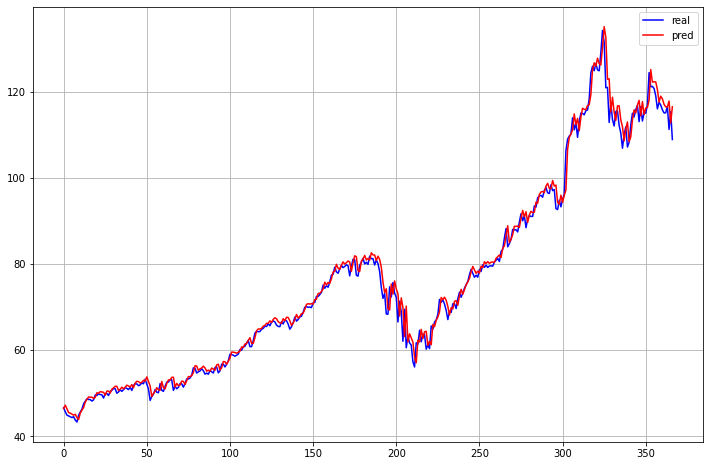

In [114]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='real')
plt.plot(pr, color='red', label='pred')
plt.grid()
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import r2_score
sc = r2_score(y_test, pr)
print(sc)

0.9908043698034803


In [117]:
y_d = y_test[1:]

In [118]:
len(y_test[:-1])

366

In [119]:
r2_score(y_test[:-1], y_d)

0.9915484290826602